##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to solve a problem on Kaggle with TF-Hub


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub_on_kaggle"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/nnlm-en-dim128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**. In this tutorial, we will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then submit the predictions to Kaggle.

For more detailed tutorial on text classification with TF-Hub and further steps for improving the accuracy, take a look at [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).

## Setup

In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

from sklearn import model_selection

Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api) for your Kaggle account, and uploading it to the Colab environment.

In [4]:
import os
import pathlib

# Upload the API token.
def get_kaggle():
  try:
    import kaggle
    return kaggle
  except OSError:
    pass

  token_file = pathlib.Path("~/.kaggle/kaggle.json").expanduser()
  token_file.parent.mkdir(exist_ok=True, parents=True)

  try:
    from google.colab import files
  except ImportError:
    raise ValueError("Could not find kaggle token.")

  uploaded = files.upload()
  token_content = uploaded.get('kaggle.json', None)
  if token_content:
    token_file.write_bytes(token_content)
    token_file.chmod(0o600)
  else:
    raise ValueError('Need a file named "kaggle.json"')
  
  import kaggle
  return kaggle


kaggle = get_kaggle()

# Getting started

## Data
We will try to solve the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) task from Kaggle. The dataset consists of syntactic subphrases of the Rotten Tomatoes movie reviews. The task is to label the phrases as **negative** or **positive** on the scale from 1 to 5.

You must [accept the competition rules](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) before you can use the API to download the data.


In [5]:
SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

# Add a column with readable values representing the sentiment.
def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)
    
# Download data from Kaggle and create a DataFrame.
def load_data_from_zip(path):
  with zipfile.ZipFile(path, "r") as zip_ref:
    name = zip_ref.namelist()[0]
    with zip_ref.open(name) as zf:
      return pd.read_csv(zf, sep="\t", index_col=0)


# The data does not come with a validation set so we'll create one from the
# training set.
def get_data(competition, train_file, test_file, validation_set_ratio=0.1):
  data_path = pathlib.Path("data")
  kaggle.api.competition_download_files(competition, data_path)
  competition_path = (data_path/competition)
  competition_path.mkdir(exist_ok=True, parents=True)
  competition_zip_path = competition_path.with_suffix(".zip")

  with zipfile.ZipFile(competition_zip_path, "r") as zip_ref:
    zip_ref.extractall(competition_path)
  
  train_df = load_data_from_zip(competition_path/train_file)
  test_df = load_data_from_zip(competition_path/test_file)

  # Add a human readable label.
  add_readable_labels_column(train_df, "Sentiment")

  # We split by sentence ids, because we don't want to have phrases belonging
  # to the same sentence in both training and validation set.
  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df


train_df, validation_df, test_df = get_data(
    "sentiment-analysis-on-movie-reviews",
    "train.tsv.zip", "test.tsv.zip")

Split the training data into 140315 training and 15745 validation examples.


Note: In this competition the task is not to rate entire reviews, but individual phrases from withion the reviews. This is a much harder task.

In [6]:
train_df.head(20)

,SentenceId,Phrase,Sentiment,SentimentLabel
PhraseId,,,,
1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
2,1,A series of escapades demonstrating the adage ...,2,neutral
3,1,A series,2,neutral
4,1,A,2,neutral
5,1,series,2,neutral
6,1,of escapades demonstrating the adage that what...,2,neutral
7,1,of,2,neutral
8,1,escapades demonstrating the adage that what is...,2,neutral
9,1,escapades,2,neutral


## Training an Model

*Note: We could model this task also as a regression, see [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).*

In [7]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [8]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [9]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25


   1/4385 [..............................] - ETA: 2s - loss: 1.9266 - accuracy: 0.1250

  20/4385 [..............................] - ETA: 11s - loss: 1.4505 - accuracy: 0.4250

  35/4385 [..............................] - ETA: 12s - loss: 1.4194 - accuracy: 0.4509

  50/4385 [..............................] - ETA: 13s - loss: 1.3845 - accuracy: 0.4675

  64/4385 [..............................] - ETA: 13s - loss: 1.3509 - accuracy: 0.4751

  79/4385 [..............................] - ETA: 14s - loss: 1.3173 - accuracy: 0.4842

  93/4385 [..............................] - ETA: 14s - loss: 1.2917 - accuracy: 0.4940

 107/4385 [..............................] - ETA: 14s - loss: 1.2729 - accuracy: 0.4994

 121/4385 [..............................] - ETA: 14s - loss: 1.2577 - accuracy: 0.5031

 135/4385 [..............................] - ETA: 14s - loss: 1.2403 - accuracy: 0.5081

 150/4385 [>.............................] - ETA: 14s - loss: 1.2201 - accuracy: 0.5183

 164/4385 [>.............................] - ETA: 14s - loss: 1.2074 - accuracy: 0.5246

 179/4385 [>.............................] - ETA: 14s - loss: 1.1981 - accuracy: 0.5283

 194/4385 [>.............................] - ETA: 14s - loss: 1.1924 - accuracy: 0.5296

 209/4385 [>.............................] - ETA: 14s - loss: 1.1809 - accuracy: 0.5318

 224/4385 [>.............................] - ETA: 14s - loss: 1.1718 - accuracy: 0.5354

 239/4385 [>.............................] - ETA: 14s - loss: 1.1684 - accuracy: 0.5388

 254/4385 [>.............................] - ETA: 14s - loss: 1.1664 - accuracy: 0.5401

 269/4385 [>.............................] - ETA: 14s - loss: 1.1627 - accuracy: 0.5400

 284/4385 [>.............................] - ETA: 14s - loss: 1.1595 - accuracy: 0.5418

 298/4385 [=>............................] - ETA: 14s - loss: 1.1518 - accuracy: 0.5449

 313/4385 [=>............................] - ETA: 14s - loss: 1.1444 - accuracy: 0.5490

 328/4385 [=>............................] - ETA: 14s - loss: 1.1404 - accuracy: 0.5513

 342/4385 [=>............................] - ETA: 14s - loss: 1.1376 - accuracy: 0.5514

 357/4385 [=>............................] - ETA: 14s - loss: 1.1376 - accuracy: 0.5511

 371/4385 [=>............................] - ETA: 14s - loss: 1.1364 - accuracy: 0.5516

 385/4385 [=>............................] - ETA: 14s - loss: 1.1351 - accuracy: 0.5513

 399/4385 [=>............................] - ETA: 13s - loss: 1.1309 - accuracy: 0.5526

 414/4385 [=>............................] - ETA: 13s - loss: 1.1276 - accuracy: 0.5537

 428/4385 [=>............................] - ETA: 13s - loss: 1.1266 - accuracy: 0.5529

 443/4385 [==>...........................] - ETA: 13s - loss: 1.1241 - accuracy: 0.5537

 458/4385 [==>...........................] - ETA: 13s - loss: 1.1217 - accuracy: 0.5540

 473/4385 [==>...........................] - ETA: 13s - loss: 1.1203 - accuracy: 0.5545

 487/4385 [==>...........................] - ETA: 13s - loss: 1.1173 - accuracy: 0.5552

 502/4385 [==>...........................] - ETA: 13s - loss: 1.1160 - accuracy: 0.5558

 516/4385 [==>...........................] - ETA: 13s - loss: 1.1136 - accuracy: 0.5574

 531/4385 [==>...........................] - ETA: 13s - loss: 1.1108 - accuracy: 0.5591

 545/4385 [==>...........................] - ETA: 13s - loss: 1.1091 - accuracy: 0.5596

 560/4385 [==>...........................] - ETA: 13s - loss: 1.1085 - accuracy: 0.5586

 574/4385 [==>...........................] - ETA: 13s - loss: 1.1062 - accuracy: 0.5593

 589/4385 [===>..........................] - ETA: 13s - loss: 1.1046 - accuracy: 0.5596

 603/4385 [===>..........................] - ETA: 13s - loss: 1.1019 - accuracy: 0.5613

 618/4385 [===>..........................] - ETA: 13s - loss: 1.1005 - accuracy: 0.5623

 632/4385 [===>..........................] - ETA: 13s - loss: 1.0983 - accuracy: 0.5631

 647/4385 [===>..........................] - ETA: 13s - loss: 1.0969 - accuracy: 0.5632

 661/4385 [===>..........................] - ETA: 13s - loss: 1.0948 - accuracy: 0.5636

 675/4385 [===>..........................] - ETA: 13s - loss: 1.0924 - accuracy: 0.5644

 689/4385 [===>..........................] - ETA: 13s - loss: 1.0910 - accuracy: 0.5652

 703/4385 [===>..........................] - ETA: 13s - loss: 1.0887 - accuracy: 0.5665

 717/4385 [===>..........................] - ETA: 12s - loss: 1.0883 - accuracy: 0.5663

 732/4385 [====>.........................] - ETA: 12s - loss: 1.0855 - accuracy: 0.5678

 747/4385 [====>.........................] - ETA: 12s - loss: 1.0841 - accuracy: 0.5680

 762/4385 [====>.........................] - ETA: 12s - loss: 1.0828 - accuracy: 0.5686

 777/4385 [====>.........................] - ETA: 12s - loss: 1.0837 - accuracy: 0.5678

 792/4385 [====>.........................] - ETA: 12s - loss: 1.0829 - accuracy: 0.5678

 806/4385 [====>.........................] - ETA: 12s - loss: 1.0822 - accuracy: 0.5684

 820/4385 [====>.........................] - ETA: 12s - loss: 1.0816 - accuracy: 0.5681

 834/4385 [====>.........................] - ETA: 12s - loss: 1.0806 - accuracy: 0.5684

 848/4385 [====>.........................] - ETA: 12s - loss: 1.0798 - accuracy: 0.5682

 863/4385 [====>.........................] - ETA: 12s - loss: 1.0784 - accuracy: 0.5691

 878/4385 [=====>........................] - ETA: 12s - loss: 1.0776 - accuracy: 0.5695

 892/4385 [=====>........................] - ETA: 12s - loss: 1.0780 - accuracy: 0.5698

 906/4385 [=====>........................] - ETA: 12s - loss: 1.0777 - accuracy: 0.5701

 921/4385 [=====>........................] - ETA: 12s - loss: 1.0772 - accuracy: 0.5698

 935/4385 [=====>........................] - ETA: 12s - loss: 1.0762 - accuracy: 0.5698

 950/4385 [=====>........................] - ETA: 12s - loss: 1.0751 - accuracy: 0.5701

 964/4385 [=====>........................] - ETA: 12s - loss: 1.0756 - accuracy: 0.5702

 978/4385 [=====>........................] - ETA: 12s - loss: 1.0745 - accuracy: 0.5703

 992/4385 [=====>........................] - ETA: 12s - loss: 1.0736 - accuracy: 0.5703

1007/4385 [=====>........................] - ETA: 11s - loss: 1.0735 - accuracy: 0.5704

1021/4385 [=====>........................] - ETA: 11s - loss: 1.0728 - accuracy: 0.5705

1036/4385 [======>.......................] - ETA: 11s - loss: 1.0719 - accuracy: 0.5706

1051/4385 [======>.......................] - ETA: 11s - loss: 1.0717 - accuracy: 0.5705

1066/4385 [======>.......................] - ETA: 11s - loss: 1.0713 - accuracy: 0.5704

1081/4385 [======>.......................] - ETA: 11s - loss: 1.0700 - accuracy: 0.5713

1095/4385 [======>.......................] - ETA: 11s - loss: 1.0693 - accuracy: 0.5713

1110/4385 [======>.......................] - ETA: 11s - loss: 1.0685 - accuracy: 0.5716

1125/4385 [======>.......................] - ETA: 11s - loss: 1.0677 - accuracy: 0.5721

1140/4385 [======>.......................] - ETA: 11s - loss: 1.0673 - accuracy: 0.5724

1155/4385 [======>.......................] - ETA: 11s - loss: 1.0673 - accuracy: 0.5726

1170/4385 [=======>......................] - ETA: 11s - loss: 1.0665 - accuracy: 0.5731

1185/4385 [=======>......................] - ETA: 11s - loss: 1.0659 - accuracy: 0.5734

1200/4385 [=======>......................] - ETA: 11s - loss: 1.0657 - accuracy: 0.5736

1214/4385 [=======>......................] - ETA: 11s - loss: 1.0646 - accuracy: 0.5736

1229/4385 [=======>......................] - ETA: 11s - loss: 1.0638 - accuracy: 0.5738

1243/4385 [=======>......................] - ETA: 11s - loss: 1.0632 - accuracy: 0.5740

1257/4385 [=======>......................] - ETA: 11s - loss: 1.0623 - accuracy: 0.5743

1271/4385 [=======>......................] - ETA: 11s - loss: 1.0617 - accuracy: 0.5745

1286/4385 [=======>......................] - ETA: 10s - loss: 1.0606 - accuracy: 0.5748

1301/4385 [=======>......................] - ETA: 10s - loss: 1.0605 - accuracy: 0.5746

1315/4385 [=======>......................] - ETA: 10s - loss: 1.0599 - accuracy: 0.5746

1330/4385 [========>.....................] - ETA: 10s - loss: 1.0594 - accuracy: 0.5749

1344/4385 [========>.....................] - ETA: 10s - loss: 1.0594 - accuracy: 0.5748

1358/4385 [========>.....................] - ETA: 10s - loss: 1.0586 - accuracy: 0.5752

1373/4385 [========>.....................] - ETA: 10s - loss: 1.0577 - accuracy: 0.5756

1387/4385 [========>.....................] - ETA: 10s - loss: 1.0573 - accuracy: 0.5757

1401/4385 [========>.....................] - ETA: 10s - loss: 1.0565 - accuracy: 0.5759

1415/4385 [========>.....................] - ETA: 10s - loss: 1.0563 - accuracy: 0.5760

1429/4385 [========>.....................] - ETA: 10s - loss: 1.0558 - accuracy: 0.5761

1444/4385 [========>.....................] - ETA: 10s - loss: 1.0551 - accuracy: 0.5762

1459/4385 [========>.....................] - ETA: 10s - loss: 1.0543 - accuracy: 0.5764

1474/4385 [=========>....................] - ETA: 10s - loss: 1.0543 - accuracy: 0.5762

1488/4385 [=========>....................] - ETA: 10s - loss: 1.0539 - accuracy: 0.5765

1503/4385 [=========>....................] - ETA: 10s - loss: 1.0538 - accuracy: 0.5766

1518/4385 [=========>....................] - ETA: 10s - loss: 1.0536 - accuracy: 0.5767

1532/4385 [=========>....................] - ETA: 10s - loss: 1.0529 - accuracy: 0.5768

1546/4385 [=========>....................] - ETA: 10s - loss: 1.0525 - accuracy: 0.5771

1561/4385 [=========>....................] - ETA: 10s - loss: 1.0524 - accuracy: 0.5771

1576/4385 [=========>....................] - ETA: 9s - loss: 1.0521 - accuracy: 0.5771 

1591/4385 [=========>....................] - ETA: 9s - loss: 1.0519 - accuracy: 0.5773

1606/4385 [=========>....................] - ETA: 9s - loss: 1.0510 - accuracy: 0.5777

1621/4385 [==========>...................] - ETA: 9s - loss: 1.0510 - accuracy: 0.5775

1636/4385 [==========>...................] - ETA: 9s - loss: 1.0511 - accuracy: 0.5772

1650/4385 [==========>...................] - ETA: 9s - loss: 1.0505 - accuracy: 0.5774

1665/4385 [==========>...................] - ETA: 9s - loss: 1.0494 - accuracy: 0.5776

1680/4385 [==========>...................] - ETA: 9s - loss: 1.0497 - accuracy: 0.5775

1694/4385 [==========>...................] - ETA: 9s - loss: 1.0494 - accuracy: 0.5779

1709/4385 [==========>...................] - ETA: 9s - loss: 1.0494 - accuracy: 0.5778

1724/4385 [==========>...................] - ETA: 9s - loss: 1.0490 - accuracy: 0.5779

1738/4385 [==========>...................] - ETA: 9s - loss: 1.0488 - accuracy: 0.5779

1752/4385 [==========>...................] - ETA: 9s - loss: 1.0486 - accuracy: 0.5782

1766/4385 [===========>..................] - ETA: 9s - loss: 1.0489 - accuracy: 0.5780

1780/4385 [===========>..................] - ETA: 9s - loss: 1.0482 - accuracy: 0.5782

1794/4385 [===========>..................] - ETA: 9s - loss: 1.0481 - accuracy: 0.5782

1809/4385 [===========>..................] - ETA: 9s - loss: 1.0479 - accuracy: 0.5783

1824/4385 [===========>..................] - ETA: 9s - loss: 1.0473 - accuracy: 0.5785

1838/4385 [===========>..................] - ETA: 9s - loss: 1.0471 - accuracy: 0.5785

1853/4385 [===========>..................] - ETA: 8s - loss: 1.0472 - accuracy: 0.5786

1868/4385 [===========>..................] - ETA: 8s - loss: 1.0465 - accuracy: 0.5790

1882/4385 [===========>..................] - ETA: 8s - loss: 1.0460 - accuracy: 0.5792

1897/4385 [===========>..................] - ETA: 8s - loss: 1.0460 - accuracy: 0.5788

1912/4385 [============>.................] - ETA: 8s - loss: 1.0459 - accuracy: 0.5791

1927/4385 [============>.................] - ETA: 8s - loss: 1.0463 - accuracy: 0.5789

1941/4385 [============>.................] - ETA: 8s - loss: 1.0458 - accuracy: 0.5790

1956/4385 [============>.................] - ETA: 8s - loss: 1.0451 - accuracy: 0.5795

1971/4385 [============>.................] - ETA: 8s - loss: 1.0451 - accuracy: 0.5797

1986/4385 [============>.................] - ETA: 8s - loss: 1.0444 - accuracy: 0.5799

2001/4385 [============>.................] - ETA: 8s - loss: 1.0440 - accuracy: 0.5800

2016/4385 [============>.................] - ETA: 8s - loss: 1.0437 - accuracy: 0.5801

2031/4385 [============>.................] - ETA: 8s - loss: 1.0430 - accuracy: 0.5804

2045/4385 [============>.................] - ETA: 8s - loss: 1.0432 - accuracy: 0.5803

2059/4385 [=============>................] - ETA: 8s - loss: 1.0426 - accuracy: 0.5806

2073/4385 [=============>................] - ETA: 8s - loss: 1.0426 - accuracy: 0.5807

2087/4385 [=============>................] - ETA: 8s - loss: 1.0428 - accuracy: 0.5808

2102/4385 [=============>................] - ETA: 8s - loss: 1.0428 - accuracy: 0.5808

2117/4385 [=============>................] - ETA: 8s - loss: 1.0426 - accuracy: 0.5808

2132/4385 [=============>................] - ETA: 8s - loss: 1.0423 - accuracy: 0.5811

2147/4385 [=============>................] - ETA: 7s - loss: 1.0421 - accuracy: 0.5811

2162/4385 [=============>................] - ETA: 7s - loss: 1.0420 - accuracy: 0.5812

2177/4385 [=============>................] - ETA: 7s - loss: 1.0419 - accuracy: 0.5811

2191/4385 [=============>................] - ETA: 7s - loss: 1.0420 - accuracy: 0.5810

2206/4385 [==============>...............] - ETA: 7s - loss: 1.0414 - accuracy: 0.5812

2220/4385 [==============>...............] - ETA: 7s - loss: 1.0412 - accuracy: 0.5813

2234/4385 [==============>...............] - ETA: 7s - loss: 1.0410 - accuracy: 0.5814

2248/4385 [==============>...............] - ETA: 7s - loss: 1.0408 - accuracy: 0.5816

2262/4385 [==============>...............] - ETA: 7s - loss: 1.0406 - accuracy: 0.5816

2276/4385 [==============>...............] - ETA: 7s - loss: 1.0406 - accuracy: 0.5816

2290/4385 [==============>...............] - ETA: 7s - loss: 1.0409 - accuracy: 0.5814

2305/4385 [==============>...............] - ETA: 7s - loss: 1.0409 - accuracy: 0.5812

2319/4385 [==============>...............] - ETA: 7s - loss: 1.0409 - accuracy: 0.5812

2333/4385 [==============>...............] - ETA: 7s - loss: 1.0407 - accuracy: 0.5812

2348/4385 [===============>..............] - ETA: 7s - loss: 1.0404 - accuracy: 0.5812

2363/4385 [===============>..............] - ETA: 7s - loss: 1.0400 - accuracy: 0.5813

2377/4385 [===============>..............] - ETA: 7s - loss: 1.0399 - accuracy: 0.5811

2392/4385 [===============>..............] - ETA: 7s - loss: 1.0395 - accuracy: 0.5814

2406/4385 [===============>..............] - ETA: 7s - loss: 1.0396 - accuracy: 0.5814

2421/4385 [===============>..............] - ETA: 6s - loss: 1.0393 - accuracy: 0.5814

2436/4385 [===============>..............] - ETA: 6s - loss: 1.0387 - accuracy: 0.5816

2451/4385 [===============>..............] - ETA: 6s - loss: 1.0387 - accuracy: 0.5815

2466/4385 [===============>..............] - ETA: 6s - loss: 1.0386 - accuracy: 0.5815

2481/4385 [===============>..............] - ETA: 6s - loss: 1.0385 - accuracy: 0.5815

2495/4385 [================>.............] - ETA: 6s - loss: 1.0390 - accuracy: 0.5813

2510/4385 [================>.............] - ETA: 6s - loss: 1.0386 - accuracy: 0.5814

2524/4385 [================>.............] - ETA: 6s - loss: 1.0381 - accuracy: 0.5816

2539/4385 [================>.............] - ETA: 6s - loss: 1.0382 - accuracy: 0.5815

2554/4385 [================>.............] - ETA: 6s - loss: 1.0381 - accuracy: 0.5815

2568/4385 [================>.............] - ETA: 6s - loss: 1.0378 - accuracy: 0.5815

2582/4385 [================>.............] - ETA: 6s - loss: 1.0373 - accuracy: 0.5818

2596/4385 [================>.............] - ETA: 6s - loss: 1.0370 - accuracy: 0.5820

2611/4385 [================>.............] - ETA: 6s - loss: 1.0368 - accuracy: 0.5820

2626/4385 [================>.............] - ETA: 6s - loss: 1.0364 - accuracy: 0.5823

2641/4385 [=================>............] - ETA: 6s - loss: 1.0359 - accuracy: 0.5826

2656/4385 [=================>............] - ETA: 6s - loss: 1.0357 - accuracy: 0.5826

2670/4385 [=================>............] - ETA: 6s - loss: 1.0355 - accuracy: 0.5827

2684/4385 [=================>............] - ETA: 6s - loss: 1.0353 - accuracy: 0.5828

2699/4385 [=================>............] - ETA: 5s - loss: 1.0353 - accuracy: 0.5826

2713/4385 [=================>............] - ETA: 5s - loss: 1.0356 - accuracy: 0.5824

2728/4385 [=================>............] - ETA: 5s - loss: 1.0354 - accuracy: 0.5824

2742/4385 [=================>............] - ETA: 5s - loss: 1.0354 - accuracy: 0.5823

2757/4385 [=================>............] - ETA: 5s - loss: 1.0349 - accuracy: 0.5825

2771/4385 [=================>............] - ETA: 5s - loss: 1.0345 - accuracy: 0.5827

2786/4385 [==================>...........] - ETA: 5s - loss: 1.0345 - accuracy: 0.5827

2800/4385 [==================>...........] - ETA: 5s - loss: 1.0342 - accuracy: 0.5829

2815/4385 [==================>...........] - ETA: 5s - loss: 1.0342 - accuracy: 0.5828

2830/4385 [==================>...........] - ETA: 5s - loss: 1.0340 - accuracy: 0.5829

2844/4385 [==================>...........] - ETA: 5s - loss: 1.0339 - accuracy: 0.5829

2859/4385 [==================>...........] - ETA: 5s - loss: 1.0338 - accuracy: 0.5829

2873/4385 [==================>...........] - ETA: 5s - loss: 1.0339 - accuracy: 0.5828

2887/4385 [==================>...........] - ETA: 5s - loss: 1.0341 - accuracy: 0.5828

2901/4385 [==================>...........] - ETA: 5s - loss: 1.0339 - accuracy: 0.5828

2915/4385 [==================>...........] - ETA: 5s - loss: 1.0339 - accuracy: 0.5827

2929/4385 [===================>..........] - ETA: 5s - loss: 1.0337 - accuracy: 0.5826

2944/4385 [===================>..........] - ETA: 5s - loss: 1.0336 - accuracy: 0.5827

2959/4385 [===================>..........] - ETA: 5s - loss: 1.0334 - accuracy: 0.5827

2973/4385 [===================>..........] - ETA: 5s - loss: 1.0331 - accuracy: 0.5830

2987/4385 [===================>..........] - ETA: 4s - loss: 1.0330 - accuracy: 0.5829

3002/4385 [===================>..........] - ETA: 4s - loss: 1.0330 - accuracy: 0.5829

3016/4385 [===================>..........] - ETA: 4s - loss: 1.0328 - accuracy: 0.5829

3031/4385 [===================>..........] - ETA: 4s - loss: 1.0324 - accuracy: 0.5831

3045/4385 [===================>..........] - ETA: 4s - loss: 1.0323 - accuracy: 0.5831

3060/4385 [===================>..........] - ETA: 4s - loss: 1.0323 - accuracy: 0.5832

3074/4385 [====================>.........] - ETA: 4s - loss: 1.0319 - accuracy: 0.5833

3089/4385 [====================>.........] - ETA: 4s - loss: 1.0319 - accuracy: 0.5834

3103/4385 [====================>.........] - ETA: 4s - loss: 1.0321 - accuracy: 0.5832

3118/4385 [====================>.........] - ETA: 4s - loss: 1.0317 - accuracy: 0.5835

3133/4385 [====================>.........] - ETA: 4s - loss: 1.0315 - accuracy: 0.5836

3147/4385 [====================>.........] - ETA: 4s - loss: 1.0313 - accuracy: 0.5838

3161/4385 [====================>.........] - ETA: 4s - loss: 1.0312 - accuracy: 0.5836

3175/4385 [====================>.........] - ETA: 4s - loss: 1.0312 - accuracy: 0.5836

3190/4385 [====================>.........] - ETA: 4s - loss: 1.0311 - accuracy: 0.5837

3204/4385 [====================>.........] - ETA: 4s - loss: 1.0310 - accuracy: 0.5839

3219/4385 [=====================>........] - ETA: 4s - loss: 1.0309 - accuracy: 0.5839

3233/4385 [=====================>........] - ETA: 4s - loss: 1.0309 - accuracy: 0.5839

3247/4385 [=====================>........] - ETA: 4s - loss: 1.0309 - accuracy: 0.5840

3261/4385 [=====================>........] - ETA: 3s - loss: 1.0308 - accuracy: 0.5840

3276/4385 [=====================>........] - ETA: 3s - loss: 1.0309 - accuracy: 0.5840

3290/4385 [=====================>........] - ETA: 3s - loss: 1.0308 - accuracy: 0.5840

3305/4385 [=====================>........] - ETA: 3s - loss: 1.0304 - accuracy: 0.5842

3319/4385 [=====================>........] - ETA: 3s - loss: 1.0303 - accuracy: 0.5842

3334/4385 [=====================>........] - ETA: 3s - loss: 1.0302 - accuracy: 0.5843

3348/4385 [=====================>........] - ETA: 3s - loss: 1.0302 - accuracy: 0.5843

3363/4385 [======================>.......] - ETA: 3s - loss: 1.0298 - accuracy: 0.5844

3377/4385 [======================>.......] - ETA: 3s - loss: 1.0297 - accuracy: 0.5845

3391/4385 [======================>.......] - ETA: 3s - loss: 1.0297 - accuracy: 0.5844

3405/4385 [======================>.......] - ETA: 3s - loss: 1.0296 - accuracy: 0.5844

3419/4385 [======================>.......] - ETA: 3s - loss: 1.0295 - accuracy: 0.5844

3433/4385 [======================>.......] - ETA: 3s - loss: 1.0294 - accuracy: 0.5843

3447/4385 [======================>.......] - ETA: 3s - loss: 1.0293 - accuracy: 0.5844

3461/4385 [======================>.......] - ETA: 3s - loss: 1.0289 - accuracy: 0.5844

3475/4385 [======================>.......] - ETA: 3s - loss: 1.0289 - accuracy: 0.5844

3489/4385 [======================>.......] - ETA: 3s - loss: 1.0287 - accuracy: 0.5845

3504/4385 [======================>.......] - ETA: 3s - loss: 1.0288 - accuracy: 0.5844

3518/4385 [=======================>......] - ETA: 3s - loss: 1.0286 - accuracy: 0.5846

3533/4385 [=======================>......] - ETA: 3s - loss: 1.0284 - accuracy: 0.5845

3547/4385 [=======================>......] - ETA: 2s - loss: 1.0282 - accuracy: 0.5846

3562/4385 [=======================>......] - ETA: 2s - loss: 1.0281 - accuracy: 0.5846

3577/4385 [=======================>......] - ETA: 2s - loss: 1.0279 - accuracy: 0.5846

3591/4385 [=======================>......] - ETA: 2s - loss: 1.0277 - accuracy: 0.5848

3606/4385 [=======================>......] - ETA: 2s - loss: 1.0274 - accuracy: 0.5850

3621/4385 [=======================>......] - ETA: 2s - loss: 1.0275 - accuracy: 0.5850

3636/4385 [=======================>......] - ETA: 2s - loss: 1.0273 - accuracy: 0.5850

3650/4385 [=======================>......] - ETA: 2s - loss: 1.0272 - accuracy: 0.5849

3665/4385 [========================>.....] - ETA: 2s - loss: 1.0272 - accuracy: 0.5848

3680/4385 [========================>.....] - ETA: 2s - loss: 1.0273 - accuracy: 0.5849

3695/4385 [========================>.....] - ETA: 2s - loss: 1.0272 - accuracy: 0.5849

3710/4385 [========================>.....] - ETA: 2s - loss: 1.0271 - accuracy: 0.5849

3725/4385 [========================>.....] - ETA: 2s - loss: 1.0270 - accuracy: 0.5849

3740/4385 [========================>.....] - ETA: 2s - loss: 1.0269 - accuracy: 0.5850

3755/4385 [========================>.....] - ETA: 2s - loss: 1.0265 - accuracy: 0.5850

3769/4385 [========================>.....] - ETA: 2s - loss: 1.0264 - accuracy: 0.5851

3784/4385 [========================>.....] - ETA: 2s - loss: 1.0264 - accuracy: 0.5851

3799/4385 [========================>.....] - ETA: 2s - loss: 1.0264 - accuracy: 0.5851

3813/4385 [=========================>....] - ETA: 2s - loss: 1.0264 - accuracy: 0.5850

3828/4385 [=========================>....] - ETA: 1s - loss: 1.0264 - accuracy: 0.5850

3843/4385 [=========================>....] - ETA: 1s - loss: 1.0262 - accuracy: 0.5851

3858/4385 [=========================>....] - ETA: 1s - loss: 1.0262 - accuracy: 0.5851

3873/4385 [=========================>....] - ETA: 1s - loss: 1.0260 - accuracy: 0.5852

3887/4385 [=========================>....] - ETA: 1s - loss: 1.0261 - accuracy: 0.5852

3901/4385 [=========================>....] - ETA: 1s - loss: 1.0262 - accuracy: 0.5852

3916/4385 [=========================>....] - ETA: 1s - loss: 1.0260 - accuracy: 0.5853

3931/4385 [=========================>....] - ETA: 1s - loss: 1.0258 - accuracy: 0.5854

3946/4385 [=========================>....] - ETA: 1s - loss: 1.0256 - accuracy: 0.5854

3961/4385 [==========================>...] - ETA: 1s - loss: 1.0253 - accuracy: 0.5856

3976/4385 [==========================>...] - ETA: 1s - loss: 1.0253 - accuracy: 0.5855

3990/4385 [==========================>...] - ETA: 1s - loss: 1.0251 - accuracy: 0.5857

4004/4385 [==========================>...] - ETA: 1s - loss: 1.0250 - accuracy: 0.5856

4018/4385 [==========================>...] - ETA: 1s - loss: 1.0248 - accuracy: 0.5856

4033/4385 [==========================>...] - ETA: 1s - loss: 1.0246 - accuracy: 0.5857

4048/4385 [==========================>...] - ETA: 1s - loss: 1.0248 - accuracy: 0.5855

4062/4385 [==========================>...] - ETA: 1s - loss: 1.0248 - accuracy: 0.5855

4077/4385 [==========================>...] - ETA: 1s - loss: 1.0248 - accuracy: 0.5854

4092/4385 [==========================>...] - ETA: 1s - loss: 1.0245 - accuracy: 0.5856

4106/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5856

4121/4385 [===========================>..] - ETA: 0s - loss: 1.0244 - accuracy: 0.5857

4136/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5856

4151/4385 [===========================>..] - ETA: 0s - loss: 1.0244 - accuracy: 0.5856

4166/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5856

4181/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5855

4196/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5855

4211/4385 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.5856

4226/4385 [===========================>..] - ETA: 0s - loss: 1.0247 - accuracy: 0.5855

4241/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5856

4256/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5855

4271/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5855

4286/4385 [============================>.] - ETA: 0s - loss: 1.0247 - accuracy: 0.5854

4301/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5854

4316/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5856

4331/4385 [============================>.] - ETA: 0s - loss: 1.0244 - accuracy: 0.5857

4346/4385 [============================>.] - ETA: 0s - loss: 1.0241 - accuracy: 0.5859

4361/4385 [============================>.] - ETA: 0s - loss: 1.0237 - accuracy: 0.5861

4376/4385 [============================>.] - ETA: 0s - loss: 1.0237 - accuracy: 0.5860

4385/4385 [==============================] - 17s 4ms/step - loss: 1.0237 - accuracy: 0.5860 - val_loss: 0.9896 - val_accuracy: 0.5923


Epoch 2/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8906 - accuracy: 0.6250

  21/4385 [..............................] - ETA: 10s - loss: 0.9717 - accuracy: 0.5923

  36/4385 [..............................] - ETA: 12s - loss: 0.9704 - accuracy: 0.6033

  51/4385 [..............................] - ETA: 13s - loss: 0.9823 - accuracy: 0.5999

  66/4385 [..............................] - ETA: 13s - loss: 0.9801 - accuracy: 0.6018

  81/4385 [..............................] - ETA: 13s - loss: 0.9707 - accuracy: 0.6057

  96/4385 [..............................] - ETA: 14s - loss: 0.9729 - accuracy: 0.6071

 111/4385 [..............................] - ETA: 14s - loss: 0.9733 - accuracy: 0.6036

 126/4385 [..............................] - ETA: 14s - loss: 0.9767 - accuracy: 0.6034

 141/4385 [..............................] - ETA: 14s - loss: 0.9751 - accuracy: 0.6066

 156/4385 [>.............................] - ETA: 14s - loss: 0.9791 - accuracy: 0.6054

 171/4385 [>.............................] - ETA: 14s - loss: 0.9841 - accuracy: 0.6042

 185/4385 [>.............................] - ETA: 14s - loss: 0.9915 - accuracy: 0.6003

 200/4385 [>.............................] - ETA: 14s - loss: 0.9932 - accuracy: 0.5994

 215/4385 [>.............................] - ETA: 14s - loss: 0.9937 - accuracy: 0.5985

 230/4385 [>.............................] - ETA: 14s - loss: 0.9949 - accuracy: 0.5966

 245/4385 [>.............................] - ETA: 14s - loss: 0.9926 - accuracy: 0.5976

 260/4385 [>.............................] - ETA: 14s - loss: 0.9914 - accuracy: 0.5977

 275/4385 [>.............................] - ETA: 14s - loss: 0.9915 - accuracy: 0.5981

 290/4385 [>.............................] - ETA: 13s - loss: 0.9931 - accuracy: 0.5967

 305/4385 [=>............................] - ETA: 13s - loss: 0.9916 - accuracy: 0.5960

 320/4385 [=>............................] - ETA: 13s - loss: 0.9912 - accuracy: 0.5958

 335/4385 [=>............................] - ETA: 13s - loss: 0.9926 - accuracy: 0.5956

 350/4385 [=>............................] - ETA: 13s - loss: 0.9951 - accuracy: 0.5943

 365/4385 [=>............................] - ETA: 13s - loss: 0.9958 - accuracy: 0.5938

 380/4385 [=>............................] - ETA: 13s - loss: 0.9951 - accuracy: 0.5934

 395/4385 [=>............................] - ETA: 13s - loss: 0.9939 - accuracy: 0.5937

 410/4385 [=>............................] - ETA: 13s - loss: 0.9952 - accuracy: 0.5931

 424/4385 [=>............................] - ETA: 13s - loss: 0.9949 - accuracy: 0.5934

 439/4385 [==>...........................] - ETA: 13s - loss: 0.9943 - accuracy: 0.5942

 454/4385 [==>...........................] - ETA: 13s - loss: 0.9935 - accuracy: 0.5950

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9943 - accuracy: 0.5947

 484/4385 [==>...........................] - ETA: 13s - loss: 0.9946 - accuracy: 0.5946

 499/4385 [==>...........................] - ETA: 13s - loss: 0.9944 - accuracy: 0.5945

 514/4385 [==>...........................] - ETA: 13s - loss: 0.9948 - accuracy: 0.5943

 529/4385 [==>...........................] - ETA: 13s - loss: 0.9971 - accuracy: 0.5942

 544/4385 [==>...........................] - ETA: 13s - loss: 0.9970 - accuracy: 0.5939

 559/4385 [==>...........................] - ETA: 13s - loss: 0.9969 - accuracy: 0.5938

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9974 - accuracy: 0.5932

 589/4385 [===>..........................] - ETA: 13s - loss: 0.9971 - accuracy: 0.5941

 604/4385 [===>..........................] - ETA: 13s - loss: 0.9984 - accuracy: 0.5927

 619/4385 [===>..........................] - ETA: 13s - loss: 1.0006 - accuracy: 0.5914

 634/4385 [===>..........................] - ETA: 12s - loss: 0.9995 - accuracy: 0.5913

 649/4385 [===>..........................] - ETA: 12s - loss: 0.9997 - accuracy: 0.5908

 663/4385 [===>..........................] - ETA: 12s - loss: 0.9995 - accuracy: 0.5909

 678/4385 [===>..........................] - ETA: 12s - loss: 0.9985 - accuracy: 0.5920

 693/4385 [===>..........................] - ETA: 12s - loss: 0.9997 - accuracy: 0.5921

 708/4385 [===>..........................] - ETA: 12s - loss: 1.0002 - accuracy: 0.5917

 723/4385 [===>..........................] - ETA: 12s - loss: 1.0008 - accuracy: 0.5911

 738/4385 [====>.........................] - ETA: 12s - loss: 1.0011 - accuracy: 0.5915

 752/4385 [====>.........................] - ETA: 12s - loss: 1.0008 - accuracy: 0.5920

 767/4385 [====>.........................] - ETA: 12s - loss: 1.0020 - accuracy: 0.5918

 782/4385 [====>.........................] - ETA: 12s - loss: 1.0032 - accuracy: 0.5910

 796/4385 [====>.........................] - ETA: 12s - loss: 1.0028 - accuracy: 0.5911

 811/4385 [====>.........................] - ETA: 12s - loss: 1.0018 - accuracy: 0.5914

 826/4385 [====>.........................] - ETA: 12s - loss: 1.0020 - accuracy: 0.5916

 841/4385 [====>.........................] - ETA: 12s - loss: 1.0030 - accuracy: 0.5911

 856/4385 [====>.........................] - ETA: 12s - loss: 1.0026 - accuracy: 0.5910

 871/4385 [====>.........................] - ETA: 12s - loss: 1.0032 - accuracy: 0.5904

 886/4385 [=====>........................] - ETA: 12s - loss: 1.0027 - accuracy: 0.5905

 901/4385 [=====>........................] - ETA: 12s - loss: 1.0034 - accuracy: 0.5900

 915/4385 [=====>........................] - ETA: 12s - loss: 1.0033 - accuracy: 0.5898

 929/4385 [=====>........................] - ETA: 12s - loss: 1.0018 - accuracy: 0.5905

 943/4385 [=====>........................] - ETA: 11s - loss: 1.0019 - accuracy: 0.5902

 958/4385 [=====>........................] - ETA: 11s - loss: 1.0015 - accuracy: 0.5902

 973/4385 [=====>........................] - ETA: 11s - loss: 1.0009 - accuracy: 0.5905

 988/4385 [=====>........................] - ETA: 11s - loss: 1.0005 - accuracy: 0.5907

1002/4385 [=====>........................] - ETA: 11s - loss: 1.0007 - accuracy: 0.5906

1016/4385 [=====>........................] - ETA: 11s - loss: 1.0012 - accuracy: 0.5902

1030/4385 [======>.......................] - ETA: 11s - loss: 1.0015 - accuracy: 0.5904

1044/4385 [======>.......................] - ETA: 11s - loss: 1.0022 - accuracy: 0.5899

1058/4385 [======>.......................] - ETA: 11s - loss: 1.0023 - accuracy: 0.5901

1072/4385 [======>.......................] - ETA: 11s - loss: 1.0020 - accuracy: 0.5902

1087/4385 [======>.......................] - ETA: 11s - loss: 1.0022 - accuracy: 0.5899

1101/4385 [======>.......................] - ETA: 11s - loss: 1.0017 - accuracy: 0.5900

1116/4385 [======>.......................] - ETA: 11s - loss: 1.0021 - accuracy: 0.5899

1130/4385 [======>.......................] - ETA: 11s - loss: 1.0029 - accuracy: 0.5897

1145/4385 [======>.......................] - ETA: 11s - loss: 1.0036 - accuracy: 0.5895

1160/4385 [======>.......................] - ETA: 11s - loss: 1.0027 - accuracy: 0.5895

1175/4385 [=======>......................] - ETA: 11s - loss: 1.0023 - accuracy: 0.5894

1190/4385 [=======>......................] - ETA: 11s - loss: 1.0020 - accuracy: 0.5896

1205/4385 [=======>......................] - ETA: 11s - loss: 1.0021 - accuracy: 0.5896

1220/4385 [=======>......................] - ETA: 11s - loss: 1.0031 - accuracy: 0.5894

1235/4385 [=======>......................] - ETA: 11s - loss: 1.0037 - accuracy: 0.5890

1249/4385 [=======>......................] - ETA: 10s - loss: 1.0040 - accuracy: 0.5888

1263/4385 [=======>......................] - ETA: 10s - loss: 1.0035 - accuracy: 0.5890

1278/4385 [=======>......................] - ETA: 10s - loss: 1.0035 - accuracy: 0.5891

1293/4385 [=======>......................] - ETA: 10s - loss: 1.0030 - accuracy: 0.5893

1307/4385 [=======>......................] - ETA: 10s - loss: 1.0031 - accuracy: 0.5894

1321/4385 [========>.....................] - ETA: 10s - loss: 1.0027 - accuracy: 0.5897

1335/4385 [========>.....................] - ETA: 10s - loss: 1.0029 - accuracy: 0.5893

1350/4385 [========>.....................] - ETA: 10s - loss: 1.0031 - accuracy: 0.5893

1365/4385 [========>.....................] - ETA: 10s - loss: 1.0032 - accuracy: 0.5890

1380/4385 [========>.....................] - ETA: 10s - loss: 1.0038 - accuracy: 0.5889

1395/4385 [========>.....................] - ETA: 10s - loss: 1.0035 - accuracy: 0.5889

1410/4385 [========>.....................] - ETA: 10s - loss: 1.0036 - accuracy: 0.5887

1425/4385 [========>.....................] - ETA: 10s - loss: 1.0034 - accuracy: 0.5889

1440/4385 [========>.....................] - ETA: 10s - loss: 1.0032 - accuracy: 0.5891

1455/4385 [========>.....................] - ETA: 10s - loss: 1.0027 - accuracy: 0.5895

1470/4385 [=========>....................] - ETA: 10s - loss: 1.0029 - accuracy: 0.5895

1485/4385 [=========>....................] - ETA: 10s - loss: 1.0030 - accuracy: 0.5897

1500/4385 [=========>....................] - ETA: 10s - loss: 1.0026 - accuracy: 0.5902

1515/4385 [=========>....................] - ETA: 10s - loss: 1.0035 - accuracy: 0.5899

1529/4385 [=========>....................] - ETA: 10s - loss: 1.0033 - accuracy: 0.5900

1544/4385 [=========>....................] - ETA: 9s - loss: 1.0035 - accuracy: 0.5897 

1558/4385 [=========>....................] - ETA: 9s - loss: 1.0042 - accuracy: 0.5893

1573/4385 [=========>....................] - ETA: 9s - loss: 1.0043 - accuracy: 0.5894

1588/4385 [=========>....................] - ETA: 9s - loss: 1.0041 - accuracy: 0.5893

1602/4385 [=========>....................] - ETA: 9s - loss: 1.0041 - accuracy: 0.5894

1616/4385 [==========>...................] - ETA: 9s - loss: 1.0038 - accuracy: 0.5898

1630/4385 [==========>...................] - ETA: 9s - loss: 1.0040 - accuracy: 0.5896

1644/4385 [==========>...................] - ETA: 9s - loss: 1.0042 - accuracy: 0.5894

1659/4385 [==========>...................] - ETA: 9s - loss: 1.0047 - accuracy: 0.5891

1673/4385 [==========>...................] - ETA: 9s - loss: 1.0052 - accuracy: 0.5890

1687/4385 [==========>...................] - ETA: 9s - loss: 1.0052 - accuracy: 0.5891

1701/4385 [==========>...................] - ETA: 9s - loss: 1.0047 - accuracy: 0.5895

1715/4385 [==========>...................] - ETA: 9s - loss: 1.0046 - accuracy: 0.5893

1729/4385 [==========>...................] - ETA: 9s - loss: 1.0046 - accuracy: 0.5893

1744/4385 [==========>...................] - ETA: 9s - loss: 1.0049 - accuracy: 0.5893

1759/4385 [===========>..................] - ETA: 9s - loss: 1.0046 - accuracy: 0.5894

1774/4385 [===========>..................] - ETA: 9s - loss: 1.0050 - accuracy: 0.5890

1789/4385 [===========>..................] - ETA: 9s - loss: 1.0049 - accuracy: 0.5891

1804/4385 [===========>..................] - ETA: 9s - loss: 1.0047 - accuracy: 0.5892

1819/4385 [===========>..................] - ETA: 9s - loss: 1.0050 - accuracy: 0.5890

1834/4385 [===========>..................] - ETA: 8s - loss: 1.0049 - accuracy: 0.5890

1848/4385 [===========>..................] - ETA: 8s - loss: 1.0049 - accuracy: 0.5891

1863/4385 [===========>..................] - ETA: 8s - loss: 1.0048 - accuracy: 0.5892

1878/4385 [===========>..................] - ETA: 8s - loss: 1.0051 - accuracy: 0.5889

1892/4385 [===========>..................] - ETA: 8s - loss: 1.0052 - accuracy: 0.5888

1907/4385 [============>.................] - ETA: 8s - loss: 1.0051 - accuracy: 0.5890

1922/4385 [============>.................] - ETA: 8s - loss: 1.0053 - accuracy: 0.5891

1936/4385 [============>.................] - ETA: 8s - loss: 1.0056 - accuracy: 0.5890

1951/4385 [============>.................] - ETA: 8s - loss: 1.0049 - accuracy: 0.5892

1966/4385 [============>.................] - ETA: 8s - loss: 1.0049 - accuracy: 0.5893

1980/4385 [============>.................] - ETA: 8s - loss: 1.0044 - accuracy: 0.5892

1995/4385 [============>.................] - ETA: 8s - loss: 1.0043 - accuracy: 0.5892

2010/4385 [============>.................] - ETA: 8s - loss: 1.0042 - accuracy: 0.5894

2025/4385 [============>.................] - ETA: 8s - loss: 1.0043 - accuracy: 0.5893

2040/4385 [============>.................] - ETA: 8s - loss: 1.0044 - accuracy: 0.5892

2055/4385 [=============>................] - ETA: 8s - loss: 1.0040 - accuracy: 0.5894

2070/4385 [=============>................] - ETA: 8s - loss: 1.0039 - accuracy: 0.5895

2085/4385 [=============>................] - ETA: 8s - loss: 1.0041 - accuracy: 0.5893

2100/4385 [=============>................] - ETA: 8s - loss: 1.0037 - accuracy: 0.5896

2114/4385 [=============>................] - ETA: 7s - loss: 1.0035 - accuracy: 0.5899

2129/4385 [=============>................] - ETA: 7s - loss: 1.0034 - accuracy: 0.5900

2144/4385 [=============>................] - ETA: 7s - loss: 1.0028 - accuracy: 0.5904

2158/4385 [=============>................] - ETA: 7s - loss: 1.0029 - accuracy: 0.5902

2172/4385 [=============>................] - ETA: 7s - loss: 1.0029 - accuracy: 0.5904

2187/4385 [=============>................] - ETA: 7s - loss: 1.0028 - accuracy: 0.5903

2202/4385 [==============>...............] - ETA: 7s - loss: 1.0028 - accuracy: 0.5904

2216/4385 [==============>...............] - ETA: 7s - loss: 1.0027 - accuracy: 0.5903

2231/4385 [==============>...............] - ETA: 7s - loss: 1.0029 - accuracy: 0.5902

2246/4385 [==============>...............] - ETA: 7s - loss: 1.0029 - accuracy: 0.5902

2261/4385 [==============>...............] - ETA: 7s - loss: 1.0028 - accuracy: 0.5901

2276/4385 [==============>...............] - ETA: 7s - loss: 1.0027 - accuracy: 0.5902

2291/4385 [==============>...............] - ETA: 7s - loss: 1.0029 - accuracy: 0.5902

2306/4385 [==============>...............] - ETA: 7s - loss: 1.0026 - accuracy: 0.5903

2321/4385 [==============>...............] - ETA: 7s - loss: 1.0026 - accuracy: 0.5903

2336/4385 [==============>...............] - ETA: 7s - loss: 1.0025 - accuracy: 0.5903

2350/4385 [===============>..............] - ETA: 7s - loss: 1.0026 - accuracy: 0.5902

2365/4385 [===============>..............] - ETA: 7s - loss: 1.0021 - accuracy: 0.5905

2380/4385 [===============>..............] - ETA: 7s - loss: 1.0022 - accuracy: 0.5904

2395/4385 [===============>..............] - ETA: 7s - loss: 1.0022 - accuracy: 0.5904

2410/4385 [===============>..............] - ETA: 6s - loss: 1.0022 - accuracy: 0.5905

2424/4385 [===============>..............] - ETA: 6s - loss: 1.0023 - accuracy: 0.5905

2438/4385 [===============>..............] - ETA: 6s - loss: 1.0022 - accuracy: 0.5906

2452/4385 [===============>..............] - ETA: 6s - loss: 1.0021 - accuracy: 0.5905

2466/4385 [===============>..............] - ETA: 6s - loss: 1.0016 - accuracy: 0.5908

2481/4385 [===============>..............] - ETA: 6s - loss: 1.0012 - accuracy: 0.5909

2496/4385 [================>.............] - ETA: 6s - loss: 1.0011 - accuracy: 0.5911

2511/4385 [================>.............] - ETA: 6s - loss: 1.0014 - accuracy: 0.5912

2526/4385 [================>.............] - ETA: 6s - loss: 1.0012 - accuracy: 0.5912

2540/4385 [================>.............] - ETA: 6s - loss: 1.0014 - accuracy: 0.5910

2555/4385 [================>.............] - ETA: 6s - loss: 1.0011 - accuracy: 0.5910

2570/4385 [================>.............] - ETA: 6s - loss: 1.0013 - accuracy: 0.5910

2585/4385 [================>.............] - ETA: 6s - loss: 1.0015 - accuracy: 0.5909

2600/4385 [================>.............] - ETA: 6s - loss: 1.0012 - accuracy: 0.5909

2615/4385 [================>.............] - ETA: 6s - loss: 1.0014 - accuracy: 0.5907

2630/4385 [================>.............] - ETA: 6s - loss: 1.0011 - accuracy: 0.5910

2645/4385 [=================>............] - ETA: 6s - loss: 1.0011 - accuracy: 0.5909

2660/4385 [=================>............] - ETA: 6s - loss: 1.0008 - accuracy: 0.5912

2675/4385 [=================>............] - ETA: 6s - loss: 1.0009 - accuracy: 0.5912

2690/4385 [=================>............] - ETA: 5s - loss: 1.0012 - accuracy: 0.5912

2705/4385 [=================>............] - ETA: 5s - loss: 1.0012 - accuracy: 0.5912

2720/4385 [=================>............] - ETA: 5s - loss: 1.0015 - accuracy: 0.5912

2734/4385 [=================>............] - ETA: 5s - loss: 1.0017 - accuracy: 0.5910

2749/4385 [=================>............] - ETA: 5s - loss: 1.0017 - accuracy: 0.5911

2764/4385 [=================>............] - ETA: 5s - loss: 1.0016 - accuracy: 0.5912

2779/4385 [==================>...........] - ETA: 5s - loss: 1.0015 - accuracy: 0.5912

2794/4385 [==================>...........] - ETA: 5s - loss: 1.0015 - accuracy: 0.5912

2809/4385 [==================>...........] - ETA: 5s - loss: 1.0013 - accuracy: 0.5914

2824/4385 [==================>...........] - ETA: 5s - loss: 1.0011 - accuracy: 0.5915

2839/4385 [==================>...........] - ETA: 5s - loss: 1.0008 - accuracy: 0.5916

2854/4385 [==================>...........] - ETA: 5s - loss: 1.0008 - accuracy: 0.5917

2868/4385 [==================>...........] - ETA: 5s - loss: 1.0009 - accuracy: 0.5916

2883/4385 [==================>...........] - ETA: 5s - loss: 1.0009 - accuracy: 0.5918

2898/4385 [==================>...........] - ETA: 5s - loss: 1.0013 - accuracy: 0.5918

2913/4385 [==================>...........] - ETA: 5s - loss: 1.0012 - accuracy: 0.5920

2928/4385 [===================>..........] - ETA: 5s - loss: 1.0011 - accuracy: 0.5921

2943/4385 [===================>..........] - ETA: 5s - loss: 1.0010 - accuracy: 0.5922

2958/4385 [===================>..........] - ETA: 5s - loss: 1.0009 - accuracy: 0.5923

2973/4385 [===================>..........] - ETA: 4s - loss: 1.0006 - accuracy: 0.5924

2988/4385 [===================>..........] - ETA: 4s - loss: 1.0007 - accuracy: 0.5925

3003/4385 [===================>..........] - ETA: 4s - loss: 1.0005 - accuracy: 0.5927

3017/4385 [===================>..........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5929

3032/4385 [===================>..........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5929

3047/4385 [===================>..........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5929

3061/4385 [===================>..........] - ETA: 4s - loss: 1.0001 - accuracy: 0.5933

3075/4385 [====================>.........] - ETA: 4s - loss: 1.0004 - accuracy: 0.5932

3090/4385 [====================>.........] - ETA: 4s - loss: 1.0006 - accuracy: 0.5932

3105/4385 [====================>.........] - ETA: 4s - loss: 1.0006 - accuracy: 0.5932

3120/4385 [====================>.........] - ETA: 4s - loss: 1.0008 - accuracy: 0.5932

3134/4385 [====================>.........] - ETA: 4s - loss: 1.0005 - accuracy: 0.5934

3149/4385 [====================>.........] - ETA: 4s - loss: 1.0005 - accuracy: 0.5933

3163/4385 [====================>.........] - ETA: 4s - loss: 1.0005 - accuracy: 0.5932

3178/4385 [====================>.........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5934

3192/4385 [====================>.........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5934

3207/4385 [====================>.........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5933

3222/4385 [=====================>........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5932

3237/4385 [=====================>........] - ETA: 4s - loss: 1.0003 - accuracy: 0.5932

3251/4385 [=====================>........] - ETA: 3s - loss: 1.0002 - accuracy: 0.5932

3265/4385 [=====================>........] - ETA: 3s - loss: 0.9999 - accuracy: 0.5934

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9999 - accuracy: 0.5934

3294/4385 [=====================>........] - ETA: 3s - loss: 0.9998 - accuracy: 0.5936

3308/4385 [=====================>........] - ETA: 3s - loss: 0.9998 - accuracy: 0.5938

3323/4385 [=====================>........] - ETA: 3s - loss: 0.9997 - accuracy: 0.5939

3337/4385 [=====================>........] - ETA: 3s - loss: 0.9997 - accuracy: 0.5940

3351/4385 [=====================>........] - ETA: 3s - loss: 0.9996 - accuracy: 0.5939

3366/4385 [======================>.......] - ETA: 3s - loss: 0.9996 - accuracy: 0.5939

3380/4385 [======================>.......] - ETA: 3s - loss: 0.9998 - accuracy: 0.5938

3395/4385 [======================>.......] - ETA: 3s - loss: 0.9997 - accuracy: 0.5938

3409/4385 [======================>.......] - ETA: 3s - loss: 0.9997 - accuracy: 0.5938

3424/4385 [======================>.......] - ETA: 3s - loss: 0.9996 - accuracy: 0.5938

3439/4385 [======================>.......] - ETA: 3s - loss: 0.9998 - accuracy: 0.5938

3454/4385 [======================>.......] - ETA: 3s - loss: 0.9996 - accuracy: 0.5938

3469/4385 [======================>.......] - ETA: 3s - loss: 0.9997 - accuracy: 0.5938

3484/4385 [======================>.......] - ETA: 3s - loss: 0.9993 - accuracy: 0.5939

3499/4385 [======================>.......] - ETA: 3s - loss: 0.9992 - accuracy: 0.5940

3513/4385 [=======================>......] - ETA: 3s - loss: 0.9992 - accuracy: 0.5940

3528/4385 [=======================>......] - ETA: 3s - loss: 0.9990 - accuracy: 0.5941

3542/4385 [=======================>......] - ETA: 2s - loss: 0.9990 - accuracy: 0.5942

3556/4385 [=======================>......] - ETA: 2s - loss: 0.9992 - accuracy: 0.5943

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9993 - accuracy: 0.5942

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9994 - accuracy: 0.5942

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9995 - accuracy: 0.5941

3615/4385 [=======================>......] - ETA: 2s - loss: 0.9996 - accuracy: 0.5941

3630/4385 [=======================>......] - ETA: 2s - loss: 0.9996 - accuracy: 0.5941

3645/4385 [=======================>......] - ETA: 2s - loss: 0.9996 - accuracy: 0.5941

3659/4385 [========================>.....] - ETA: 2s - loss: 0.9996 - accuracy: 0.5942

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9996 - accuracy: 0.5941

3689/4385 [========================>.....] - ETA: 2s - loss: 0.9995 - accuracy: 0.5942

3704/4385 [========================>.....] - ETA: 2s - loss: 0.9995 - accuracy: 0.5942

3719/4385 [========================>.....] - ETA: 2s - loss: 0.9997 - accuracy: 0.5941

3734/4385 [========================>.....] - ETA: 2s - loss: 0.9997 - accuracy: 0.5941

3749/4385 [========================>.....] - ETA: 2s - loss: 0.9996 - accuracy: 0.5942

3763/4385 [========================>.....] - ETA: 2s - loss: 0.9996 - accuracy: 0.5943

3777/4385 [========================>.....] - ETA: 2s - loss: 0.9997 - accuracy: 0.5943

3791/4385 [========================>.....] - ETA: 2s - loss: 0.9993 - accuracy: 0.5945

3805/4385 [=========================>....] - ETA: 2s - loss: 0.9991 - accuracy: 0.5946

3819/4385 [=========================>....] - ETA: 1s - loss: 0.9991 - accuracy: 0.5946

3833/4385 [=========================>....] - ETA: 1s - loss: 0.9990 - accuracy: 0.5947

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9992 - accuracy: 0.5946

3861/4385 [=========================>....] - ETA: 1s - loss: 0.9991 - accuracy: 0.5946

3875/4385 [=========================>....] - ETA: 1s - loss: 0.9991 - accuracy: 0.5946

3889/4385 [=========================>....] - ETA: 1s - loss: 0.9992 - accuracy: 0.5945

3903/4385 [=========================>....] - ETA: 1s - loss: 0.9990 - accuracy: 0.5945

3918/4385 [=========================>....] - ETA: 1s - loss: 0.9991 - accuracy: 0.5947

3933/4385 [=========================>....] - ETA: 1s - loss: 0.9991 - accuracy: 0.5948

3948/4385 [==========================>...] - ETA: 1s - loss: 0.9990 - accuracy: 0.5948

3963/4385 [==========================>...] - ETA: 1s - loss: 0.9990 - accuracy: 0.5947

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9989 - accuracy: 0.5947

3993/4385 [==========================>...] - ETA: 1s - loss: 0.9991 - accuracy: 0.5947

4008/4385 [==========================>...] - ETA: 1s - loss: 0.9989 - accuracy: 0.5948

4023/4385 [==========================>...] - ETA: 1s - loss: 0.9990 - accuracy: 0.5948

4037/4385 [==========================>...] - ETA: 1s - loss: 0.9989 - accuracy: 0.5947

4051/4385 [==========================>...] - ETA: 1s - loss: 0.9991 - accuracy: 0.5946

4066/4385 [==========================>...] - ETA: 1s - loss: 0.9992 - accuracy: 0.5947

4081/4385 [==========================>...] - ETA: 1s - loss: 0.9992 - accuracy: 0.5946

4095/4385 [===========================>..] - ETA: 1s - loss: 0.9992 - accuracy: 0.5946

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9995 - accuracy: 0.5945

4124/4385 [===========================>..] - ETA: 0s - loss: 0.9995 - accuracy: 0.5945

4138/4385 [===========================>..] - ETA: 0s - loss: 0.9996 - accuracy: 0.5944

4152/4385 [===========================>..] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4166/4385 [===========================>..] - ETA: 0s - loss: 0.9996 - accuracy: 0.5944

4181/4385 [===========================>..] - ETA: 0s - loss: 0.9998 - accuracy: 0.5943

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4210/4385 [===========================>..] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4239/4385 [============================>.] - ETA: 0s - loss: 0.9996 - accuracy: 0.5944

4254/4385 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.5943

4268/4385 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.5943

4282/4385 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.5944

4297/4385 [============================>.] - ETA: 0s - loss: 0.9996 - accuracy: 0.5944

4311/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4325/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5946

4339/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4354/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4368/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4383/4385 [============================>.] - ETA: 0s - loss: 0.9997 - accuracy: 0.5944

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9997 - accuracy: 0.5944 - val_loss: 0.9805 - val_accuracy: 0.6005


Epoch 3/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0748 - accuracy: 0.5000

  18/4385 [..............................] - ETA: 12s - loss: 1.0241 - accuracy: 0.5833

  36/4385 [..............................] - ETA: 12s - loss: 1.0191 - accuracy: 0.5816

  50/4385 [..............................] - ETA: 13s - loss: 1.0175 - accuracy: 0.5825

  65/4385 [..............................] - ETA: 13s - loss: 1.0322 - accuracy: 0.5716

  79/4385 [..............................] - ETA: 14s - loss: 1.0240 - accuracy: 0.5744

  93/4385 [..............................] - ETA: 14s - loss: 1.0176 - accuracy: 0.5803

 108/4385 [..............................] - ETA: 14s - loss: 1.0152 - accuracy: 0.5816

 122/4385 [..............................] - ETA: 14s - loss: 1.0161 - accuracy: 0.5832

 137/4385 [..............................] - ETA: 14s - loss: 1.0090 - accuracy: 0.5865

 152/4385 [>.............................] - ETA: 14s - loss: 1.0010 - accuracy: 0.5884

 166/4385 [>.............................] - ETA: 14s - loss: 1.0047 - accuracy: 0.5857

 180/4385 [>.............................] - ETA: 14s - loss: 1.0049 - accuracy: 0.5866

 194/4385 [>.............................] - ETA: 14s - loss: 1.0041 - accuracy: 0.5859

 208/4385 [>.............................] - ETA: 14s - loss: 1.0050 - accuracy: 0.5856

 223/4385 [>.............................] - ETA: 14s - loss: 1.0001 - accuracy: 0.5887

 237/4385 [>.............................] - ETA: 14s - loss: 1.0001 - accuracy: 0.5891

 251/4385 [>.............................] - ETA: 14s - loss: 0.9968 - accuracy: 0.5916

 266/4385 [>.............................] - ETA: 14s - loss: 0.9981 - accuracy: 0.5907

 281/4385 [>.............................] - ETA: 14s - loss: 0.9984 - accuracy: 0.5902

 295/4385 [=>............................] - ETA: 14s - loss: 1.0026 - accuracy: 0.5900

 309/4385 [=>............................] - ETA: 14s - loss: 1.0044 - accuracy: 0.5899

 323/4385 [=>............................] - ETA: 14s - loss: 1.0036 - accuracy: 0.5895

 337/4385 [=>............................] - ETA: 14s - loss: 1.0059 - accuracy: 0.5883

 351/4385 [=>............................] - ETA: 14s - loss: 1.0057 - accuracy: 0.5880

 365/4385 [=>............................] - ETA: 14s - loss: 1.0022 - accuracy: 0.5897

 379/4385 [=>............................] - ETA: 14s - loss: 1.0006 - accuracy: 0.5894

 393/4385 [=>............................] - ETA: 14s - loss: 1.0005 - accuracy: 0.5888

 407/4385 [=>............................] - ETA: 14s - loss: 1.0014 - accuracy: 0.5885

 421/4385 [=>............................] - ETA: 14s - loss: 1.0021 - accuracy: 0.5882

 436/4385 [=>............................] - ETA: 13s - loss: 1.0023 - accuracy: 0.5882

 450/4385 [==>...........................] - ETA: 13s - loss: 1.0012 - accuracy: 0.5891

 464/4385 [==>...........................] - ETA: 13s - loss: 0.9983 - accuracy: 0.5904

 478/4385 [==>...........................] - ETA: 13s - loss: 0.9974 - accuracy: 0.5911

 492/4385 [==>...........................] - ETA: 13s - loss: 0.9967 - accuracy: 0.5911

 506/4385 [==>...........................] - ETA: 13s - loss: 0.9970 - accuracy: 0.5915

 520/4385 [==>...........................] - ETA: 13s - loss: 0.9974 - accuracy: 0.5908

 534/4385 [==>...........................] - ETA: 13s - loss: 0.9965 - accuracy: 0.5911

 548/4385 [==>...........................] - ETA: 13s - loss: 0.9977 - accuracy: 0.5902

 562/4385 [==>...........................] - ETA: 13s - loss: 0.9980 - accuracy: 0.5905

 576/4385 [==>...........................] - ETA: 13s - loss: 0.9969 - accuracy: 0.5909

 591/4385 [===>..........................] - ETA: 13s - loss: 0.9958 - accuracy: 0.5912

 605/4385 [===>..........................] - ETA: 13s - loss: 0.9962 - accuracy: 0.5907

 619/4385 [===>..........................] - ETA: 13s - loss: 0.9956 - accuracy: 0.5912

 633/4385 [===>..........................] - ETA: 13s - loss: 0.9963 - accuracy: 0.5911

 647/4385 [===>..........................] - ETA: 13s - loss: 0.9958 - accuracy: 0.5913

 661/4385 [===>..........................] - ETA: 13s - loss: 0.9933 - accuracy: 0.5929

 676/4385 [===>..........................] - ETA: 13s - loss: 0.9939 - accuracy: 0.5929

 690/4385 [===>..........................] - ETA: 13s - loss: 0.9941 - accuracy: 0.5923

 704/4385 [===>..........................] - ETA: 13s - loss: 0.9946 - accuracy: 0.5924

 718/4385 [===>..........................] - ETA: 13s - loss: 0.9960 - accuracy: 0.5922

 732/4385 [====>.........................] - ETA: 13s - loss: 0.9967 - accuracy: 0.5917

 746/4385 [====>.........................] - ETA: 13s - loss: 0.9973 - accuracy: 0.5918

 760/4385 [====>.........................] - ETA: 12s - loss: 0.9967 - accuracy: 0.5921

 774/4385 [====>.........................] - ETA: 12s - loss: 0.9969 - accuracy: 0.5923

 789/4385 [====>.........................] - ETA: 12s - loss: 0.9969 - accuracy: 0.5923

 803/4385 [====>.........................] - ETA: 12s - loss: 0.9981 - accuracy: 0.5920

 817/4385 [====>.........................] - ETA: 12s - loss: 0.9984 - accuracy: 0.5918

 831/4385 [====>.........................] - ETA: 12s - loss: 0.9988 - accuracy: 0.5920

 845/4385 [====>.........................] - ETA: 12s - loss: 1.0000 - accuracy: 0.5918

 860/4385 [====>.........................] - ETA: 12s - loss: 0.9994 - accuracy: 0.5920

 875/4385 [====>.........................] - ETA: 12s - loss: 0.9991 - accuracy: 0.5926

 890/4385 [=====>........................] - ETA: 12s - loss: 0.9992 - accuracy: 0.5928

 905/4385 [=====>........................] - ETA: 12s - loss: 0.9999 - accuracy: 0.5929

 920/4385 [=====>........................] - ETA: 12s - loss: 0.9988 - accuracy: 0.5933

 935/4385 [=====>........................] - ETA: 12s - loss: 0.9993 - accuracy: 0.5930

 950/4385 [=====>........................] - ETA: 12s - loss: 0.9987 - accuracy: 0.5931

 964/4385 [=====>........................] - ETA: 12s - loss: 0.9982 - accuracy: 0.5934

 979/4385 [=====>........................] - ETA: 12s - loss: 0.9982 - accuracy: 0.5937

 994/4385 [=====>........................] - ETA: 12s - loss: 0.9983 - accuracy: 0.5938

1009/4385 [=====>........................] - ETA: 12s - loss: 0.9982 - accuracy: 0.5936

1024/4385 [======>.......................] - ETA: 12s - loss: 0.9982 - accuracy: 0.5933

1039/4385 [======>.......................] - ETA: 11s - loss: 0.9988 - accuracy: 0.5932

1054/4385 [======>.......................] - ETA: 11s - loss: 0.9989 - accuracy: 0.5930

1069/4385 [======>.......................] - ETA: 11s - loss: 0.9997 - accuracy: 0.5930

1084/4385 [======>.......................] - ETA: 11s - loss: 1.0003 - accuracy: 0.5928

1098/4385 [======>.......................] - ETA: 11s - loss: 1.0005 - accuracy: 0.5926

1112/4385 [======>.......................] - ETA: 11s - loss: 1.0006 - accuracy: 0.5928

1127/4385 [======>.......................] - ETA: 11s - loss: 1.0003 - accuracy: 0.5928

1142/4385 [======>.......................] - ETA: 11s - loss: 0.9997 - accuracy: 0.5930

1157/4385 [======>.......................] - ETA: 11s - loss: 0.9995 - accuracy: 0.5929

1172/4385 [=======>......................] - ETA: 11s - loss: 0.9991 - accuracy: 0.5928

1187/4385 [=======>......................] - ETA: 11s - loss: 0.9981 - accuracy: 0.5934

1202/4385 [=======>......................] - ETA: 11s - loss: 0.9978 - accuracy: 0.5937

1217/4385 [=======>......................] - ETA: 11s - loss: 0.9975 - accuracy: 0.5941

1231/4385 [=======>......................] - ETA: 11s - loss: 0.9965 - accuracy: 0.5944

1246/4385 [=======>......................] - ETA: 11s - loss: 0.9962 - accuracy: 0.5942

1261/4385 [=======>......................] - ETA: 11s - loss: 0.9961 - accuracy: 0.5942

1276/4385 [=======>......................] - ETA: 11s - loss: 0.9963 - accuracy: 0.5941

1291/4385 [=======>......................] - ETA: 11s - loss: 0.9960 - accuracy: 0.5942

1306/4385 [=======>......................] - ETA: 10s - loss: 0.9961 - accuracy: 0.5942

1321/4385 [========>.....................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5945

1336/4385 [========>.....................] - ETA: 10s - loss: 0.9955 - accuracy: 0.5946

1351/4385 [========>.....................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5947

1365/4385 [========>.....................] - ETA: 10s - loss: 0.9952 - accuracy: 0.5949

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9946 - accuracy: 0.5951

1394/4385 [========>.....................] - ETA: 10s - loss: 0.9942 - accuracy: 0.5951

1409/4385 [========>.....................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5951

1424/4385 [========>.....................] - ETA: 10s - loss: 0.9933 - accuracy: 0.5955

1439/4385 [========>.....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5955

1454/4385 [========>.....................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5954

1469/4385 [=========>....................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5956

1484/4385 [=========>....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5952

1499/4385 [=========>....................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5954

1514/4385 [=========>....................] - ETA: 10s - loss: 0.9927 - accuracy: 0.5958

1529/4385 [=========>....................] - ETA: 10s - loss: 0.9928 - accuracy: 0.5958

1544/4385 [=========>....................] - ETA: 10s - loss: 0.9930 - accuracy: 0.5956

1559/4385 [=========>....................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5951

1574/4385 [=========>....................] - ETA: 9s - loss: 0.9939 - accuracy: 0.5950 

1589/4385 [=========>....................] - ETA: 9s - loss: 0.9939 - accuracy: 0.5950

1604/4385 [=========>....................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5953

1619/4385 [==========>...................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5953

1634/4385 [==========>...................] - ETA: 9s - loss: 0.9934 - accuracy: 0.5952

1648/4385 [==========>...................] - ETA: 9s - loss: 0.9934 - accuracy: 0.5951

1663/4385 [==========>...................] - ETA: 9s - loss: 0.9935 - accuracy: 0.5951

1678/4385 [==========>...................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5953

1692/4385 [==========>...................] - ETA: 9s - loss: 0.9935 - accuracy: 0.5953

1707/4385 [==========>...................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5954

1722/4385 [==========>...................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5946

1737/4385 [==========>...................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5948

1752/4385 [==========>...................] - ETA: 9s - loss: 0.9951 - accuracy: 0.5947

1767/4385 [===========>..................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5947

1782/4385 [===========>..................] - ETA: 9s - loss: 0.9944 - accuracy: 0.5949

1797/4385 [===========>..................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5948

1812/4385 [===========>..................] - ETA: 9s - loss: 0.9948 - accuracy: 0.5949

1827/4385 [===========>..................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5947

1842/4385 [===========>..................] - ETA: 9s - loss: 0.9949 - accuracy: 0.5946

1857/4385 [===========>..................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5949

1872/4385 [===========>..................] - ETA: 8s - loss: 0.9944 - accuracy: 0.5952

1887/4385 [===========>..................] - ETA: 8s - loss: 0.9945 - accuracy: 0.5951

1902/4385 [============>.................] - ETA: 8s - loss: 0.9943 - accuracy: 0.5953

1916/4385 [============>.................] - ETA: 8s - loss: 0.9944 - accuracy: 0.5952

1930/4385 [============>.................] - ETA: 8s - loss: 0.9941 - accuracy: 0.5955

1944/4385 [============>.................] - ETA: 8s - loss: 0.9940 - accuracy: 0.5956

1958/4385 [============>.................] - ETA: 8s - loss: 0.9939 - accuracy: 0.5956

1973/4385 [============>.................] - ETA: 8s - loss: 0.9939 - accuracy: 0.5958

1987/4385 [============>.................] - ETA: 8s - loss: 0.9941 - accuracy: 0.5956

2002/4385 [============>.................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5959

2017/4385 [============>.................] - ETA: 8s - loss: 0.9935 - accuracy: 0.5958

2032/4385 [============>.................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5954

2046/4385 [============>.................] - ETA: 8s - loss: 0.9937 - accuracy: 0.5955

2060/4385 [=============>................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5954

2075/4385 [=============>................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5951

2090/4385 [=============>................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5951

2105/4385 [=============>................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5950

2120/4385 [=============>................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5951

2135/4385 [=============>................] - ETA: 7s - loss: 0.9948 - accuracy: 0.5952

2150/4385 [=============>................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5951

2165/4385 [=============>................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5951

2180/4385 [=============>................] - ETA: 7s - loss: 0.9952 - accuracy: 0.5949

2195/4385 [==============>...............] - ETA: 7s - loss: 0.9953 - accuracy: 0.5946

2210/4385 [==============>...............] - ETA: 7s - loss: 0.9954 - accuracy: 0.5946

2225/4385 [==============>...............] - ETA: 7s - loss: 0.9956 - accuracy: 0.5946

2240/4385 [==============>...............] - ETA: 7s - loss: 0.9955 - accuracy: 0.5947

2255/4385 [==============>...............] - ETA: 7s - loss: 0.9955 - accuracy: 0.5947

2270/4385 [==============>...............] - ETA: 7s - loss: 0.9952 - accuracy: 0.5947

2285/4385 [==============>...............] - ETA: 7s - loss: 0.9951 - accuracy: 0.5947

2300/4385 [==============>...............] - ETA: 7s - loss: 0.9948 - accuracy: 0.5948

2315/4385 [==============>...............] - ETA: 7s - loss: 0.9947 - accuracy: 0.5948

2330/4385 [==============>...............] - ETA: 7s - loss: 0.9948 - accuracy: 0.5948

2345/4385 [===============>..............] - ETA: 7s - loss: 0.9954 - accuracy: 0.5947

2360/4385 [===============>..............] - ETA: 7s - loss: 0.9951 - accuracy: 0.5948

2375/4385 [===============>..............] - ETA: 7s - loss: 0.9951 - accuracy: 0.5948

2390/4385 [===============>..............] - ETA: 7s - loss: 0.9957 - accuracy: 0.5947

2405/4385 [===============>..............] - ETA: 7s - loss: 0.9961 - accuracy: 0.5945

2420/4385 [===============>..............] - ETA: 6s - loss: 0.9957 - accuracy: 0.5948

2435/4385 [===============>..............] - ETA: 6s - loss: 0.9958 - accuracy: 0.5948

2450/4385 [===============>..............] - ETA: 6s - loss: 0.9958 - accuracy: 0.5946

2465/4385 [===============>..............] - ETA: 6s - loss: 0.9959 - accuracy: 0.5944

2479/4385 [===============>..............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5946

2493/4385 [================>.............] - ETA: 6s - loss: 0.9953 - accuracy: 0.5947

2507/4385 [================>.............] - ETA: 6s - loss: 0.9952 - accuracy: 0.5947

2522/4385 [================>.............] - ETA: 6s - loss: 0.9954 - accuracy: 0.5946

2537/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5944

2551/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5945

2566/4385 [================>.............] - ETA: 6s - loss: 0.9953 - accuracy: 0.5945

2581/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5946

2596/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5946

2611/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5947

2626/4385 [================>.............] - ETA: 6s - loss: 0.9956 - accuracy: 0.5947

2641/4385 [=================>............] - ETA: 6s - loss: 0.9958 - accuracy: 0.5945

2656/4385 [=================>............] - ETA: 6s - loss: 0.9959 - accuracy: 0.5945

2671/4385 [=================>............] - ETA: 6s - loss: 0.9958 - accuracy: 0.5946

2686/4385 [=================>............] - ETA: 6s - loss: 0.9959 - accuracy: 0.5945

2701/4385 [=================>............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5947

2716/4385 [=================>............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5947

2731/4385 [=================>............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5947

2746/4385 [=================>............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5948

2761/4385 [=================>............] - ETA: 5s - loss: 0.9957 - accuracy: 0.5947

2776/4385 [=================>............] - ETA: 5s - loss: 0.9959 - accuracy: 0.5947

2791/4385 [==================>...........] - ETA: 5s - loss: 0.9957 - accuracy: 0.5949

2805/4385 [==================>...........] - ETA: 5s - loss: 0.9955 - accuracy: 0.5949

2820/4385 [==================>...........] - ETA: 5s - loss: 0.9956 - accuracy: 0.5949

2835/4385 [==================>...........] - ETA: 5s - loss: 0.9958 - accuracy: 0.5948

2850/4385 [==================>...........] - ETA: 5s - loss: 0.9964 - accuracy: 0.5946

2865/4385 [==================>...........] - ETA: 5s - loss: 0.9962 - accuracy: 0.5948

2880/4385 [==================>...........] - ETA: 5s - loss: 0.9961 - accuracy: 0.5947

2895/4385 [==================>...........] - ETA: 5s - loss: 0.9962 - accuracy: 0.5948

2910/4385 [==================>...........] - ETA: 5s - loss: 0.9961 - accuracy: 0.5948

2925/4385 [===================>..........] - ETA: 5s - loss: 0.9961 - accuracy: 0.5949

2940/4385 [===================>..........] - ETA: 5s - loss: 0.9958 - accuracy: 0.5951

2954/4385 [===================>..........] - ETA: 5s - loss: 0.9960 - accuracy: 0.5950

2969/4385 [===================>..........] - ETA: 5s - loss: 0.9959 - accuracy: 0.5950

2984/4385 [===================>..........] - ETA: 4s - loss: 0.9954 - accuracy: 0.5951

2999/4385 [===================>..........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5953

3014/4385 [===================>..........] - ETA: 4s - loss: 0.9949 - accuracy: 0.5954

3029/4385 [===================>..........] - ETA: 4s - loss: 0.9952 - accuracy: 0.5953

3044/4385 [===================>..........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5954

3059/4385 [===================>..........] - ETA: 4s - loss: 0.9948 - accuracy: 0.5956

3073/4385 [====================>.........] - ETA: 4s - loss: 0.9950 - accuracy: 0.5955

3088/4385 [====================>.........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5954

3103/4385 [====================>.........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5953

3118/4385 [====================>.........] - ETA: 4s - loss: 0.9954 - accuracy: 0.5950

3133/4385 [====================>.........] - ETA: 4s - loss: 0.9953 - accuracy: 0.5950

3148/4385 [====================>.........] - ETA: 4s - loss: 0.9956 - accuracy: 0.5950

3163/4385 [====================>.........] - ETA: 4s - loss: 0.9954 - accuracy: 0.5951

3177/4385 [====================>.........] - ETA: 4s - loss: 0.9956 - accuracy: 0.5951

3192/4385 [====================>.........] - ETA: 4s - loss: 0.9957 - accuracy: 0.5950

3207/4385 [====================>.........] - ETA: 4s - loss: 0.9958 - accuracy: 0.5950

3222/4385 [=====================>........] - ETA: 4s - loss: 0.9957 - accuracy: 0.5951

3237/4385 [=====================>........] - ETA: 4s - loss: 0.9957 - accuracy: 0.5951

3251/4385 [=====================>........] - ETA: 4s - loss: 0.9955 - accuracy: 0.5952

3265/4385 [=====================>........] - ETA: 3s - loss: 0.9957 - accuracy: 0.5950

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9954 - accuracy: 0.5952

3294/4385 [=====================>........] - ETA: 3s - loss: 0.9953 - accuracy: 0.5952

3309/4385 [=====================>........] - ETA: 3s - loss: 0.9955 - accuracy: 0.5952

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9952 - accuracy: 0.5955

3339/4385 [=====================>........] - ETA: 3s - loss: 0.9951 - accuracy: 0.5955

3354/4385 [=====================>........] - ETA: 3s - loss: 0.9953 - accuracy: 0.5954

3369/4385 [======================>.......] - ETA: 3s - loss: 0.9953 - accuracy: 0.5954

3383/4385 [======================>.......] - ETA: 3s - loss: 0.9952 - accuracy: 0.5955

3398/4385 [======================>.......] - ETA: 3s - loss: 0.9951 - accuracy: 0.5955

3413/4385 [======================>.......] - ETA: 3s - loss: 0.9953 - accuracy: 0.5954

3428/4385 [======================>.......] - ETA: 3s - loss: 0.9954 - accuracy: 0.5955

3443/4385 [======================>.......] - ETA: 3s - loss: 0.9954 - accuracy: 0.5955

3458/4385 [======================>.......] - ETA: 3s - loss: 0.9955 - accuracy: 0.5954

3473/4385 [======================>.......] - ETA: 3s - loss: 0.9955 - accuracy: 0.5954

3488/4385 [======================>.......] - ETA: 3s - loss: 0.9955 - accuracy: 0.5953

3503/4385 [======================>.......] - ETA: 3s - loss: 0.9956 - accuracy: 0.5953

3518/4385 [=======================>......] - ETA: 3s - loss: 0.9957 - accuracy: 0.5952

3533/4385 [=======================>......] - ETA: 3s - loss: 0.9955 - accuracy: 0.5953

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9953 - accuracy: 0.5953

3563/4385 [=======================>......] - ETA: 2s - loss: 0.9953 - accuracy: 0.5955

3578/4385 [=======================>......] - ETA: 2s - loss: 0.9951 - accuracy: 0.5955

3593/4385 [=======================>......] - ETA: 2s - loss: 0.9954 - accuracy: 0.5954

3608/4385 [=======================>......] - ETA: 2s - loss: 0.9954 - accuracy: 0.5953

3623/4385 [=======================>......] - ETA: 2s - loss: 0.9951 - accuracy: 0.5954

3638/4385 [=======================>......] - ETA: 2s - loss: 0.9952 - accuracy: 0.5954

3652/4385 [=======================>......] - ETA: 2s - loss: 0.9953 - accuracy: 0.5954

3667/4385 [========================>.....] - ETA: 2s - loss: 0.9953 - accuracy: 0.5954

3682/4385 [========================>.....] - ETA: 2s - loss: 0.9953 - accuracy: 0.5954

3697/4385 [========================>.....] - ETA: 2s - loss: 0.9955 - accuracy: 0.5954

3712/4385 [========================>.....] - ETA: 2s - loss: 0.9954 - accuracy: 0.5954

3727/4385 [========================>.....] - ETA: 2s - loss: 0.9957 - accuracy: 0.5954

3742/4385 [========================>.....] - ETA: 2s - loss: 0.9961 - accuracy: 0.5953

3757/4385 [========================>.....] - ETA: 2s - loss: 0.9961 - accuracy: 0.5952

3772/4385 [========================>.....] - ETA: 2s - loss: 0.9958 - accuracy: 0.5954

3787/4385 [========================>.....] - ETA: 2s - loss: 0.9956 - accuracy: 0.5954

3801/4385 [=========================>....] - ETA: 2s - loss: 0.9955 - accuracy: 0.5955

3816/4385 [=========================>....] - ETA: 2s - loss: 0.9955 - accuracy: 0.5955

3831/4385 [=========================>....] - ETA: 1s - loss: 0.9957 - accuracy: 0.5954

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9958 - accuracy: 0.5954

3861/4385 [=========================>....] - ETA: 1s - loss: 0.9958 - accuracy: 0.5954

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9959 - accuracy: 0.5954

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9957 - accuracy: 0.5955

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9957 - accuracy: 0.5955

3920/4385 [=========================>....] - ETA: 1s - loss: 0.9958 - accuracy: 0.5954

3935/4385 [=========================>....] - ETA: 1s - loss: 0.9960 - accuracy: 0.5954

3949/4385 [==========================>...] - ETA: 1s - loss: 0.9958 - accuracy: 0.5955

3964/4385 [==========================>...] - ETA: 1s - loss: 0.9958 - accuracy: 0.5955

3979/4385 [==========================>...] - ETA: 1s - loss: 0.9954 - accuracy: 0.5957

3993/4385 [==========================>...] - ETA: 1s - loss: 0.9955 - accuracy: 0.5957

4008/4385 [==========================>...] - ETA: 1s - loss: 0.9953 - accuracy: 0.5958

4023/4385 [==========================>...] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

4038/4385 [==========================>...] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

4052/4385 [==========================>...] - ETA: 1s - loss: 0.9951 - accuracy: 0.5960

4067/4385 [==========================>...] - ETA: 1s - loss: 0.9950 - accuracy: 0.5961

4081/4385 [==========================>...] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

4096/4385 [===========================>..] - ETA: 1s - loss: 0.9953 - accuracy: 0.5958

4111/4385 [===========================>..] - ETA: 0s - loss: 0.9952 - accuracy: 0.5958

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4139/4385 [===========================>..] - ETA: 0s - loss: 0.9953 - accuracy: 0.5958

4154/4385 [===========================>..] - ETA: 0s - loss: 0.9953 - accuracy: 0.5958

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4182/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9953 - accuracy: 0.5959

4212/4385 [===========================>..] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4226/4385 [===========================>..] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4241/4385 [============================>.] - ETA: 0s - loss: 0.9953 - accuracy: 0.5959

4256/4385 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4271/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5958

4285/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5958

4300/4385 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5959

4315/4385 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5959

4330/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5958

4344/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5958

4359/4385 [============================>.] - ETA: 0s - loss: 0.9953 - accuracy: 0.5958

4374/4385 [============================>.] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9951 - accuracy: 0.5957 - val_loss: 0.9825 - val_accuracy: 0.5922


Epoch 4/25
   1/4385 [..............................] - ETA: 1s - loss: 1.2224 - accuracy: 0.5000

  22/4385 [..............................] - ETA: 10s - loss: 1.0236 - accuracy: 0.5895

  36/4385 [..............................] - ETA: 12s - loss: 1.0030 - accuracy: 0.5981

  50/4385 [..............................] - ETA: 13s - loss: 1.0010 - accuracy: 0.5856

  65/4385 [..............................] - ETA: 13s - loss: 0.9830 - accuracy: 0.5885

  80/4385 [..............................] - ETA: 13s - loss: 0.9952 - accuracy: 0.5852

  95/4385 [..............................] - ETA: 14s - loss: 0.9948 - accuracy: 0.5891

 109/4385 [..............................] - ETA: 14s - loss: 0.9933 - accuracy: 0.5943

 124/4385 [..............................] - ETA: 14s - loss: 0.9938 - accuracy: 0.5932

 138/4385 [..............................] - ETA: 14s - loss: 0.9887 - accuracy: 0.5919

 153/4385 [>.............................] - ETA: 14s - loss: 0.9875 - accuracy: 0.5968

 168/4385 [>.............................] - ETA: 14s - loss: 0.9944 - accuracy: 0.5960

 182/4385 [>.............................] - ETA: 14s - loss: 1.0017 - accuracy: 0.5910

 197/4385 [>.............................] - ETA: 14s - loss: 0.9983 - accuracy: 0.5912

 212/4385 [>.............................] - ETA: 14s - loss: 0.9991 - accuracy: 0.5920

 227/4385 [>.............................] - ETA: 14s - loss: 0.9997 - accuracy: 0.5918

 241/4385 [>.............................] - ETA: 14s - loss: 0.9975 - accuracy: 0.5930

 256/4385 [>.............................] - ETA: 14s - loss: 0.9932 - accuracy: 0.5945

 271/4385 [>.............................] - ETA: 14s - loss: 0.9902 - accuracy: 0.5952

 286/4385 [>.............................] - ETA: 14s - loss: 0.9903 - accuracy: 0.5952

 300/4385 [=>............................] - ETA: 14s - loss: 0.9915 - accuracy: 0.5958

 315/4385 [=>............................] - ETA: 14s - loss: 0.9910 - accuracy: 0.5965

 330/4385 [=>............................] - ETA: 14s - loss: 0.9889 - accuracy: 0.5973

 345/4385 [=>............................] - ETA: 14s - loss: 0.9901 - accuracy: 0.5964

 360/4385 [=>............................] - ETA: 13s - loss: 0.9889 - accuracy: 0.5976

 375/4385 [=>............................] - ETA: 13s - loss: 0.9864 - accuracy: 0.5983

 389/4385 [=>............................] - ETA: 13s - loss: 0.9891 - accuracy: 0.5978

 404/4385 [=>............................] - ETA: 13s - loss: 0.9890 - accuracy: 0.5972

 419/4385 [=>............................] - ETA: 13s - loss: 0.9905 - accuracy: 0.5961

 434/4385 [=>............................] - ETA: 13s - loss: 0.9896 - accuracy: 0.5966

 449/4385 [==>...........................] - ETA: 13s - loss: 0.9895 - accuracy: 0.5970

 463/4385 [==>...........................] - ETA: 13s - loss: 0.9885 - accuracy: 0.5982

 478/4385 [==>...........................] - ETA: 13s - loss: 0.9870 - accuracy: 0.5988

 493/4385 [==>...........................] - ETA: 13s - loss: 0.9891 - accuracy: 0.5975

 507/4385 [==>...........................] - ETA: 13s - loss: 0.9878 - accuracy: 0.5973

 522/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.5973

 537/4385 [==>...........................] - ETA: 13s - loss: 0.9875 - accuracy: 0.5971

 551/4385 [==>...........................] - ETA: 13s - loss: 0.9880 - accuracy: 0.5972

 566/4385 [==>...........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.5982

 580/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.5984

 594/4385 [===>..........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.5982

 609/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.5982

 623/4385 [===>..........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5983

 638/4385 [===>..........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.5980

 653/4385 [===>..........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5986

 668/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.5989

 682/4385 [===>..........................] - ETA: 13s - loss: 0.9858 - accuracy: 0.5992

 697/4385 [===>..........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5994

 712/4385 [===>..........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.5995

 727/4385 [===>..........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.5997

 742/4385 [====>.........................] - ETA: 12s - loss: 0.9860 - accuracy: 0.5992

 756/4385 [====>.........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.5993

 770/4385 [====>.........................] - ETA: 12s - loss: 0.9860 - accuracy: 0.5994

 784/4385 [====>.........................] - ETA: 12s - loss: 0.9868 - accuracy: 0.5989

 799/4385 [====>.........................] - ETA: 12s - loss: 0.9870 - accuracy: 0.5989

 814/4385 [====>.........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.5990

 829/4385 [====>.........................] - ETA: 12s - loss: 0.9866 - accuracy: 0.5990

 844/4385 [====>.........................] - ETA: 12s - loss: 0.9872 - accuracy: 0.5986

 859/4385 [====>.........................] - ETA: 12s - loss: 0.9872 - accuracy: 0.5985

 874/4385 [====>.........................] - ETA: 12s - loss: 0.9876 - accuracy: 0.5982

 889/4385 [=====>........................] - ETA: 12s - loss: 0.9881 - accuracy: 0.5979

 904/4385 [=====>........................] - ETA: 12s - loss: 0.9878 - accuracy: 0.5978

 919/4385 [=====>........................] - ETA: 12s - loss: 0.9877 - accuracy: 0.5975

 933/4385 [=====>........................] - ETA: 12s - loss: 0.9882 - accuracy: 0.5975

 948/4385 [=====>........................] - ETA: 12s - loss: 0.9888 - accuracy: 0.5974

 963/4385 [=====>........................] - ETA: 12s - loss: 0.9889 - accuracy: 0.5976

 978/4385 [=====>........................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5972

 992/4385 [=====>........................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5979

1007/4385 [=====>........................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5980

1021/4385 [=====>........................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5979

1036/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5976

1051/4385 [======>.......................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5974

1066/4385 [======>.......................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5975

1081/4385 [======>.......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5979

1096/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5979

1111/4385 [======>.......................] - ETA: 11s - loss: 0.9891 - accuracy: 0.5984

1126/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5982

1141/4385 [======>.......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5980

1156/4385 [======>.......................] - ETA: 11s - loss: 0.9905 - accuracy: 0.5978

1171/4385 [=======>......................] - ETA: 11s - loss: 0.9906 - accuracy: 0.5976

1185/4385 [=======>......................] - ETA: 11s - loss: 0.9915 - accuracy: 0.5973

1200/4385 [=======>......................] - ETA: 11s - loss: 0.9913 - accuracy: 0.5975

1215/4385 [=======>......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5980

1230/4385 [=======>......................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5982

1245/4385 [=======>......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5981

1260/4385 [=======>......................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5978

1275/4385 [=======>......................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5981

1290/4385 [=======>......................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5979

1305/4385 [=======>......................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5983

1320/4385 [========>.....................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5985

1335/4385 [========>.....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5986

1350/4385 [========>.....................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5983

1365/4385 [========>.....................] - ETA: 10s - loss: 0.9907 - accuracy: 0.5981

1380/4385 [========>.....................] - ETA: 10s - loss: 0.9903 - accuracy: 0.5981

1395/4385 [========>.....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5980

1410/4385 [========>.....................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5975

1425/4385 [========>.....................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5979

1440/4385 [========>.....................] - ETA: 10s - loss: 0.9910 - accuracy: 0.5977

1455/4385 [========>.....................] - ETA: 10s - loss: 0.9911 - accuracy: 0.5977

1470/4385 [=========>....................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5975

1485/4385 [=========>....................] - ETA: 10s - loss: 0.9913 - accuracy: 0.5975

1500/4385 [=========>....................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5974

1515/4385 [=========>....................] - ETA: 10s - loss: 0.9917 - accuracy: 0.5972

1530/4385 [=========>....................] - ETA: 10s - loss: 0.9913 - accuracy: 0.5974

1545/4385 [=========>....................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5975 

1559/4385 [=========>....................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5978

1574/4385 [=========>....................] - ETA: 9s - loss: 0.9910 - accuracy: 0.5980

1589/4385 [=========>....................] - ETA: 9s - loss: 0.9910 - accuracy: 0.5981

1604/4385 [=========>....................] - ETA: 9s - loss: 0.9913 - accuracy: 0.5979

1619/4385 [==========>...................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5978

1634/4385 [==========>...................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5977

1649/4385 [==========>...................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5977

1664/4385 [==========>...................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5978

1679/4385 [==========>...................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5982

1694/4385 [==========>...................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5985

1709/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5986

1724/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5983

1739/4385 [==========>...................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5982

1754/4385 [===========>..................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5981

1769/4385 [===========>..................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5983

1784/4385 [===========>..................] - ETA: 9s - loss: 0.9900 - accuracy: 0.5985

1799/4385 [===========>..................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5986

1813/4385 [===========>..................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5989

1828/4385 [===========>..................] - ETA: 8s - loss: 0.9886 - accuracy: 0.5994

1843/4385 [===========>..................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5992

1858/4385 [===========>..................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5993

1873/4385 [===========>..................] - ETA: 8s - loss: 0.9886 - accuracy: 0.5993

1888/4385 [===========>..................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5991

1902/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5993

1917/4385 [============>.................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5991

1932/4385 [============>.................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5992

1947/4385 [============>.................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5990

1962/4385 [============>.................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5991

1977/4385 [============>.................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5990

1992/4385 [============>.................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5988

2007/4385 [============>.................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5988

2021/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5986

2035/4385 [============>.................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5984

2049/4385 [=============>................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5984

2064/4385 [=============>................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5983

2079/4385 [=============>................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5983

2094/4385 [=============>................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5985

2108/4385 [=============>................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5985

2122/4385 [=============>................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5986

2137/4385 [=============>................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5985

2152/4385 [=============>................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5985

2167/4385 [=============>................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5982

2182/4385 [=============>................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5980

2197/4385 [==============>...............] - ETA: 7s - loss: 0.9909 - accuracy: 0.5976

2212/4385 [==============>...............] - ETA: 7s - loss: 0.9910 - accuracy: 0.5974

2227/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5973

2242/4385 [==============>...............] - ETA: 7s - loss: 0.9914 - accuracy: 0.5972

2257/4385 [==============>...............] - ETA: 7s - loss: 0.9911 - accuracy: 0.5975

2272/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5973

2287/4385 [==============>...............] - ETA: 7s - loss: 0.9910 - accuracy: 0.5975

2302/4385 [==============>...............] - ETA: 7s - loss: 0.9907 - accuracy: 0.5978

2316/4385 [==============>...............] - ETA: 7s - loss: 0.9906 - accuracy: 0.5978

2330/4385 [==============>...............] - ETA: 7s - loss: 0.9907 - accuracy: 0.5977

2345/4385 [===============>..............] - ETA: 7s - loss: 0.9908 - accuracy: 0.5976

2360/4385 [===============>..............] - ETA: 7s - loss: 0.9906 - accuracy: 0.5977

2374/4385 [===============>..............] - ETA: 7s - loss: 0.9905 - accuracy: 0.5979

2389/4385 [===============>..............] - ETA: 7s - loss: 0.9907 - accuracy: 0.5979

2404/4385 [===============>..............] - ETA: 6s - loss: 0.9909 - accuracy: 0.5979

2419/4385 [===============>..............] - ETA: 6s - loss: 0.9912 - accuracy: 0.5977

2434/4385 [===============>..............] - ETA: 6s - loss: 0.9912 - accuracy: 0.5978

2449/4385 [===============>..............] - ETA: 6s - loss: 0.9911 - accuracy: 0.5978

2464/4385 [===============>..............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5979

2479/4385 [===============>..............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5978

2494/4385 [================>.............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5980

2509/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5980

2524/4385 [================>.............] - ETA: 6s - loss: 0.9909 - accuracy: 0.5981

2539/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5980

2553/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5978

2568/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5978

2583/4385 [================>.............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5979

2598/4385 [================>.............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5979

2613/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5979

2628/4385 [================>.............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5978

2642/4385 [=================>............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5979

2657/4385 [=================>............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5980

2672/4385 [=================>............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5981

2687/4385 [=================>............] - ETA: 5s - loss: 0.9911 - accuracy: 0.5982

2702/4385 [=================>............] - ETA: 5s - loss: 0.9907 - accuracy: 0.5984

2717/4385 [=================>............] - ETA: 5s - loss: 0.9907 - accuracy: 0.5983

2732/4385 [=================>............] - ETA: 5s - loss: 0.9909 - accuracy: 0.5982

2747/4385 [=================>............] - ETA: 5s - loss: 0.9908 - accuracy: 0.5983

2762/4385 [=================>............] - ETA: 5s - loss: 0.9906 - accuracy: 0.5984

2777/4385 [=================>............] - ETA: 5s - loss: 0.9902 - accuracy: 0.5985

2792/4385 [==================>...........] - ETA: 5s - loss: 0.9906 - accuracy: 0.5983

2807/4385 [==================>...........] - ETA: 5s - loss: 0.9903 - accuracy: 0.5984

2822/4385 [==================>...........] - ETA: 5s - loss: 0.9906 - accuracy: 0.5982

2837/4385 [==================>...........] - ETA: 5s - loss: 0.9904 - accuracy: 0.5983

2851/4385 [==================>...........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5986

2866/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5986

2880/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5986

2895/4385 [==================>...........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5984

2909/4385 [==================>...........] - ETA: 5s - loss: 0.9900 - accuracy: 0.5983

2923/4385 [==================>...........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5982

2938/4385 [===================>..........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5983

2953/4385 [===================>..........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5983

2968/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5984

2983/4385 [===================>..........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5985

2998/4385 [===================>..........] - ETA: 4s - loss: 0.9900 - accuracy: 0.5984

3013/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5984

3028/4385 [===================>..........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5983

3043/4385 [===================>..........] - ETA: 4s - loss: 0.9904 - accuracy: 0.5984

3058/4385 [===================>..........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5983

3073/4385 [====================>.........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5983

3088/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5982

3103/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5982

3118/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5982

3133/4385 [====================>.........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5981

3148/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5982

3163/4385 [====================>.........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5980

3178/4385 [====================>.........] - ETA: 4s - loss: 0.9910 - accuracy: 0.5980

3193/4385 [====================>.........] - ETA: 4s - loss: 0.9910 - accuracy: 0.5980

3208/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5980

3223/4385 [=====================>........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5979

3238/4385 [=====================>........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5978

3253/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5977

3268/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5977

3283/4385 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5976

3298/4385 [=====================>........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5974

3313/4385 [=====================>........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5973

3328/4385 [=====================>........] - ETA: 3s - loss: 0.9921 - accuracy: 0.5972

3343/4385 [=====================>........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3358/4385 [=====================>........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5974

3373/4385 [======================>.......] - ETA: 3s - loss: 0.9920 - accuracy: 0.5974

3388/4385 [======================>.......] - ETA: 3s - loss: 0.9919 - accuracy: 0.5974

3403/4385 [======================>.......] - ETA: 3s - loss: 0.9921 - accuracy: 0.5972

3418/4385 [======================>.......] - ETA: 3s - loss: 0.9922 - accuracy: 0.5973

3433/4385 [======================>.......] - ETA: 3s - loss: 0.9921 - accuracy: 0.5972

3447/4385 [======================>.......] - ETA: 3s - loss: 0.9922 - accuracy: 0.5972

3461/4385 [======================>.......] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3476/4385 [======================>.......] - ETA: 3s - loss: 0.9920 - accuracy: 0.5973

3491/4385 [======================>.......] - ETA: 3s - loss: 0.9920 - accuracy: 0.5972

3506/4385 [======================>.......] - ETA: 3s - loss: 0.9918 - accuracy: 0.5972

3520/4385 [=======================>......] - ETA: 3s - loss: 0.9917 - accuracy: 0.5971

3535/4385 [=======================>......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5972

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5971

3565/4385 [=======================>......] - ETA: 2s - loss: 0.9920 - accuracy: 0.5971

3580/4385 [=======================>......] - ETA: 2s - loss: 0.9919 - accuracy: 0.5972

3595/4385 [=======================>......] - ETA: 2s - loss: 0.9920 - accuracy: 0.5972

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5973

3625/4385 [=======================>......] - ETA: 2s - loss: 0.9920 - accuracy: 0.5972

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9919 - accuracy: 0.5974

3655/4385 [========================>.....] - ETA: 2s - loss: 0.9920 - accuracy: 0.5975

3670/4385 [========================>.....] - ETA: 2s - loss: 0.9922 - accuracy: 0.5973

3685/4385 [========================>.....] - ETA: 2s - loss: 0.9921 - accuracy: 0.5975

3700/4385 [========================>.....] - ETA: 2s - loss: 0.9922 - accuracy: 0.5973

3715/4385 [========================>.....] - ETA: 2s - loss: 0.9921 - accuracy: 0.5974

3729/4385 [========================>.....] - ETA: 2s - loss: 0.9922 - accuracy: 0.5973

3744/4385 [========================>.....] - ETA: 2s - loss: 0.9922 - accuracy: 0.5973

3759/4385 [========================>.....] - ETA: 2s - loss: 0.9921 - accuracy: 0.5973

3774/4385 [========================>.....] - ETA: 2s - loss: 0.9923 - accuracy: 0.5971

3788/4385 [========================>.....] - ETA: 2s - loss: 0.9922 - accuracy: 0.5970

3803/4385 [=========================>....] - ETA: 2s - loss: 0.9921 - accuracy: 0.5971

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5971

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5971

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5970

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5970

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9921 - accuracy: 0.5970

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5971

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5971

3922/4385 [=========================>....] - ETA: 1s - loss: 0.9921 - accuracy: 0.5970

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5970

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9920 - accuracy: 0.5970

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9921 - accuracy: 0.5970

3982/4385 [==========================>...] - ETA: 1s - loss: 0.9922 - accuracy: 0.5970

3997/4385 [==========================>...] - ETA: 1s - loss: 0.9922 - accuracy: 0.5971

4012/4385 [==========================>...] - ETA: 1s - loss: 0.9923 - accuracy: 0.5971

4027/4385 [==========================>...] - ETA: 1s - loss: 0.9924 - accuracy: 0.5970

4041/4385 [==========================>...] - ETA: 1s - loss: 0.9922 - accuracy: 0.5972

4056/4385 [==========================>...] - ETA: 1s - loss: 0.9923 - accuracy: 0.5971

4071/4385 [==========================>...] - ETA: 1s - loss: 0.9923 - accuracy: 0.5972

4086/4385 [==========================>...] - ETA: 1s - loss: 0.9923 - accuracy: 0.5971

4101/4385 [===========================>..] - ETA: 0s - loss: 0.9920 - accuracy: 0.5973

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9922 - accuracy: 0.5972

4131/4385 [===========================>..] - ETA: 0s - loss: 0.9923 - accuracy: 0.5972

4146/4385 [===========================>..] - ETA: 0s - loss: 0.9924 - accuracy: 0.5971

4161/4385 [===========================>..] - ETA: 0s - loss: 0.9923 - accuracy: 0.5972

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9925 - accuracy: 0.5972

4191/4385 [===========================>..] - ETA: 0s - loss: 0.9923 - accuracy: 0.5973

4206/4385 [===========================>..] - ETA: 0s - loss: 0.9923 - accuracy: 0.5972

4221/4385 [===========================>..] - ETA: 0s - loss: 0.9924 - accuracy: 0.5973

4236/4385 [===========================>..] - ETA: 0s - loss: 0.9924 - accuracy: 0.5972

4251/4385 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5973

4266/4385 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5973

4281/4385 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5974

4296/4385 [============================>.] - ETA: 0s - loss: 0.9926 - accuracy: 0.5972

4311/4385 [============================>.] - ETA: 0s - loss: 0.9928 - accuracy: 0.5971

4326/4385 [============================>.] - ETA: 0s - loss: 0.9928 - accuracy: 0.5971

4341/4385 [============================>.] - ETA: 0s - loss: 0.9928 - accuracy: 0.5971

4356/4385 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.5972

4371/4385 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.5972

4385/4385 [==============================] - 16s 4ms/step - loss: 0.9930 - accuracy: 0.5969 - val_loss: 0.9848 - val_accuracy: 0.5957


Epoch 5/25
   1/4385 [..............................] - ETA: 1s - loss: 1.1219 - accuracy: 0.5625

  21/4385 [..............................] - ETA: 10s - loss: 1.0214 - accuracy: 0.5774

  37/4385 [..............................] - ETA: 12s - loss: 1.0242 - accuracy: 0.5836

  52/4385 [..............................] - ETA: 13s - loss: 1.0173 - accuracy: 0.5781

  67/4385 [..............................] - ETA: 13s - loss: 1.0035 - accuracy: 0.5854

  82/4385 [..............................] - ETA: 13s - loss: 1.0065 - accuracy: 0.5884

  97/4385 [..............................] - ETA: 13s - loss: 1.0052 - accuracy: 0.5934

 112/4385 [..............................] - ETA: 14s - loss: 1.0038 - accuracy: 0.5946

 127/4385 [..............................] - ETA: 14s - loss: 0.9988 - accuracy: 0.5952

 142/4385 [..............................] - ETA: 14s - loss: 0.9948 - accuracy: 0.5966

 157/4385 [>.............................] - ETA: 14s - loss: 0.9963 - accuracy: 0.5955

 172/4385 [>.............................] - ETA: 14s - loss: 0.9978 - accuracy: 0.5938

 187/4385 [>.............................] - ETA: 14s - loss: 1.0036 - accuracy: 0.5916

 202/4385 [>.............................] - ETA: 14s - loss: 1.0021 - accuracy: 0.5947

 217/4385 [>.............................] - ETA: 14s - loss: 1.0018 - accuracy: 0.5940

 232/4385 [>.............................] - ETA: 14s - loss: 1.0060 - accuracy: 0.5923

 247/4385 [>.............................] - ETA: 14s - loss: 1.0060 - accuracy: 0.5915

 261/4385 [>.............................] - ETA: 14s - loss: 1.0018 - accuracy: 0.5936

 276/4385 [>.............................] - ETA: 14s - loss: 1.0037 - accuracy: 0.5924

 291/4385 [>.............................] - ETA: 13s - loss: 1.0048 - accuracy: 0.5916

 306/4385 [=>............................] - ETA: 13s - loss: 1.0043 - accuracy: 0.5920

 321/4385 [=>............................] - ETA: 13s - loss: 1.0019 - accuracy: 0.5934

 336/4385 [=>............................] - ETA: 13s - loss: 1.0013 - accuracy: 0.5939

 351/4385 [=>............................] - ETA: 13s - loss: 1.0035 - accuracy: 0.5943

 366/4385 [=>............................] - ETA: 13s - loss: 1.0013 - accuracy: 0.5953

 381/4385 [=>............................] - ETA: 13s - loss: 0.9985 - accuracy: 0.5970

 396/4385 [=>............................] - ETA: 13s - loss: 1.0007 - accuracy: 0.5951

 411/4385 [=>............................] - ETA: 13s - loss: 1.0006 - accuracy: 0.5953

 426/4385 [=>............................] - ETA: 13s - loss: 1.0000 - accuracy: 0.5953

 441/4385 [==>...........................] - ETA: 13s - loss: 0.9998 - accuracy: 0.5949

 456/4385 [==>...........................] - ETA: 13s - loss: 0.9996 - accuracy: 0.5948

 471/4385 [==>...........................] - ETA: 13s - loss: 0.9990 - accuracy: 0.5946

 485/4385 [==>...........................] - ETA: 13s - loss: 0.9998 - accuracy: 0.5943

 500/4385 [==>...........................] - ETA: 13s - loss: 1.0007 - accuracy: 0.5944

 515/4385 [==>...........................] - ETA: 13s - loss: 0.9983 - accuracy: 0.5954

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9970 - accuracy: 0.5965

 545/4385 [==>...........................] - ETA: 13s - loss: 0.9981 - accuracy: 0.5962

 560/4385 [==>...........................] - ETA: 13s - loss: 0.9974 - accuracy: 0.5955

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9982 - accuracy: 0.5948

 588/4385 [===>..........................] - ETA: 13s - loss: 0.9966 - accuracy: 0.5953

 602/4385 [===>..........................] - ETA: 13s - loss: 0.9974 - accuracy: 0.5954

 616/4385 [===>..........................] - ETA: 13s - loss: 0.9971 - accuracy: 0.5959

 630/4385 [===>..........................] - ETA: 13s - loss: 0.9973 - accuracy: 0.5958

 645/4385 [===>..........................] - ETA: 12s - loss: 0.9961 - accuracy: 0.5962

 660/4385 [===>..........................] - ETA: 12s - loss: 0.9954 - accuracy: 0.5962

 675/4385 [===>..........................] - ETA: 12s - loss: 0.9948 - accuracy: 0.5966

 690/4385 [===>..........................] - ETA: 12s - loss: 0.9941 - accuracy: 0.5970

 705/4385 [===>..........................] - ETA: 12s - loss: 0.9941 - accuracy: 0.5968

 720/4385 [===>..........................] - ETA: 12s - loss: 0.9949 - accuracy: 0.5963

 735/4385 [====>.........................] - ETA: 12s - loss: 0.9946 - accuracy: 0.5963

 750/4385 [====>.........................] - ETA: 12s - loss: 0.9938 - accuracy: 0.5968

 765/4385 [====>.........................] - ETA: 12s - loss: 0.9928 - accuracy: 0.5970

 780/4385 [====>.........................] - ETA: 12s - loss: 0.9928 - accuracy: 0.5971

 794/4385 [====>.........................] - ETA: 12s - loss: 0.9919 - accuracy: 0.5975

 809/4385 [====>.........................] - ETA: 12s - loss: 0.9922 - accuracy: 0.5974

 824/4385 [====>.........................] - ETA: 12s - loss: 0.9923 - accuracy: 0.5973

 839/4385 [====>.........................] - ETA: 12s - loss: 0.9918 - accuracy: 0.5973

 855/4385 [====>.........................] - ETA: 12s - loss: 0.9922 - accuracy: 0.5970

 870/4385 [====>.........................] - ETA: 12s - loss: 0.9917 - accuracy: 0.5972

 885/4385 [=====>........................] - ETA: 12s - loss: 0.9923 - accuracy: 0.5973

 900/4385 [=====>........................] - ETA: 12s - loss: 0.9915 - accuracy: 0.5980

 915/4385 [=====>........................] - ETA: 12s - loss: 0.9922 - accuracy: 0.5976

 930/4385 [=====>........................] - ETA: 12s - loss: 0.9916 - accuracy: 0.5976

 945/4385 [=====>........................] - ETA: 11s - loss: 0.9917 - accuracy: 0.5975

 959/4385 [=====>........................] - ETA: 11s - loss: 0.9910 - accuracy: 0.5981

 974/4385 [=====>........................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5983

 989/4385 [=====>........................] - ETA: 11s - loss: 0.9917 - accuracy: 0.5980

1004/4385 [=====>........................] - ETA: 11s - loss: 0.9914 - accuracy: 0.5982

1019/4385 [=====>........................] - ETA: 11s - loss: 0.9909 - accuracy: 0.5983

1034/4385 [======>.......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5988

1049/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5991

1064/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5986

1079/4385 [======>.......................] - ETA: 11s - loss: 0.9896 - accuracy: 0.5988

1094/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5986

1109/4385 [======>.......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5989

1124/4385 [======>.......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5986

1139/4385 [======>.......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5988

1154/4385 [======>.......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.5982

1169/4385 [======>.......................] - ETA: 11s - loss: 0.9905 - accuracy: 0.5983

1184/4385 [=======>......................] - ETA: 11s - loss: 0.9905 - accuracy: 0.5982

1199/4385 [=======>......................] - ETA: 11s - loss: 0.9913 - accuracy: 0.5980

1214/4385 [=======>......................] - ETA: 11s - loss: 0.9910 - accuracy: 0.5982

1229/4385 [=======>......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5980

1244/4385 [=======>......................] - ETA: 10s - loss: 0.9911 - accuracy: 0.5982

1259/4385 [=======>......................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5988

1274/4385 [=======>......................] - ETA: 10s - loss: 0.9907 - accuracy: 0.5984

1289/4385 [=======>......................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5989

1304/4385 [=======>......................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5988

1319/4385 [========>.....................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5988

1334/4385 [========>.....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5990

1349/4385 [========>.....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5994

1364/4385 [========>.....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5992

1378/4385 [========>.....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5994

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5995

1408/4385 [========>.....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5993

1422/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5992

1437/4385 [========>.....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5990

1452/4385 [========>.....................] - ETA: 10s - loss: 0.9889 - accuracy: 0.5988

1467/4385 [=========>....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5986

1482/4385 [=========>....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5989

1496/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5987

1511/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5986

1525/4385 [=========>....................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5988 

1540/4385 [=========>....................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5988

1555/4385 [=========>....................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5985

1570/4385 [=========>....................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5982

1585/4385 [=========>....................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5982

1599/4385 [=========>....................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5980

1614/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5982

1629/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5984

1644/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5983

1659/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5985

1674/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5988

1688/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5987

1703/4385 [==========>...................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5981

1718/4385 [==========>...................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5981

1733/4385 [==========>...................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5982

1748/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5984

1763/4385 [===========>..................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5981

1778/4385 [===========>..................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5980

1793/4385 [===========>..................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5982

1808/4385 [===========>..................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5982

1823/4385 [===========>..................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5981

1837/4385 [===========>..................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5982

1852/4385 [===========>..................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5980

1867/4385 [===========>..................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5980

1882/4385 [===========>..................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5985

1897/4385 [===========>..................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5985

1912/4385 [============>.................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5982

1926/4385 [============>.................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5983

1941/4385 [============>.................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5985

1956/4385 [============>.................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5984

1970/4385 [============>.................] - ETA: 8s - loss: 0.9905 - accuracy: 0.5983

1985/4385 [============>.................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5980

2000/4385 [============>.................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5979

2015/4385 [============>.................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5980

2030/4385 [============>.................] - ETA: 8s - loss: 0.9911 - accuracy: 0.5978

2045/4385 [============>.................] - ETA: 8s - loss: 0.9915 - accuracy: 0.5975

2060/4385 [=============>................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5976

2075/4385 [=============>................] - ETA: 8s - loss: 0.9913 - accuracy: 0.5978

2090/4385 [=============>................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5976

2105/4385 [=============>................] - ETA: 7s - loss: 0.9916 - accuracy: 0.5975

2120/4385 [=============>................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5974

2134/4385 [=============>................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5975

2149/4385 [=============>................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5977

2164/4385 [=============>................] - ETA: 7s - loss: 0.9912 - accuracy: 0.5977

2179/4385 [=============>................] - ETA: 7s - loss: 0.9912 - accuracy: 0.5979

2194/4385 [==============>...............] - ETA: 7s - loss: 0.9914 - accuracy: 0.5980

2208/4385 [==============>...............] - ETA: 7s - loss: 0.9912 - accuracy: 0.5980

2223/4385 [==============>...............] - ETA: 7s - loss: 0.9907 - accuracy: 0.5982

2237/4385 [==============>...............] - ETA: 7s - loss: 0.9910 - accuracy: 0.5981

2252/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5980

2267/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5981

2282/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5981

2297/4385 [==============>...............] - ETA: 7s - loss: 0.9914 - accuracy: 0.5982

2312/4385 [==============>...............] - ETA: 7s - loss: 0.9910 - accuracy: 0.5985

2326/4385 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.5981

2340/4385 [===============>..............] - ETA: 7s - loss: 0.9914 - accuracy: 0.5981

2354/4385 [===============>..............] - ETA: 7s - loss: 0.9916 - accuracy: 0.5979

2369/4385 [===============>..............] - ETA: 7s - loss: 0.9911 - accuracy: 0.5983

2383/4385 [===============>..............] - ETA: 7s - loss: 0.9908 - accuracy: 0.5983

2398/4385 [===============>..............] - ETA: 6s - loss: 0.9906 - accuracy: 0.5984

2413/4385 [===============>..............] - ETA: 6s - loss: 0.9904 - accuracy: 0.5987

2427/4385 [===============>..............] - ETA: 6s - loss: 0.9903 - accuracy: 0.5987

2442/4385 [===============>..............] - ETA: 6s - loss: 0.9902 - accuracy: 0.5988

2456/4385 [===============>..............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5988

2471/4385 [===============>..............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5987

2486/4385 [================>.............] - ETA: 6s - loss: 0.9897 - accuracy: 0.5987

2501/4385 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5986

2515/4385 [================>.............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5985

2530/4385 [================>.............] - ETA: 6s - loss: 0.9900 - accuracy: 0.5986

2545/4385 [================>.............] - ETA: 6s - loss: 0.9903 - accuracy: 0.5985

2559/4385 [================>.............] - ETA: 6s - loss: 0.9902 - accuracy: 0.5986

2574/4385 [================>.............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5986

2589/4385 [================>.............] - ETA: 6s - loss: 0.9902 - accuracy: 0.5986

2603/4385 [================>.............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5987

2618/4385 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5986

2633/4385 [=================>............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5988

2648/4385 [=================>............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5986

2663/4385 [=================>............] - ETA: 6s - loss: 0.9904 - accuracy: 0.5985

2678/4385 [=================>............] - ETA: 5s - loss: 0.9903 - accuracy: 0.5985

2692/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5985

2706/4385 [=================>............] - ETA: 5s - loss: 0.9906 - accuracy: 0.5985

2721/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5986

2736/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5987

2751/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5987

2766/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5987

2780/4385 [==================>...........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5990

2794/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5993

2808/4385 [==================>...........] - ETA: 5s - loss: 0.9900 - accuracy: 0.5992

2822/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5992

2836/4385 [==================>...........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5992

2850/4385 [==================>...........] - ETA: 5s - loss: 0.9897 - accuracy: 0.5992

2865/4385 [==================>...........] - ETA: 5s - loss: 0.9897 - accuracy: 0.5993

2879/4385 [==================>...........] - ETA: 5s - loss: 0.9897 - accuracy: 0.5993

2894/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5991

2909/4385 [==================>...........] - ETA: 5s - loss: 0.9897 - accuracy: 0.5991

2923/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5988

2938/4385 [===================>..........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5988

2953/4385 [===================>..........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5988

2968/4385 [===================>..........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5987

2982/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5987

2997/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5989

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9903 - accuracy: 0.5988

3027/4385 [===================>..........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5986

3042/4385 [===================>..........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5985

3056/4385 [===================>..........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5985

3071/4385 [====================>.........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5984

3085/4385 [====================>.........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5984

3099/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5985

3113/4385 [====================>.........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5983

3128/4385 [====================>.........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5983

3143/4385 [====================>.........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5982

3158/4385 [====================>.........] - ETA: 4s - loss: 0.9913 - accuracy: 0.5981

3173/4385 [====================>.........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5981

3187/4385 [====================>.........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5982

3201/4385 [====================>.........] - ETA: 4s - loss: 0.9914 - accuracy: 0.5982

3215/4385 [====================>.........] - ETA: 4s - loss: 0.9912 - accuracy: 0.5982

3230/4385 [=====================>........] - ETA: 4s - loss: 0.9917 - accuracy: 0.5980

3245/4385 [=====================>........] - ETA: 4s - loss: 0.9916 - accuracy: 0.5979

3260/4385 [=====================>........] - ETA: 3s - loss: 0.9914 - accuracy: 0.5981

3274/4385 [=====================>........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5979

3289/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5980

3304/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5980

3319/4385 [=====================>........] - ETA: 3s - loss: 0.9914 - accuracy: 0.5980

3334/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5979

3349/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5979

3363/4385 [======================>.......] - ETA: 3s - loss: 0.9917 - accuracy: 0.5977

3378/4385 [======================>.......] - ETA: 3s - loss: 0.9913 - accuracy: 0.5979

3393/4385 [======================>.......] - ETA: 3s - loss: 0.9913 - accuracy: 0.5978

3408/4385 [======================>.......] - ETA: 3s - loss: 0.9911 - accuracy: 0.5980

3422/4385 [======================>.......] - ETA: 3s - loss: 0.9913 - accuracy: 0.5980

3437/4385 [======================>.......] - ETA: 3s - loss: 0.9915 - accuracy: 0.5979

3452/4385 [======================>.......] - ETA: 3s - loss: 0.9915 - accuracy: 0.5979

3467/4385 [======================>.......] - ETA: 3s - loss: 0.9915 - accuracy: 0.5979

3482/4385 [======================>.......] - ETA: 3s - loss: 0.9913 - accuracy: 0.5979

3496/4385 [======================>.......] - ETA: 3s - loss: 0.9910 - accuracy: 0.5982

3511/4385 [=======================>......] - ETA: 3s - loss: 0.9911 - accuracy: 0.5981

3526/4385 [=======================>......] - ETA: 3s - loss: 0.9910 - accuracy: 0.5983

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9910 - accuracy: 0.5983

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9909 - accuracy: 0.5983

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9909 - accuracy: 0.5983

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9907 - accuracy: 0.5984

3599/4385 [=======================>......] - ETA: 2s - loss: 0.9908 - accuracy: 0.5984

3614/4385 [=======================>......] - ETA: 2s - loss: 0.9907 - accuracy: 0.5984

3628/4385 [=======================>......] - ETA: 2s - loss: 0.9910 - accuracy: 0.5982

3643/4385 [=======================>......] - ETA: 2s - loss: 0.9908 - accuracy: 0.5984

3657/4385 [========================>.....] - ETA: 2s - loss: 0.9912 - accuracy: 0.5982

3671/4385 [========================>.....] - ETA: 2s - loss: 0.9909 - accuracy: 0.5984

3685/4385 [========================>.....] - ETA: 2s - loss: 0.9912 - accuracy: 0.5982

3699/4385 [========================>.....] - ETA: 2s - loss: 0.9911 - accuracy: 0.5983

3714/4385 [========================>.....] - ETA: 2s - loss: 0.9913 - accuracy: 0.5983

3729/4385 [========================>.....] - ETA: 2s - loss: 0.9911 - accuracy: 0.5983

3743/4385 [========================>.....] - ETA: 2s - loss: 0.9913 - accuracy: 0.5982

3758/4385 [========================>.....] - ETA: 2s - loss: 0.9912 - accuracy: 0.5983

3772/4385 [========================>.....] - ETA: 2s - loss: 0.9910 - accuracy: 0.5984

3786/4385 [========================>.....] - ETA: 2s - loss: 0.9914 - accuracy: 0.5982

3800/4385 [========================>.....] - ETA: 2s - loss: 0.9913 - accuracy: 0.5982

3814/4385 [=========================>....] - ETA: 2s - loss: 0.9911 - accuracy: 0.5983

3829/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5983

3843/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5984

3858/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5984

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5984

3887/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5983

3902/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5983

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9911 - accuracy: 0.5982

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5982

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5982

3960/4385 [==========================>...] - ETA: 1s - loss: 0.9913 - accuracy: 0.5981

3974/4385 [==========================>...] - ETA: 1s - loss: 0.9911 - accuracy: 0.5982

3989/4385 [==========================>...] - ETA: 1s - loss: 0.9911 - accuracy: 0.5983

4004/4385 [==========================>...] - ETA: 1s - loss: 0.9911 - accuracy: 0.5983

4019/4385 [==========================>...] - ETA: 1s - loss: 0.9911 - accuracy: 0.5982

4034/4385 [==========================>...] - ETA: 1s - loss: 0.9912 - accuracy: 0.5981

4049/4385 [==========================>...] - ETA: 1s - loss: 0.9913 - accuracy: 0.5981

4063/4385 [==========================>...] - ETA: 1s - loss: 0.9911 - accuracy: 0.5981

4077/4385 [==========================>...] - ETA: 1s - loss: 0.9910 - accuracy: 0.5982

4092/4385 [==========================>...] - ETA: 1s - loss: 0.9909 - accuracy: 0.5982

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5982

4121/4385 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5981

4135/4385 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5981

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5981

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9915 - accuracy: 0.5980

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9918 - accuracy: 0.5978

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9919 - accuracy: 0.5978

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9919 - accuracy: 0.5978

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9920 - accuracy: 0.5979

4237/4385 [===========================>..] - ETA: 0s - loss: 0.9921 - accuracy: 0.5978

4251/4385 [============================>.] - ETA: 0s - loss: 0.9921 - accuracy: 0.5978

4265/4385 [============================>.] - ETA: 0s - loss: 0.9919 - accuracy: 0.5979

4280/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5978

4295/4385 [============================>.] - ETA: 0s - loss: 0.9917 - accuracy: 0.5979

4310/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5979

4324/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5979

4339/4385 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.5980

4353/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5979

4368/4385 [============================>.] - ETA: 0s - loss: 0.9917 - accuracy: 0.5980

4382/4385 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.5981

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9917 - accuracy: 0.5981 - val_loss: 0.9857 - val_accuracy: 0.5912


Epoch 6/25
   1/4385 [..............................] - ETA: 1s - loss: 0.7075 - accuracy: 0.7500

  21/4385 [..............................] - ETA: 10s - loss: 0.8807 - accuracy: 0.6369

  37/4385 [..............................] - ETA: 12s - loss: 0.9203 - accuracy: 0.6242

  51/4385 [..............................] - ETA: 13s - loss: 0.9410 - accuracy: 0.6140

  65/4385 [..............................] - ETA: 13s - loss: 0.9545 - accuracy: 0.6115

  79/4385 [..............................] - ETA: 14s - loss: 0.9744 - accuracy: 0.6084

  93/4385 [..............................] - ETA: 14s - loss: 0.9839 - accuracy: 0.6072

 107/4385 [..............................] - ETA: 14s - loss: 0.9879 - accuracy: 0.6046

 122/4385 [..............................] - ETA: 14s - loss: 0.9913 - accuracy: 0.6068

 136/4385 [..............................] - ETA: 14s - loss: 0.9928 - accuracy: 0.6050

 151/4385 [>.............................] - ETA: 14s - loss: 0.9930 - accuracy: 0.6053

 166/4385 [>.............................] - ETA: 14s - loss: 0.9899 - accuracy: 0.6064

 181/4385 [>.............................] - ETA: 14s - loss: 0.9951 - accuracy: 0.6046

 196/4385 [>.............................] - ETA: 14s - loss: 0.9906 - accuracy: 0.6060

 211/4385 [>.............................] - ETA: 14s - loss: 0.9936 - accuracy: 0.6049

 226/4385 [>.............................] - ETA: 14s - loss: 0.9899 - accuracy: 0.6065

 240/4385 [>.............................] - ETA: 14s - loss: 0.9939 - accuracy: 0.6057

 254/4385 [>.............................] - ETA: 14s - loss: 0.9930 - accuracy: 0.6043

 269/4385 [>.............................] - ETA: 14s - loss: 0.9927 - accuracy: 0.6032

 284/4385 [>.............................] - ETA: 14s - loss: 0.9931 - accuracy: 0.6015

 299/4385 [=>............................] - ETA: 14s - loss: 0.9943 - accuracy: 0.5997

 314/4385 [=>............................] - ETA: 14s - loss: 0.9903 - accuracy: 0.6013

 328/4385 [=>............................] - ETA: 14s - loss: 0.9911 - accuracy: 0.6018

 342/4385 [=>............................] - ETA: 14s - loss: 0.9882 - accuracy: 0.6025

 357/4385 [=>............................] - ETA: 14s - loss: 0.9901 - accuracy: 0.6018

 371/4385 [=>............................] - ETA: 14s - loss: 0.9884 - accuracy: 0.6028

 385/4385 [=>............................] - ETA: 14s - loss: 0.9890 - accuracy: 0.6021

 399/4385 [=>............................] - ETA: 13s - loss: 0.9879 - accuracy: 0.6021

 414/4385 [=>............................] - ETA: 13s - loss: 0.9869 - accuracy: 0.6022

 429/4385 [=>............................] - ETA: 13s - loss: 0.9868 - accuracy: 0.6016

 443/4385 [==>...........................] - ETA: 13s - loss: 0.9894 - accuracy: 0.5997

 458/4385 [==>...........................] - ETA: 13s - loss: 0.9906 - accuracy: 0.5988

 472/4385 [==>...........................] - ETA: 13s - loss: 0.9925 - accuracy: 0.5975

 486/4385 [==>...........................] - ETA: 13s - loss: 0.9930 - accuracy: 0.5975

 501/4385 [==>...........................] - ETA: 13s - loss: 0.9933 - accuracy: 0.5974

 516/4385 [==>...........................] - ETA: 13s - loss: 0.9935 - accuracy: 0.5972

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9939 - accuracy: 0.5965

 545/4385 [==>...........................] - ETA: 13s - loss: 0.9944 - accuracy: 0.5962

 559/4385 [==>...........................] - ETA: 13s - loss: 0.9963 - accuracy: 0.5946

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9962 - accuracy: 0.5946

 588/4385 [===>..........................] - ETA: 13s - loss: 0.9959 - accuracy: 0.5941

 603/4385 [===>..........................] - ETA: 13s - loss: 0.9952 - accuracy: 0.5943

 617/4385 [===>..........................] - ETA: 13s - loss: 0.9961 - accuracy: 0.5940

 632/4385 [===>..........................] - ETA: 13s - loss: 0.9954 - accuracy: 0.5947

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9967 - accuracy: 0.5943

 660/4385 [===>..........................] - ETA: 13s - loss: 0.9952 - accuracy: 0.5940

 675/4385 [===>..........................] - ETA: 13s - loss: 0.9956 - accuracy: 0.5942

 690/4385 [===>..........................] - ETA: 13s - loss: 0.9947 - accuracy: 0.5943

 705/4385 [===>..........................] - ETA: 12s - loss: 0.9952 - accuracy: 0.5940

 720/4385 [===>..........................] - ETA: 12s - loss: 0.9942 - accuracy: 0.5942

 735/4385 [====>.........................] - ETA: 12s - loss: 0.9932 - accuracy: 0.5945

 750/4385 [====>.........................] - ETA: 12s - loss: 0.9948 - accuracy: 0.5937

 765/4385 [====>.........................] - ETA: 12s - loss: 0.9948 - accuracy: 0.5937

 780/4385 [====>.........................] - ETA: 12s - loss: 0.9938 - accuracy: 0.5942

 794/4385 [====>.........................] - ETA: 12s - loss: 0.9947 - accuracy: 0.5938

 809/4385 [====>.........................] - ETA: 12s - loss: 0.9941 - accuracy: 0.5946

 824/4385 [====>.........................] - ETA: 12s - loss: 0.9932 - accuracy: 0.5947

 838/4385 [====>.........................] - ETA: 12s - loss: 0.9934 - accuracy: 0.5945

 853/4385 [====>.........................] - ETA: 12s - loss: 0.9946 - accuracy: 0.5941

 868/4385 [====>.........................] - ETA: 12s - loss: 0.9953 - accuracy: 0.5940

 883/4385 [=====>........................] - ETA: 12s - loss: 0.9961 - accuracy: 0.5936

 898/4385 [=====>........................] - ETA: 12s - loss: 0.9959 - accuracy: 0.5936

 913/4385 [=====>........................] - ETA: 12s - loss: 0.9954 - accuracy: 0.5938

 928/4385 [=====>........................] - ETA: 12s - loss: 0.9956 - accuracy: 0.5936

 943/4385 [=====>........................] - ETA: 12s - loss: 0.9966 - accuracy: 0.5933

 957/4385 [=====>........................] - ETA: 12s - loss: 0.9961 - accuracy: 0.5932

 972/4385 [=====>........................] - ETA: 12s - loss: 0.9959 - accuracy: 0.5933

 987/4385 [=====>........................] - ETA: 11s - loss: 0.9954 - accuracy: 0.5939

1002/4385 [=====>........................] - ETA: 11s - loss: 0.9952 - accuracy: 0.5939

1017/4385 [=====>........................] - ETA: 11s - loss: 0.9956 - accuracy: 0.5940

1032/4385 [======>.......................] - ETA: 11s - loss: 0.9954 - accuracy: 0.5941

1047/4385 [======>.......................] - ETA: 11s - loss: 0.9953 - accuracy: 0.5944

1062/4385 [======>.......................] - ETA: 11s - loss: 0.9949 - accuracy: 0.5940

1077/4385 [======>.......................] - ETA: 11s - loss: 0.9953 - accuracy: 0.5936

1092/4385 [======>.......................] - ETA: 11s - loss: 0.9953 - accuracy: 0.5938

1106/4385 [======>.......................] - ETA: 11s - loss: 0.9953 - accuracy: 0.5935

1120/4385 [======>.......................] - ETA: 11s - loss: 0.9956 - accuracy: 0.5935

1134/4385 [======>.......................] - ETA: 11s - loss: 0.9959 - accuracy: 0.5935

1149/4385 [======>.......................] - ETA: 11s - loss: 0.9963 - accuracy: 0.5934

1164/4385 [======>.......................] - ETA: 11s - loss: 0.9959 - accuracy: 0.5938

1179/4385 [=======>......................] - ETA: 11s - loss: 0.9952 - accuracy: 0.5937

1193/4385 [=======>......................] - ETA: 11s - loss: 0.9952 - accuracy: 0.5936

1207/4385 [=======>......................] - ETA: 11s - loss: 0.9949 - accuracy: 0.5940

1221/4385 [=======>......................] - ETA: 11s - loss: 0.9949 - accuracy: 0.5942

1236/4385 [=======>......................] - ETA: 11s - loss: 0.9950 - accuracy: 0.5940

1251/4385 [=======>......................] - ETA: 11s - loss: 0.9950 - accuracy: 0.5940

1265/4385 [=======>......................] - ETA: 11s - loss: 0.9947 - accuracy: 0.5940

1280/4385 [=======>......................] - ETA: 10s - loss: 0.9941 - accuracy: 0.5942

1295/4385 [=======>......................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5943

1310/4385 [=======>......................] - ETA: 10s - loss: 0.9931 - accuracy: 0.5947

1325/4385 [========>.....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5943

1340/4385 [========>.....................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5946

1354/4385 [========>.....................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5945

1368/4385 [========>.....................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5943

1383/4385 [========>.....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5944

1398/4385 [========>.....................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5942

1412/4385 [========>.....................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5943

1427/4385 [========>.....................] - ETA: 10s - loss: 0.9936 - accuracy: 0.5944

1442/4385 [========>.....................] - ETA: 10s - loss: 0.9933 - accuracy: 0.5944

1457/4385 [========>.....................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5940

1472/4385 [=========>....................] - ETA: 10s - loss: 0.9941 - accuracy: 0.5941

1486/4385 [=========>....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5946

1500/4385 [=========>....................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5943

1515/4385 [=========>....................] - ETA: 10s - loss: 0.9933 - accuracy: 0.5947

1530/4385 [=========>....................] - ETA: 10s - loss: 0.9934 - accuracy: 0.5945

1545/4385 [=========>....................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5945

1559/4385 [=========>....................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5948 

1573/4385 [=========>....................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5948

1588/4385 [=========>....................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5950

1603/4385 [=========>....................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5949

1618/4385 [==========>...................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5951

1633/4385 [==========>...................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5951

1648/4385 [==========>...................] - ETA: 9s - loss: 0.9921 - accuracy: 0.5953

1663/4385 [==========>...................] - ETA: 9s - loss: 0.9925 - accuracy: 0.5952

1678/4385 [==========>...................] - ETA: 9s - loss: 0.9920 - accuracy: 0.5956

1693/4385 [==========>...................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5957

1708/4385 [==========>...................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5954

1723/4385 [==========>...................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5952

1738/4385 [==========>...................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5952

1753/4385 [==========>...................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5951

1768/4385 [===========>..................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5950

1782/4385 [===========>..................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5951

1796/4385 [===========>..................] - ETA: 9s - loss: 0.9928 - accuracy: 0.5952

1811/4385 [===========>..................] - ETA: 9s - loss: 0.9928 - accuracy: 0.5952

1826/4385 [===========>..................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5952

1841/4385 [===========>..................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5949

1856/4385 [===========>..................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5948

1872/4385 [===========>..................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5950

1888/4385 [===========>..................] - ETA: 8s - loss: 0.9928 - accuracy: 0.5952

1903/4385 [============>.................] - ETA: 8s - loss: 0.9931 - accuracy: 0.5951

1918/4385 [============>.................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5952

1933/4385 [============>.................] - ETA: 8s - loss: 0.9928 - accuracy: 0.5954

1948/4385 [============>.................] - ETA: 8s - loss: 0.9926 - accuracy: 0.5956

1963/4385 [============>.................] - ETA: 8s - loss: 0.9923 - accuracy: 0.5958

1978/4385 [============>.................] - ETA: 8s - loss: 0.9925 - accuracy: 0.5959

1993/4385 [============>.................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5956

2008/4385 [============>.................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5955

2023/4385 [============>.................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5953

2038/4385 [============>.................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5951

2053/4385 [=============>................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5954

2068/4385 [=============>................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5952

2083/4385 [=============>................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5951

2098/4385 [=============>................] - ETA: 8s - loss: 0.9931 - accuracy: 0.5950

2113/4385 [=============>................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5948

2128/4385 [=============>................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5946

2143/4385 [=============>................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5948

2158/4385 [=============>................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5947

2172/4385 [=============>................] - ETA: 7s - loss: 0.9931 - accuracy: 0.5951

2187/4385 [=============>................] - ETA: 7s - loss: 0.9928 - accuracy: 0.5952

2202/4385 [==============>...............] - ETA: 7s - loss: 0.9925 - accuracy: 0.5955

2217/4385 [==============>...............] - ETA: 7s - loss: 0.9928 - accuracy: 0.5953

2232/4385 [==============>...............] - ETA: 7s - loss: 0.9930 - accuracy: 0.5952

2247/4385 [==============>...............] - ETA: 7s - loss: 0.9929 - accuracy: 0.5952

2262/4385 [==============>...............] - ETA: 7s - loss: 0.9931 - accuracy: 0.5950

2277/4385 [==============>...............] - ETA: 7s - loss: 0.9933 - accuracy: 0.5948

2292/4385 [==============>...............] - ETA: 7s - loss: 0.9934 - accuracy: 0.5948

2307/4385 [==============>...............] - ETA: 7s - loss: 0.9937 - accuracy: 0.5946

2322/4385 [==============>...............] - ETA: 7s - loss: 0.9937 - accuracy: 0.5944

2336/4385 [==============>...............] - ETA: 7s - loss: 0.9937 - accuracy: 0.5944

2351/4385 [===============>..............] - ETA: 7s - loss: 0.9935 - accuracy: 0.5944

2365/4385 [===============>..............] - ETA: 7s - loss: 0.9933 - accuracy: 0.5945

2380/4385 [===============>..............] - ETA: 7s - loss: 0.9931 - accuracy: 0.5947

2395/4385 [===============>..............] - ETA: 6s - loss: 0.9934 - accuracy: 0.5950

2410/4385 [===============>..............] - ETA: 6s - loss: 0.9931 - accuracy: 0.5954

2424/4385 [===============>..............] - ETA: 6s - loss: 0.9931 - accuracy: 0.5954

2437/4385 [===============>..............] - ETA: 6s - loss: 0.9933 - accuracy: 0.5953

2451/4385 [===============>..............] - ETA: 6s - loss: 0.9931 - accuracy: 0.5953

2466/4385 [===============>..............] - ETA: 6s - loss: 0.9930 - accuracy: 0.5954

2481/4385 [===============>..............] - ETA: 6s - loss: 0.9932 - accuracy: 0.5951

2495/4385 [================>.............] - ETA: 6s - loss: 0.9933 - accuracy: 0.5951

2509/4385 [================>.............] - ETA: 6s - loss: 0.9931 - accuracy: 0.5952

2524/4385 [================>.............] - ETA: 6s - loss: 0.9925 - accuracy: 0.5955

2539/4385 [================>.............] - ETA: 6s - loss: 0.9924 - accuracy: 0.5956

2554/4385 [================>.............] - ETA: 6s - loss: 0.9925 - accuracy: 0.5957

2569/4385 [================>.............] - ETA: 6s - loss: 0.9925 - accuracy: 0.5957

2583/4385 [================>.............] - ETA: 6s - loss: 0.9925 - accuracy: 0.5957

2597/4385 [================>.............] - ETA: 6s - loss: 0.9923 - accuracy: 0.5958

2612/4385 [================>.............] - ETA: 6s - loss: 0.9922 - accuracy: 0.5958

2627/4385 [================>.............] - ETA: 6s - loss: 0.9923 - accuracy: 0.5959

2641/4385 [=================>............] - ETA: 6s - loss: 0.9922 - accuracy: 0.5960

2656/4385 [=================>............] - ETA: 6s - loss: 0.9923 - accuracy: 0.5959

2671/4385 [=================>............] - ETA: 6s - loss: 0.9920 - accuracy: 0.5961

2685/4385 [=================>............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5963

2699/4385 [=================>............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5964

2713/4385 [=================>............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5964

2727/4385 [=================>............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5963

2741/4385 [=================>............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5961

2755/4385 [=================>............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5961

2769/4385 [=================>............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5962

2783/4385 [==================>...........] - ETA: 5s - loss: 0.9914 - accuracy: 0.5964

2797/4385 [==================>...........] - ETA: 5s - loss: 0.9916 - accuracy: 0.5963

2811/4385 [==================>...........] - ETA: 5s - loss: 0.9919 - accuracy: 0.5962

2826/4385 [==================>...........] - ETA: 5s - loss: 0.9916 - accuracy: 0.5964

2840/4385 [==================>...........] - ETA: 5s - loss: 0.9916 - accuracy: 0.5963

2855/4385 [==================>...........] - ETA: 5s - loss: 0.9915 - accuracy: 0.5963

2870/4385 [==================>...........] - ETA: 5s - loss: 0.9910 - accuracy: 0.5965

2885/4385 [==================>...........] - ETA: 5s - loss: 0.9907 - accuracy: 0.5967

2900/4385 [==================>...........] - ETA: 5s - loss: 0.9903 - accuracy: 0.5969

2914/4385 [==================>...........] - ETA: 5s - loss: 0.9904 - accuracy: 0.5969

2929/4385 [===================>..........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5971

2944/4385 [===================>..........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5971

2959/4385 [===================>..........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5972

2973/4385 [===================>..........] - ETA: 4s - loss: 0.9896 - accuracy: 0.5974

2988/4385 [===================>..........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5972

3003/4385 [===================>..........] - ETA: 4s - loss: 0.9903 - accuracy: 0.5970

3018/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5972

3032/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5972

3047/4385 [===================>..........] - ETA: 4s - loss: 0.9904 - accuracy: 0.5970

3061/4385 [===================>..........] - ETA: 4s - loss: 0.9904 - accuracy: 0.5971

3076/4385 [====================>.........] - ETA: 4s - loss: 0.9903 - accuracy: 0.5971

3091/4385 [====================>.........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5969

3105/4385 [====================>.........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5968

3119/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5966

3134/4385 [====================>.........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5967

3148/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5966

3162/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5966

3177/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5965

3192/4385 [====================>.........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5965

3207/4385 [====================>.........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5964

3222/4385 [=====================>........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5964

3237/4385 [=====================>........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5966

3252/4385 [=====================>........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5966

3267/4385 [=====================>........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5967

3282/4385 [=====================>........] - ETA: 3s - loss: 0.9907 - accuracy: 0.5967

3297/4385 [=====================>........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5968

3312/4385 [=====================>........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5969

3327/4385 [=====================>........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5970

3342/4385 [=====================>........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5971

3357/4385 [=====================>........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5971

3372/4385 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5974

3386/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5973

3400/4385 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5974

3415/4385 [======================>.......] - ETA: 3s - loss: 0.9901 - accuracy: 0.5972

3429/4385 [======================>.......] - ETA: 3s - loss: 0.9903 - accuracy: 0.5972

3444/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5973

3459/4385 [======================>.......] - ETA: 3s - loss: 0.9901 - accuracy: 0.5973

3474/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5973

3488/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5974

3503/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5974

3518/4385 [=======================>......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5973

3532/4385 [=======================>......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5971

3547/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5972

3561/4385 [=======================>......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5972

3575/4385 [=======================>......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5972

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5972

3605/4385 [=======================>......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5974

3620/4385 [=======================>......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5974

3635/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5974

3649/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5974

3663/4385 [========================>.....] - ETA: 2s - loss: 0.9900 - accuracy: 0.5974

3678/4385 [========================>.....] - ETA: 2s - loss: 0.9898 - accuracy: 0.5975

3693/4385 [========================>.....] - ETA: 2s - loss: 0.9897 - accuracy: 0.5976

3708/4385 [========================>.....] - ETA: 2s - loss: 0.9893 - accuracy: 0.5978

3722/4385 [========================>.....] - ETA: 2s - loss: 0.9894 - accuracy: 0.5978

3737/4385 [========================>.....] - ETA: 2s - loss: 0.9894 - accuracy: 0.5979

3752/4385 [========================>.....] - ETA: 2s - loss: 0.9893 - accuracy: 0.5980

3766/4385 [========================>.....] - ETA: 2s - loss: 0.9894 - accuracy: 0.5979

3781/4385 [========================>.....] - ETA: 2s - loss: 0.9897 - accuracy: 0.5979

3795/4385 [========================>.....] - ETA: 2s - loss: 0.9900 - accuracy: 0.5978

3810/4385 [=========================>....] - ETA: 2s - loss: 0.9902 - accuracy: 0.5978

3824/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5976

3839/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5976

3854/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5975

3868/4385 [=========================>....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5976

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5975

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5977

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5976

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5977

3941/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5978

3955/4385 [==========================>...] - ETA: 1s - loss: 0.9902 - accuracy: 0.5979

3970/4385 [==========================>...] - ETA: 1s - loss: 0.9903 - accuracy: 0.5979

3984/4385 [==========================>...] - ETA: 1s - loss: 0.9902 - accuracy: 0.5980

3999/4385 [==========================>...] - ETA: 1s - loss: 0.9903 - accuracy: 0.5979

4013/4385 [==========================>...] - ETA: 1s - loss: 0.9903 - accuracy: 0.5979

4027/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5979

4042/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5978

4057/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5979

4071/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5978

4085/4385 [==========================>...] - ETA: 1s - loss: 0.9907 - accuracy: 0.5979

4099/4385 [===========================>..] - ETA: 1s - loss: 0.9910 - accuracy: 0.5978

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9912 - accuracy: 0.5976

4128/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5977

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9909 - accuracy: 0.5978

4158/4385 [===========================>..] - ETA: 0s - loss: 0.9909 - accuracy: 0.5978

4172/4385 [===========================>..] - ETA: 0s - loss: 0.9909 - accuracy: 0.5979

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5979

4202/4385 [===========================>..] - ETA: 0s - loss: 0.9909 - accuracy: 0.5979

4217/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5978

4231/4385 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5978

4246/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5980

4261/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5980

4275/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5980

4289/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5980

4303/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5980

4317/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5980

4331/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5981

4346/4385 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.5982

4360/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5982

4374/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5982

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9908 - accuracy: 0.5983 - val_loss: 0.9849 - val_accuracy: 0.5975


Epoch 7/25
   1/4385 [..............................] - ETA: 1s - loss: 0.7771 - accuracy: 0.6875

  22/4385 [..............................] - ETA: 10s - loss: 0.9435 - accuracy: 0.6151

  37/4385 [..............................] - ETA: 12s - loss: 0.9704 - accuracy: 0.6047

  51/4385 [..............................] - ETA: 13s - loss: 0.9908 - accuracy: 0.5999

  66/4385 [..............................] - ETA: 13s - loss: 0.9832 - accuracy: 0.6065

  80/4385 [..............................] - ETA: 13s - loss: 0.9839 - accuracy: 0.6027

  95/4385 [..............................] - ETA: 14s - loss: 0.9993 - accuracy: 0.5934

 109/4385 [..............................] - ETA: 14s - loss: 0.9981 - accuracy: 0.5943

 123/4385 [..............................] - ETA: 14s - loss: 0.9942 - accuracy: 0.5998

 138/4385 [..............................] - ETA: 14s - loss: 0.9933 - accuracy: 0.5992

 153/4385 [>.............................] - ETA: 14s - loss: 0.9920 - accuracy: 0.5972

 168/4385 [>.............................] - ETA: 14s - loss: 0.9917 - accuracy: 0.5971

 182/4385 [>.............................] - ETA: 14s - loss: 0.9911 - accuracy: 0.5974

 197/4385 [>.............................] - ETA: 14s - loss: 0.9866 - accuracy: 0.5991

 212/4385 [>.............................] - ETA: 14s - loss: 0.9787 - accuracy: 0.6023

 226/4385 [>.............................] - ETA: 14s - loss: 0.9809 - accuracy: 0.6023

 241/4385 [>.............................] - ETA: 14s - loss: 0.9835 - accuracy: 0.6018

 256/4385 [>.............................] - ETA: 14s - loss: 0.9817 - accuracy: 0.6030

 271/4385 [>.............................] - ETA: 14s - loss: 0.9867 - accuracy: 0.5997

 286/4385 [>.............................] - ETA: 14s - loss: 0.9903 - accuracy: 0.5980

 301/4385 [=>............................] - ETA: 14s - loss: 0.9907 - accuracy: 0.5980

 316/4385 [=>............................] - ETA: 14s - loss: 0.9904 - accuracy: 0.5981

 331/4385 [=>............................] - ETA: 14s - loss: 0.9943 - accuracy: 0.5964

 346/4385 [=>............................] - ETA: 14s - loss: 0.9979 - accuracy: 0.5953

 361/4385 [=>............................] - ETA: 13s - loss: 0.9938 - accuracy: 0.5973

 375/4385 [=>............................] - ETA: 13s - loss: 0.9937 - accuracy: 0.5978

 389/4385 [=>............................] - ETA: 13s - loss: 0.9933 - accuracy: 0.5978

 404/4385 [=>............................] - ETA: 13s - loss: 0.9943 - accuracy: 0.5970

 419/4385 [=>............................] - ETA: 13s - loss: 0.9924 - accuracy: 0.5983

 433/4385 [=>............................] - ETA: 13s - loss: 0.9908 - accuracy: 0.5994

 447/4385 [==>...........................] - ETA: 13s - loss: 0.9887 - accuracy: 0.6002

 462/4385 [==>...........................] - ETA: 13s - loss: 0.9876 - accuracy: 0.6008

 476/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6010

 490/4385 [==>...........................] - ETA: 13s - loss: 0.9869 - accuracy: 0.6003

 505/4385 [==>...........................] - ETA: 13s - loss: 0.9887 - accuracy: 0.5986

 520/4385 [==>...........................] - ETA: 13s - loss: 0.9875 - accuracy: 0.5996

 534/4385 [==>...........................] - ETA: 13s - loss: 0.9889 - accuracy: 0.5984

 548/4385 [==>...........................] - ETA: 13s - loss: 0.9890 - accuracy: 0.5984

 563/4385 [==>...........................] - ETA: 13s - loss: 0.9884 - accuracy: 0.5978

 578/4385 [==>...........................] - ETA: 13s - loss: 0.9880 - accuracy: 0.5978

 593/4385 [===>..........................] - ETA: 13s - loss: 0.9892 - accuracy: 0.5978

 608/4385 [===>..........................] - ETA: 13s - loss: 0.9886 - accuracy: 0.5975

 623/4385 [===>..........................] - ETA: 13s - loss: 0.9876 - accuracy: 0.5983

 638/4385 [===>..........................] - ETA: 13s - loss: 0.9879 - accuracy: 0.5976

 653/4385 [===>..........................] - ETA: 13s - loss: 0.9873 - accuracy: 0.5981

 668/4385 [===>..........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.5984

 683/4385 [===>..........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.5996

 697/4385 [===>..........................] - ETA: 12s - loss: 0.9848 - accuracy: 0.5994

 712/4385 [===>..........................] - ETA: 12s - loss: 0.9848 - accuracy: 0.5991

 727/4385 [===>..........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.5988

 741/4385 [====>.........................] - ETA: 12s - loss: 0.9833 - accuracy: 0.5991

 756/4385 [====>.........................] - ETA: 12s - loss: 0.9826 - accuracy: 0.5999

 770/4385 [====>.........................] - ETA: 12s - loss: 0.9818 - accuracy: 0.6002

 785/4385 [====>.........................] - ETA: 12s - loss: 0.9822 - accuracy: 0.6005

 800/4385 [====>.........................] - ETA: 12s - loss: 0.9809 - accuracy: 0.6014

 814/4385 [====>.........................] - ETA: 12s - loss: 0.9799 - accuracy: 0.6019

 829/4385 [====>.........................] - ETA: 12s - loss: 0.9791 - accuracy: 0.6025

 843/4385 [====>.........................] - ETA: 12s - loss: 0.9798 - accuracy: 0.6023

 858/4385 [====>.........................] - ETA: 12s - loss: 0.9795 - accuracy: 0.6021

 872/4385 [====>.........................] - ETA: 12s - loss: 0.9795 - accuracy: 0.6020

 886/4385 [=====>........................] - ETA: 12s - loss: 0.9794 - accuracy: 0.6020

 901/4385 [=====>........................] - ETA: 12s - loss: 0.9804 - accuracy: 0.6016

 916/4385 [=====>........................] - ETA: 12s - loss: 0.9812 - accuracy: 0.6015

 931/4385 [=====>........................] - ETA: 12s - loss: 0.9822 - accuracy: 0.6012

 945/4385 [=====>........................] - ETA: 12s - loss: 0.9830 - accuracy: 0.6007

 960/4385 [=====>........................] - ETA: 12s - loss: 0.9839 - accuracy: 0.6000

 974/4385 [=====>........................] - ETA: 12s - loss: 0.9833 - accuracy: 0.6002

 988/4385 [=====>........................] - ETA: 11s - loss: 0.9830 - accuracy: 0.6006

1002/4385 [=====>........................] - ETA: 11s - loss: 0.9824 - accuracy: 0.6011

1017/4385 [=====>........................] - ETA: 11s - loss: 0.9822 - accuracy: 0.6014

1031/4385 [======>.......................] - ETA: 11s - loss: 0.9827 - accuracy: 0.6014

1046/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6014

1060/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6014

1074/4385 [======>.......................] - ETA: 11s - loss: 0.9838 - accuracy: 0.6012

1089/4385 [======>.......................] - ETA: 11s - loss: 0.9826 - accuracy: 0.6016

1104/4385 [======>.......................] - ETA: 11s - loss: 0.9830 - accuracy: 0.6014

1119/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6016

1133/4385 [======>.......................] - ETA: 11s - loss: 0.9832 - accuracy: 0.6014

1148/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6017

1163/4385 [======>.......................] - ETA: 11s - loss: 0.9830 - accuracy: 0.6017

1178/4385 [=======>......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6017

1193/4385 [=======>......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6016

1207/4385 [=======>......................] - ETA: 11s - loss: 0.9836 - accuracy: 0.6016

1222/4385 [=======>......................] - ETA: 11s - loss: 0.9841 - accuracy: 0.6013

1236/4385 [=======>......................] - ETA: 11s - loss: 0.9843 - accuracy: 0.6013

1251/4385 [=======>......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.6015

1266/4385 [=======>......................] - ETA: 11s - loss: 0.9844 - accuracy: 0.6017

1280/4385 [=======>......................] - ETA: 10s - loss: 0.9837 - accuracy: 0.6019

1295/4385 [=======>......................] - ETA: 10s - loss: 0.9841 - accuracy: 0.6018

1309/4385 [=======>......................] - ETA: 10s - loss: 0.9837 - accuracy: 0.6020

1323/4385 [========>.....................] - ETA: 10s - loss: 0.9841 - accuracy: 0.6017

1338/4385 [========>.....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6016

1352/4385 [========>.....................] - ETA: 10s - loss: 0.9840 - accuracy: 0.6017

1367/4385 [========>.....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.6014

1381/4385 [========>.....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.6012

1395/4385 [========>.....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6009

1410/4385 [========>.....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.6010

1424/4385 [========>.....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.6013

1439/4385 [========>.....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.6014

1454/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6017

1469/4385 [=========>....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6014

1484/4385 [=========>....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6011

1499/4385 [=========>....................] - ETA: 10s - loss: 0.9863 - accuracy: 0.6009

1514/4385 [=========>....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.6009

1529/4385 [=========>....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.6007

1543/4385 [=========>....................] - ETA: 10s - loss: 0.9867 - accuracy: 0.6007

1557/4385 [=========>....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.6005

1572/4385 [=========>....................] - ETA: 9s - loss: 0.9876 - accuracy: 0.6001 

1586/4385 [=========>....................] - ETA: 9s - loss: 0.9873 - accuracy: 0.6000

1601/4385 [=========>....................] - ETA: 9s - loss: 0.9872 - accuracy: 0.6000

1615/4385 [==========>...................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5998

1630/4385 [==========>...................] - ETA: 9s - loss: 0.9874 - accuracy: 0.6002

1645/4385 [==========>...................] - ETA: 9s - loss: 0.9873 - accuracy: 0.6003

1659/4385 [==========>...................] - ETA: 9s - loss: 0.9870 - accuracy: 0.6003

1674/4385 [==========>...................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6005

1689/4385 [==========>...................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6006

1704/4385 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6006

1719/4385 [==========>...................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6004

1734/4385 [==========>...................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6001

1749/4385 [==========>...................] - ETA: 9s - loss: 0.9870 - accuracy: 0.6000

1763/4385 [===========>..................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6000

1778/4385 [===========>..................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5999

1793/4385 [===========>..................] - ETA: 9s - loss: 0.9875 - accuracy: 0.6000

1808/4385 [===========>..................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5999

1823/4385 [===========>..................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6000

1838/4385 [===========>..................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6000

1853/4385 [===========>..................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6001

1867/4385 [===========>..................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6003

1881/4385 [===========>..................] - ETA: 8s - loss: 0.9862 - accuracy: 0.6005

1895/4385 [===========>..................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6005

1909/4385 [============>.................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6006

1924/4385 [============>.................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6004

1939/4385 [============>.................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6007

1954/4385 [============>.................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6008

1968/4385 [============>.................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6007

1982/4385 [============>.................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6007

1997/4385 [============>.................] - ETA: 8s - loss: 0.9861 - accuracy: 0.6004

2012/4385 [============>.................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6004

2026/4385 [============>.................] - ETA: 8s - loss: 0.9861 - accuracy: 0.6003

2041/4385 [============>.................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6002

2056/4385 [=============>................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6002

2070/4385 [=============>................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6000

2085/4385 [=============>................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6002

2100/4385 [=============>................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6001

2114/4385 [=============>................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6001

2129/4385 [=============>................] - ETA: 7s - loss: 0.9877 - accuracy: 0.6001

2144/4385 [=============>................] - ETA: 7s - loss: 0.9871 - accuracy: 0.6004

2159/4385 [=============>................] - ETA: 7s - loss: 0.9873 - accuracy: 0.6002

2173/4385 [=============>................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6005

2187/4385 [=============>................] - ETA: 7s - loss: 0.9869 - accuracy: 0.6005

2202/4385 [==============>...............] - ETA: 7s - loss: 0.9867 - accuracy: 0.6007

2217/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.6006

2232/4385 [==============>...............] - ETA: 7s - loss: 0.9865 - accuracy: 0.6006

2247/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6006

2262/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6006

2276/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6006

2290/4385 [==============>...............] - ETA: 7s - loss: 0.9861 - accuracy: 0.6006

2304/4385 [==============>...............] - ETA: 7s - loss: 0.9860 - accuracy: 0.6007

2318/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6004

2332/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6004

2346/4385 [===============>..............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6003

2361/4385 [===============>..............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6004

2375/4385 [===============>..............] - ETA: 7s - loss: 0.9859 - accuracy: 0.6005

2389/4385 [===============>..............] - ETA: 7s - loss: 0.9859 - accuracy: 0.6005

2403/4385 [===============>..............] - ETA: 7s - loss: 0.9860 - accuracy: 0.6004

2417/4385 [===============>..............] - ETA: 6s - loss: 0.9861 - accuracy: 0.6005

2432/4385 [===============>..............] - ETA: 6s - loss: 0.9860 - accuracy: 0.6004

2447/4385 [===============>..............] - ETA: 6s - loss: 0.9856 - accuracy: 0.6006

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9854 - accuracy: 0.6008

2475/4385 [===============>..............] - ETA: 6s - loss: 0.9856 - accuracy: 0.6007

2490/4385 [================>.............] - ETA: 6s - loss: 0.9860 - accuracy: 0.6004

2504/4385 [================>.............] - ETA: 6s - loss: 0.9861 - accuracy: 0.6004

2518/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6002

2532/4385 [================>.............] - ETA: 6s - loss: 0.9864 - accuracy: 0.6002

2547/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6004

2561/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6004

2576/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6003

2590/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.6005

2604/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6004

2618/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6002

2633/4385 [=================>............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6002

2648/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6003

2662/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6003

2677/4385 [=================>............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6003

2692/4385 [=================>............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6002

2706/4385 [=================>............] - ETA: 5s - loss: 0.9872 - accuracy: 0.6001

2721/4385 [=================>............] - ETA: 5s - loss: 0.9873 - accuracy: 0.6001

2736/4385 [=================>............] - ETA: 5s - loss: 0.9872 - accuracy: 0.6001

2751/4385 [=================>............] - ETA: 5s - loss: 0.9874 - accuracy: 0.6000

2766/4385 [=================>............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5998

2780/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5999

2795/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5997

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5996

2825/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5997

2839/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5997

2854/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5996

2868/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5996

2883/4385 [==================>...........] - ETA: 5s - loss: 0.9879 - accuracy: 0.5994

2898/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5994

2913/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5996

2928/4385 [===================>..........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5994

2942/4385 [===================>..........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5994

2957/4385 [===================>..........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5993

2972/4385 [===================>..........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5994

2987/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5993

3002/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5992

3016/4385 [===================>..........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5991

3031/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5992

3046/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5993

3060/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5993

3075/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5992

3089/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5993

3103/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5995

3117/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5996

3131/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5994

3146/4385 [====================>.........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5995

3160/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5995

3175/4385 [====================>.........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5993

3190/4385 [====================>.........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5991

3205/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5993

3220/4385 [=====================>........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5993

3235/4385 [=====================>........] - ETA: 4s - loss: 0.9881 - accuracy: 0.5993

3249/4385 [=====================>........] - ETA: 4s - loss: 0.9882 - accuracy: 0.5993

3263/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5995

3278/4385 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5994

3293/4385 [=====================>........] - ETA: 3s - loss: 0.9884 - accuracy: 0.5992

3307/4385 [=====================>........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5992

3322/4385 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5994

3336/4385 [=====================>........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3351/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5993

3365/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5993

3379/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3394/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

3409/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5994

3423/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3438/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5993

3453/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5992

3468/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5991

3483/4385 [======================>.......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5991

3497/4385 [======================>.......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5991

3512/4385 [=======================>......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5992

3527/4385 [=======================>......] - ETA: 3s - loss: 0.9884 - accuracy: 0.5991

3541/4385 [=======================>......] - ETA: 2s - loss: 0.9886 - accuracy: 0.5990

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9887 - accuracy: 0.5989

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.5990

3583/4385 [=======================>......] - ETA: 2s - loss: 0.9888 - accuracy: 0.5989

3598/4385 [=======================>......] - ETA: 2s - loss: 0.9887 - accuracy: 0.5989

3613/4385 [=======================>......] - ETA: 2s - loss: 0.9886 - accuracy: 0.5989

3627/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.5990

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.5991

3654/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5991

3668/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5990

3683/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5990

3698/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5989

3713/4385 [========================>.....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5989

3728/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5989

3743/4385 [========================>.....] - ETA: 2s - loss: 0.9883 - accuracy: 0.5990

3758/4385 [========================>.....] - ETA: 2s - loss: 0.9883 - accuracy: 0.5991

3773/4385 [========================>.....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5991

3788/4385 [========================>.....] - ETA: 2s - loss: 0.9879 - accuracy: 0.5991

3802/4385 [=========================>....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5991

3817/4385 [=========================>....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5989

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5991

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5989

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5989

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5990

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5990

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5990

3921/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5989

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5988

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5989

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9882 - accuracy: 0.5989

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5990

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5991

4011/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5990

4026/4385 [==========================>...] - ETA: 1s - loss: 0.9885 - accuracy: 0.5989

4041/4385 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.5989

4056/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5990

4071/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5991

4085/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5992

4100/4385 [===========================>..] - ETA: 1s - loss: 0.9884 - accuracy: 0.5991

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5990

4128/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5992

4142/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5991

4156/4385 [===========================>..] - ETA: 0s - loss: 0.9884 - accuracy: 0.5993

4171/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4186/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4201/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9887 - accuracy: 0.5991

4245/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5991

4259/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5991

4274/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5991

4288/4385 [============================>.] - ETA: 0s - loss: 0.9888 - accuracy: 0.5990

4303/4385 [============================>.] - ETA: 0s - loss: 0.9888 - accuracy: 0.5989

4318/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5988

4333/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5987

4348/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5986

4362/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5986

4377/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5986

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9894 - accuracy: 0.5986 - val_loss: 0.9787 - val_accuracy: 0.6015


Epoch 8/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0958 - accuracy: 0.5625

  19/4385 [..............................] - ETA: 11s - loss: 1.0790 - accuracy: 0.5724

  35/4385 [..............................] - ETA: 12s - loss: 1.0425 - accuracy: 0.5893

  49/4385 [..............................] - ETA: 13s - loss: 1.0376 - accuracy: 0.5976

  63/4385 [..............................] - ETA: 13s - loss: 1.0099 - accuracy: 0.6076

  78/4385 [..............................] - ETA: 14s - loss: 1.0061 - accuracy: 0.6098

  92/4385 [..............................] - ETA: 14s - loss: 1.0009 - accuracy: 0.6060

 106/4385 [..............................] - ETA: 14s - loss: 0.9924 - accuracy: 0.6085

 121/4385 [..............................] - ETA: 14s - loss: 0.9963 - accuracy: 0.6082

 136/4385 [..............................] - ETA: 14s - loss: 0.9905 - accuracy: 0.6080

 151/4385 [>.............................] - ETA: 14s - loss: 0.9915 - accuracy: 0.6047

 166/4385 [>.............................] - ETA: 14s - loss: 0.9891 - accuracy: 0.6058

 181/4385 [>.............................] - ETA: 14s - loss: 0.9871 - accuracy: 0.6043

 196/4385 [>.............................] - ETA: 14s - loss: 0.9854 - accuracy: 0.6052

 211/4385 [>.............................] - ETA: 14s - loss: 0.9790 - accuracy: 0.6077

 226/4385 [>.............................] - ETA: 14s - loss: 0.9784 - accuracy: 0.6070

 241/4385 [>.............................] - ETA: 14s - loss: 0.9787 - accuracy: 0.6066

 255/4385 [>.............................] - ETA: 14s - loss: 0.9786 - accuracy: 0.6064

 269/4385 [>.............................] - ETA: 14s - loss: 0.9800 - accuracy: 0.6053

 284/4385 [>.............................] - ETA: 14s - loss: 0.9810 - accuracy: 0.6064

 298/4385 [=>............................] - ETA: 14s - loss: 0.9795 - accuracy: 0.6075

 312/4385 [=>............................] - ETA: 14s - loss: 0.9768 - accuracy: 0.6085

 327/4385 [=>............................] - ETA: 14s - loss: 0.9754 - accuracy: 0.6086

 342/4385 [=>............................] - ETA: 14s - loss: 0.9759 - accuracy: 0.6084

 356/4385 [=>............................] - ETA: 14s - loss: 0.9776 - accuracy: 0.6075

 371/4385 [=>............................] - ETA: 14s - loss: 0.9793 - accuracy: 0.6071

 386/4385 [=>............................] - ETA: 14s - loss: 0.9769 - accuracy: 0.6080

 400/4385 [=>............................] - ETA: 14s - loss: 0.9785 - accuracy: 0.6070

 415/4385 [=>............................] - ETA: 13s - loss: 0.9791 - accuracy: 0.6063

 429/4385 [=>............................] - ETA: 13s - loss: 0.9792 - accuracy: 0.6073

 443/4385 [==>...........................] - ETA: 13s - loss: 0.9801 - accuracy: 0.6065

 457/4385 [==>...........................] - ETA: 13s - loss: 0.9809 - accuracy: 0.6062

 472/4385 [==>...........................] - ETA: 13s - loss: 0.9817 - accuracy: 0.6059

 487/4385 [==>...........................] - ETA: 13s - loss: 0.9829 - accuracy: 0.6055

 502/4385 [==>...........................] - ETA: 13s - loss: 0.9840 - accuracy: 0.6051

 517/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.6044

 531/4385 [==>...........................] - ETA: 13s - loss: 0.9842 - accuracy: 0.6040

 546/4385 [==>...........................] - ETA: 13s - loss: 0.9845 - accuracy: 0.6033

 560/4385 [==>...........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6028

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6027

 588/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.6021

 602/4385 [===>..........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.6022

 617/4385 [===>..........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.6019

 631/4385 [===>..........................] - ETA: 13s - loss: 0.9872 - accuracy: 0.6005

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9857 - accuracy: 0.6012

 660/4385 [===>..........................] - ETA: 13s - loss: 0.9848 - accuracy: 0.6015

 675/4385 [===>..........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6017

 689/4385 [===>..........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6016

 704/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.6011

 718/4385 [===>..........................] - ETA: 12s - loss: 0.9854 - accuracy: 0.6014

 733/4385 [====>.........................] - ETA: 12s - loss: 0.9850 - accuracy: 0.6021

 747/4385 [====>.........................] - ETA: 12s - loss: 0.9835 - accuracy: 0.6021

 761/4385 [====>.........................] - ETA: 12s - loss: 0.9827 - accuracy: 0.6023

 775/4385 [====>.........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6018

 790/4385 [====>.........................] - ETA: 12s - loss: 0.9838 - accuracy: 0.6014

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6013

 818/4385 [====>.........................] - ETA: 12s - loss: 0.9849 - accuracy: 0.6008

 832/4385 [====>.........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6010

 846/4385 [====>.........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6014

 860/4385 [====>.........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6019

 874/4385 [====>.........................] - ETA: 12s - loss: 0.9841 - accuracy: 0.6022

 889/4385 [=====>........................] - ETA: 12s - loss: 0.9836 - accuracy: 0.6026

 903/4385 [=====>........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6022

 917/4385 [=====>........................] - ETA: 12s - loss: 0.9836 - accuracy: 0.6022

 931/4385 [=====>........................] - ETA: 12s - loss: 0.9825 - accuracy: 0.6027

 946/4385 [=====>........................] - ETA: 12s - loss: 0.9834 - accuracy: 0.6023

 961/4385 [=====>........................] - ETA: 12s - loss: 0.9825 - accuracy: 0.6029

 976/4385 [=====>........................] - ETA: 12s - loss: 0.9819 - accuracy: 0.6031

 991/4385 [=====>........................] - ETA: 12s - loss: 0.9820 - accuracy: 0.6029

1006/4385 [=====>........................] - ETA: 11s - loss: 0.9821 - accuracy: 0.6027

1020/4385 [=====>........................] - ETA: 11s - loss: 0.9825 - accuracy: 0.6026

1035/4385 [======>.......................] - ETA: 11s - loss: 0.9822 - accuracy: 0.6028

1050/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6024

1064/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6021

1079/4385 [======>.......................] - ETA: 11s - loss: 0.9836 - accuracy: 0.6021

1094/4385 [======>.......................] - ETA: 11s - loss: 0.9840 - accuracy: 0.6018

1108/4385 [======>.......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.6014

1123/4385 [======>.......................] - ETA: 11s - loss: 0.9855 - accuracy: 0.6010

1137/4385 [======>.......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.6008

1151/4385 [======>.......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.6013

1165/4385 [======>.......................] - ETA: 11s - loss: 0.9855 - accuracy: 0.6011

1179/4385 [=======>......................] - ETA: 11s - loss: 0.9855 - accuracy: 0.6008

1194/4385 [=======>......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.6009

1209/4385 [=======>......................] - ETA: 11s - loss: 0.9855 - accuracy: 0.6008

1224/4385 [=======>......................] - ETA: 11s - loss: 0.9859 - accuracy: 0.6006

1239/4385 [=======>......................] - ETA: 11s - loss: 0.9861 - accuracy: 0.6002

1253/4385 [=======>......................] - ETA: 11s - loss: 0.9860 - accuracy: 0.6002

1268/4385 [=======>......................] - ETA: 11s - loss: 0.9859 - accuracy: 0.6001

1282/4385 [=======>......................] - ETA: 11s - loss: 0.9862 - accuracy: 0.6003

1296/4385 [=======>......................] - ETA: 10s - loss: 0.9873 - accuracy: 0.6000

1311/4385 [=======>......................] - ETA: 10s - loss: 0.9872 - accuracy: 0.6002

1325/4385 [========>.....................] - ETA: 10s - loss: 0.9863 - accuracy: 0.6008

1339/4385 [========>.....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.6009

1354/4385 [========>.....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.6010

1369/4385 [========>.....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6012

1383/4385 [========>.....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.6013

1397/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6013

1411/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6012

1425/4385 [========>.....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6013

1440/4385 [========>.....................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6011

1454/4385 [========>.....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6006

1468/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6005

1483/4385 [=========>....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.6007

1497/4385 [=========>....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.6007

1512/4385 [=========>....................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6009

1527/4385 [=========>....................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6007

1542/4385 [=========>....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6010

1557/4385 [=========>....................] - ETA: 10s - loss: 0.9847 - accuracy: 0.6013

1571/4385 [=========>....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.6012

1586/4385 [=========>....................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6013 

1601/4385 [=========>....................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6010

1616/4385 [==========>...................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6010

1631/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6010

1646/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.6008

1660/4385 [==========>...................] - ETA: 9s - loss: 0.9855 - accuracy: 0.6012

1675/4385 [==========>...................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6015

1689/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6014

1704/4385 [==========>...................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6014

1719/4385 [==========>...................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6014

1734/4385 [==========>...................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6019

1748/4385 [==========>...................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6017

1762/4385 [===========>..................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6016

1777/4385 [===========>..................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6016

1792/4385 [===========>..................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6014

1807/4385 [===========>..................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6013

1821/4385 [===========>..................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6011

1836/4385 [===========>..................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6012

1850/4385 [===========>..................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6009

1865/4385 [===========>..................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6009

1880/4385 [===========>..................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6006

1895/4385 [===========>..................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6005

1910/4385 [============>.................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6003

1924/4385 [============>.................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6003

1938/4385 [============>.................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6003

1953/4385 [============>.................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6003

1967/4385 [============>.................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6003

1981/4385 [============>.................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6004

1995/4385 [============>.................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6004

2010/4385 [============>.................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6003

2025/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.6003

2040/4385 [============>.................] - ETA: 8s - loss: 0.9881 - accuracy: 0.6001

2055/4385 [=============>................] - ETA: 8s - loss: 0.9884 - accuracy: 0.6000

2070/4385 [=============>................] - ETA: 8s - loss: 0.9878 - accuracy: 0.6002

2084/4385 [=============>................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6002

2098/4385 [=============>................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6003

2113/4385 [=============>................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6001

2127/4385 [=============>................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6001

2141/4385 [=============>................] - ETA: 7s - loss: 0.9880 - accuracy: 0.6001

2155/4385 [=============>................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6001

2170/4385 [=============>................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6001

2184/4385 [=============>................] - ETA: 7s - loss: 0.9882 - accuracy: 0.6001

2198/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.6000

2213/4385 [==============>...............] - ETA: 7s - loss: 0.9881 - accuracy: 0.6000

2227/4385 [==============>...............] - ETA: 7s - loss: 0.9879 - accuracy: 0.6001

2242/4385 [==============>...............] - ETA: 7s - loss: 0.9880 - accuracy: 0.6000

2256/4385 [==============>...............] - ETA: 7s - loss: 0.9879 - accuracy: 0.6001

2270/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.6001

2284/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.6000

2299/4385 [==============>...............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5999

2314/4385 [==============>...............] - ETA: 7s - loss: 0.9881 - accuracy: 0.6001

2328/4385 [==============>...............] - ETA: 7s - loss: 0.9879 - accuracy: 0.6000

2343/4385 [===============>..............] - ETA: 7s - loss: 0.9878 - accuracy: 0.6002

2358/4385 [===============>..............] - ETA: 7s - loss: 0.9882 - accuracy: 0.6000

2373/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5998

2388/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5997

2403/4385 [===============>..............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5996

2418/4385 [===============>..............] - ETA: 7s - loss: 0.9889 - accuracy: 0.5996

2432/4385 [===============>..............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5997

2446/4385 [===============>..............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5996

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5997

2476/4385 [===============>..............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5997

2491/4385 [================>.............] - ETA: 6s - loss: 0.9889 - accuracy: 0.5997

2505/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5996

2519/4385 [================>.............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5996

2533/4385 [================>.............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5996

2548/4385 [================>.............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5997

2563/4385 [================>.............] - ETA: 6s - loss: 0.9887 - accuracy: 0.5997

2577/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5998

2592/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5999

2607/4385 [================>.............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5999

2622/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5999

2637/4385 [=================>............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5998

2652/4385 [=================>............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5999

2667/4385 [=================>............] - ETA: 6s - loss: 0.9880 - accuracy: 0.6000

2682/4385 [=================>............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5998

2697/4385 [=================>............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5999

2712/4385 [=================>............] - ETA: 5s - loss: 0.9884 - accuracy: 0.6000

2727/4385 [=================>............] - ETA: 5s - loss: 0.9886 - accuracy: 0.5999

2741/4385 [=================>............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5998

2756/4385 [=================>............] - ETA: 5s - loss: 0.9885 - accuracy: 0.6000

2771/4385 [=================>............] - ETA: 5s - loss: 0.9888 - accuracy: 0.5997

2786/4385 [==================>...........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5997

2800/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5999

2815/4385 [==================>...........] - ETA: 5s - loss: 0.9892 - accuracy: 0.5997

2829/4385 [==================>...........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5996

2844/4385 [==================>...........] - ETA: 5s - loss: 0.9895 - accuracy: 0.5995

2858/4385 [==================>...........] - ETA: 5s - loss: 0.9899 - accuracy: 0.5992

2872/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5993

2887/4385 [==================>...........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5990

2901/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5990

2915/4385 [==================>...........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5992

2929/4385 [===================>..........] - ETA: 5s - loss: 0.9905 - accuracy: 0.5990

2944/4385 [===================>..........] - ETA: 5s - loss: 0.9907 - accuracy: 0.5989

2958/4385 [===================>..........] - ETA: 5s - loss: 0.9907 - accuracy: 0.5990

2973/4385 [===================>..........] - ETA: 5s - loss: 0.9909 - accuracy: 0.5989

2987/4385 [===================>..........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5989

3001/4385 [===================>..........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5990

3016/4385 [===================>..........] - ETA: 4s - loss: 0.9903 - accuracy: 0.5991

3031/4385 [===================>..........] - ETA: 4s - loss: 0.9908 - accuracy: 0.5989

3045/4385 [===================>..........] - ETA: 4s - loss: 0.9906 - accuracy: 0.5989

3059/4385 [===================>..........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5987

3074/4385 [====================>.........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5987

3089/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5988

3104/4385 [====================>.........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5986

3119/4385 [====================>.........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5988

3134/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5989

3148/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5989

3163/4385 [====================>.........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5990

3177/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5990

3192/4385 [====================>.........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5989

3207/4385 [====================>.........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5987

3222/4385 [=====================>........] - ETA: 4s - loss: 0.9907 - accuracy: 0.5989

3237/4385 [=====================>........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5990

3251/4385 [=====================>........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5991

3266/4385 [=====================>........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5991

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5992

3294/4385 [=====================>........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5993

3308/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5993

3323/4385 [=====================>........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5993

3338/4385 [=====================>........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5992

3353/4385 [=====================>........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5992

3368/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5991

3383/4385 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5989

3397/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5989

3412/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5991

3427/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5990

3442/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5991

3457/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5990

3471/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5989

3485/4385 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5989

3499/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5989

3514/4385 [=======================>......] - ETA: 3s - loss: 0.9901 - accuracy: 0.5990

3529/4385 [=======================>......] - ETA: 3s - loss: 0.9902 - accuracy: 0.5990

3543/4385 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5991

3558/4385 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5991

3573/4385 [=======================>......] - ETA: 2s - loss: 0.9898 - accuracy: 0.5993

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5992

3603/4385 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5991

3618/4385 [=======================>......] - ETA: 2s - loss: 0.9904 - accuracy: 0.5990

3633/4385 [=======================>......] - ETA: 2s - loss: 0.9904 - accuracy: 0.5991

3647/4385 [=======================>......] - ETA: 2s - loss: 0.9905 - accuracy: 0.5990

3661/4385 [========================>.....] - ETA: 2s - loss: 0.9903 - accuracy: 0.5991

3676/4385 [========================>.....] - ETA: 2s - loss: 0.9902 - accuracy: 0.5991

3691/4385 [========================>.....] - ETA: 2s - loss: 0.9901 - accuracy: 0.5991

3706/4385 [========================>.....] - ETA: 2s - loss: 0.9900 - accuracy: 0.5991

3721/4385 [========================>.....] - ETA: 2s - loss: 0.9901 - accuracy: 0.5990

3736/4385 [========================>.....] - ETA: 2s - loss: 0.9901 - accuracy: 0.5989

3751/4385 [========================>.....] - ETA: 2s - loss: 0.9899 - accuracy: 0.5990

3766/4385 [========================>.....] - ETA: 2s - loss: 0.9899 - accuracy: 0.5989

3781/4385 [========================>.....] - ETA: 2s - loss: 0.9896 - accuracy: 0.5992

3795/4385 [========================>.....] - ETA: 2s - loss: 0.9895 - accuracy: 0.5992

3809/4385 [=========================>....] - ETA: 2s - loss: 0.9894 - accuracy: 0.5992

3824/4385 [=========================>....] - ETA: 1s - loss: 0.9894 - accuracy: 0.5992

3839/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5993

3853/4385 [=========================>....] - ETA: 1s - loss: 0.9895 - accuracy: 0.5991

3867/4385 [=========================>....] - ETA: 1s - loss: 0.9897 - accuracy: 0.5991

3881/4385 [=========================>....] - ETA: 1s - loss: 0.9898 - accuracy: 0.5990

3896/4385 [=========================>....] - ETA: 1s - loss: 0.9893 - accuracy: 0.5993

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9894 - accuracy: 0.5992

3924/4385 [=========================>....] - ETA: 1s - loss: 0.9893 - accuracy: 0.5993

3938/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5992

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5993

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5993

3982/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5993

3997/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5994

4011/4385 [==========================>...] - ETA: 1s - loss: 0.9892 - accuracy: 0.5993

4026/4385 [==========================>...] - ETA: 1s - loss: 0.9893 - accuracy: 0.5993

4041/4385 [==========================>...] - ETA: 1s - loss: 0.9893 - accuracy: 0.5994

4055/4385 [==========================>...] - ETA: 1s - loss: 0.9894 - accuracy: 0.5993

4070/4385 [==========================>...] - ETA: 1s - loss: 0.9894 - accuracy: 0.5993

4084/4385 [==========================>...] - ETA: 1s - loss: 0.9896 - accuracy: 0.5992

4099/4385 [===========================>..] - ETA: 1s - loss: 0.9896 - accuracy: 0.5992

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9897 - accuracy: 0.5992

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9895 - accuracy: 0.5993

4144/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5994

4159/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5995

4174/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5995

4188/4385 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.5996

4202/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5996

4216/4385 [===========================>..] - ETA: 0s - loss: 0.9892 - accuracy: 0.5996

4231/4385 [===========================>..] - ETA: 0s - loss: 0.9892 - accuracy: 0.5996

4245/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5995

4259/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5995

4274/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5995

4288/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5994

4303/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5994

4318/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5993

4333/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5994

4347/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5993

4362/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5993

4376/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5994

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9891 - accuracy: 0.5994 - val_loss: 0.9892 - val_accuracy: 0.5891


Epoch 9/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8729 - accuracy: 0.6875

  21/4385 [..............................] - ETA: 11s - loss: 0.9730 - accuracy: 0.5982

  35/4385 [..............................] - ETA: 13s - loss: 0.9749 - accuracy: 0.6036

  49/4385 [..............................] - ETA: 13s - loss: 0.9813 - accuracy: 0.5989

  63/4385 [..............................] - ETA: 14s - loss: 0.9879 - accuracy: 0.6022

  78/4385 [..............................] - ETA: 14s - loss: 0.9875 - accuracy: 0.6018

  92/4385 [..............................] - ETA: 14s - loss: 0.9885 - accuracy: 0.6022

 107/4385 [..............................] - ETA: 14s - loss: 0.9876 - accuracy: 0.5993

 121/4385 [..............................] - ETA: 14s - loss: 0.9915 - accuracy: 0.6002

 136/4385 [..............................] - ETA: 14s - loss: 0.9877 - accuracy: 0.6020

 151/4385 [>.............................] - ETA: 14s - loss: 0.9884 - accuracy: 0.6016

 166/4385 [>.............................] - ETA: 14s - loss: 0.9871 - accuracy: 0.5992

 180/4385 [>.............................] - ETA: 14s - loss: 0.9892 - accuracy: 0.5981

 195/4385 [>.............................] - ETA: 14s - loss: 0.9872 - accuracy: 0.5989

 210/4385 [>.............................] - ETA: 14s - loss: 0.9900 - accuracy: 0.5954

 224/4385 [>.............................] - ETA: 14s - loss: 0.9884 - accuracy: 0.5956

 239/4385 [>.............................] - ETA: 14s - loss: 0.9856 - accuracy: 0.5973

 253/4385 [>.............................] - ETA: 14s - loss: 0.9887 - accuracy: 0.5960

 268/4385 [>.............................] - ETA: 14s - loss: 0.9912 - accuracy: 0.5963

 282/4385 [>.............................] - ETA: 14s - loss: 0.9885 - accuracy: 0.5975

 296/4385 [=>............................] - ETA: 14s - loss: 0.9873 - accuracy: 0.5963

 311/4385 [=>............................] - ETA: 14s - loss: 0.9866 - accuracy: 0.5967

 325/4385 [=>............................] - ETA: 14s - loss: 0.9861 - accuracy: 0.5973

 339/4385 [=>............................] - ETA: 14s - loss: 0.9863 - accuracy: 0.5975

 353/4385 [=>............................] - ETA: 14s - loss: 0.9846 - accuracy: 0.5980

 367/4385 [=>............................] - ETA: 14s - loss: 0.9833 - accuracy: 0.5980

 381/4385 [=>............................] - ETA: 14s - loss: 0.9810 - accuracy: 0.5992

 395/4385 [=>............................] - ETA: 14s - loss: 0.9804 - accuracy: 0.5995

 410/4385 [=>............................] - ETA: 14s - loss: 0.9806 - accuracy: 0.5996

 425/4385 [=>............................] - ETA: 14s - loss: 0.9819 - accuracy: 0.5991

 440/4385 [==>...........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.5980

 455/4385 [==>...........................] - ETA: 13s - loss: 0.9866 - accuracy: 0.5973

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9861 - accuracy: 0.5967

 484/4385 [==>...........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.5972

 498/4385 [==>...........................] - ETA: 13s - loss: 0.9853 - accuracy: 0.5971

 513/4385 [==>...........................] - ETA: 13s - loss: 0.9857 - accuracy: 0.5967

 528/4385 [==>...........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.5970

 543/4385 [==>...........................] - ETA: 13s - loss: 0.9855 - accuracy: 0.5971

 557/4385 [==>...........................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5977

 572/4385 [==>...........................] - ETA: 13s - loss: 0.9848 - accuracy: 0.5978

 586/4385 [===>..........................] - ETA: 13s - loss: 0.9862 - accuracy: 0.5972

 601/4385 [===>..........................] - ETA: 13s - loss: 0.9855 - accuracy: 0.5973

 615/4385 [===>..........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.5975

 630/4385 [===>..........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.5971

 644/4385 [===>..........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5968

 658/4385 [===>..........................] - ETA: 13s - loss: 0.9869 - accuracy: 0.5962

 672/4385 [===>..........................] - ETA: 13s - loss: 0.9868 - accuracy: 0.5962

 687/4385 [===>..........................] - ETA: 13s - loss: 0.9872 - accuracy: 0.5961

 701/4385 [===>..........................] - ETA: 13s - loss: 0.9875 - accuracy: 0.5961

 715/4385 [===>..........................] - ETA: 13s - loss: 0.9888 - accuracy: 0.5960

 730/4385 [===>..........................] - ETA: 12s - loss: 0.9880 - accuracy: 0.5962

 745/4385 [====>.........................] - ETA: 12s - loss: 0.9884 - accuracy: 0.5964

 760/4385 [====>.........................] - ETA: 12s - loss: 0.9884 - accuracy: 0.5964

 774/4385 [====>.........................] - ETA: 12s - loss: 0.9881 - accuracy: 0.5968

 788/4385 [====>.........................] - ETA: 12s - loss: 0.9889 - accuracy: 0.5965

 803/4385 [====>.........................] - ETA: 12s - loss: 0.9905 - accuracy: 0.5958

 818/4385 [====>.........................] - ETA: 12s - loss: 0.9901 - accuracy: 0.5967

 832/4385 [====>.........................] - ETA: 12s - loss: 0.9898 - accuracy: 0.5969

 847/4385 [====>.........................] - ETA: 12s - loss: 0.9907 - accuracy: 0.5967

 862/4385 [====>.........................] - ETA: 12s - loss: 0.9904 - accuracy: 0.5969

 876/4385 [====>.........................] - ETA: 12s - loss: 0.9892 - accuracy: 0.5973

 890/4385 [=====>........................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5975

 905/4385 [=====>........................] - ETA: 12s - loss: 0.9896 - accuracy: 0.5975

 920/4385 [=====>........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5976

 935/4385 [=====>........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.5972

 949/4385 [=====>........................] - ETA: 12s - loss: 0.9903 - accuracy: 0.5971

 963/4385 [=====>........................] - ETA: 12s - loss: 0.9906 - accuracy: 0.5972

 978/4385 [=====>........................] - ETA: 12s - loss: 0.9921 - accuracy: 0.5969

 992/4385 [=====>........................] - ETA: 12s - loss: 0.9917 - accuracy: 0.5969

1007/4385 [=====>........................] - ETA: 12s - loss: 0.9908 - accuracy: 0.5973

1021/4385 [=====>........................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5975

1035/4385 [======>.......................] - ETA: 11s - loss: 0.9903 - accuracy: 0.5978

1050/4385 [======>.......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5978

1064/4385 [======>.......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5975

1078/4385 [======>.......................] - ETA: 11s - loss: 0.9910 - accuracy: 0.5971

1093/4385 [======>.......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5970

1107/4385 [======>.......................] - ETA: 11s - loss: 0.9912 - accuracy: 0.5967

1121/4385 [======>.......................] - ETA: 11s - loss: 0.9905 - accuracy: 0.5970

1135/4385 [======>.......................] - ETA: 11s - loss: 0.9903 - accuracy: 0.5969

1149/4385 [======>.......................] - ETA: 11s - loss: 0.9906 - accuracy: 0.5964

1163/4385 [======>.......................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5964

1177/4385 [=======>......................] - ETA: 11s - loss: 0.9906 - accuracy: 0.5965

1192/4385 [=======>......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5964

1207/4385 [=======>......................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5968

1222/4385 [=======>......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5970

1236/4385 [=======>......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5971

1250/4385 [=======>......................] - ETA: 11s - loss: 0.9890 - accuracy: 0.5975

1265/4385 [=======>......................] - ETA: 11s - loss: 0.9896 - accuracy: 0.5971

1279/4385 [=======>......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5972

1294/4385 [=======>......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5970

1309/4385 [=======>......................] - ETA: 10s - loss: 0.9901 - accuracy: 0.5971

1323/4385 [========>.....................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5969

1337/4385 [========>.....................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5971

1352/4385 [========>.....................] - ETA: 10s - loss: 0.9901 - accuracy: 0.5968

1367/4385 [========>.....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5970

1382/4385 [========>.....................] - ETA: 10s - loss: 0.9907 - accuracy: 0.5971

1397/4385 [========>.....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5973

1412/4385 [========>.....................] - ETA: 10s - loss: 0.9908 - accuracy: 0.5973

1427/4385 [========>.....................] - ETA: 10s - loss: 0.9904 - accuracy: 0.5973

1442/4385 [========>.....................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5974

1456/4385 [========>.....................] - ETA: 10s - loss: 0.9903 - accuracy: 0.5972

1470/4385 [=========>....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5971

1484/4385 [=========>....................] - ETA: 10s - loss: 0.9904 - accuracy: 0.5973

1499/4385 [=========>....................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5973

1514/4385 [=========>....................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5975

1528/4385 [=========>....................] - ETA: 10s - loss: 0.9903 - accuracy: 0.5972

1543/4385 [=========>....................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5975

1557/4385 [=========>....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5976

1571/4385 [=========>....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5977

1585/4385 [=========>....................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5977 

1599/4385 [=========>....................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5980

1614/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5978

1629/4385 [==========>...................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5973

1643/4385 [==========>...................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5977

1658/4385 [==========>...................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5976

1673/4385 [==========>...................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5976

1688/4385 [==========>...................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5974

1703/4385 [==========>...................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5974

1717/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5973

1731/4385 [==========>...................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5976

1745/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5973

1759/4385 [===========>..................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5972

1773/4385 [===========>..................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5973

1788/4385 [===========>..................] - ETA: 9s - loss: 0.9900 - accuracy: 0.5973

1803/4385 [===========>..................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5975

1817/4385 [===========>..................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5973

1831/4385 [===========>..................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5974

1846/4385 [===========>..................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5975

1860/4385 [===========>..................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5975

1875/4385 [===========>..................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5974

1890/4385 [===========>..................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5969

1905/4385 [============>.................] - ETA: 8s - loss: 0.9905 - accuracy: 0.5970

1919/4385 [============>.................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5968

1934/4385 [============>.................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5970

1948/4385 [============>.................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5972

1963/4385 [============>.................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5973

1978/4385 [============>.................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5977

1993/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5977

2008/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5977

2022/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5978

2036/4385 [============>.................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5981

2050/4385 [=============>................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5982

2065/4385 [=============>................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5981

2080/4385 [=============>................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5982

2095/4385 [=============>................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5980

2109/4385 [=============>................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5979

2124/4385 [=============>................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5981

2139/4385 [=============>................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5982

2153/4385 [=============>................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5980

2168/4385 [=============>................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5979

2182/4385 [=============>................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5981

2197/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5982

2211/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5981

2226/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.5979

2241/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.5979

2255/4385 [==============>...............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5977

2269/4385 [==============>...............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5979

2284/4385 [==============>...............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5978

2298/4385 [==============>...............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5976

2312/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5977

2326/4385 [==============>...............] - ETA: 7s - loss: 0.9891 - accuracy: 0.5976

2340/4385 [===============>..............] - ETA: 7s - loss: 0.9889 - accuracy: 0.5977

2354/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5976

2369/4385 [===============>..............] - ETA: 7s - loss: 0.9894 - accuracy: 0.5975

2384/4385 [===============>..............] - ETA: 7s - loss: 0.9894 - accuracy: 0.5976

2398/4385 [===============>..............] - ETA: 7s - loss: 0.9898 - accuracy: 0.5975

2413/4385 [===============>..............] - ETA: 7s - loss: 0.9901 - accuracy: 0.5973

2427/4385 [===============>..............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5973

2441/4385 [===============>..............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5973

2456/4385 [===============>..............] - ETA: 6s - loss: 0.9900 - accuracy: 0.5973

2471/4385 [===============>..............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5972

2486/4385 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5973

2500/4385 [================>.............] - ETA: 6s - loss: 0.9900 - accuracy: 0.5973

2514/4385 [================>.............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5974

2528/4385 [================>.............] - ETA: 6s - loss: 0.9897 - accuracy: 0.5976

2543/4385 [================>.............] - ETA: 6s - loss: 0.9893 - accuracy: 0.5976

2558/4385 [================>.............] - ETA: 6s - loss: 0.9893 - accuracy: 0.5977

2573/4385 [================>.............] - ETA: 6s - loss: 0.9896 - accuracy: 0.5976

2588/4385 [================>.............] - ETA: 6s - loss: 0.9894 - accuracy: 0.5977

2602/4385 [================>.............] - ETA: 6s - loss: 0.9893 - accuracy: 0.5978

2616/4385 [================>.............] - ETA: 6s - loss: 0.9895 - accuracy: 0.5978

2630/4385 [================>.............] - ETA: 6s - loss: 0.9902 - accuracy: 0.5975

2644/4385 [=================>............] - ETA: 6s - loss: 0.9904 - accuracy: 0.5974

2658/4385 [=================>............] - ETA: 6s - loss: 0.9906 - accuracy: 0.5973

2673/4385 [=================>............] - ETA: 6s - loss: 0.9906 - accuracy: 0.5974

2687/4385 [=================>............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5972

2701/4385 [=================>............] - ETA: 6s - loss: 0.9907 - accuracy: 0.5973

2715/4385 [=================>............] - ETA: 5s - loss: 0.9905 - accuracy: 0.5975

2729/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5975

2743/4385 [=================>............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5975

2757/4385 [=================>............] - ETA: 5s - loss: 0.9903 - accuracy: 0.5976

2772/4385 [=================>............] - ETA: 5s - loss: 0.9902 - accuracy: 0.5977

2786/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5977

2801/4385 [==================>...........] - ETA: 5s - loss: 0.9902 - accuracy: 0.5977

2815/4385 [==================>...........] - ETA: 5s - loss: 0.9903 - accuracy: 0.5976

2829/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5977

2843/4385 [==================>...........] - ETA: 5s - loss: 0.9901 - accuracy: 0.5977

2858/4385 [==================>...........] - ETA: 5s - loss: 0.9898 - accuracy: 0.5979

2873/4385 [==================>...........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5981

2888/4385 [==================>...........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5980

2902/4385 [==================>...........] - ETA: 5s - loss: 0.9892 - accuracy: 0.5982

2916/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5983

2931/4385 [===================>..........] - ETA: 5s - loss: 0.9887 - accuracy: 0.5985

2946/4385 [===================>..........] - ETA: 5s - loss: 0.9888 - accuracy: 0.5985

2960/4385 [===================>..........] - ETA: 5s - loss: 0.9885 - accuracy: 0.5987

2974/4385 [===================>..........] - ETA: 5s - loss: 0.9886 - accuracy: 0.5987

2988/4385 [===================>..........] - ETA: 4s - loss: 0.9888 - accuracy: 0.5987

3003/4385 [===================>..........] - ETA: 4s - loss: 0.9886 - accuracy: 0.5988

3018/4385 [===================>..........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5988

3033/4385 [===================>..........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5988

3047/4385 [===================>..........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5987

3062/4385 [===================>..........] - ETA: 4s - loss: 0.9886 - accuracy: 0.5987

3077/4385 [====================>.........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5986

3091/4385 [====================>.........] - ETA: 4s - loss: 0.9888 - accuracy: 0.5985

3106/4385 [====================>.........] - ETA: 4s - loss: 0.9888 - accuracy: 0.5987

3121/4385 [====================>.........] - ETA: 4s - loss: 0.9889 - accuracy: 0.5986

3136/4385 [====================>.........] - ETA: 4s - loss: 0.9889 - accuracy: 0.5987

3150/4385 [====================>.........] - ETA: 4s - loss: 0.9889 - accuracy: 0.5985

3165/4385 [====================>.........] - ETA: 4s - loss: 0.9890 - accuracy: 0.5985

3180/4385 [====================>.........] - ETA: 4s - loss: 0.9889 - accuracy: 0.5986

3194/4385 [====================>.........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5987

3209/4385 [====================>.........] - ETA: 4s - loss: 0.9886 - accuracy: 0.5987

3223/4385 [=====================>........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5989

3238/4385 [=====================>........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5987

3252/4385 [=====================>........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5986

3266/4385 [=====================>........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5986

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5985

3295/4385 [=====================>........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5985

3310/4385 [=====================>........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5984

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5984

3339/4385 [=====================>........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5985

3353/4385 [=====================>........] - ETA: 3s - loss: 0.9887 - accuracy: 0.5985

3367/4385 [======================>.......] - ETA: 3s - loss: 0.9888 - accuracy: 0.5985

3381/4385 [======================>.......] - ETA: 3s - loss: 0.9890 - accuracy: 0.5984

3396/4385 [======================>.......] - ETA: 3s - loss: 0.9889 - accuracy: 0.5985

3411/4385 [======================>.......] - ETA: 3s - loss: 0.9890 - accuracy: 0.5984

3425/4385 [======================>.......] - ETA: 3s - loss: 0.9890 - accuracy: 0.5983

3439/4385 [======================>.......] - ETA: 3s - loss: 0.9889 - accuracy: 0.5983

3453/4385 [======================>.......] - ETA: 3s - loss: 0.9886 - accuracy: 0.5984

3467/4385 [======================>.......] - ETA: 3s - loss: 0.9885 - accuracy: 0.5984

3482/4385 [======================>.......] - ETA: 3s - loss: 0.9885 - accuracy: 0.5984

3497/4385 [======================>.......] - ETA: 3s - loss: 0.9884 - accuracy: 0.5984

3512/4385 [=======================>......] - ETA: 3s - loss: 0.9883 - accuracy: 0.5984

3527/4385 [=======================>......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5985

3542/4385 [=======================>......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5986

3557/4385 [=======================>......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5984

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5986

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5985

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5986

3614/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5986

3628/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5987

3643/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5988

3658/4385 [========================>.....] - ETA: 2s - loss: 0.9879 - accuracy: 0.5986

3673/4385 [========================>.....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5986

3687/4385 [========================>.....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5985

3702/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5984

3717/4385 [========================>.....] - ETA: 2s - loss: 0.9886 - accuracy: 0.5983

3732/4385 [========================>.....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5985

3747/4385 [========================>.....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5985

3761/4385 [========================>.....] - ETA: 2s - loss: 0.9886 - accuracy: 0.5985

3776/4385 [========================>.....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5984

3790/4385 [========================>.....] - ETA: 2s - loss: 0.9884 - accuracy: 0.5984

3805/4385 [=========================>....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5984

3820/4385 [=========================>....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5983

3835/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5984

3850/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5984

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5984

3880/4385 [=========================>....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5983

3895/4385 [=========================>....] - ETA: 1s - loss: 0.9889 - accuracy: 0.5985

3909/4385 [=========================>....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5985

3923/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5983

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5982

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9892 - accuracy: 0.5983

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9892 - accuracy: 0.5983

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5983

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9889 - accuracy: 0.5984

4010/4385 [==========================>...] - ETA: 1s - loss: 0.9888 - accuracy: 0.5985

4024/4385 [==========================>...] - ETA: 1s - loss: 0.9888 - accuracy: 0.5985

4039/4385 [==========================>...] - ETA: 1s - loss: 0.9889 - accuracy: 0.5985

4054/4385 [==========================>...] - ETA: 1s - loss: 0.9887 - accuracy: 0.5985

4068/4385 [==========================>...] - ETA: 1s - loss: 0.9885 - accuracy: 0.5986

4083/4385 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.5984

4098/4385 [===========================>..] - ETA: 1s - loss: 0.9886 - accuracy: 0.5983

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5983

4127/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5984

4141/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5985

4155/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5986

4169/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4184/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5987

4199/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5987

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5987

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5987

4244/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5986

4259/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5986

4273/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4287/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5987

4301/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5987

4315/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5988

4329/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5987

4343/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5988

4358/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5986

4373/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5986

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9884 - accuracy: 0.5986 - val_loss: 0.9769 - val_accuracy: 0.5986


Epoch 10/25
   1/4385 [..............................] - ETA: 1s - loss: 0.9149 - accuracy: 0.6562

  20/4385 [..............................] - ETA: 11s - loss: 0.9874 - accuracy: 0.6094

  36/4385 [..............................] - ETA: 12s - loss: 1.0010 - accuracy: 0.5981

  50/4385 [..............................] - ETA: 13s - loss: 0.9754 - accuracy: 0.6031

  65/4385 [..............................] - ETA: 13s - loss: 0.9717 - accuracy: 0.6034

  80/4385 [..............................] - ETA: 13s - loss: 0.9710 - accuracy: 0.6027

  94/4385 [..............................] - ETA: 14s - loss: 0.9701 - accuracy: 0.6044

 108/4385 [..............................] - ETA: 14s - loss: 0.9637 - accuracy: 0.6094

 122/4385 [..............................] - ETA: 14s - loss: 0.9728 - accuracy: 0.6086

 136/4385 [..............................] - ETA: 14s - loss: 0.9734 - accuracy: 0.6117

 150/4385 [>.............................] - ETA: 14s - loss: 0.9759 - accuracy: 0.6100

 164/4385 [>.............................] - ETA: 14s - loss: 0.9773 - accuracy: 0.6099

 178/4385 [>.............................] - ETA: 14s - loss: 0.9762 - accuracy: 0.6092

 192/4385 [>.............................] - ETA: 14s - loss: 0.9806 - accuracy: 0.6077

 207/4385 [>.............................] - ETA: 14s - loss: 0.9824 - accuracy: 0.6066

 222/4385 [>.............................] - ETA: 14s - loss: 0.9763 - accuracy: 0.6081

 237/4385 [>.............................] - ETA: 14s - loss: 0.9750 - accuracy: 0.6080

 251/4385 [>.............................] - ETA: 14s - loss: 0.9766 - accuracy: 0.6088

 266/4385 [>.............................] - ETA: 14s - loss: 0.9803 - accuracy: 0.6073

 280/4385 [>.............................] - ETA: 14s - loss: 0.9797 - accuracy: 0.6061

 295/4385 [=>............................] - ETA: 14s - loss: 0.9803 - accuracy: 0.6054

 309/4385 [=>............................] - ETA: 14s - loss: 0.9834 - accuracy: 0.6042

 324/4385 [=>............................] - ETA: 14s - loss: 0.9812 - accuracy: 0.6057

 339/4385 [=>............................] - ETA: 14s - loss: 0.9806 - accuracy: 0.6051

 354/4385 [=>............................] - ETA: 14s - loss: 0.9791 - accuracy: 0.6060

 368/4385 [=>............................] - ETA: 14s - loss: 0.9788 - accuracy: 0.6061

 382/4385 [=>............................] - ETA: 13s - loss: 0.9781 - accuracy: 0.6068

 396/4385 [=>............................] - ETA: 13s - loss: 0.9781 - accuracy: 0.6066

 411/4385 [=>............................] - ETA: 13s - loss: 0.9779 - accuracy: 0.6061

 425/4385 [=>............................] - ETA: 13s - loss: 0.9788 - accuracy: 0.6060

 440/4385 [==>...........................] - ETA: 13s - loss: 0.9803 - accuracy: 0.6055

 454/4385 [==>...........................] - ETA: 13s - loss: 0.9805 - accuracy: 0.6051

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9821 - accuracy: 0.6036

 483/4385 [==>...........................] - ETA: 13s - loss: 0.9833 - accuracy: 0.6025

 497/4385 [==>...........................] - ETA: 13s - loss: 0.9809 - accuracy: 0.6032

 511/4385 [==>...........................] - ETA: 13s - loss: 0.9830 - accuracy: 0.6023

 526/4385 [==>...........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.6012

 540/4385 [==>...........................] - ETA: 13s - loss: 0.9834 - accuracy: 0.6021

 555/4385 [==>...........................] - ETA: 13s - loss: 0.9826 - accuracy: 0.6021

 569/4385 [==>...........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6012

 583/4385 [==>...........................] - ETA: 13s - loss: 0.9845 - accuracy: 0.6018

 598/4385 [===>..........................] - ETA: 13s - loss: 0.9838 - accuracy: 0.6022

 612/4385 [===>..........................] - ETA: 13s - loss: 0.9840 - accuracy: 0.6025

 626/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6015

 640/4385 [===>..........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.6017

 654/4385 [===>..........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.6012

 669/4385 [===>..........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.6011

 684/4385 [===>..........................] - ETA: 13s - loss: 0.9861 - accuracy: 0.6007

 699/4385 [===>..........................] - ETA: 13s - loss: 0.9868 - accuracy: 0.6007

 714/4385 [===>..........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6008

 729/4385 [===>..........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6008

 743/4385 [====>.........................] - ETA: 12s - loss: 0.9854 - accuracy: 0.6014

 758/4385 [====>.........................] - ETA: 12s - loss: 0.9851 - accuracy: 0.6013

 772/4385 [====>.........................] - ETA: 12s - loss: 0.9832 - accuracy: 0.6022

 786/4385 [====>.........................] - ETA: 12s - loss: 0.9832 - accuracy: 0.6020

 801/4385 [====>.........................] - ETA: 12s - loss: 0.9819 - accuracy: 0.6028

 816/4385 [====>.........................] - ETA: 12s - loss: 0.9837 - accuracy: 0.6024

 831/4385 [====>.........................] - ETA: 12s - loss: 0.9835 - accuracy: 0.6025

 846/4385 [====>.........................] - ETA: 12s - loss: 0.9835 - accuracy: 0.6024

 860/4385 [====>.........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6021

 874/4385 [====>.........................] - ETA: 12s - loss: 0.9834 - accuracy: 0.6027

 888/4385 [=====>........................] - ETA: 12s - loss: 0.9836 - accuracy: 0.6022

 902/4385 [=====>........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6016

 916/4385 [=====>........................] - ETA: 12s - loss: 0.9845 - accuracy: 0.6015

 931/4385 [=====>........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6014

 946/4385 [=====>........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.6018

 961/4385 [=====>........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6016

 976/4385 [=====>........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6019

 990/4385 [=====>........................] - ETA: 12s - loss: 0.9845 - accuracy: 0.6015

1004/4385 [=====>........................] - ETA: 11s - loss: 0.9841 - accuracy: 0.6015

1019/4385 [=====>........................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6021

1033/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6024

1048/4385 [======>.......................] - ETA: 11s - loss: 0.9826 - accuracy: 0.6026

1063/4385 [======>.......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6024

1078/4385 [======>.......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6022

1093/4385 [======>.......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6023

1108/4385 [======>.......................] - ETA: 11s - loss: 0.9830 - accuracy: 0.6025

1123/4385 [======>.......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6024

1137/4385 [======>.......................] - ETA: 11s - loss: 0.9823 - accuracy: 0.6030

1151/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6027

1166/4385 [======>.......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6022

1180/4385 [=======>......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6024

1195/4385 [=======>......................] - ETA: 11s - loss: 0.9839 - accuracy: 0.6023

1210/4385 [=======>......................] - ETA: 11s - loss: 0.9846 - accuracy: 0.6019

1225/4385 [=======>......................] - ETA: 11s - loss: 0.9854 - accuracy: 0.6014

1239/4385 [=======>......................] - ETA: 11s - loss: 0.9847 - accuracy: 0.6017

1254/4385 [=======>......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.6016

1269/4385 [=======>......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.6012

1284/4385 [=======>......................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6013

1299/4385 [=======>......................] - ETA: 10s - loss: 0.9867 - accuracy: 0.6007

1314/4385 [=======>......................] - ETA: 10s - loss: 0.9868 - accuracy: 0.6004

1328/4385 [========>.....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.6002

1342/4385 [========>.....................] - ETA: 10s - loss: 0.9873 - accuracy: 0.6001

1357/4385 [========>.....................] - ETA: 10s - loss: 0.9869 - accuracy: 0.6004

1372/4385 [========>.....................] - ETA: 10s - loss: 0.9868 - accuracy: 0.6004

1387/4385 [========>.....................] - ETA: 10s - loss: 0.9876 - accuracy: 0.5999

1401/4385 [========>.....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5998

1415/4385 [========>.....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5996

1429/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5998

1443/4385 [========>.....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5997

1458/4385 [========>.....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.6001

1472/4385 [=========>....................] - ETA: 10s - loss: 0.9873 - accuracy: 0.6005

1486/4385 [=========>....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.6006

1501/4385 [=========>....................] - ETA: 10s - loss: 0.9866 - accuracy: 0.6007

1515/4385 [=========>....................] - ETA: 10s - loss: 0.9869 - accuracy: 0.6007

1529/4385 [=========>....................] - ETA: 10s - loss: 0.9870 - accuracy: 0.6005

1544/4385 [=========>....................] - ETA: 10s - loss: 0.9874 - accuracy: 0.6002

1559/4385 [=========>....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.6003

1574/4385 [=========>....................] - ETA: 9s - loss: 0.9874 - accuracy: 0.6001 

1588/4385 [=========>....................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5999

1602/4385 [=========>....................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5994

1617/4385 [==========>...................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5992

1632/4385 [==========>...................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5991

1646/4385 [==========>...................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5991

1660/4385 [==========>...................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5994

1674/4385 [==========>...................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5994

1689/4385 [==========>...................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5993

1703/4385 [==========>...................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5991

1717/4385 [==========>...................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5990

1732/4385 [==========>...................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5989

1746/4385 [==========>...................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5990

1761/4385 [===========>..................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5990

1775/4385 [===========>..................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5990

1790/4385 [===========>..................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5988

1805/4385 [===========>..................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5989

1820/4385 [===========>..................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5988

1834/4385 [===========>..................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5988

1849/4385 [===========>..................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5987

1864/4385 [===========>..................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5990

1879/4385 [===========>..................] - ETA: 8s - loss: 0.9878 - accuracy: 0.5993

1893/4385 [===========>..................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5991

1907/4385 [============>.................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5990

1922/4385 [============>.................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5993

1936/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5990

1951/4385 [============>.................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5989

1966/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5989

1980/4385 [============>.................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5990

1994/4385 [============>.................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5991

2009/4385 [============>.................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5989

2024/4385 [============>.................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5991

2039/4385 [============>.................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5991

2053/4385 [=============>................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5991

2068/4385 [=============>................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5991

2083/4385 [=============>................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5993

2098/4385 [=============>................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5993

2112/4385 [=============>................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5995

2127/4385 [=============>................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5995

2142/4385 [=============>................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5995

2156/4385 [=============>................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5996

2170/4385 [=============>................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5996

2185/4385 [=============>................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5997

2199/4385 [==============>...............] - ETA: 7s - loss: 0.9880 - accuracy: 0.5998

2214/4385 [==============>...............] - ETA: 7s - loss: 0.9880 - accuracy: 0.5997

2228/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.5996

2243/4385 [==============>...............] - ETA: 7s - loss: 0.9877 - accuracy: 0.5997

2258/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.5999

2272/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6001

2287/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.6000

2302/4385 [==============>...............] - ETA: 7s - loss: 0.9881 - accuracy: 0.5999

2316/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.6000

2330/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.5999

2345/4385 [===============>..............] - ETA: 7s - loss: 0.9875 - accuracy: 0.6001

2360/4385 [===============>..............] - ETA: 7s - loss: 0.9877 - accuracy: 0.6001

2374/4385 [===============>..............] - ETA: 7s - loss: 0.9877 - accuracy: 0.6001

2389/4385 [===============>..............] - ETA: 7s - loss: 0.9879 - accuracy: 0.6000

2404/4385 [===============>..............] - ETA: 7s - loss: 0.9880 - accuracy: 0.6000

2419/4385 [===============>..............] - ETA: 6s - loss: 0.9878 - accuracy: 0.6002

2433/4385 [===============>..............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6004

2447/4385 [===============>..............] - ETA: 6s - loss: 0.9873 - accuracy: 0.6006

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9877 - accuracy: 0.6004

2475/4385 [===============>..............] - ETA: 6s - loss: 0.9878 - accuracy: 0.6004

2489/4385 [================>.............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6004

2503/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6005

2518/4385 [================>.............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6006

2532/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

2546/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6005

2561/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6005

2575/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6002

2590/4385 [================>.............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6003

2605/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

2620/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

2635/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

2650/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6006

2665/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

2679/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6007

2693/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6005

2708/4385 [=================>............] - ETA: 5s - loss: 0.9868 - accuracy: 0.6005

2723/4385 [=================>............] - ETA: 5s - loss: 0.9869 - accuracy: 0.6004

2737/4385 [=================>............] - ETA: 5s - loss: 0.9870 - accuracy: 0.6004

2752/4385 [=================>............] - ETA: 5s - loss: 0.9872 - accuracy: 0.6003

2766/4385 [=================>............] - ETA: 5s - loss: 0.9873 - accuracy: 0.6002

2780/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.6003

2795/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.6003

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.6002

2825/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.6004

2840/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.6004

2855/4385 [==================>...........] - ETA: 5s - loss: 0.9874 - accuracy: 0.6004

2870/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.6004

2885/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.6003

2900/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.6004

2915/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.6004

2929/4385 [===================>..........] - ETA: 5s - loss: 0.9873 - accuracy: 0.6005

2944/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.6004

2959/4385 [===================>..........] - ETA: 5s - loss: 0.9870 - accuracy: 0.6006

2973/4385 [===================>..........] - ETA: 5s - loss: 0.9869 - accuracy: 0.6005

2987/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6004

3001/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6003

3015/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6001

3029/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6003

3044/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6001

3059/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6002

3074/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.6001

3089/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.6001

3103/4385 [====================>.........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6002

3117/4385 [====================>.........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6002

3132/4385 [====================>.........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6002

3147/4385 [====================>.........] - ETA: 4s - loss: 0.9873 - accuracy: 0.6003

3162/4385 [====================>.........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6002

3176/4385 [====================>.........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6004

3190/4385 [====================>.........] - ETA: 4s - loss: 0.9870 - accuracy: 0.6005

3205/4385 [====================>.........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6004

3220/4385 [=====================>........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6003

3234/4385 [=====================>........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6003

3248/4385 [=====================>........] - ETA: 4s - loss: 0.9873 - accuracy: 0.6002

3262/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.6003

3277/4385 [=====================>........] - ETA: 3s - loss: 0.9876 - accuracy: 0.6000

3292/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.6001

3306/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.6001

3320/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.6000

3335/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.6001

3349/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.6000

3363/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.6000

3377/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5998

3392/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5998

3407/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5998

3422/4385 [======================>.......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5997

3436/4385 [======================>.......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5997

3451/4385 [======================>.......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5996

3466/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5996

3481/4385 [======================>.......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5995

3496/4385 [======================>.......] - ETA: 3s - loss: 0.9883 - accuracy: 0.5993

3511/4385 [=======================>......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5993

3526/4385 [=======================>......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5995

3540/4385 [=======================>......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5993

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5993

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5993

3583/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5993

3598/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5993

3613/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5993

3627/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5994

3642/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5994

3656/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5995

3671/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5995

3685/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5994

3700/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5995

3714/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5995

3729/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3743/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5995

3758/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3772/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3787/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5996

3801/4385 [=========================>....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5995

3816/4385 [=========================>....] - ETA: 2s - loss: 0.9883 - accuracy: 0.5994

3830/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5994

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5994

3859/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5993

3873/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5992

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5993

3902/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5992

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5992

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5990

3947/4385 [==========================>...] - ETA: 1s - loss: 0.9887 - accuracy: 0.5989

3961/4385 [==========================>...] - ETA: 1s - loss: 0.9885 - accuracy: 0.5990

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9887 - accuracy: 0.5989

3991/4385 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.5989

4006/4385 [==========================>...] - ETA: 1s - loss: 0.9885 - accuracy: 0.5990

4021/4385 [==========================>...] - ETA: 1s - loss: 0.9882 - accuracy: 0.5991

4036/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5991

4051/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5993

4065/4385 [==========================>...] - ETA: 1s - loss: 0.9883 - accuracy: 0.5992

4080/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5991

4094/4385 [===========================>..] - ETA: 1s - loss: 0.9886 - accuracy: 0.5992

4109/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4123/4385 [===========================>..] - ETA: 0s - loss: 0.9884 - accuracy: 0.5993

4138/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5992

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5994

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4183/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5994

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4212/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4227/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5995

4242/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5995

4257/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5995

4272/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5994

4286/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5994

4301/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5994

4316/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5995

4330/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5996

4345/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5995

4360/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5995

4375/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5995

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9885 - accuracy: 0.5995 - val_loss: 0.9786 - val_accuracy: 0.5933


Epoch 11/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0370 - accuracy: 0.6562

  21/4385 [..............................] - ETA: 11s - loss: 1.0510 - accuracy: 0.5699

  36/4385 [..............................] - ETA: 12s - loss: 1.0211 - accuracy: 0.5764

  51/4385 [..............................] - ETA: 13s - loss: 1.0100 - accuracy: 0.5809

  65/4385 [..............................] - ETA: 13s - loss: 1.0067 - accuracy: 0.5803

  79/4385 [..............................] - ETA: 14s - loss: 1.0020 - accuracy: 0.5870

  93/4385 [..............................] - ETA: 14s - loss: 1.0046 - accuracy: 0.5864

 107/4385 [..............................] - ETA: 14s - loss: 0.9918 - accuracy: 0.5926

 121/4385 [..............................] - ETA: 14s - loss: 0.9930 - accuracy: 0.5956

 136/4385 [..............................] - ETA: 14s - loss: 0.9877 - accuracy: 0.5960

 150/4385 [>.............................] - ETA: 14s - loss: 0.9905 - accuracy: 0.5960

 164/4385 [>.............................] - ETA: 14s - loss: 0.9882 - accuracy: 0.5958

 179/4385 [>.............................] - ETA: 14s - loss: 0.9839 - accuracy: 0.5951

 193/4385 [>.............................] - ETA: 14s - loss: 0.9831 - accuracy: 0.5967

 207/4385 [>.............................] - ETA: 14s - loss: 0.9821 - accuracy: 0.5978

 221/4385 [>.............................] - ETA: 14s - loss: 0.9824 - accuracy: 0.5960

 235/4385 [>.............................] - ETA: 14s - loss: 0.9821 - accuracy: 0.5968

 249/4385 [>.............................] - ETA: 14s - loss: 0.9810 - accuracy: 0.5971

 264/4385 [>.............................] - ETA: 14s - loss: 0.9804 - accuracy: 0.5978

 278/4385 [>.............................] - ETA: 14s - loss: 0.9801 - accuracy: 0.5993

 293/4385 [=>............................] - ETA: 14s - loss: 0.9832 - accuracy: 0.5969

 308/4385 [=>............................] - ETA: 14s - loss: 0.9820 - accuracy: 0.5975

 322/4385 [=>............................] - ETA: 14s - loss: 0.9852 - accuracy: 0.5963

 337/4385 [=>............................] - ETA: 14s - loss: 0.9859 - accuracy: 0.5956

 352/4385 [=>............................] - ETA: 14s - loss: 0.9859 - accuracy: 0.5958

 366/4385 [=>............................] - ETA: 14s - loss: 0.9881 - accuracy: 0.5943

 381/4385 [=>............................] - ETA: 14s - loss: 0.9900 - accuracy: 0.5928

 396/4385 [=>............................] - ETA: 14s - loss: 0.9882 - accuracy: 0.5945

 411/4385 [=>............................] - ETA: 14s - loss: 0.9873 - accuracy: 0.5957

 426/4385 [=>............................] - ETA: 13s - loss: 0.9868 - accuracy: 0.5954

 440/4385 [==>...........................] - ETA: 13s - loss: 0.9866 - accuracy: 0.5955

 455/4385 [==>...........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.5959

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.5969

 483/4385 [==>...........................] - ETA: 13s - loss: 0.9832 - accuracy: 0.5979

 498/4385 [==>...........................] - ETA: 13s - loss: 0.9832 - accuracy: 0.5976

 512/4385 [==>...........................] - ETA: 13s - loss: 0.9842 - accuracy: 0.5970

 527/4385 [==>...........................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5971

 541/4385 [==>...........................] - ETA: 13s - loss: 0.9838 - accuracy: 0.5972

 556/4385 [==>...........................] - ETA: 13s - loss: 0.9838 - accuracy: 0.5966

 570/4385 [==>...........................] - ETA: 13s - loss: 0.9841 - accuracy: 0.5964

 585/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.5960

 600/4385 [===>..........................] - ETA: 13s - loss: 0.9857 - accuracy: 0.5964

 615/4385 [===>..........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.5974

 629/4385 [===>..........................] - ETA: 13s - loss: 0.9832 - accuracy: 0.5981

 643/4385 [===>..........................] - ETA: 13s - loss: 0.9835 - accuracy: 0.5978

 657/4385 [===>..........................] - ETA: 13s - loss: 0.9828 - accuracy: 0.5985

 672/4385 [===>..........................] - ETA: 13s - loss: 0.9833 - accuracy: 0.5984

 687/4385 [===>..........................] - ETA: 13s - loss: 0.9831 - accuracy: 0.5990

 702/4385 [===>..........................] - ETA: 13s - loss: 0.9820 - accuracy: 0.6000

 717/4385 [===>..........................] - ETA: 12s - loss: 0.9807 - accuracy: 0.6009

 732/4385 [====>.........................] - ETA: 12s - loss: 0.9812 - accuracy: 0.6008

 746/4385 [====>.........................] - ETA: 12s - loss: 0.9809 - accuracy: 0.6009

 761/4385 [====>.........................] - ETA: 12s - loss: 0.9813 - accuracy: 0.6008

 776/4385 [====>.........................] - ETA: 12s - loss: 0.9815 - accuracy: 0.6008

 790/4385 [====>.........................] - ETA: 12s - loss: 0.9809 - accuracy: 0.6014

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9818 - accuracy: 0.6007

 818/4385 [====>.........................] - ETA: 12s - loss: 0.9814 - accuracy: 0.6006

 832/4385 [====>.........................] - ETA: 12s - loss: 0.9816 - accuracy: 0.6008

 847/4385 [====>.........................] - ETA: 12s - loss: 0.9821 - accuracy: 0.6008

 861/4385 [====>.........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6006

 875/4385 [====>.........................] - ETA: 12s - loss: 0.9832 - accuracy: 0.6009

 890/4385 [=====>........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6010

 905/4385 [=====>........................] - ETA: 12s - loss: 0.9826 - accuracy: 0.6010

 919/4385 [=====>........................] - ETA: 12s - loss: 0.9826 - accuracy: 0.6011

 934/4385 [=====>........................] - ETA: 12s - loss: 0.9822 - accuracy: 0.6015

 948/4385 [=====>........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6014

 963/4385 [=====>........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6018

 977/4385 [=====>........................] - ETA: 12s - loss: 0.9833 - accuracy: 0.6016

 991/4385 [=====>........................] - ETA: 12s - loss: 0.9831 - accuracy: 0.6015

1006/4385 [=====>........................] - ETA: 11s - loss: 0.9838 - accuracy: 0.6011

1021/4385 [=====>........................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6015

1036/4385 [======>.......................] - ETA: 11s - loss: 0.9832 - accuracy: 0.6015

1050/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6014

1065/4385 [======>.......................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6015

1080/4385 [======>.......................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6011

1095/4385 [======>.......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6009

1109/4385 [======>.......................] - ETA: 11s - loss: 0.9837 - accuracy: 0.6012

1123/4385 [======>.......................] - ETA: 11s - loss: 0.9840 - accuracy: 0.6009

1138/4385 [======>.......................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6011

1152/4385 [======>.......................] - ETA: 11s - loss: 0.9832 - accuracy: 0.6011

1166/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6009

1181/4385 [=======>......................] - ETA: 11s - loss: 0.9828 - accuracy: 0.6012

1196/4385 [=======>......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6011

1211/4385 [=======>......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6010

1225/4385 [=======>......................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6012

1239/4385 [=======>......................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6010

1254/4385 [=======>......................] - ETA: 11s - loss: 0.9837 - accuracy: 0.6009

1268/4385 [=======>......................] - ETA: 11s - loss: 0.9843 - accuracy: 0.6008

1283/4385 [=======>......................] - ETA: 11s - loss: 0.9838 - accuracy: 0.6009

1298/4385 [=======>......................] - ETA: 10s - loss: 0.9841 - accuracy: 0.6009

1313/4385 [=======>......................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6008

1327/4385 [========>.....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6008

1341/4385 [========>.....................] - ETA: 10s - loss: 0.9844 - accuracy: 0.6007

1356/4385 [========>.....................] - ETA: 10s - loss: 0.9846 - accuracy: 0.6006

1371/4385 [========>.....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6008

1385/4385 [========>.....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6006

1400/4385 [========>.....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6004

1414/4385 [========>.....................] - ETA: 10s - loss: 0.9842 - accuracy: 0.6003

1428/4385 [========>.....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6001

1443/4385 [========>.....................] - ETA: 10s - loss: 0.9844 - accuracy: 0.6000

1458/4385 [========>.....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5995

1472/4385 [=========>....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.5995

1486/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5994

1500/4385 [=========>....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.5994

1514/4385 [=========>....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5996

1528/4385 [=========>....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.5996

1542/4385 [=========>....................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5997

1556/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5999

1570/4385 [=========>....................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5996

1584/4385 [=========>....................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5996 

1599/4385 [=========>....................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5997

1613/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5995

1627/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5994

1642/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5991

1657/4385 [==========>...................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5993

1671/4385 [==========>...................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5994

1686/4385 [==========>...................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5998

1701/4385 [==========>...................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5999

1715/4385 [==========>...................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6004

1730/4385 [==========>...................] - ETA: 9s - loss: 0.9844 - accuracy: 0.6006

1744/4385 [==========>...................] - ETA: 9s - loss: 0.9839 - accuracy: 0.6007

1758/4385 [===========>..................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6006

1773/4385 [===========>..................] - ETA: 9s - loss: 0.9842 - accuracy: 0.6007

1788/4385 [===========>..................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6005

1802/4385 [===========>..................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6007

1817/4385 [===========>..................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6007

1832/4385 [===========>..................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6007

1846/4385 [===========>..................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6006

1861/4385 [===========>..................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6009

1875/4385 [===========>..................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6011

1889/4385 [===========>..................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6010

1903/4385 [============>.................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6013

1917/4385 [============>.................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6013

1931/4385 [============>.................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6012

1945/4385 [============>.................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6009

1959/4385 [============>.................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6005

1973/4385 [============>.................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6004

1987/4385 [============>.................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6007

2001/4385 [============>.................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6008

2013/4385 [============>.................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6010

2027/4385 [============>.................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6007

2041/4385 [============>.................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6007

2055/4385 [=============>................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6007

2069/4385 [=============>................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6008

2083/4385 [=============>................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6010

2098/4385 [=============>................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6009

2113/4385 [=============>................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6010

2127/4385 [=============>................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6010

2142/4385 [=============>................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6008

2156/4385 [=============>................] - ETA: 7s - loss: 0.9855 - accuracy: 0.6006

2171/4385 [=============>................] - ETA: 7s - loss: 0.9859 - accuracy: 0.6006

2185/4385 [=============>................] - ETA: 7s - loss: 0.9861 - accuracy: 0.6003

2199/4385 [==============>...............] - ETA: 7s - loss: 0.9859 - accuracy: 0.6004

2213/4385 [==============>...............] - ETA: 7s - loss: 0.9861 - accuracy: 0.6004

2228/4385 [==============>...............] - ETA: 7s - loss: 0.9860 - accuracy: 0.6002

2242/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6002

2256/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6001

2270/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6001

2284/4385 [==============>...............] - ETA: 7s - loss: 0.9865 - accuracy: 0.6001

2298/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.6000

2313/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6000

2328/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6000

2343/4385 [===============>..............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6000

2357/4385 [===============>..............] - ETA: 7s - loss: 0.9864 - accuracy: 0.6000

2372/4385 [===============>..............] - ETA: 7s - loss: 0.9864 - accuracy: 0.6000

2387/4385 [===============>..............] - ETA: 7s - loss: 0.9862 - accuracy: 0.5998

2402/4385 [===============>..............] - ETA: 7s - loss: 0.9863 - accuracy: 0.5997

2417/4385 [===============>..............] - ETA: 7s - loss: 0.9864 - accuracy: 0.5996

2432/4385 [===============>..............] - ETA: 6s - loss: 0.9863 - accuracy: 0.5997

2447/4385 [===============>..............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5997

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5996

2476/4385 [===============>..............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5996

2491/4385 [================>.............] - ETA: 6s - loss: 0.9871 - accuracy: 0.5995

2505/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5995

2519/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5995

2533/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5994

2548/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5997

2562/4385 [================>.............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5998

2576/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5998

2591/4385 [================>.............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5998

2605/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5997

2619/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5996

2633/4385 [=================>............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5998

2648/4385 [=================>............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5995

2663/4385 [=================>............] - ETA: 6s - loss: 0.9873 - accuracy: 0.5993

2678/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5994

2693/4385 [=================>............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5992

2708/4385 [=================>............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5992

2723/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5990

2738/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5989

2752/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5990

2767/4385 [=================>............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5990

2781/4385 [==================>...........] - ETA: 5s - loss: 0.9880 - accuracy: 0.5988

2795/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5990

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5988

2825/4385 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5988

2839/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5990

2853/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5991

2867/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5990

2882/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5988

2896/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5989

2910/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5989

2925/4385 [===================>..........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5991

2940/4385 [===================>..........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5991

2955/4385 [===================>..........] - ETA: 5s - loss: 0.9870 - accuracy: 0.5991

2969/4385 [===================>..........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5990

2983/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5993

2998/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5993

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5995

3027/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5994

3041/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5993

3056/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5993

3071/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5992

3085/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5993

3100/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5993

3115/4385 [====================>.........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5994

3130/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5996

3145/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5997

3159/4385 [====================>.........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5998

3173/4385 [====================>.........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5998

3188/4385 [====================>.........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5997

3202/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5997

3216/4385 [=====================>........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5996

3230/4385 [=====================>........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5995

3244/4385 [=====================>........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5995

3258/4385 [=====================>........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5995

3272/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5994

3287/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5993

3301/4385 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5991

3315/4385 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5991

3329/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5993

3344/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5993

3359/4385 [=====================>........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3374/4385 [======================>.......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3389/4385 [======================>.......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3404/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5995

3419/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5994

3434/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3449/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3464/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3479/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

3493/4385 [======================>.......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5995

3508/4385 [=======================>......] - ETA: 3s - loss: 0.9871 - accuracy: 0.5995

3523/4385 [=======================>......] - ETA: 3s - loss: 0.9870 - accuracy: 0.5994

3537/4385 [=======================>......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5994

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5994

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5995

3580/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5996

3595/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5996

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5997

3625/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5997

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5996

3654/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5995

3669/4385 [========================>.....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5993

3684/4385 [========================>.....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5994

3699/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5993

3713/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5994

3728/4385 [========================>.....] - ETA: 2s - loss: 0.9868 - accuracy: 0.5995

3742/4385 [========================>.....] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3756/4385 [========================>.....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5993

3771/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5992

3786/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5992

3800/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5991

3815/4385 [=========================>....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5991

3830/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5993

3845/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5994

3859/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5993

3873/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5993

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5992

3902/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5992

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5991

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5990

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5990

3960/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5991

3975/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5990

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5991

4004/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5991

4019/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5990

4034/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5990

4048/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5991

4062/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5989

4077/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5991

4092/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5990

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5990

4121/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5989

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5989

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5988

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5987

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5987

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5987

4207/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5989

4222/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5989

4236/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4251/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5988

4266/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4281/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4295/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4309/4385 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5988

4324/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4338/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5987

4353/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5987

4368/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5988

4383/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5987

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9877 - accuracy: 0.5987 - val_loss: 0.9782 - val_accuracy: 0.6041


Epoch 12/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0806 - accuracy: 0.5938

  21/4385 [..............................] - ETA: 10s - loss: 1.0157 - accuracy: 0.5804

  36/4385 [..............................] - ETA: 12s - loss: 1.0034 - accuracy: 0.5764

  50/4385 [..............................] - ETA: 13s - loss: 0.9903 - accuracy: 0.5906

  65/4385 [..............................] - ETA: 13s - loss: 0.9771 - accuracy: 0.5918

  79/4385 [..............................] - ETA: 14s - loss: 0.9698 - accuracy: 0.6017

  93/4385 [..............................] - ETA: 14s - loss: 0.9713 - accuracy: 0.6028

 108/4385 [..............................] - ETA: 14s - loss: 0.9716 - accuracy: 0.6042

 122/4385 [..............................] - ETA: 14s - loss: 0.9747 - accuracy: 0.6043

 137/4385 [..............................] - ETA: 14s - loss: 0.9764 - accuracy: 0.5985

 151/4385 [>.............................] - ETA: 14s - loss: 0.9758 - accuracy: 0.6008

 165/4385 [>.............................] - ETA: 14s - loss: 0.9831 - accuracy: 0.5992

 179/4385 [>.............................] - ETA: 14s - loss: 0.9899 - accuracy: 0.5962

 193/4385 [>.............................] - ETA: 14s - loss: 0.9908 - accuracy: 0.6004

 208/4385 [>.............................] - ETA: 14s - loss: 0.9914 - accuracy: 0.6004

 223/4385 [>.............................] - ETA: 14s - loss: 0.9921 - accuracy: 0.5999

 238/4385 [>.............................] - ETA: 14s - loss: 0.9927 - accuracy: 0.5989

 253/4385 [>.............................] - ETA: 14s - loss: 0.9918 - accuracy: 0.5999

 268/4385 [>.............................] - ETA: 14s - loss: 0.9893 - accuracy: 0.6006

 282/4385 [>.............................] - ETA: 14s - loss: 0.9879 - accuracy: 0.6004

 296/4385 [=>............................] - ETA: 14s - loss: 0.9839 - accuracy: 0.6021

 311/4385 [=>............................] - ETA: 14s - loss: 0.9838 - accuracy: 0.6025

 325/4385 [=>............................] - ETA: 14s - loss: 0.9850 - accuracy: 0.6021

 339/4385 [=>............................] - ETA: 14s - loss: 0.9845 - accuracy: 0.6026

 354/4385 [=>............................] - ETA: 14s - loss: 0.9826 - accuracy: 0.6035

 369/4385 [=>............................] - ETA: 14s - loss: 0.9855 - accuracy: 0.6009

 384/4385 [=>............................] - ETA: 14s - loss: 0.9849 - accuracy: 0.6014

 398/4385 [=>............................] - ETA: 14s - loss: 0.9855 - accuracy: 0.6014

 413/4385 [=>............................] - ETA: 13s - loss: 0.9828 - accuracy: 0.6033

 428/4385 [=>............................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6011

 442/4385 [==>...........................] - ETA: 13s - loss: 0.9833 - accuracy: 0.6028

 457/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.6018

 472/4385 [==>...........................] - ETA: 13s - loss: 0.9835 - accuracy: 0.6029

 486/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6027

 500/4385 [==>...........................] - ETA: 13s - loss: 0.9876 - accuracy: 0.6020

 515/4385 [==>...........................] - ETA: 13s - loss: 0.9899 - accuracy: 0.6008

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9896 - accuracy: 0.6017

 545/4385 [==>...........................] - ETA: 13s - loss: 0.9911 - accuracy: 0.6009

 560/4385 [==>...........................] - ETA: 13s - loss: 0.9921 - accuracy: 0.5997

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9919 - accuracy: 0.6001

 589/4385 [===>..........................] - ETA: 13s - loss: 0.9911 - accuracy: 0.5996

 603/4385 [===>..........................] - ETA: 13s - loss: 0.9895 - accuracy: 0.6004

 617/4385 [===>..........................] - ETA: 13s - loss: 0.9917 - accuracy: 0.5997

 631/4385 [===>..........................] - ETA: 13s - loss: 0.9917 - accuracy: 0.5998

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9908 - accuracy: 0.6001

 661/4385 [===>..........................] - ETA: 13s - loss: 0.9918 - accuracy: 0.5995

 675/4385 [===>..........................] - ETA: 13s - loss: 0.9909 - accuracy: 0.5998

 689/4385 [===>..........................] - ETA: 13s - loss: 0.9913 - accuracy: 0.5999

 703/4385 [===>..........................] - ETA: 13s - loss: 0.9907 - accuracy: 0.6003

 717/4385 [===>..........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.6006

 732/4385 [====>.........................] - ETA: 12s - loss: 0.9883 - accuracy: 0.6013

 746/4385 [====>.........................] - ETA: 12s - loss: 0.9886 - accuracy: 0.6010

 761/4385 [====>.........................] - ETA: 12s - loss: 0.9887 - accuracy: 0.6008

 776/4385 [====>.........................] - ETA: 12s - loss: 0.9892 - accuracy: 0.6003

 791/4385 [====>.........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.6003

 805/4385 [====>.........................] - ETA: 12s - loss: 0.9888 - accuracy: 0.6007

 820/4385 [====>.........................] - ETA: 12s - loss: 0.9887 - accuracy: 0.6008

 834/4385 [====>.........................] - ETA: 12s - loss: 0.9877 - accuracy: 0.6010

 848/4385 [====>.........................] - ETA: 12s - loss: 0.9890 - accuracy: 0.6005

 863/4385 [====>.........................] - ETA: 12s - loss: 0.9897 - accuracy: 0.6002

 878/4385 [=====>........................] - ETA: 12s - loss: 0.9886 - accuracy: 0.6005

 893/4385 [=====>........................] - ETA: 12s - loss: 0.9885 - accuracy: 0.6005

 908/4385 [=====>........................] - ETA: 12s - loss: 0.9886 - accuracy: 0.6003

 922/4385 [=====>........................] - ETA: 12s - loss: 0.9885 - accuracy: 0.6002

 936/4385 [=====>........................] - ETA: 12s - loss: 0.9882 - accuracy: 0.6003

 951/4385 [=====>........................] - ETA: 12s - loss: 0.9881 - accuracy: 0.6004

 966/4385 [=====>........................] - ETA: 12s - loss: 0.9880 - accuracy: 0.6009

 981/4385 [=====>........................] - ETA: 12s - loss: 0.9883 - accuracy: 0.6008

 996/4385 [=====>........................] - ETA: 12s - loss: 0.9880 - accuracy: 0.6009

1011/4385 [=====>........................] - ETA: 11s - loss: 0.9872 - accuracy: 0.6009

1026/4385 [======>.......................] - ETA: 11s - loss: 0.9873 - accuracy: 0.6004

1041/4385 [======>.......................] - ETA: 11s - loss: 0.9874 - accuracy: 0.6004

1055/4385 [======>.......................] - ETA: 11s - loss: 0.9879 - accuracy: 0.6002

1070/4385 [======>.......................] - ETA: 11s - loss: 0.9881 - accuracy: 0.5999

1085/4385 [======>.......................] - ETA: 11s - loss: 0.9880 - accuracy: 0.5999

1100/4385 [======>.......................] - ETA: 11s - loss: 0.9883 - accuracy: 0.5994

1115/4385 [======>.......................] - ETA: 11s - loss: 0.9889 - accuracy: 0.5993

1130/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5992

1144/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.5991

1158/4385 [======>.......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5989

1173/4385 [=======>......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5984

1187/4385 [=======>......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5988

1201/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5993

1216/4385 [=======>......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5990

1231/4385 [=======>......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5992

1246/4385 [=======>......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5990

1261/4385 [=======>......................] - ETA: 11s - loss: 0.9896 - accuracy: 0.5994

1275/4385 [=======>......................] - ETA: 11s - loss: 0.9891 - accuracy: 0.5997

1290/4385 [=======>......................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5996

1305/4385 [=======>......................] - ETA: 10s - loss: 0.9889 - accuracy: 0.5999

1320/4385 [========>.....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5999

1334/4385 [========>.....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5997

1349/4385 [========>.....................] - ETA: 10s - loss: 0.9892 - accuracy: 0.5994

1363/4385 [========>.....................] - ETA: 10s - loss: 0.9889 - accuracy: 0.5993

1378/4385 [========>.....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5993

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5997

1408/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5997

1422/4385 [========>.....................] - ETA: 10s - loss: 0.9878 - accuracy: 0.6001

1437/4385 [========>.....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5999

1452/4385 [========>.....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5998

1466/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5996

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5993

1494/4385 [=========>....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5998

1509/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6001

1523/4385 [=========>....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5999

1537/4385 [=========>....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5996

1552/4385 [=========>....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5993

1566/4385 [=========>....................] - ETA: 10s - loss: 0.9889 - accuracy: 0.5996

1580/4385 [=========>....................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5996 

1595/4385 [=========>....................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5994

1610/4385 [==========>...................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5992

1624/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5992

1638/4385 [==========>...................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5987

1653/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5987

1668/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5988

1682/4385 [==========>...................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5988

1696/4385 [==========>...................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5989

1710/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5987

1724/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5988

1738/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5987

1753/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5987

1767/4385 [===========>..................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5988

1782/4385 [===========>..................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5986

1797/4385 [===========>..................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5985

1811/4385 [===========>..................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5984

1826/4385 [===========>..................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5985

1841/4385 [===========>..................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5984

1856/4385 [===========>..................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5982

1871/4385 [===========>..................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5983

1886/4385 [===========>..................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5981

1901/4385 [============>.................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5981

1915/4385 [============>.................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5982

1930/4385 [============>.................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5983

1944/4385 [============>.................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5984

1959/4385 [============>.................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5983

1974/4385 [============>.................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5986

1989/4385 [============>.................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5987

2003/4385 [============>.................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5986

2018/4385 [============>.................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5987

2032/4385 [============>.................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5987

2046/4385 [============>.................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5990

2061/4385 [=============>................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5991

2075/4385 [=============>................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5991

2090/4385 [=============>................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5990

2104/4385 [=============>................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5992

2119/4385 [=============>................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5993

2134/4385 [=============>................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5993

2149/4385 [=============>................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5992

2163/4385 [=============>................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5994

2178/4385 [=============>................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5994

2192/4385 [=============>................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5993

2207/4385 [==============>...............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5991

2222/4385 [==============>...............] - ETA: 7s - loss: 0.9881 - accuracy: 0.5992

2236/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5992

2250/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.5991

2264/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5991

2279/4385 [==============>...............] - ETA: 7s - loss: 0.9883 - accuracy: 0.5991

2293/4385 [==============>...............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5990

2307/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5990

2321/4385 [==============>...............] - ETA: 7s - loss: 0.9889 - accuracy: 0.5989

2336/4385 [==============>...............] - ETA: 7s - loss: 0.9891 - accuracy: 0.5988

2351/4385 [===============>..............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5991

2366/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5992

2381/4385 [===============>..............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5993

2396/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5991

2410/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5992

2424/4385 [===============>..............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5991

2438/4385 [===============>..............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5992

2453/4385 [===============>..............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5993

2467/4385 [===============>..............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5992

2482/4385 [===============>..............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5992

2497/4385 [================>.............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5991

2512/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5989

2527/4385 [================>.............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5992

2541/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5992

2555/4385 [================>.............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5993

2569/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5992

2583/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5991

2598/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5991

2613/4385 [================>.............] - ETA: 6s - loss: 0.9889 - accuracy: 0.5989

2628/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5988

2643/4385 [=================>............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5988

2658/4385 [=================>............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5988

2673/4385 [=================>............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5987

2687/4385 [=================>............] - ETA: 6s - loss: 0.9887 - accuracy: 0.5989

2702/4385 [=================>............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5987

2717/4385 [=================>............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5987

2732/4385 [=================>............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5986

2747/4385 [=================>............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5986

2762/4385 [=================>............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5986

2777/4385 [=================>............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5985

2791/4385 [==================>...........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5986

2805/4385 [==================>...........] - ETA: 5s - loss: 0.9895 - accuracy: 0.5985

2819/4385 [==================>...........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5987

2833/4385 [==================>...........] - ETA: 5s - loss: 0.9888 - accuracy: 0.5989

2848/4385 [==================>...........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5987

2863/4385 [==================>...........] - ETA: 5s - loss: 0.9888 - accuracy: 0.5986

2878/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5987

2893/4385 [==================>...........] - ETA: 5s - loss: 0.9892 - accuracy: 0.5985

2908/4385 [==================>...........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5985

2923/4385 [==================>...........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5983

2938/4385 [===================>..........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5984

2952/4385 [===================>..........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5984

2967/4385 [===================>..........] - ETA: 5s - loss: 0.9895 - accuracy: 0.5983

2982/4385 [===================>..........] - ETA: 4s - loss: 0.9897 - accuracy: 0.5982

2997/4385 [===================>..........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5982

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5982

3026/4385 [===================>..........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5982

3041/4385 [===================>..........] - ETA: 4s - loss: 0.9896 - accuracy: 0.5983

3055/4385 [===================>..........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5984

3070/4385 [====================>.........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5983

3085/4385 [====================>.........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5982

3099/4385 [====================>.........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5982

3113/4385 [====================>.........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5983

3128/4385 [====================>.........] - ETA: 4s - loss: 0.9891 - accuracy: 0.5984

3142/4385 [====================>.........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5984

3156/4385 [====================>.........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5983

3171/4385 [====================>.........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5983

3186/4385 [====================>.........] - ETA: 4s - loss: 0.9893 - accuracy: 0.5985

3200/4385 [====================>.........] - ETA: 4s - loss: 0.9893 - accuracy: 0.5985

3215/4385 [====================>.........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5985

3230/4385 [=====================>........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5985

3244/4385 [=====================>........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5984

3259/4385 [=====================>........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5983

3274/4385 [=====================>........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5984

3288/4385 [=====================>........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5985

3302/4385 [=====================>........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5985

3317/4385 [=====================>........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5984

3331/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3345/4385 [=====================>........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5983

3360/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3375/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3390/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3405/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5983

3420/4385 [======================>.......] - ETA: 3s - loss: 0.9898 - accuracy: 0.5982

3434/4385 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.5983

3448/4385 [======================>.......] - ETA: 3s - loss: 0.9900 - accuracy: 0.5982

3463/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3478/4385 [======================>.......] - ETA: 3s - loss: 0.9897 - accuracy: 0.5983

3493/4385 [======================>.......] - ETA: 3s - loss: 0.9896 - accuracy: 0.5983

3507/4385 [======================>.......] - ETA: 3s - loss: 0.9894 - accuracy: 0.5984

3522/4385 [=======================>......] - ETA: 3s - loss: 0.9893 - accuracy: 0.5985

3537/4385 [=======================>......] - ETA: 3s - loss: 0.9893 - accuracy: 0.5984

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9892 - accuracy: 0.5984

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9894 - accuracy: 0.5984

3581/4385 [=======================>......] - ETA: 2s - loss: 0.9892 - accuracy: 0.5985

3596/4385 [=======================>......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5986

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5987

3625/4385 [=======================>......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5986

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9888 - accuracy: 0.5987

3655/4385 [========================>.....] - ETA: 2s - loss: 0.9887 - accuracy: 0.5988

3669/4385 [========================>.....] - ETA: 2s - loss: 0.9886 - accuracy: 0.5989

3684/4385 [========================>.....] - ETA: 2s - loss: 0.9885 - accuracy: 0.5990

3699/4385 [========================>.....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5991

3713/4385 [========================>.....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5992

3728/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5993

3742/4385 [========================>.....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5991

3757/4385 [========================>.....] - ETA: 2s - loss: 0.9882 - accuracy: 0.5990

3772/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5992

3786/4385 [========================>.....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5991

3801/4385 [=========================>....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5991

3815/4385 [=========================>....] - ETA: 2s - loss: 0.9881 - accuracy: 0.5990

3829/4385 [=========================>....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5990

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5990

3858/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5991

3873/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5991

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5991

3902/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5991

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5991

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5990

3945/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5991

3960/4385 [==========================>...] - ETA: 1s - loss: 0.9873 - accuracy: 0.5991

3975/4385 [==========================>...] - ETA: 1s - loss: 0.9876 - accuracy: 0.5991

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5989

4005/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5989

4020/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5989

4035/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5989

4049/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5988

4063/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5987

4077/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5987

4092/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5987

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5987

4121/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5985

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5986

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5987

4166/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5986

4181/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5986

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5986

4211/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5986

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4240/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4255/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4270/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5987

4285/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5985

4299/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5984

4313/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5985

4327/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5986

4342/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4357/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5986

4371/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5986

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9876 - accuracy: 0.5988 - val_loss: 0.9798 - val_accuracy: 0.5964


Epoch 13/25
   1/4385 [..............................] - ETA: 1s - loss: 1.2508 - accuracy: 0.5625

  21/4385 [..............................] - ETA: 10s - loss: 0.9067 - accuracy: 0.6235

  36/4385 [..............................] - ETA: 12s - loss: 0.9545 - accuracy: 0.6189

  51/4385 [..............................] - ETA: 13s - loss: 0.9512 - accuracy: 0.6201

  66/4385 [..............................] - ETA: 13s - loss: 0.9650 - accuracy: 0.6132

  81/4385 [..............................] - ETA: 14s - loss: 0.9740 - accuracy: 0.6092

  95/4385 [..............................] - ETA: 14s - loss: 0.9797 - accuracy: 0.6026

 109/4385 [..............................] - ETA: 14s - loss: 0.9722 - accuracy: 0.6072

 123/4385 [..............................] - ETA: 14s - loss: 0.9764 - accuracy: 0.6059

 137/4385 [..............................] - ETA: 14s - loss: 0.9777 - accuracy: 0.6042

 151/4385 [>.............................] - ETA: 14s - loss: 0.9786 - accuracy: 0.6029

 165/4385 [>.............................] - ETA: 14s - loss: 0.9754 - accuracy: 0.6044

 179/4385 [>.............................] - ETA: 14s - loss: 0.9705 - accuracy: 0.6039

 194/4385 [>.............................] - ETA: 14s - loss: 0.9748 - accuracy: 0.6033

 209/4385 [>.............................] - ETA: 14s - loss: 0.9769 - accuracy: 0.6035

 224/4385 [>.............................] - ETA: 14s - loss: 0.9752 - accuracy: 0.6045

 239/4385 [>.............................] - ETA: 14s - loss: 0.9750 - accuracy: 0.6033

 253/4385 [>.............................] - ETA: 14s - loss: 0.9732 - accuracy: 0.6039

 268/4385 [>.............................] - ETA: 14s - loss: 0.9724 - accuracy: 0.6044

 282/4385 [>.............................] - ETA: 14s - loss: 0.9750 - accuracy: 0.6031

 297/4385 [=>............................] - ETA: 14s - loss: 0.9768 - accuracy: 0.6026

 311/4385 [=>............................] - ETA: 14s - loss: 0.9798 - accuracy: 0.6015

 326/4385 [=>............................] - ETA: 14s - loss: 0.9797 - accuracy: 0.6024

 341/4385 [=>............................] - ETA: 14s - loss: 0.9797 - accuracy: 0.6027

 355/4385 [=>............................] - ETA: 14s - loss: 0.9777 - accuracy: 0.6033

 369/4385 [=>............................] - ETA: 14s - loss: 0.9779 - accuracy: 0.6037

 383/4385 [=>............................] - ETA: 14s - loss: 0.9797 - accuracy: 0.6021

 398/4385 [=>............................] - ETA: 14s - loss: 0.9799 - accuracy: 0.6014

 413/4385 [=>............................] - ETA: 13s - loss: 0.9799 - accuracy: 0.6007

 427/4385 [=>............................] - ETA: 13s - loss: 0.9798 - accuracy: 0.6004

 441/4385 [==>...........................] - ETA: 13s - loss: 0.9777 - accuracy: 0.6011

 456/4385 [==>...........................] - ETA: 13s - loss: 0.9785 - accuracy: 0.6009

 471/4385 [==>...........................] - ETA: 13s - loss: 0.9793 - accuracy: 0.6004

 486/4385 [==>...........................] - ETA: 13s - loss: 0.9805 - accuracy: 0.5993

 500/4385 [==>...........................] - ETA: 13s - loss: 0.9809 - accuracy: 0.5993

 515/4385 [==>...........................] - ETA: 13s - loss: 0.9791 - accuracy: 0.6000

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9791 - accuracy: 0.6001

 544/4385 [==>...........................] - ETA: 13s - loss: 0.9786 - accuracy: 0.6009

 558/4385 [==>...........................] - ETA: 13s - loss: 0.9784 - accuracy: 0.6008

 573/4385 [==>...........................] - ETA: 13s - loss: 0.9784 - accuracy: 0.6001

 588/4385 [===>..........................] - ETA: 13s - loss: 0.9781 - accuracy: 0.6006

 603/4385 [===>..........................] - ETA: 13s - loss: 0.9783 - accuracy: 0.6007

 618/4385 [===>..........................] - ETA: 13s - loss: 0.9777 - accuracy: 0.6014

 633/4385 [===>..........................] - ETA: 13s - loss: 0.9772 - accuracy: 0.6016

 647/4385 [===>..........................] - ETA: 13s - loss: 0.9783 - accuracy: 0.6012

 661/4385 [===>..........................] - ETA: 13s - loss: 0.9766 - accuracy: 0.6023

 675/4385 [===>..........................] - ETA: 13s - loss: 0.9776 - accuracy: 0.6023

 690/4385 [===>..........................] - ETA: 13s - loss: 0.9782 - accuracy: 0.6014

 704/4385 [===>..........................] - ETA: 13s - loss: 0.9777 - accuracy: 0.6013

 718/4385 [===>..........................] - ETA: 12s - loss: 0.9782 - accuracy: 0.6014

 732/4385 [====>.........................] - ETA: 12s - loss: 0.9779 - accuracy: 0.6016

 746/4385 [====>.........................] - ETA: 12s - loss: 0.9788 - accuracy: 0.6015

 761/4385 [====>.........................] - ETA: 12s - loss: 0.9807 - accuracy: 0.6010

 776/4385 [====>.........................] - ETA: 12s - loss: 0.9817 - accuracy: 0.6008

 790/4385 [====>.........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6006

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9830 - accuracy: 0.6005

 819/4385 [====>.........................] - ETA: 12s - loss: 0.9832 - accuracy: 0.6000

 833/4385 [====>.........................] - ETA: 12s - loss: 0.9834 - accuracy: 0.6001

 848/4385 [====>.........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.5994

 862/4385 [====>.........................] - ETA: 12s - loss: 0.9847 - accuracy: 0.5994

 877/4385 [=====>........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.5995

 892/4385 [=====>........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.5998

 906/4385 [=====>........................] - ETA: 12s - loss: 0.9834 - accuracy: 0.6003

 920/4385 [=====>........................] - ETA: 12s - loss: 0.9837 - accuracy: 0.6001

 934/4385 [=====>........................] - ETA: 12s - loss: 0.9831 - accuracy: 0.6004

 948/4385 [=====>........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6008

 963/4385 [=====>........................] - ETA: 12s - loss: 0.9822 - accuracy: 0.6004

 978/4385 [=====>........................] - ETA: 12s - loss: 0.9812 - accuracy: 0.6010

 993/4385 [=====>........................] - ETA: 12s - loss: 0.9820 - accuracy: 0.6009

1007/4385 [=====>........................] - ETA: 12s - loss: 0.9821 - accuracy: 0.6008

1022/4385 [=====>........................] - ETA: 11s - loss: 0.9823 - accuracy: 0.6006

1037/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6002

1052/4385 [======>.......................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6002

1066/4385 [======>.......................] - ETA: 11s - loss: 0.9827 - accuracy: 0.6004

1080/4385 [======>.......................] - ETA: 11s - loss: 0.9828 - accuracy: 0.6004

1095/4385 [======>.......................] - ETA: 11s - loss: 0.9821 - accuracy: 0.6004

1110/4385 [======>.......................] - ETA: 11s - loss: 0.9823 - accuracy: 0.6004

1125/4385 [======>.......................] - ETA: 11s - loss: 0.9821 - accuracy: 0.6002

1139/4385 [======>.......................] - ETA: 11s - loss: 0.9817 - accuracy: 0.6005

1153/4385 [======>.......................] - ETA: 11s - loss: 0.9818 - accuracy: 0.6003

1167/4385 [======>.......................] - ETA: 11s - loss: 0.9818 - accuracy: 0.6005

1181/4385 [=======>......................] - ETA: 11s - loss: 0.9816 - accuracy: 0.6006

1195/4385 [=======>......................] - ETA: 11s - loss: 0.9819 - accuracy: 0.6007

1210/4385 [=======>......................] - ETA: 11s - loss: 0.9814 - accuracy: 0.6011

1224/4385 [=======>......................] - ETA: 11s - loss: 0.9810 - accuracy: 0.6011

1238/4385 [=======>......................] - ETA: 11s - loss: 0.9813 - accuracy: 0.6009

1252/4385 [=======>......................] - ETA: 11s - loss: 0.9816 - accuracy: 0.6006

1266/4385 [=======>......................] - ETA: 11s - loss: 0.9817 - accuracy: 0.6005

1280/4385 [=======>......................] - ETA: 11s - loss: 0.9817 - accuracy: 0.6006

1294/4385 [=======>......................] - ETA: 11s - loss: 0.9830 - accuracy: 0.6001

1309/4385 [=======>......................] - ETA: 10s - loss: 0.9833 - accuracy: 0.5999

1323/4385 [========>.....................] - ETA: 10s - loss: 0.9830 - accuracy: 0.6000

1337/4385 [========>.....................] - ETA: 10s - loss: 0.9837 - accuracy: 0.5998

1351/4385 [========>.....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.5993

1365/4385 [========>.....................] - ETA: 10s - loss: 0.9847 - accuracy: 0.5993

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9846 - accuracy: 0.5994

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5992

1408/4385 [========>.....................] - ETA: 10s - loss: 0.9848 - accuracy: 0.5991

1423/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5989

1437/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5989

1451/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5987

1466/4385 [=========>....................] - ETA: 10s - loss: 0.9851 - accuracy: 0.5987

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5984

1494/4385 [=========>....................] - ETA: 10s - loss: 0.9852 - accuracy: 0.5983

1508/4385 [=========>....................] - ETA: 10s - loss: 0.9851 - accuracy: 0.5984

1522/4385 [=========>....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5984

1536/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5981

1550/4385 [=========>....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.5982

1564/4385 [=========>....................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5980

1579/4385 [=========>....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5983

1593/4385 [=========>....................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5980 

1607/4385 [=========>....................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5981

1621/4385 [==========>...................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5981

1635/4385 [==========>...................] - ETA: 9s - loss: 0.9852 - accuracy: 0.5983

1649/4385 [==========>...................] - ETA: 9s - loss: 0.9851 - accuracy: 0.5982

1663/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5979

1677/4385 [==========>...................] - ETA: 9s - loss: 0.9850 - accuracy: 0.5981

1692/4385 [==========>...................] - ETA: 9s - loss: 0.9852 - accuracy: 0.5978

1707/4385 [==========>...................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5974

1721/4385 [==========>...................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5975

1736/4385 [==========>...................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5976

1751/4385 [==========>...................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5976

1765/4385 [===========>..................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5978

1779/4385 [===========>..................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5978

1793/4385 [===========>..................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5979

1807/4385 [===========>..................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5977

1821/4385 [===========>..................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5979

1836/4385 [===========>..................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5982

1850/4385 [===========>..................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5979

1864/4385 [===========>..................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5979

1879/4385 [===========>..................] - ETA: 8s - loss: 0.9865 - accuracy: 0.5977

1894/4385 [===========>..................] - ETA: 8s - loss: 0.9865 - accuracy: 0.5976

1908/4385 [============>.................] - ETA: 8s - loss: 0.9864 - accuracy: 0.5977

1923/4385 [============>.................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5978

1938/4385 [============>.................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5976

1952/4385 [============>.................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5976

1967/4385 [============>.................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5975

1982/4385 [============>.................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5974

1997/4385 [============>.................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5975

2012/4385 [============>.................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5974

2026/4385 [============>.................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5974

2041/4385 [============>.................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5975

2055/4385 [=============>................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5976

2069/4385 [=============>................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5974

2083/4385 [=============>................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5977

2098/4385 [=============>................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5977

2113/4385 [=============>................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5975

2128/4385 [=============>................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5974

2143/4385 [=============>................] - ETA: 8s - loss: 0.9872 - accuracy: 0.5973

2158/4385 [=============>................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5973

2172/4385 [=============>................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5973

2187/4385 [=============>................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5971

2202/4385 [==============>...............] - ETA: 7s - loss: 0.9872 - accuracy: 0.5972

2217/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.5969

2232/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5966

2247/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.5965

2261/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.5967

2276/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.5969

2291/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5969

2305/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5971

2320/4385 [==============>...............] - ETA: 7s - loss: 0.9877 - accuracy: 0.5971

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9879 - accuracy: 0.5970

2349/4385 [===============>..............] - ETA: 7s - loss: 0.9880 - accuracy: 0.5971

2363/4385 [===============>..............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5969

2377/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5967

2391/4385 [===============>..............] - ETA: 7s - loss: 0.9883 - accuracy: 0.5968

2405/4385 [===============>..............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5968

2420/4385 [===============>..............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5967

2434/4385 [===============>..............] - ETA: 6s - loss: 0.9889 - accuracy: 0.5965

2448/4385 [===============>..............] - ETA: 6s - loss: 0.9889 - accuracy: 0.5966

2463/4385 [===============>..............] - ETA: 6s - loss: 0.9892 - accuracy: 0.5964

2477/4385 [===============>..............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5964

2491/4385 [================>.............] - ETA: 6s - loss: 0.9893 - accuracy: 0.5963

2505/4385 [================>.............] - ETA: 6s - loss: 0.9894 - accuracy: 0.5964

2519/4385 [================>.............] - ETA: 6s - loss: 0.9892 - accuracy: 0.5966

2533/4385 [================>.............] - ETA: 6s - loss: 0.9892 - accuracy: 0.5966

2548/4385 [================>.............] - ETA: 6s - loss: 0.9896 - accuracy: 0.5967

2563/4385 [================>.............] - ETA: 6s - loss: 0.9897 - accuracy: 0.5966

2577/4385 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5966

2592/4385 [================>.............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5967

2607/4385 [================>.............] - ETA: 6s - loss: 0.9901 - accuracy: 0.5967

2621/4385 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5969

2635/4385 [=================>............] - ETA: 6s - loss: 0.9899 - accuracy: 0.5968

2649/4385 [=================>............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5969

2664/4385 [=================>............] - ETA: 6s - loss: 0.9898 - accuracy: 0.5969

2679/4385 [=================>............] - ETA: 6s - loss: 0.9896 - accuracy: 0.5969

2694/4385 [=================>............] - ETA: 6s - loss: 0.9896 - accuracy: 0.5969

2708/4385 [=================>............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5970

2722/4385 [=================>............] - ETA: 5s - loss: 0.9893 - accuracy: 0.5970

2736/4385 [=================>............] - ETA: 5s - loss: 0.9897 - accuracy: 0.5969

2751/4385 [=================>............] - ETA: 5s - loss: 0.9898 - accuracy: 0.5969

2765/4385 [=================>............] - ETA: 5s - loss: 0.9895 - accuracy: 0.5972

2780/4385 [==================>...........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5973

2794/4385 [==================>...........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5974

2808/4385 [==================>...........] - ETA: 5s - loss: 0.9893 - accuracy: 0.5974

2823/4385 [==================>...........] - ETA: 5s - loss: 0.9889 - accuracy: 0.5976

2837/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5975

2851/4385 [==================>...........] - ETA: 5s - loss: 0.9895 - accuracy: 0.5972

2865/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5976

2879/4385 [==================>...........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5976

2894/4385 [==================>...........] - ETA: 5s - loss: 0.9894 - accuracy: 0.5976

2909/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5977

2923/4385 [==================>...........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5978

2937/4385 [===================>..........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5979

2951/4385 [===================>..........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5980

2965/4385 [===================>..........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5980

2979/4385 [===================>..........] - ETA: 5s - loss: 0.9891 - accuracy: 0.5978

2993/4385 [===================>..........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5977

3007/4385 [===================>..........] - ETA: 4s - loss: 0.9891 - accuracy: 0.5978

3022/4385 [===================>..........] - ETA: 4s - loss: 0.9891 - accuracy: 0.5978

3036/4385 [===================>..........] - ETA: 4s - loss: 0.9890 - accuracy: 0.5980

3050/4385 [===================>..........] - ETA: 4s - loss: 0.9893 - accuracy: 0.5978

3065/4385 [===================>..........] - ETA: 4s - loss: 0.9894 - accuracy: 0.5978

3079/4385 [====================>.........] - ETA: 4s - loss: 0.9892 - accuracy: 0.5980

3094/4385 [====================>.........] - ETA: 4s - loss: 0.9890 - accuracy: 0.5980

3108/4385 [====================>.........] - ETA: 4s - loss: 0.9890 - accuracy: 0.5981

3123/4385 [====================>.........] - ETA: 4s - loss: 0.9888 - accuracy: 0.5981

3137/4385 [====================>.........] - ETA: 4s - loss: 0.9886 - accuracy: 0.5981

3152/4385 [====================>.........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5981

3166/4385 [====================>.........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5982

3180/4385 [====================>.........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5981

3194/4385 [====================>.........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5980

3208/4385 [====================>.........] - ETA: 4s - loss: 0.9881 - accuracy: 0.5982

3223/4385 [=====================>........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5982

3237/4385 [=====================>........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5982

3251/4385 [=====================>........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5984

3266/4385 [=====================>........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5984

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5984

3294/4385 [=====================>........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5983

3309/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5984

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5982

3339/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5980

3354/4385 [=====================>........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5979

3369/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5979

3383/4385 [======================>.......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5980

3397/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5981

3411/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5983

3426/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5981

3440/4385 [======================>.......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5981

3455/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5983

3470/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5984

3484/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5984

3498/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5984

3513/4385 [=======================>......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5985

3528/4385 [=======================>......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5986

3542/4385 [=======================>......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5985

3557/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5986

3571/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5987

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5988

3601/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5987

3616/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5987

3631/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3646/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3661/4385 [========================>.....] - ETA: 2s - loss: 0.9875 - accuracy: 0.5987

3676/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5988

3691/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5988

3706/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5988

3721/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5986

3736/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5987

3750/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5987

3765/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5988

3779/4385 [========================>.....] - ETA: 2s - loss: 0.9874 - accuracy: 0.5989

3794/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5991

3809/4385 [=========================>....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5991

3824/4385 [=========================>....] - ETA: 2s - loss: 0.9875 - accuracy: 0.5989

3839/4385 [=========================>....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5990

3854/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5989

3869/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5987

3884/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5988

3899/4385 [=========================>....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5989

3914/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5988

3929/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5989

3943/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5989

3958/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5988

3973/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5988

3988/4385 [==========================>...] - ETA: 1s - loss: 0.9874 - accuracy: 0.5989

4002/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5989

4017/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5989

4031/4385 [==========================>...] - ETA: 1s - loss: 0.9878 - accuracy: 0.5989

4046/4385 [==========================>...] - ETA: 1s - loss: 0.9876 - accuracy: 0.5989

4061/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5989

4076/4385 [==========================>...] - ETA: 1s - loss: 0.9878 - accuracy: 0.5989

4091/4385 [==========================>...] - ETA: 1s - loss: 0.9878 - accuracy: 0.5989

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5990

4121/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5990

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5992

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5991

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5991

4180/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5991

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5991

4209/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5992

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5990

4238/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5989

4252/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5990

4267/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5990

4282/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5989

4297/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5990

4311/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5989

4325/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5990

4339/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5989

4353/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5989

4368/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5990

4383/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5991

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9873 - accuracy: 0.5991 - val_loss: 0.9762 - val_accuracy: 0.5978


Epoch 14/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0362 - accuracy: 0.5625

  21/4385 [..............................] - ETA: 10s - loss: 1.0166 - accuracy: 0.5878

  37/4385 [..............................] - ETA: 12s - loss: 0.9976 - accuracy: 0.6005

  52/4385 [..............................] - ETA: 13s - loss: 1.0126 - accuracy: 0.5956

  66/4385 [..............................] - ETA: 13s - loss: 0.9963 - accuracy: 0.5975

  81/4385 [..............................] - ETA: 13s - loss: 0.9970 - accuracy: 0.5988

  95/4385 [..............................] - ETA: 14s - loss: 0.9963 - accuracy: 0.6003

 110/4385 [..............................] - ETA: 14s - loss: 0.9950 - accuracy: 0.6026

 125/4385 [..............................] - ETA: 14s - loss: 0.9938 - accuracy: 0.6053

 140/4385 [..............................] - ETA: 14s - loss: 0.9935 - accuracy: 0.6060

 155/4385 [>.............................] - ETA: 14s - loss: 0.9951 - accuracy: 0.6036

 169/4385 [>.............................] - ETA: 14s - loss: 0.9958 - accuracy: 0.6026

 184/4385 [>.............................] - ETA: 14s - loss: 0.9985 - accuracy: 0.6022

 198/4385 [>.............................] - ETA: 14s - loss: 0.9996 - accuracy: 0.6023

 212/4385 [>.............................] - ETA: 14s - loss: 0.9989 - accuracy: 0.6004

 227/4385 [>.............................] - ETA: 14s - loss: 0.9956 - accuracy: 0.6009

 241/4385 [>.............................] - ETA: 14s - loss: 0.9954 - accuracy: 0.6014

 256/4385 [>.............................] - ETA: 14s - loss: 0.9954 - accuracy: 0.6008

 271/4385 [>.............................] - ETA: 14s - loss: 0.9945 - accuracy: 0.6024

 285/4385 [>.............................] - ETA: 14s - loss: 0.9969 - accuracy: 0.6012

 300/4385 [=>............................] - ETA: 14s - loss: 0.9991 - accuracy: 0.5998

 315/4385 [=>............................] - ETA: 14s - loss: 1.0009 - accuracy: 0.5999

 330/4385 [=>............................] - ETA: 14s - loss: 1.0006 - accuracy: 0.5995

 345/4385 [=>............................] - ETA: 14s - loss: 0.9995 - accuracy: 0.5989

 359/4385 [=>............................] - ETA: 14s - loss: 0.9989 - accuracy: 0.5998

 374/4385 [=>............................] - ETA: 13s - loss: 0.9950 - accuracy: 0.6020

 389/4385 [=>............................] - ETA: 13s - loss: 0.9950 - accuracy: 0.6015

 404/4385 [=>............................] - ETA: 13s - loss: 0.9932 - accuracy: 0.6018

 418/4385 [=>............................] - ETA: 13s - loss: 0.9925 - accuracy: 0.6020

 433/4385 [=>............................] - ETA: 13s - loss: 0.9944 - accuracy: 0.6006

 447/4385 [==>...........................] - ETA: 13s - loss: 0.9955 - accuracy: 0.6001

 462/4385 [==>...........................] - ETA: 13s - loss: 0.9925 - accuracy: 0.6010

 476/4385 [==>...........................] - ETA: 13s - loss: 0.9937 - accuracy: 0.6008

 490/4385 [==>...........................] - ETA: 13s - loss: 0.9930 - accuracy: 0.6018

 504/4385 [==>...........................] - ETA: 13s - loss: 0.9923 - accuracy: 0.6021

 519/4385 [==>...........................] - ETA: 13s - loss: 0.9912 - accuracy: 0.6022

 534/4385 [==>...........................] - ETA: 13s - loss: 0.9898 - accuracy: 0.6027

 549/4385 [==>...........................] - ETA: 13s - loss: 0.9872 - accuracy: 0.6034

 564/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6037

 578/4385 [==>...........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6036

 593/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6034

 608/4385 [===>..........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6037

 623/4385 [===>..........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6035

 638/4385 [===>..........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6034

 652/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6030

 666/4385 [===>..........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.6029

 680/4385 [===>..........................] - ETA: 13s - loss: 0.9869 - accuracy: 0.6022

 694/4385 [===>..........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.6020

 708/4385 [===>..........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6013

 722/4385 [===>..........................] - ETA: 12s - loss: 0.9861 - accuracy: 0.6018

 737/4385 [====>.........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.6015

 751/4385 [====>.........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.6014

 766/4385 [====>.........................] - ETA: 12s - loss: 0.9870 - accuracy: 0.6008

 780/4385 [====>.........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6006

 794/4385 [====>.........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.6005

 808/4385 [====>.........................] - ETA: 12s - loss: 0.9863 - accuracy: 0.6002

 823/4385 [====>.........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.5997

 838/4385 [====>.........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.5998

 852/4385 [====>.........................] - ETA: 12s - loss: 0.9861 - accuracy: 0.5994

 867/4385 [====>.........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.5997

 882/4385 [=====>........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5998

 897/4385 [=====>........................] - ETA: 12s - loss: 0.9855 - accuracy: 0.6000

 911/4385 [=====>........................] - ETA: 12s - loss: 0.9850 - accuracy: 0.6001

 926/4385 [=====>........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6000

 941/4385 [=====>........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.5993

 956/4385 [=====>........................] - ETA: 12s - loss: 0.9850 - accuracy: 0.5997

 971/4385 [=====>........................] - ETA: 12s - loss: 0.9850 - accuracy: 0.5997

 986/4385 [=====>........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.5989

1001/4385 [=====>........................] - ETA: 11s - loss: 0.9866 - accuracy: 0.5984

1016/4385 [=====>........................] - ETA: 11s - loss: 0.9872 - accuracy: 0.5981

1030/4385 [======>.......................] - ETA: 11s - loss: 0.9876 - accuracy: 0.5980

1044/4385 [======>.......................] - ETA: 11s - loss: 0.9880 - accuracy: 0.5976

1058/4385 [======>.......................] - ETA: 11s - loss: 0.9880 - accuracy: 0.5974

1072/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5971

1087/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.5970

1101/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5971

1116/4385 [======>.......................] - ETA: 11s - loss: 0.9886 - accuracy: 0.5973

1130/4385 [======>.......................] - ETA: 11s - loss: 0.9882 - accuracy: 0.5976

1144/4385 [======>.......................] - ETA: 11s - loss: 0.9885 - accuracy: 0.5974

1159/4385 [======>.......................] - ETA: 11s - loss: 0.9889 - accuracy: 0.5975

1174/4385 [=======>......................] - ETA: 11s - loss: 0.9884 - accuracy: 0.5978

1189/4385 [=======>......................] - ETA: 11s - loss: 0.9878 - accuracy: 0.5983

1204/4385 [=======>......................] - ETA: 11s - loss: 0.9882 - accuracy: 0.5984

1219/4385 [=======>......................] - ETA: 11s - loss: 0.9886 - accuracy: 0.5982

1233/4385 [=======>......................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5975

1248/4385 [=======>......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5970

1263/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5969

1278/4385 [=======>......................] - ETA: 10s - loss: 0.9904 - accuracy: 0.5966

1292/4385 [=======>......................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5962

1307/4385 [=======>......................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5964

1322/4385 [========>.....................] - ETA: 10s - loss: 0.9904 - accuracy: 0.5959

1336/4385 [========>.....................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5959

1350/4385 [========>.....................] - ETA: 10s - loss: 0.9910 - accuracy: 0.5958

1364/4385 [========>.....................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5959

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5958

1394/4385 [========>.....................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5958

1409/4385 [========>.....................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5959

1423/4385 [========>.....................] - ETA: 10s - loss: 0.9899 - accuracy: 0.5962

1438/4385 [========>.....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5964

1452/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5968

1466/4385 [=========>....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5968

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9892 - accuracy: 0.5966

1495/4385 [=========>....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5966

1510/4385 [=========>....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5969

1524/4385 [=========>....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5971

1539/4385 [=========>....................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5970

1554/4385 [=========>....................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5968

1568/4385 [=========>....................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5970 

1582/4385 [=========>....................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5969

1597/4385 [=========>....................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5970

1612/4385 [==========>...................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5969

1627/4385 [==========>...................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5971

1641/4385 [==========>...................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5969

1656/4385 [==========>...................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5971

1670/4385 [==========>...................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5973

1685/4385 [==========>...................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5972

1700/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5968

1715/4385 [==========>...................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5967

1730/4385 [==========>...................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5971

1745/4385 [==========>...................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5969

1760/4385 [===========>..................] - ETA: 9s - loss: 0.9907 - accuracy: 0.5969

1774/4385 [===========>..................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5971

1788/4385 [===========>..................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5972

1802/4385 [===========>..................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5971

1817/4385 [===========>..................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5970

1832/4385 [===========>..................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5971

1847/4385 [===========>..................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5973

1862/4385 [===========>..................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5973

1877/4385 [===========>..................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5972

1892/4385 [===========>..................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5973

1906/4385 [============>.................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5973

1920/4385 [============>.................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5973

1935/4385 [============>.................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5973

1950/4385 [============>.................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5974

1965/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5974

1980/4385 [============>.................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5976

1995/4385 [============>.................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5976

2010/4385 [============>.................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5977

2025/4385 [============>.................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5980

2040/4385 [============>.................] - ETA: 8s - loss: 0.9880 - accuracy: 0.5979

2054/4385 [=============>................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5978

2068/4385 [=============>................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5980

2082/4385 [=============>................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5979

2097/4385 [=============>................] - ETA: 8s - loss: 0.9875 - accuracy: 0.5978

2112/4385 [=============>................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5979

2127/4385 [=============>................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5979

2142/4385 [=============>................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5980

2156/4385 [=============>................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5981

2171/4385 [=============>................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5982

2186/4385 [=============>................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5981

2201/4385 [==============>...............] - ETA: 7s - loss: 0.9877 - accuracy: 0.5980

2216/4385 [==============>...............] - ETA: 7s - loss: 0.9878 - accuracy: 0.5979

2231/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5979

2246/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5977

2261/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.5977

2276/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.5977

2291/4385 [==============>...............] - ETA: 7s - loss: 0.9871 - accuracy: 0.5979

2306/4385 [==============>...............] - ETA: 7s - loss: 0.9869 - accuracy: 0.5980

2321/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.5980

2336/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.5980

2351/4385 [===============>..............] - ETA: 7s - loss: 0.9869 - accuracy: 0.5979

2366/4385 [===============>..............] - ETA: 7s - loss: 0.9867 - accuracy: 0.5981

2381/4385 [===============>..............] - ETA: 7s - loss: 0.9864 - accuracy: 0.5981

2396/4385 [===============>..............] - ETA: 7s - loss: 0.9865 - accuracy: 0.5980

2411/4385 [===============>..............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5981

2426/4385 [===============>..............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5980

2440/4385 [===============>..............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5982

2455/4385 [===============>..............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5982

2470/4385 [===============>..............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5983

2485/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.5982

2500/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5982

2515/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5982

2530/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5983

2545/4385 [================>.............] - ETA: 6s - loss: 0.9873 - accuracy: 0.5981

2560/4385 [================>.............] - ETA: 6s - loss: 0.9877 - accuracy: 0.5980

2575/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5985

2590/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5985

2605/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5985

2620/4385 [================>.............] - ETA: 6s - loss: 0.9871 - accuracy: 0.5984

2635/4385 [=================>............] - ETA: 6s - loss: 0.9874 - accuracy: 0.5983

2650/4385 [=================>............] - ETA: 6s - loss: 0.9875 - accuracy: 0.5984

2665/4385 [=================>............] - ETA: 6s - loss: 0.9874 - accuracy: 0.5984

2680/4385 [=================>............] - ETA: 6s - loss: 0.9875 - accuracy: 0.5982

2695/4385 [=================>............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5982

2710/4385 [=================>............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5981

2725/4385 [=================>............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5980

2739/4385 [=================>............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5980

2754/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5982

2768/4385 [=================>............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5981

2783/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5981

2798/4385 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5980

2813/4385 [==================>...........] - ETA: 5s - loss: 0.9882 - accuracy: 0.5980

2827/4385 [==================>...........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5980

2842/4385 [==================>...........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5980

2856/4385 [==================>...........] - ETA: 5s - loss: 0.9885 - accuracy: 0.5979

2871/4385 [==================>...........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5981

2886/4385 [==================>...........] - ETA: 5s - loss: 0.9879 - accuracy: 0.5982

2900/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5984

2914/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5984

2929/4385 [===================>..........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5985

2944/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5988

2959/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5988

2974/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5988

2988/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5988

3002/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5987

3016/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5985

3031/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5985

3045/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5986

3060/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5986

3075/4385 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5988

3089/4385 [====================>.........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5988

3104/4385 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5988

3119/4385 [====================>.........] - ETA: 4s - loss: 0.9865 - accuracy: 0.5989

3134/4385 [====================>.........] - ETA: 4s - loss: 0.9865 - accuracy: 0.5989

3149/4385 [====================>.........] - ETA: 4s - loss: 0.9863 - accuracy: 0.5990

3164/4385 [====================>.........] - ETA: 4s - loss: 0.9864 - accuracy: 0.5989

3179/4385 [====================>.........] - ETA: 4s - loss: 0.9865 - accuracy: 0.5989

3194/4385 [====================>.........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5989

3209/4385 [====================>.........] - ETA: 4s - loss: 0.9864 - accuracy: 0.5990

3224/4385 [=====================>........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5992

3239/4385 [=====================>........] - ETA: 4s - loss: 0.9862 - accuracy: 0.5991

3254/4385 [=====================>........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5992

3269/4385 [=====================>........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5993

3284/4385 [=====================>........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5993

3299/4385 [=====================>........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5992

3313/4385 [=====================>........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5992

3327/4385 [=====================>........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5990

3341/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5991

3356/4385 [=====================>........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5990

3371/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.5992

3385/4385 [======================>.......] - ETA: 3s - loss: 0.9866 - accuracy: 0.5991

3400/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.5992

3414/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.5993

3429/4385 [======================>.......] - ETA: 3s - loss: 0.9862 - accuracy: 0.5993

3444/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.5993

3459/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.5994

3474/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.5994

3489/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.5994

3503/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.5994

3518/4385 [=======================>......] - ETA: 3s - loss: 0.9862 - accuracy: 0.5993

3533/4385 [=======================>......] - ETA: 3s - loss: 0.9860 - accuracy: 0.5993

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.5993

3562/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.5993

3576/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.5994

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.5995

3604/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.5994

3619/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.5993

3634/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.5995

3649/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.5994

3664/4385 [========================>.....] - ETA: 2s - loss: 0.9854 - accuracy: 0.5996

3679/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.5996

3694/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.5997

3709/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.5995

3724/4385 [========================>.....] - ETA: 2s - loss: 0.9854 - accuracy: 0.5995

3739/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.5995

3754/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.5995

3769/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.5996

3783/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.5996

3797/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5995

3812/4385 [=========================>....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5994

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5994

3840/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5994

3854/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5994

3868/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5994

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.5995

3911/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

3925/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3939/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5994

3969/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.5994

3983/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.5994

3997/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5993

4011/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5991

4026/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5991

4040/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5990

4054/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5992

4069/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5991

4084/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5991

4099/4385 [===========================>..] - ETA: 1s - loss: 0.9866 - accuracy: 0.5989

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5989

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5988

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5988

4157/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5989

4171/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5989

4185/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5991

4200/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5989

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5989

4245/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5990

4259/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4273/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5990

4287/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5991

4301/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5992

4316/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5993

4330/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5993

4344/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5992

4359/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5991

4374/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5991

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9871 - accuracy: 0.5990 - val_loss: 0.9799 - val_accuracy: 0.5971


Epoch 15/25
   1/4385 [..............................] - ETA: 1s - loss: 1.1883 - accuracy: 0.4688

  21/4385 [..............................] - ETA: 10s - loss: 0.9765 - accuracy: 0.5997

  36/4385 [..............................] - ETA: 12s - loss: 0.9790 - accuracy: 0.5964

  50/4385 [..............................] - ETA: 13s - loss: 0.9720 - accuracy: 0.6006

  65/4385 [..............................] - ETA: 13s - loss: 0.9699 - accuracy: 0.6010

  80/4385 [..............................] - ETA: 13s - loss: 0.9586 - accuracy: 0.6055

  95/4385 [..............................] - ETA: 14s - loss: 0.9679 - accuracy: 0.6033

 110/4385 [..............................] - ETA: 14s - loss: 0.9689 - accuracy: 0.6023

 124/4385 [..............................] - ETA: 14s - loss: 0.9686 - accuracy: 0.6021

 139/4385 [..............................] - ETA: 14s - loss: 0.9674 - accuracy: 0.6025

 154/4385 [>.............................] - ETA: 14s - loss: 0.9718 - accuracy: 0.5986

 168/4385 [>.............................] - ETA: 14s - loss: 0.9692 - accuracy: 0.6010

 183/4385 [>.............................] - ETA: 14s - loss: 0.9669 - accuracy: 0.6026

 197/4385 [>.............................] - ETA: 14s - loss: 0.9669 - accuracy: 0.6017

 211/4385 [>.............................] - ETA: 14s - loss: 0.9758 - accuracy: 0.5991

 226/4385 [>.............................] - ETA: 14s - loss: 0.9777 - accuracy: 0.5996

 240/4385 [>.............................] - ETA: 14s - loss: 0.9755 - accuracy: 0.6023

 254/4385 [>.............................] - ETA: 14s - loss: 0.9768 - accuracy: 0.6025

 268/4385 [>.............................] - ETA: 14s - loss: 0.9781 - accuracy: 0.6026

 283/4385 [>.............................] - ETA: 14s - loss: 0.9819 - accuracy: 0.6004

 298/4385 [=>............................] - ETA: 14s - loss: 0.9852 - accuracy: 0.5999

 313/4385 [=>............................] - ETA: 14s - loss: 0.9865 - accuracy: 0.5991

 328/4385 [=>............................] - ETA: 14s - loss: 0.9867 - accuracy: 0.5984

 342/4385 [=>............................] - ETA: 14s - loss: 0.9867 - accuracy: 0.5984

 356/4385 [=>............................] - ETA: 14s - loss: 0.9867 - accuracy: 0.5987

 371/4385 [=>............................] - ETA: 14s - loss: 0.9862 - accuracy: 0.5991

 385/4385 [=>............................] - ETA: 13s - loss: 0.9854 - accuracy: 0.5992

 399/4385 [=>............................] - ETA: 13s - loss: 0.9834 - accuracy: 0.6003

 414/4385 [=>............................] - ETA: 13s - loss: 0.9825 - accuracy: 0.6008

 428/4385 [=>............................] - ETA: 13s - loss: 0.9828 - accuracy: 0.6004

 443/4385 [==>...........................] - ETA: 13s - loss: 0.9822 - accuracy: 0.6013

 457/4385 [==>...........................] - ETA: 13s - loss: 0.9821 - accuracy: 0.6018

 471/4385 [==>...........................] - ETA: 13s - loss: 0.9833 - accuracy: 0.6012

 485/4385 [==>...........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6012

 500/4385 [==>...........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.6014

 515/4385 [==>...........................] - ETA: 13s - loss: 0.9875 - accuracy: 0.6003

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6005

 544/4385 [==>...........................] - ETA: 13s - loss: 0.9857 - accuracy: 0.6010

 559/4385 [==>...........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.6010

 573/4385 [==>...........................] - ETA: 13s - loss: 0.9865 - accuracy: 0.6009

 588/4385 [===>..........................] - ETA: 13s - loss: 0.9840 - accuracy: 0.6016

 603/4385 [===>..........................] - ETA: 13s - loss: 0.9835 - accuracy: 0.6016

 618/4385 [===>..........................] - ETA: 13s - loss: 0.9842 - accuracy: 0.6015

 632/4385 [===>..........................] - ETA: 13s - loss: 0.9845 - accuracy: 0.6012

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.6013

 661/4385 [===>..........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.6007

 675/4385 [===>..........................] - ETA: 13s - loss: 0.9873 - accuracy: 0.5999

 690/4385 [===>..........................] - ETA: 13s - loss: 0.9874 - accuracy: 0.5999

 705/4385 [===>..........................] - ETA: 12s - loss: 0.9865 - accuracy: 0.6004

 720/4385 [===>..........................] - ETA: 12s - loss: 0.9869 - accuracy: 0.6003

 734/4385 [====>.........................] - ETA: 12s - loss: 0.9876 - accuracy: 0.6001

 749/4385 [====>.........................] - ETA: 12s - loss: 0.9876 - accuracy: 0.5999

 763/4385 [====>.........................] - ETA: 12s - loss: 0.9887 - accuracy: 0.5994

 777/4385 [====>.........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5995

 791/4385 [====>.........................] - ETA: 12s - loss: 0.9894 - accuracy: 0.5999

 806/4385 [====>.........................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5999

 821/4385 [====>.........................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5996

 835/4385 [====>.........................] - ETA: 12s - loss: 0.9896 - accuracy: 0.6000

 850/4385 [====>.........................] - ETA: 12s - loss: 0.9891 - accuracy: 0.5997

 865/4385 [====>.........................] - ETA: 12s - loss: 0.9904 - accuracy: 0.5993

 879/4385 [=====>........................] - ETA: 12s - loss: 0.9904 - accuracy: 0.5990

 894/4385 [=====>........................] - ETA: 12s - loss: 0.9889 - accuracy: 0.5994

 908/4385 [=====>........................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5991

 923/4385 [=====>........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5994

 938/4385 [=====>........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.5991

 953/4385 [=====>........................] - ETA: 12s - loss: 0.9899 - accuracy: 0.5995

 968/4385 [=====>........................] - ETA: 12s - loss: 0.9894 - accuracy: 0.5996

 983/4385 [=====>........................] - ETA: 12s - loss: 0.9901 - accuracy: 0.5990

 998/4385 [=====>........................] - ETA: 11s - loss: 0.9896 - accuracy: 0.5992

1013/4385 [=====>........................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5989

1028/4385 [======>.......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5989

1042/4385 [======>.......................] - ETA: 11s - loss: 0.9905 - accuracy: 0.5983

1057/4385 [======>.......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.5982

1072/4385 [======>.......................] - ETA: 11s - loss: 0.9917 - accuracy: 0.5977

1086/4385 [======>.......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.5980

1100/4385 [======>.......................] - ETA: 11s - loss: 0.9906 - accuracy: 0.5982

1115/4385 [======>.......................] - ETA: 11s - loss: 0.9909 - accuracy: 0.5980

1130/4385 [======>.......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.5981

1144/4385 [======>.......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5983

1158/4385 [======>.......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.5984

1172/4385 [=======>......................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5985

1186/4385 [=======>......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5991

1200/4385 [=======>......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5992

1215/4385 [=======>......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5992

1230/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5992

1245/4385 [=======>......................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5991

1260/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5990

1274/4385 [=======>......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5990

1289/4385 [=======>......................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5990

1303/4385 [=======>......................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5992

1318/4385 [========>.....................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5993

1333/4385 [========>.....................] - ETA: 10s - loss: 0.9899 - accuracy: 0.5990

1348/4385 [========>.....................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5993

1362/4385 [========>.....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5997

1377/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5997

1391/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5995

1406/4385 [========>.....................] - ETA: 10s - loss: 0.9878 - accuracy: 0.5999

1421/4385 [========>.....................] - ETA: 10s - loss: 0.9877 - accuracy: 0.5997

1435/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5999

1450/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5998

1464/4385 [=========>....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5997

1478/4385 [=========>....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5997

1492/4385 [=========>....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5998

1506/4385 [=========>....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5999

1520/4385 [=========>....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.5999

1534/4385 [=========>....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5997

1548/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5996

1563/4385 [=========>....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5992

1577/4385 [=========>....................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5992 

1591/4385 [=========>....................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5991

1606/4385 [=========>....................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5992

1620/4385 [==========>...................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5991

1634/4385 [==========>...................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5990

1649/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5989

1663/4385 [==========>...................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5988

1678/4385 [==========>...................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5991

1692/4385 [==========>...................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5992

1706/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5990

1721/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5990

1735/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5992

1750/4385 [==========>...................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5994

1764/4385 [===========>..................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5994

1779/4385 [===========>..................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5992

1794/4385 [===========>..................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5994

1808/4385 [===========>..................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5995

1823/4385 [===========>..................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5994

1838/4385 [===========>..................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5996

1852/4385 [===========>..................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5999

1867/4385 [===========>..................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5999

1882/4385 [===========>..................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5997

1897/4385 [===========>..................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5995

1911/4385 [============>.................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5995

1926/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5997

1941/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.6000

1956/4385 [============>.................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5996

1970/4385 [============>.................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5993

1985/4385 [============>.................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5990

2000/4385 [============>.................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5991

2014/4385 [============>.................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5992

2028/4385 [============>.................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5991

2042/4385 [============>.................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5990

2056/4385 [=============>................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5989

2071/4385 [=============>................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5989

2086/4385 [=============>................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5989

2101/4385 [=============>................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5987

2116/4385 [=============>................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5989

2130/4385 [=============>................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5987

2145/4385 [=============>................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5987

2160/4385 [=============>................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5989

2175/4385 [=============>................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5990

2190/4385 [=============>................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5992

2204/4385 [==============>...............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5990

2219/4385 [==============>...............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5990

2233/4385 [==============>...............] - ETA: 7s - loss: 0.9889 - accuracy: 0.5989

2247/4385 [==============>...............] - ETA: 7s - loss: 0.9891 - accuracy: 0.5989

2261/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5990

2275/4385 [==============>...............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5991

2289/4385 [==============>...............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5990

2304/4385 [==============>...............] - ETA: 7s - loss: 0.9889 - accuracy: 0.5988

2319/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5988

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5991

2348/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5990

2363/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5992

2378/4385 [===============>..............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5993

2393/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5992

2408/4385 [===============>..............] - ETA: 7s - loss: 0.9890 - accuracy: 0.5989

2423/4385 [===============>..............] - ETA: 6s - loss: 0.9891 - accuracy: 0.5988

2437/4385 [===============>..............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5988

2452/4385 [===============>..............] - ETA: 6s - loss: 0.9892 - accuracy: 0.5987

2466/4385 [===============>..............] - ETA: 6s - loss: 0.9892 - accuracy: 0.5987

2481/4385 [===============>..............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5987

2496/4385 [================>.............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5989

2510/4385 [================>.............] - ETA: 6s - loss: 0.9887 - accuracy: 0.5988

2525/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5988

2540/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5988

2554/4385 [================>.............] - ETA: 6s - loss: 0.9890 - accuracy: 0.5988

2568/4385 [================>.............] - ETA: 6s - loss: 0.9887 - accuracy: 0.5991

2582/4385 [================>.............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5992

2597/4385 [================>.............] - ETA: 6s - loss: 0.9888 - accuracy: 0.5990

2611/4385 [================>.............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5992

2626/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5991

2641/4385 [=================>............] - ETA: 6s - loss: 0.9879 - accuracy: 0.5991

2656/4385 [=================>............] - ETA: 6s - loss: 0.9878 - accuracy: 0.5993

2671/4385 [=================>............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5991

2686/4385 [=================>............] - ETA: 6s - loss: 0.9875 - accuracy: 0.5993

2700/4385 [=================>............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5994

2715/4385 [=================>............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5994

2730/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5994

2745/4385 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5995

2760/4385 [=================>............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5995

2774/4385 [=================>............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5996

2789/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5996

2803/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5997

2818/4385 [==================>...........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5996

2833/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5996

2848/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5997

2863/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5997

2878/4385 [==================>...........] - ETA: 5s - loss: 0.9875 - accuracy: 0.5997

2893/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5997

2907/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5996

2921/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5997

2936/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5998

2951/4385 [===================>..........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5998

2966/4385 [===================>..........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5997

2981/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5997

2996/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5997

3010/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5995

3024/4385 [===================>..........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5992

3039/4385 [===================>..........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5995

3054/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5996

3068/4385 [===================>..........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5996

3083/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5993

3098/4385 [====================>.........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5993

3113/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5994

3127/4385 [====================>.........] - ETA: 4s - loss: 0.9881 - accuracy: 0.5992

3142/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5992

3157/4385 [====================>.........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5994

3172/4385 [====================>.........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5995

3186/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5994

3201/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5994

3216/4385 [=====================>........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5992

3231/4385 [=====================>........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5992

3246/4385 [=====================>........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5992

3261/4385 [=====================>........] - ETA: 3s - loss: 0.9884 - accuracy: 0.5993

3275/4385 [=====================>........] - ETA: 3s - loss: 0.9883 - accuracy: 0.5993

3290/4385 [=====================>........] - ETA: 3s - loss: 0.9883 - accuracy: 0.5992

3305/4385 [=====================>........] - ETA: 3s - loss: 0.9887 - accuracy: 0.5990

3320/4385 [=====================>........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5990

3335/4385 [=====================>........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5989

3349/4385 [=====================>........] - ETA: 3s - loss: 0.9883 - accuracy: 0.5991

3364/4385 [======================>.......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5994

3378/4385 [======================>.......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5994

3393/4385 [======================>.......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5993

3408/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5993

3423/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5993

3438/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3453/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5992

3467/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5992

3482/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5992

3497/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3512/4385 [=======================>......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5992

3527/4385 [=======================>......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3541/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5994

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5995

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5994

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5996

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5995

3615/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5996

3630/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5997

3645/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5997

3659/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5997

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5997

3689/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5997

3704/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5996

3719/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5997

3734/4385 [========================>.....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5998

3749/4385 [========================>.....] - ETA: 2s - loss: 0.9868 - accuracy: 0.5999

3764/4385 [========================>.....] - ETA: 2s - loss: 0.9865 - accuracy: 0.5999

3779/4385 [========================>.....] - ETA: 2s - loss: 0.9863 - accuracy: 0.6000

3794/4385 [========================>.....] - ETA: 2s - loss: 0.9863 - accuracy: 0.6000

3809/4385 [=========================>....] - ETA: 2s - loss: 0.9863 - accuracy: 0.6001

3824/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6000

3838/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6000

3853/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5999

3868/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6000

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6001

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6000

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6000

3927/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6000

3942/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5998

3957/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5999

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5999

3987/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5999

4002/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5998

4017/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.6000

4032/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.6001

4047/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

4062/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

4077/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

4092/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6001

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6000

4123/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5999

4138/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4183/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4198/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5996

4213/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5997

4228/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4243/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5997

4258/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4273/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4288/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4303/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4318/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5994

4333/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4348/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5995

4363/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5995

4378/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5995

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9868 - accuracy: 0.5995 - val_loss: 0.9795 - val_accuracy: 0.5971


Epoch 16/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0181 - accuracy: 0.7188

  22/4385 [..............................] - ETA: 10s - loss: 0.9801 - accuracy: 0.6009

  37/4385 [..............................] - ETA: 12s - loss: 0.9638 - accuracy: 0.6081

  52/4385 [..............................] - ETA: 12s - loss: 0.9643 - accuracy: 0.6034

  67/4385 [..............................] - ETA: 13s - loss: 0.9838 - accuracy: 0.5924

  82/4385 [..............................] - ETA: 13s - loss: 0.9787 - accuracy: 0.5972

  97/4385 [..............................] - ETA: 13s - loss: 0.9880 - accuracy: 0.5954

 112/4385 [..............................] - ETA: 13s - loss: 0.9873 - accuracy: 0.5996

 126/4385 [..............................] - ETA: 14s - loss: 0.9948 - accuracy: 0.5967

 140/4385 [..............................] - ETA: 14s - loss: 0.9931 - accuracy: 0.5984

 155/4385 [>.............................] - ETA: 14s - loss: 0.9935 - accuracy: 0.6000

 170/4385 [>.............................] - ETA: 14s - loss: 0.9938 - accuracy: 0.5993

 185/4385 [>.............................] - ETA: 14s - loss: 0.9971 - accuracy: 0.5971

 200/4385 [>.............................] - ETA: 14s - loss: 0.9943 - accuracy: 0.5967

 215/4385 [>.............................] - ETA: 14s - loss: 0.9933 - accuracy: 0.5975

 230/4385 [>.............................] - ETA: 14s - loss: 0.9907 - accuracy: 0.5993

 245/4385 [>.............................] - ETA: 14s - loss: 0.9927 - accuracy: 0.5990

 259/4385 [>.............................] - ETA: 14s - loss: 0.9936 - accuracy: 0.5980

 274/4385 [>.............................] - ETA: 14s - loss: 0.9918 - accuracy: 0.5999

 289/4385 [>.............................] - ETA: 14s - loss: 0.9927 - accuracy: 0.5989

 304/4385 [=>............................] - ETA: 14s - loss: 0.9892 - accuracy: 0.6009

 319/4385 [=>............................] - ETA: 14s - loss: 0.9898 - accuracy: 0.6003

 334/4385 [=>............................] - ETA: 13s - loss: 0.9906 - accuracy: 0.6007

 348/4385 [=>............................] - ETA: 13s - loss: 0.9886 - accuracy: 0.6018

 363/4385 [=>............................] - ETA: 13s - loss: 0.9857 - accuracy: 0.6022

 378/4385 [=>............................] - ETA: 13s - loss: 0.9858 - accuracy: 0.6014

 393/4385 [=>............................] - ETA: 13s - loss: 0.9869 - accuracy: 0.6016

 408/4385 [=>............................] - ETA: 13s - loss: 0.9860 - accuracy: 0.6017

 422/4385 [=>............................] - ETA: 13s - loss: 0.9860 - accuracy: 0.6020

 436/4385 [=>............................] - ETA: 13s - loss: 0.9865 - accuracy: 0.6021

 451/4385 [==>...........................] - ETA: 13s - loss: 0.9848 - accuracy: 0.6034

 466/4385 [==>...........................] - ETA: 13s - loss: 0.9839 - accuracy: 0.6034

 481/4385 [==>...........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6028

 495/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6023

 510/4385 [==>...........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6020

 525/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6014

 540/4385 [==>...........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.6020

 555/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6019

 570/4385 [==>...........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6022

 585/4385 [===>..........................] - ETA: 13s - loss: 0.9847 - accuracy: 0.6026

 600/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6030

 615/4385 [===>..........................] - ETA: 13s - loss: 0.9842 - accuracy: 0.6029

 629/4385 [===>..........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.6030

 643/4385 [===>..........................] - ETA: 13s - loss: 0.9865 - accuracy: 0.6026

 658/4385 [===>..........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6034

 673/4385 [===>..........................] - ETA: 12s - loss: 0.9855 - accuracy: 0.6038

 687/4385 [===>..........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.6039

 701/4385 [===>..........................] - ETA: 12s - loss: 0.9868 - accuracy: 0.6033

 716/4385 [===>..........................] - ETA: 12s - loss: 0.9866 - accuracy: 0.6034

 730/4385 [===>..........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.6039

 745/4385 [====>.........................] - ETA: 12s - loss: 0.9856 - accuracy: 0.6045

 760/4385 [====>.........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.6037

 774/4385 [====>.........................] - ETA: 12s - loss: 0.9852 - accuracy: 0.6042

 789/4385 [====>.........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.6036

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9863 - accuracy: 0.6032

 819/4385 [====>.........................] - ETA: 12s - loss: 0.9868 - accuracy: 0.6030

 834/4385 [====>.........................] - ETA: 12s - loss: 0.9870 - accuracy: 0.6029

 849/4385 [====>.........................] - ETA: 12s - loss: 0.9868 - accuracy: 0.6031

 864/4385 [====>.........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6029

 879/4385 [=====>........................] - ETA: 12s - loss: 0.9875 - accuracy: 0.6026

 893/4385 [=====>........................] - ETA: 12s - loss: 0.9875 - accuracy: 0.6023

 907/4385 [=====>........................] - ETA: 12s - loss: 0.9878 - accuracy: 0.6024

 921/4385 [=====>........................] - ETA: 12s - loss: 0.9880 - accuracy: 0.6024

 936/4385 [=====>........................] - ETA: 12s - loss: 0.9882 - accuracy: 0.6024

 950/4385 [=====>........................] - ETA: 12s - loss: 0.9885 - accuracy: 0.6023

 965/4385 [=====>........................] - ETA: 12s - loss: 0.9897 - accuracy: 0.6014

 980/4385 [=====>........................] - ETA: 11s - loss: 0.9894 - accuracy: 0.6015

 995/4385 [=====>........................] - ETA: 11s - loss: 0.9913 - accuracy: 0.6006

1009/4385 [=====>........................] - ETA: 11s - loss: 0.9908 - accuracy: 0.6007

1024/4385 [======>.......................] - ETA: 11s - loss: 0.9902 - accuracy: 0.6008

1038/4385 [======>.......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.6006

1052/4385 [======>.......................] - ETA: 11s - loss: 0.9913 - accuracy: 0.6000

1067/4385 [======>.......................] - ETA: 11s - loss: 0.9914 - accuracy: 0.6002

1082/4385 [======>.......................] - ETA: 11s - loss: 0.9915 - accuracy: 0.6005

1097/4385 [======>.......................] - ETA: 11s - loss: 0.9910 - accuracy: 0.6005

1112/4385 [======>.......................] - ETA: 11s - loss: 0.9916 - accuracy: 0.6003

1126/4385 [======>.......................] - ETA: 11s - loss: 0.9912 - accuracy: 0.6007

1140/4385 [======>.......................] - ETA: 11s - loss: 0.9920 - accuracy: 0.6002

1154/4385 [======>.......................] - ETA: 11s - loss: 0.9921 - accuracy: 0.6001

1169/4385 [======>.......................] - ETA: 11s - loss: 0.9918 - accuracy: 0.6006

1184/4385 [=======>......................] - ETA: 11s - loss: 0.9918 - accuracy: 0.6005

1199/4385 [=======>......................] - ETA: 11s - loss: 0.9918 - accuracy: 0.6006

1213/4385 [=======>......................] - ETA: 11s - loss: 0.9917 - accuracy: 0.6009

1228/4385 [=======>......................] - ETA: 11s - loss: 0.9914 - accuracy: 0.6007

1243/4385 [=======>......................] - ETA: 11s - loss: 0.9912 - accuracy: 0.6006

1258/4385 [=======>......................] - ETA: 11s - loss: 0.9911 - accuracy: 0.6009

1272/4385 [=======>......................] - ETA: 10s - loss: 0.9908 - accuracy: 0.6009

1286/4385 [=======>......................] - ETA: 10s - loss: 0.9907 - accuracy: 0.6007

1300/4385 [=======>......................] - ETA: 10s - loss: 0.9897 - accuracy: 0.6015

1315/4385 [=======>......................] - ETA: 10s - loss: 0.9889 - accuracy: 0.6018

1329/4385 [========>.....................] - ETA: 10s - loss: 0.9891 - accuracy: 0.6014

1344/4385 [========>.....................] - ETA: 10s - loss: 0.9891 - accuracy: 0.6018

1359/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.6020

1374/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.6019

1388/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.6016

1403/4385 [========>.....................] - ETA: 10s - loss: 0.9878 - accuracy: 0.6017

1417/4385 [========>.....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.6017

1432/4385 [========>.....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.6015

1447/4385 [========>.....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6017

1462/4385 [=========>....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.6020

1476/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6016

1491/4385 [=========>....................] - ETA: 10s - loss: 0.9889 - accuracy: 0.6014

1506/4385 [=========>....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.6017

1521/4385 [=========>....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.6012

1536/4385 [=========>....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.6012

1551/4385 [=========>....................] - ETA: 10s - loss: 0.9892 - accuracy: 0.6012

1566/4385 [=========>....................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6010 

1580/4385 [=========>....................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6010

1595/4385 [=========>....................] - ETA: 9s - loss: 0.9897 - accuracy: 0.6007

1609/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6008

1623/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6007

1638/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.6005

1652/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6004

1667/4385 [==========>...................] - ETA: 9s - loss: 0.9894 - accuracy: 0.6004

1681/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6004

1696/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6005

1711/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.6003

1726/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6005

1741/4385 [==========>...................] - ETA: 9s - loss: 0.9895 - accuracy: 0.6002

1755/4385 [===========>..................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6004

1770/4385 [===========>..................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6003

1785/4385 [===========>..................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6002

1800/4385 [===========>..................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6005

1815/4385 [===========>..................] - ETA: 9s - loss: 0.9895 - accuracy: 0.6002

1829/4385 [===========>..................] - ETA: 9s - loss: 0.9896 - accuracy: 0.6003

1843/4385 [===========>..................] - ETA: 8s - loss: 0.9895 - accuracy: 0.6003

1857/4385 [===========>..................] - ETA: 8s - loss: 0.9895 - accuracy: 0.6005

1872/4385 [===========>..................] - ETA: 8s - loss: 0.9893 - accuracy: 0.6005

1886/4385 [===========>..................] - ETA: 8s - loss: 0.9887 - accuracy: 0.6007

1900/4385 [===========>..................] - ETA: 8s - loss: 0.9885 - accuracy: 0.6008

1915/4385 [============>.................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6007

1929/4385 [============>.................] - ETA: 8s - loss: 0.9885 - accuracy: 0.6005

1944/4385 [============>.................] - ETA: 8s - loss: 0.9886 - accuracy: 0.6004

1958/4385 [============>.................] - ETA: 8s - loss: 0.9882 - accuracy: 0.6005

1973/4385 [============>.................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6004

1988/4385 [============>.................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6006

2003/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6007

2018/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.6009

2032/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6009

2046/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6008

2060/4385 [=============>................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6007

2075/4385 [=============>................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6007

2090/4385 [=============>................] - ETA: 8s - loss: 0.9883 - accuracy: 0.6006

2104/4385 [=============>................] - ETA: 8s - loss: 0.9884 - accuracy: 0.6007

2118/4385 [=============>................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6006

2133/4385 [=============>................] - ETA: 7s - loss: 0.9883 - accuracy: 0.6005

2148/4385 [=============>................] - ETA: 7s - loss: 0.9884 - accuracy: 0.6005

2162/4385 [=============>................] - ETA: 7s - loss: 0.9883 - accuracy: 0.6005

2177/4385 [=============>................] - ETA: 7s - loss: 0.9878 - accuracy: 0.6006

2192/4385 [=============>................] - ETA: 7s - loss: 0.9876 - accuracy: 0.6008

2206/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6009

2220/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.6007

2234/4385 [==============>...............] - ETA: 7s - loss: 0.9877 - accuracy: 0.6005

2248/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6007

2262/4385 [==============>...............] - ETA: 7s - loss: 0.9875 - accuracy: 0.6006

2276/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6006

2290/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6005

2305/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6005

2320/4385 [==============>...............] - ETA: 7s - loss: 0.9871 - accuracy: 0.6007

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6006

2348/4385 [===============>..............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6006

2362/4385 [===============>..............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6006

2377/4385 [===============>..............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6006

2392/4385 [===============>..............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6005

2406/4385 [===============>..............] - ETA: 7s - loss: 0.9871 - accuracy: 0.6006

2421/4385 [===============>..............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6004

2436/4385 [===============>..............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6003

2451/4385 [===============>..............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

2465/4385 [===============>..............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6006

2480/4385 [===============>..............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6005

2495/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6006

2510/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6005

2525/4385 [================>.............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6004

2539/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6003

2553/4385 [================>.............] - ETA: 6s - loss: 0.9879 - accuracy: 0.6001

2568/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.6000

2583/4385 [================>.............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5999

2598/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.6000

2613/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5999

2628/4385 [================>.............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5998

2643/4385 [=================>............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5999

2657/4385 [=================>............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5999

2671/4385 [=================>............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5997

2686/4385 [=================>............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5998

2700/4385 [=================>............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5996

2715/4385 [=================>............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5996

2730/4385 [=================>............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5995

2745/4385 [=================>............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5995

2759/4385 [=================>............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5995

2774/4385 [=================>............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5997

2788/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5997

2803/4385 [==================>...........] - ETA: 5s - loss: 0.9880 - accuracy: 0.5996

2817/4385 [==================>...........] - ETA: 5s - loss: 0.9879 - accuracy: 0.5997

2831/4385 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5997

2846/4385 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5996

2861/4385 [==================>...........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5996

2876/4385 [==================>...........] - ETA: 5s - loss: 0.9876 - accuracy: 0.5996

2891/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5997

2906/4385 [==================>...........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5996

2921/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5996

2935/4385 [===================>..........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5998

2949/4385 [===================>..........] - ETA: 5s - loss: 0.9869 - accuracy: 0.5998

2963/4385 [===================>..........] - ETA: 5s - loss: 0.9868 - accuracy: 0.5998

2977/4385 [===================>..........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5996

2992/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5995

3007/4385 [===================>..........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5995

3022/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5995

3037/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5996

3052/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5996

3066/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5996

3081/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5997

3096/4385 [====================>.........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5997

3110/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5994

3125/4385 [====================>.........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5995

3140/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5993

3154/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5992

3169/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5992

3184/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5992

3199/4385 [====================>.........] - ETA: 4s - loss: 0.9881 - accuracy: 0.5989

3214/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5989

3228/4385 [=====================>........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5989

3243/4385 [=====================>........] - ETA: 4s - loss: 0.9881 - accuracy: 0.5988

3257/4385 [=====================>........] - ETA: 4s - loss: 0.9882 - accuracy: 0.5988

3271/4385 [=====================>........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5989

3285/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5989

3300/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5990

3314/4385 [=====================>........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5990

3328/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5991

3342/4385 [=====================>........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3356/4385 [=====================>........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5994

3371/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5993

3386/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3401/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5995

3415/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5996

3430/4385 [======================>.......] - ETA: 3s - loss: 0.9871 - accuracy: 0.5996

3444/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5996

3458/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5996

3472/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5995

3486/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

3501/4385 [======================>.......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5995

3516/4385 [=======================>......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5993

3530/4385 [=======================>......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

3544/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5994

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5994

3573/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5995

3587/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5995

3602/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5996

3616/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5995

3630/4385 [=======================>......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5995

3644/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3659/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5994

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3689/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3704/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5994

3718/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5993

3733/4385 [========================>.....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5993

3747/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5995

3761/4385 [========================>.....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3775/4385 [========================>.....] - ETA: 2s - loss: 0.9875 - accuracy: 0.5996

3790/4385 [========================>.....] - ETA: 2s - loss: 0.9879 - accuracy: 0.5995

3804/4385 [=========================>....] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3818/4385 [=========================>....] - ETA: 2s - loss: 0.9880 - accuracy: 0.5993

3833/4385 [=========================>....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5993

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5994

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5993

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5992

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5992

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5992

3921/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5990

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5992

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5992

3965/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5991

3979/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5991

3993/4385 [==========================>...] - ETA: 1s - loss: 0.9882 - accuracy: 0.5991

4008/4385 [==========================>...] - ETA: 1s - loss: 0.9883 - accuracy: 0.5991

4022/4385 [==========================>...] - ETA: 1s - loss: 0.9883 - accuracy: 0.5991

4036/4385 [==========================>...] - ETA: 1s - loss: 0.9882 - accuracy: 0.5991

4050/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5991

4065/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.5992

4080/4385 [==========================>...] - ETA: 1s - loss: 0.9883 - accuracy: 0.5993

4094/4385 [===========================>..] - ETA: 1s - loss: 0.9883 - accuracy: 0.5993

4108/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4123/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4137/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5992

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5994

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5994

4180/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4195/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4210/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5994

4224/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4239/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4254/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4269/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5995

4284/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4298/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4313/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5995

4327/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5995

4341/4385 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5996

4355/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5996

4369/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4384/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5996

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9871 - accuracy: 0.5996 - val_loss: 0.9754 - val_accuracy: 0.5987


Epoch 17/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8578 - accuracy: 0.5312

  20/4385 [..............................] - ETA: 11s - loss: 0.9347 - accuracy: 0.6156

  36/4385 [..............................] - ETA: 12s - loss: 0.9332 - accuracy: 0.6128

  51/4385 [..............................] - ETA: 13s - loss: 0.9565 - accuracy: 0.6097

  65/4385 [..............................] - ETA: 13s - loss: 0.9615 - accuracy: 0.6000

  79/4385 [..............................] - ETA: 14s - loss: 0.9644 - accuracy: 0.5977

  93/4385 [..............................] - ETA: 14s - loss: 0.9640 - accuracy: 0.6022

 107/4385 [..............................] - ETA: 14s - loss: 0.9640 - accuracy: 0.6025

 121/4385 [..............................] - ETA: 14s - loss: 0.9628 - accuracy: 0.6043

 136/4385 [..............................] - ETA: 14s - loss: 0.9618 - accuracy: 0.6085

 150/4385 [>.............................] - ETA: 14s - loss: 0.9648 - accuracy: 0.6075

 164/4385 [>.............................] - ETA: 14s - loss: 0.9627 - accuracy: 0.6077

 178/4385 [>.............................] - ETA: 14s - loss: 0.9679 - accuracy: 0.6073

 193/4385 [>.............................] - ETA: 14s - loss: 0.9678 - accuracy: 0.6059

 208/4385 [>.............................] - ETA: 14s - loss: 0.9659 - accuracy: 0.6064

 223/4385 [>.............................] - ETA: 14s - loss: 0.9624 - accuracy: 0.6062

 237/4385 [>.............................] - ETA: 14s - loss: 0.9653 - accuracy: 0.6061

 251/4385 [>.............................] - ETA: 14s - loss: 0.9642 - accuracy: 0.6076

 265/4385 [>.............................] - ETA: 14s - loss: 0.9645 - accuracy: 0.6066

 280/4385 [>.............................] - ETA: 14s - loss: 0.9654 - accuracy: 0.6055

 295/4385 [=>............................] - ETA: 14s - loss: 0.9627 - accuracy: 0.6071

 309/4385 [=>............................] - ETA: 14s - loss: 0.9620 - accuracy: 0.6063

 323/4385 [=>............................] - ETA: 14s - loss: 0.9627 - accuracy: 0.6062

 338/4385 [=>............................] - ETA: 14s - loss: 0.9649 - accuracy: 0.6053

 352/4385 [=>............................] - ETA: 14s - loss: 0.9646 - accuracy: 0.6056

 366/4385 [=>............................] - ETA: 14s - loss: 0.9652 - accuracy: 0.6045

 380/4385 [=>............................] - ETA: 14s - loss: 0.9677 - accuracy: 0.6035

 395/4385 [=>............................] - ETA: 14s - loss: 0.9678 - accuracy: 0.6039

 410/4385 [=>............................] - ETA: 14s - loss: 0.9671 - accuracy: 0.6048

 425/4385 [=>............................] - ETA: 13s - loss: 0.9655 - accuracy: 0.6046

 439/4385 [==>...........................] - ETA: 13s - loss: 0.9665 - accuracy: 0.6043

 453/4385 [==>...........................] - ETA: 13s - loss: 0.9667 - accuracy: 0.6037

 467/4385 [==>...........................] - ETA: 13s - loss: 0.9655 - accuracy: 0.6037

 481/4385 [==>...........................] - ETA: 13s - loss: 0.9652 - accuracy: 0.6036

 495/4385 [==>...........................] - ETA: 13s - loss: 0.9643 - accuracy: 0.6047

 510/4385 [==>...........................] - ETA: 13s - loss: 0.9650 - accuracy: 0.6042

 525/4385 [==>...........................] - ETA: 13s - loss: 0.9684 - accuracy: 0.6032

 540/4385 [==>...........................] - ETA: 13s - loss: 0.9685 - accuracy: 0.6032

 555/4385 [==>...........................] - ETA: 13s - loss: 0.9686 - accuracy: 0.6026

 569/4385 [==>...........................] - ETA: 13s - loss: 0.9693 - accuracy: 0.6024

 584/4385 [==>...........................] - ETA: 13s - loss: 0.9694 - accuracy: 0.6023

 598/4385 [===>..........................] - ETA: 13s - loss: 0.9693 - accuracy: 0.6031

 613/4385 [===>..........................] - ETA: 13s - loss: 0.9694 - accuracy: 0.6031

 628/4385 [===>..........................] - ETA: 13s - loss: 0.9683 - accuracy: 0.6044

 642/4385 [===>..........................] - ETA: 13s - loss: 0.9683 - accuracy: 0.6048

 657/4385 [===>..........................] - ETA: 13s - loss: 0.9674 - accuracy: 0.6051

 672/4385 [===>..........................] - ETA: 13s - loss: 0.9698 - accuracy: 0.6044

 686/4385 [===>..........................] - ETA: 13s - loss: 0.9700 - accuracy: 0.6042

 700/4385 [===>..........................] - ETA: 13s - loss: 0.9706 - accuracy: 0.6043

 715/4385 [===>..........................] - ETA: 13s - loss: 0.9699 - accuracy: 0.6045

 730/4385 [===>..........................] - ETA: 12s - loss: 0.9703 - accuracy: 0.6047

 744/4385 [====>.........................] - ETA: 12s - loss: 0.9719 - accuracy: 0.6036

 758/4385 [====>.........................] - ETA: 12s - loss: 0.9717 - accuracy: 0.6039

 773/4385 [====>.........................] - ETA: 12s - loss: 0.9713 - accuracy: 0.6043

 788/4385 [====>.........................] - ETA: 12s - loss: 0.9724 - accuracy: 0.6034

 802/4385 [====>.........................] - ETA: 12s - loss: 0.9734 - accuracy: 0.6035

 817/4385 [====>.........................] - ETA: 12s - loss: 0.9741 - accuracy: 0.6031

 832/4385 [====>.........................] - ETA: 12s - loss: 0.9751 - accuracy: 0.6035

 847/4385 [====>.........................] - ETA: 12s - loss: 0.9742 - accuracy: 0.6038

 862/4385 [====>.........................] - ETA: 12s - loss: 0.9748 - accuracy: 0.6039

 877/4385 [=====>........................] - ETA: 12s - loss: 0.9746 - accuracy: 0.6039

 892/4385 [=====>........................] - ETA: 12s - loss: 0.9750 - accuracy: 0.6039

 906/4385 [=====>........................] - ETA: 12s - loss: 0.9737 - accuracy: 0.6046

 921/4385 [=====>........................] - ETA: 12s - loss: 0.9733 - accuracy: 0.6040

 935/4385 [=====>........................] - ETA: 12s - loss: 0.9746 - accuracy: 0.6033

 949/4385 [=====>........................] - ETA: 12s - loss: 0.9751 - accuracy: 0.6031

 964/4385 [=====>........................] - ETA: 12s - loss: 0.9745 - accuracy: 0.6034

 978/4385 [=====>........................] - ETA: 12s - loss: 0.9743 - accuracy: 0.6033

 992/4385 [=====>........................] - ETA: 12s - loss: 0.9739 - accuracy: 0.6035

1007/4385 [=====>........................] - ETA: 12s - loss: 0.9739 - accuracy: 0.6032

1022/4385 [=====>........................] - ETA: 11s - loss: 0.9740 - accuracy: 0.6037

1037/4385 [======>.......................] - ETA: 11s - loss: 0.9733 - accuracy: 0.6040

1051/4385 [======>.......................] - ETA: 11s - loss: 0.9732 - accuracy: 0.6038

1065/4385 [======>.......................] - ETA: 11s - loss: 0.9740 - accuracy: 0.6032

1080/4385 [======>.......................] - ETA: 11s - loss: 0.9744 - accuracy: 0.6032

1095/4385 [======>.......................] - ETA: 11s - loss: 0.9745 - accuracy: 0.6029

1109/4385 [======>.......................] - ETA: 11s - loss: 0.9750 - accuracy: 0.6029

1123/4385 [======>.......................] - ETA: 11s - loss: 0.9746 - accuracy: 0.6030

1137/4385 [======>.......................] - ETA: 11s - loss: 0.9742 - accuracy: 0.6028

1151/4385 [======>.......................] - ETA: 11s - loss: 0.9747 - accuracy: 0.6028

1165/4385 [======>.......................] - ETA: 11s - loss: 0.9761 - accuracy: 0.6025

1179/4385 [=======>......................] - ETA: 11s - loss: 0.9761 - accuracy: 0.6028

1193/4385 [=======>......................] - ETA: 11s - loss: 0.9766 - accuracy: 0.6026

1207/4385 [=======>......................] - ETA: 11s - loss: 0.9770 - accuracy: 0.6022

1221/4385 [=======>......................] - ETA: 11s - loss: 0.9774 - accuracy: 0.6021

1235/4385 [=======>......................] - ETA: 11s - loss: 0.9774 - accuracy: 0.6025

1250/4385 [=======>......................] - ETA: 11s - loss: 0.9779 - accuracy: 0.6024

1265/4385 [=======>......................] - ETA: 11s - loss: 0.9777 - accuracy: 0.6025

1279/4385 [=======>......................] - ETA: 11s - loss: 0.9779 - accuracy: 0.6022

1293/4385 [=======>......................] - ETA: 11s - loss: 0.9778 - accuracy: 0.6025

1307/4385 [=======>......................] - ETA: 10s - loss: 0.9784 - accuracy: 0.6023

1321/4385 [========>.....................] - ETA: 10s - loss: 0.9788 - accuracy: 0.6022

1335/4385 [========>.....................] - ETA: 10s - loss: 0.9793 - accuracy: 0.6019

1350/4385 [========>.....................] - ETA: 10s - loss: 0.9797 - accuracy: 0.6018

1365/4385 [========>.....................] - ETA: 10s - loss: 0.9797 - accuracy: 0.6019

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9801 - accuracy: 0.6018

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9809 - accuracy: 0.6016

1407/4385 [========>.....................] - ETA: 10s - loss: 0.9804 - accuracy: 0.6019

1421/4385 [========>.....................] - ETA: 10s - loss: 0.9804 - accuracy: 0.6018

1436/4385 [========>.....................] - ETA: 10s - loss: 0.9804 - accuracy: 0.6018

1451/4385 [========>.....................] - ETA: 10s - loss: 0.9803 - accuracy: 0.6021

1466/4385 [=========>....................] - ETA: 10s - loss: 0.9810 - accuracy: 0.6019

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9811 - accuracy: 0.6017

1494/4385 [=========>....................] - ETA: 10s - loss: 0.9813 - accuracy: 0.6016

1509/4385 [=========>....................] - ETA: 10s - loss: 0.9812 - accuracy: 0.6017

1524/4385 [=========>....................] - ETA: 10s - loss: 0.9810 - accuracy: 0.6020

1539/4385 [=========>....................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6023

1554/4385 [=========>....................] - ETA: 10s - loss: 0.9803 - accuracy: 0.6023

1568/4385 [=========>....................] - ETA: 10s - loss: 0.9807 - accuracy: 0.6021

1582/4385 [=========>....................] - ETA: 9s - loss: 0.9809 - accuracy: 0.6020 

1596/4385 [=========>....................] - ETA: 9s - loss: 0.9809 - accuracy: 0.6020

1610/4385 [==========>...................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6019

1625/4385 [==========>...................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6021

1640/4385 [==========>...................] - ETA: 9s - loss: 0.9814 - accuracy: 0.6020

1655/4385 [==========>...................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6017

1670/4385 [==========>...................] - ETA: 9s - loss: 0.9814 - accuracy: 0.6015

1685/4385 [==========>...................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6017

1700/4385 [==========>...................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6016

1715/4385 [==========>...................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6015

1730/4385 [==========>...................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6014

1745/4385 [==========>...................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6015

1759/4385 [===========>..................] - ETA: 9s - loss: 0.9816 - accuracy: 0.6016

1773/4385 [===========>..................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6017

1788/4385 [===========>..................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6018

1803/4385 [===========>..................] - ETA: 9s - loss: 0.9824 - accuracy: 0.6015

1818/4385 [===========>..................] - ETA: 9s - loss: 0.9826 - accuracy: 0.6013

1833/4385 [===========>..................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6010

1848/4385 [===========>..................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6010

1863/4385 [===========>..................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6003

1878/4385 [===========>..................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6005

1892/4385 [===========>..................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6005

1907/4385 [============>.................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6005

1921/4385 [============>.................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6007

1935/4385 [============>.................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6005

1950/4385 [============>.................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6005

1965/4385 [============>.................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6004

1980/4385 [============>.................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6003

1995/4385 [============>.................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6003

2010/4385 [============>.................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6003

2025/4385 [============>.................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6005

2039/4385 [============>.................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6007

2054/4385 [=============>................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6005

2069/4385 [=============>................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6007

2083/4385 [=============>................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6005

2098/4385 [=============>................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6005

2112/4385 [=============>................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6004

2127/4385 [=============>................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6006

2142/4385 [=============>................] - ETA: 7s - loss: 0.9855 - accuracy: 0.6004

2157/4385 [=============>................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6004

2172/4385 [=============>................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6003

2187/4385 [=============>................] - ETA: 7s - loss: 0.9853 - accuracy: 0.6002

2202/4385 [==============>...............] - ETA: 7s - loss: 0.9853 - accuracy: 0.6001

2216/4385 [==============>...............] - ETA: 7s - loss: 0.9855 - accuracy: 0.5998

2231/4385 [==============>...............] - ETA: 7s - loss: 0.9855 - accuracy: 0.5999

2245/4385 [==============>...............] - ETA: 7s - loss: 0.9855 - accuracy: 0.5998

2260/4385 [==============>...............] - ETA: 7s - loss: 0.9851 - accuracy: 0.5999

2275/4385 [==============>...............] - ETA: 7s - loss: 0.9854 - accuracy: 0.5997

2290/4385 [==============>...............] - ETA: 7s - loss: 0.9854 - accuracy: 0.5998

2305/4385 [==============>...............] - ETA: 7s - loss: 0.9857 - accuracy: 0.5996

2319/4385 [==============>...............] - ETA: 7s - loss: 0.9856 - accuracy: 0.5996

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9853 - accuracy: 0.5997

2349/4385 [===============>..............] - ETA: 7s - loss: 0.9851 - accuracy: 0.5997

2364/4385 [===============>..............] - ETA: 7s - loss: 0.9854 - accuracy: 0.5996

2379/4385 [===============>..............] - ETA: 7s - loss: 0.9856 - accuracy: 0.5996

2393/4385 [===============>..............] - ETA: 7s - loss: 0.9854 - accuracy: 0.5997

2408/4385 [===============>..............] - ETA: 7s - loss: 0.9856 - accuracy: 0.5997

2422/4385 [===============>..............] - ETA: 6s - loss: 0.9854 - accuracy: 0.5996

2437/4385 [===============>..............] - ETA: 6s - loss: 0.9850 - accuracy: 0.5999

2452/4385 [===============>..............] - ETA: 6s - loss: 0.9849 - accuracy: 0.6000

2467/4385 [===============>..............] - ETA: 6s - loss: 0.9849 - accuracy: 0.6001

2482/4385 [===============>..............] - ETA: 6s - loss: 0.9849 - accuracy: 0.6002

2497/4385 [================>.............] - ETA: 6s - loss: 0.9848 - accuracy: 0.6002

2512/4385 [================>.............] - ETA: 6s - loss: 0.9845 - accuracy: 0.6004

2526/4385 [================>.............] - ETA: 6s - loss: 0.9844 - accuracy: 0.6004

2540/4385 [================>.............] - ETA: 6s - loss: 0.9846 - accuracy: 0.6001

2555/4385 [================>.............] - ETA: 6s - loss: 0.9846 - accuracy: 0.6001

2570/4385 [================>.............] - ETA: 6s - loss: 0.9846 - accuracy: 0.6000

2585/4385 [================>.............] - ETA: 6s - loss: 0.9843 - accuracy: 0.6001

2599/4385 [================>.............] - ETA: 6s - loss: 0.9843 - accuracy: 0.6001

2614/4385 [================>.............] - ETA: 6s - loss: 0.9843 - accuracy: 0.6001

2629/4385 [================>.............] - ETA: 6s - loss: 0.9840 - accuracy: 0.6002

2644/4385 [=================>............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5999

2658/4385 [=================>............] - ETA: 6s - loss: 0.9840 - accuracy: 0.6000

2673/4385 [=================>............] - ETA: 6s - loss: 0.9843 - accuracy: 0.5998

2688/4385 [=================>............] - ETA: 6s - loss: 0.9845 - accuracy: 0.5997

2703/4385 [=================>............] - ETA: 5s - loss: 0.9842 - accuracy: 0.5998

2717/4385 [=================>............] - ETA: 5s - loss: 0.9846 - accuracy: 0.5996

2732/4385 [=================>............] - ETA: 5s - loss: 0.9849 - accuracy: 0.5994

2747/4385 [=================>............] - ETA: 5s - loss: 0.9848 - accuracy: 0.5995

2762/4385 [=================>............] - ETA: 5s - loss: 0.9847 - accuracy: 0.5996

2777/4385 [=================>............] - ETA: 5s - loss: 0.9846 - accuracy: 0.5998

2792/4385 [==================>...........] - ETA: 5s - loss: 0.9847 - accuracy: 0.5998

2807/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5998

2822/4385 [==================>...........] - ETA: 5s - loss: 0.9846 - accuracy: 0.5999

2836/4385 [==================>...........] - ETA: 5s - loss: 0.9846 - accuracy: 0.5999

2851/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5997

2866/4385 [==================>...........] - ETA: 5s - loss: 0.9847 - accuracy: 0.5998

2881/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5997

2896/4385 [==================>...........] - ETA: 5s - loss: 0.9849 - accuracy: 0.5997

2911/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5997

2926/4385 [===================>..........] - ETA: 5s - loss: 0.9854 - accuracy: 0.5995

2940/4385 [===================>..........] - ETA: 5s - loss: 0.9855 - accuracy: 0.5995

2955/4385 [===================>..........] - ETA: 5s - loss: 0.9853 - accuracy: 0.5997

2969/4385 [===================>..........] - ETA: 5s - loss: 0.9851 - accuracy: 0.5998

2984/4385 [===================>..........] - ETA: 4s - loss: 0.9851 - accuracy: 0.5998

2999/4385 [===================>..........] - ETA: 4s - loss: 0.9849 - accuracy: 0.5999

3014/4385 [===================>..........] - ETA: 4s - loss: 0.9849 - accuracy: 0.6000

3028/4385 [===================>..........] - ETA: 4s - loss: 0.9849 - accuracy: 0.5999

3043/4385 [===================>..........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5999

3058/4385 [===================>..........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5999

3073/4385 [====================>.........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5998

3087/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5998

3101/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5998

3116/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5998

3131/4385 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5996

3146/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.5995

3161/4385 [====================>.........] - ETA: 4s - loss: 0.9857 - accuracy: 0.5995

3176/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.5994

3191/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.5994

3206/4385 [====================>.........] - ETA: 4s - loss: 0.9857 - accuracy: 0.5993

3220/4385 [=====================>........] - ETA: 4s - loss: 0.9861 - accuracy: 0.5991

3234/4385 [=====================>........] - ETA: 4s - loss: 0.9859 - accuracy: 0.5991

3249/4385 [=====================>........] - ETA: 4s - loss: 0.9858 - accuracy: 0.5993

3264/4385 [=====================>........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5993

3279/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.5993

3294/4385 [=====================>........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5991

3309/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5991

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5992

3338/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5991

3353/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5992

3368/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.5991

3383/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5993

3398/4385 [======================>.......] - ETA: 3s - loss: 0.9854 - accuracy: 0.5993

3413/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5992

3427/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5992

3442/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5992

3456/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5992

3471/4385 [======================>.......] - ETA: 3s - loss: 0.9857 - accuracy: 0.5992

3486/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.5993

3500/4385 [======================>.......] - ETA: 3s - loss: 0.9857 - accuracy: 0.5992

3515/4385 [=======================>......] - ETA: 3s - loss: 0.9857 - accuracy: 0.5993

3530/4385 [=======================>......] - ETA: 3s - loss: 0.9857 - accuracy: 0.5994

3545/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.5994

3560/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5992

3574/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5990

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.5990

3603/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.5990

3617/4385 [=======================>......] - ETA: 2s - loss: 0.9860 - accuracy: 0.5989

3631/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5990

3646/4385 [=======================>......] - ETA: 2s - loss: 0.9861 - accuracy: 0.5988

3661/4385 [========================>.....] - ETA: 2s - loss: 0.9862 - accuracy: 0.5988

3676/4385 [========================>.....] - ETA: 2s - loss: 0.9866 - accuracy: 0.5987

3691/4385 [========================>.....] - ETA: 2s - loss: 0.9867 - accuracy: 0.5986

3705/4385 [========================>.....] - ETA: 2s - loss: 0.9867 - accuracy: 0.5986

3720/4385 [========================>.....] - ETA: 2s - loss: 0.9867 - accuracy: 0.5985

3735/4385 [========================>.....] - ETA: 2s - loss: 0.9865 - accuracy: 0.5986

3749/4385 [========================>.....] - ETA: 2s - loss: 0.9863 - accuracy: 0.5987

3763/4385 [========================>.....] - ETA: 2s - loss: 0.9865 - accuracy: 0.5987

3778/4385 [========================>.....] - ETA: 2s - loss: 0.9865 - accuracy: 0.5987

3793/4385 [========================>.....] - ETA: 2s - loss: 0.9866 - accuracy: 0.5986

3808/4385 [=========================>....] - ETA: 2s - loss: 0.9868 - accuracy: 0.5986

3822/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5987

3837/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5987

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5988

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5988

3881/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5987

3895/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5987

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5988

3925/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5989

3939/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5989

3953/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5989

3968/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5989

3983/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5991

3998/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5992

4012/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5991

4026/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

4041/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

4056/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4071/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4086/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

4101/4385 [===========================>..] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5993

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5992

4145/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5992

4159/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5992

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5992

4188/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4203/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5994

4217/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5995

4232/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4246/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5994

4261/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5993

4276/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5994

4290/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4305/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4320/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4335/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5994

4349/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4364/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4379/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5993

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9867 - accuracy: 0.5993 - val_loss: 0.9800 - val_accuracy: 0.5948


Epoch 18/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8797 - accuracy: 0.6562

  20/4385 [..............................] - ETA: 11s - loss: 0.9765 - accuracy: 0.6000

  36/4385 [..............................] - ETA: 12s - loss: 0.9954 - accuracy: 0.5990

  51/4385 [..............................] - ETA: 13s - loss: 0.9756 - accuracy: 0.6054

  65/4385 [..............................] - ETA: 13s - loss: 0.9901 - accuracy: 0.6010

  79/4385 [..............................] - ETA: 14s - loss: 0.9788 - accuracy: 0.6068

  93/4385 [..............................] - ETA: 14s - loss: 0.9838 - accuracy: 0.6055

 107/4385 [..............................] - ETA: 14s - loss: 0.9845 - accuracy: 0.6034

 121/4385 [..............................] - ETA: 14s - loss: 0.9857 - accuracy: 0.6005

 135/4385 [..............................] - ETA: 14s - loss: 0.9831 - accuracy: 0.6028

 150/4385 [>.............................] - ETA: 14s - loss: 0.9840 - accuracy: 0.6033

 165/4385 [>.............................] - ETA: 14s - loss: 0.9845 - accuracy: 0.6006

 179/4385 [>.............................] - ETA: 14s - loss: 0.9855 - accuracy: 0.6016

 193/4385 [>.............................] - ETA: 14s - loss: 0.9831 - accuracy: 0.6017

 208/4385 [>.............................] - ETA: 14s - loss: 0.9856 - accuracy: 0.5996

 222/4385 [>.............................] - ETA: 14s - loss: 0.9864 - accuracy: 0.5997

 236/4385 [>.............................] - ETA: 14s - loss: 0.9891 - accuracy: 0.5976

 250/4385 [>.............................] - ETA: 14s - loss: 0.9885 - accuracy: 0.5968

 264/4385 [>.............................] - ETA: 14s - loss: 0.9923 - accuracy: 0.5934

 279/4385 [>.............................] - ETA: 14s - loss: 0.9937 - accuracy: 0.5935

 293/4385 [=>............................] - ETA: 14s - loss: 0.9927 - accuracy: 0.5944

 307/4385 [=>............................] - ETA: 14s - loss: 0.9943 - accuracy: 0.5926

 321/4385 [=>............................] - ETA: 14s - loss: 0.9958 - accuracy: 0.5931

 335/4385 [=>............................] - ETA: 14s - loss: 0.9985 - accuracy: 0.5916

 349/4385 [=>............................] - ETA: 14s - loss: 0.9979 - accuracy: 0.5923

 363/4385 [=>............................] - ETA: 14s - loss: 0.9971 - accuracy: 0.5917

 377/4385 [=>............................] - ETA: 14s - loss: 0.9968 - accuracy: 0.5916

 391/4385 [=>............................] - ETA: 14s - loss: 0.9936 - accuracy: 0.5933

 405/4385 [=>............................] - ETA: 14s - loss: 0.9942 - accuracy: 0.5934

 419/4385 [=>............................] - ETA: 14s - loss: 0.9908 - accuracy: 0.5945

 433/4385 [=>............................] - ETA: 14s - loss: 0.9892 - accuracy: 0.5945

 447/4385 [==>...........................] - ETA: 14s - loss: 0.9915 - accuracy: 0.5945

 461/4385 [==>...........................] - ETA: 14s - loss: 0.9902 - accuracy: 0.5956

 475/4385 [==>...........................] - ETA: 13s - loss: 0.9907 - accuracy: 0.5946

 489/4385 [==>...........................] - ETA: 13s - loss: 0.9898 - accuracy: 0.5948

 503/4385 [==>...........................] - ETA: 13s - loss: 0.9886 - accuracy: 0.5957

 517/4385 [==>...........................] - ETA: 13s - loss: 0.9878 - accuracy: 0.5959

 531/4385 [==>...........................] - ETA: 13s - loss: 0.9880 - accuracy: 0.5965

 545/4385 [==>...........................] - ETA: 13s - loss: 0.9873 - accuracy: 0.5969

 559/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5974

 573/4385 [==>...........................] - ETA: 13s - loss: 0.9857 - accuracy: 0.5975

 587/4385 [===>..........................] - ETA: 13s - loss: 0.9869 - accuracy: 0.5972

 601/4385 [===>..........................] - ETA: 13s - loss: 0.9882 - accuracy: 0.5967

 615/4385 [===>..........................] - ETA: 13s - loss: 0.9870 - accuracy: 0.5977

 629/4385 [===>..........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.5984

 643/4385 [===>..........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.5991

 657/4385 [===>..........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.5993

 671/4385 [===>..........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5999

 685/4385 [===>..........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.6005

 699/4385 [===>..........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6007

 713/4385 [===>..........................] - ETA: 13s - loss: 0.9855 - accuracy: 0.6006

 727/4385 [===>..........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.6002

 741/4385 [====>.........................] - ETA: 13s - loss: 0.9866 - accuracy: 0.5999

 755/4385 [====>.........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.6007

 769/4385 [====>.........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.6008

 783/4385 [====>.........................] - ETA: 13s - loss: 0.9833 - accuracy: 0.6013

 797/4385 [====>.........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6003

 811/4385 [====>.........................] - ETA: 12s - loss: 0.9839 - accuracy: 0.6005

 825/4385 [====>.........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6003

 839/4385 [====>.........................] - ETA: 12s - loss: 0.9854 - accuracy: 0.5997

 853/4385 [====>.........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5994

 867/4385 [====>.........................] - ETA: 12s - loss: 0.9853 - accuracy: 0.5996

 881/4385 [=====>........................] - ETA: 12s - loss: 0.9849 - accuracy: 0.5997

 895/4385 [=====>........................] - ETA: 12s - loss: 0.9851 - accuracy: 0.5996

 909/4385 [=====>........................] - ETA: 12s - loss: 0.9851 - accuracy: 0.5995

 923/4385 [=====>........................] - ETA: 12s - loss: 0.9851 - accuracy: 0.5997

 937/4385 [=====>........................] - ETA: 12s - loss: 0.9864 - accuracy: 0.5994

 950/4385 [=====>........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.5996

 964/4385 [=====>........................] - ETA: 12s - loss: 0.9853 - accuracy: 0.6001

 978/4385 [=====>........................] - ETA: 12s - loss: 0.9864 - accuracy: 0.5997

 992/4385 [=====>........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.5996

1006/4385 [=====>........................] - ETA: 12s - loss: 0.9860 - accuracy: 0.5993

1020/4385 [=====>........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5995

1034/4385 [======>.......................] - ETA: 12s - loss: 0.9848 - accuracy: 0.5996

1048/4385 [======>.......................] - ETA: 12s - loss: 0.9848 - accuracy: 0.5999

1062/4385 [======>.......................] - ETA: 12s - loss: 0.9853 - accuracy: 0.5999

1076/4385 [======>.......................] - ETA: 12s - loss: 0.9855 - accuracy: 0.5997

1090/4385 [======>.......................] - ETA: 12s - loss: 0.9861 - accuracy: 0.5992

1104/4385 [======>.......................] - ETA: 11s - loss: 0.9862 - accuracy: 0.5992

1118/4385 [======>.......................] - ETA: 11s - loss: 0.9871 - accuracy: 0.5986

1132/4385 [======>.......................] - ETA: 11s - loss: 0.9875 - accuracy: 0.5985

1146/4385 [======>.......................] - ETA: 11s - loss: 0.9873 - accuracy: 0.5987

1160/4385 [======>.......................] - ETA: 11s - loss: 0.9876 - accuracy: 0.5985

1174/4385 [=======>......................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5987

1188/4385 [=======>......................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5987

1201/4385 [=======>......................] - ETA: 11s - loss: 0.9873 - accuracy: 0.5984

1215/4385 [=======>......................] - ETA: 11s - loss: 0.9877 - accuracy: 0.5983

1229/4385 [=======>......................] - ETA: 11s - loss: 0.9875 - accuracy: 0.5983

1243/4385 [=======>......................] - ETA: 11s - loss: 0.9869 - accuracy: 0.5986

1257/4385 [=======>......................] - ETA: 11s - loss: 0.9872 - accuracy: 0.5982

1271/4385 [=======>......................] - ETA: 11s - loss: 0.9871 - accuracy: 0.5985

1285/4385 [=======>......................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5986

1299/4385 [=======>......................] - ETA: 11s - loss: 0.9861 - accuracy: 0.5987

1313/4385 [=======>......................] - ETA: 11s - loss: 0.9859 - accuracy: 0.5987

1327/4385 [========>.....................] - ETA: 11s - loss: 0.9855 - accuracy: 0.5985

1341/4385 [========>.....................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5987

1355/4385 [========>.....................] - ETA: 11s - loss: 0.9852 - accuracy: 0.5987

1369/4385 [========>.....................] - ETA: 11s - loss: 0.9859 - accuracy: 0.5985

1383/4385 [========>.....................] - ETA: 11s - loss: 0.9854 - accuracy: 0.5989

1397/4385 [========>.....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.5990

1411/4385 [========>.....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.5986

1425/4385 [========>.....................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5985

1438/4385 [========>.....................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5985

1452/4385 [========>.....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5986

1466/4385 [=========>....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.5984

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.5986

1494/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5988

1508/4385 [=========>....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5985

1522/4385 [=========>....................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5987

1536/4385 [=========>....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5988

1550/4385 [=========>....................] - ETA: 10s - loss: 0.9870 - accuracy: 0.5984

1564/4385 [=========>....................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5984

1578/4385 [=========>....................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5983

1592/4385 [=========>....................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5983

1606/4385 [=========>....................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5984

1620/4385 [==========>...................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5987

1634/4385 [==========>...................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5990

1648/4385 [==========>...................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5990

1662/4385 [==========>...................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5988

1676/4385 [==========>...................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5988 

1690/4385 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5985

1704/4385 [==========>...................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5985

1718/4385 [==========>...................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5985

1732/4385 [==========>...................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5987

1746/4385 [==========>...................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5985

1760/4385 [===========>..................] - ETA: 9s - loss: 0.9866 - accuracy: 0.5983

1774/4385 [===========>..................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5980

1788/4385 [===========>..................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5979

1802/4385 [===========>..................] - ETA: 9s - loss: 0.9866 - accuracy: 0.5981

1816/4385 [===========>..................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5983

1830/4385 [===========>..................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5986

1844/4385 [===========>..................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5985

1858/4385 [===========>..................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5986

1872/4385 [===========>..................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5988

1886/4385 [===========>..................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5987

1900/4385 [===========>..................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5987

1914/4385 [============>.................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5989

1928/4385 [============>.................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5990

1942/4385 [============>.................] - ETA: 8s - loss: 0.9854 - accuracy: 0.5990

1956/4385 [============>.................] - ETA: 8s - loss: 0.9854 - accuracy: 0.5990

1970/4385 [============>.................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5993

1984/4385 [============>.................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5992

1997/4385 [============>.................] - ETA: 8s - loss: 0.9849 - accuracy: 0.5994

2011/4385 [============>.................] - ETA: 8s - loss: 0.9849 - accuracy: 0.5995

2025/4385 [============>.................] - ETA: 8s - loss: 0.9846 - accuracy: 0.5995

2039/4385 [============>.................] - ETA: 8s - loss: 0.9844 - accuracy: 0.5999

2053/4385 [=============>................] - ETA: 8s - loss: 0.9844 - accuracy: 0.5999

2067/4385 [=============>................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6000

2081/4385 [=============>................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6001

2095/4385 [=============>................] - ETA: 8s - loss: 0.9842 - accuracy: 0.5999

2109/4385 [=============>................] - ETA: 8s - loss: 0.9842 - accuracy: 0.5999

2123/4385 [=============>................] - ETA: 8s - loss: 0.9840 - accuracy: 0.5999

2137/4385 [=============>................] - ETA: 8s - loss: 0.9840 - accuracy: 0.5998

2151/4385 [=============>................] - ETA: 8s - loss: 0.9844 - accuracy: 0.5996

2165/4385 [=============>................] - ETA: 8s - loss: 0.9844 - accuracy: 0.5995

2179/4385 [=============>................] - ETA: 8s - loss: 0.9842 - accuracy: 0.5994

2193/4385 [==============>...............] - ETA: 8s - loss: 0.9845 - accuracy: 0.5994

2207/4385 [==============>...............] - ETA: 8s - loss: 0.9843 - accuracy: 0.5995

2221/4385 [==============>...............] - ETA: 7s - loss: 0.9849 - accuracy: 0.5991

2235/4385 [==============>...............] - ETA: 7s - loss: 0.9850 - accuracy: 0.5991

2249/4385 [==============>...............] - ETA: 7s - loss: 0.9850 - accuracy: 0.5992

2263/4385 [==============>...............] - ETA: 7s - loss: 0.9851 - accuracy: 0.5990

2277/4385 [==============>...............] - ETA: 7s - loss: 0.9847 - accuracy: 0.5992

2291/4385 [==============>...............] - ETA: 7s - loss: 0.9846 - accuracy: 0.5992

2305/4385 [==============>...............] - ETA: 7s - loss: 0.9851 - accuracy: 0.5992

2319/4385 [==============>...............] - ETA: 7s - loss: 0.9854 - accuracy: 0.5991

2333/4385 [==============>...............] - ETA: 7s - loss: 0.9852 - accuracy: 0.5992

2347/4385 [===============>..............] - ETA: 7s - loss: 0.9849 - accuracy: 0.5994

2361/4385 [===============>..............] - ETA: 7s - loss: 0.9844 - accuracy: 0.5997

2375/4385 [===============>..............] - ETA: 7s - loss: 0.9846 - accuracy: 0.5995

2389/4385 [===============>..............] - ETA: 7s - loss: 0.9846 - accuracy: 0.5994

2403/4385 [===============>..............] - ETA: 7s - loss: 0.9846 - accuracy: 0.5993

2417/4385 [===============>..............] - ETA: 7s - loss: 0.9848 - accuracy: 0.5995

2431/4385 [===============>..............] - ETA: 7s - loss: 0.9846 - accuracy: 0.5996

2445/4385 [===============>..............] - ETA: 7s - loss: 0.9848 - accuracy: 0.5993

2459/4385 [===============>..............] - ETA: 7s - loss: 0.9847 - accuracy: 0.5992

2473/4385 [===============>..............] - ETA: 7s - loss: 0.9845 - accuracy: 0.5993

2487/4385 [================>.............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5995

2501/4385 [================>.............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5996

2515/4385 [================>.............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5995

2529/4385 [================>.............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5995

2543/4385 [================>.............] - ETA: 6s - loss: 0.9845 - accuracy: 0.5994

2557/4385 [================>.............] - ETA: 6s - loss: 0.9841 - accuracy: 0.5995

2571/4385 [================>.............] - ETA: 6s - loss: 0.9839 - accuracy: 0.5996

2585/4385 [================>.............] - ETA: 6s - loss: 0.9835 - accuracy: 0.5997

2599/4385 [================>.............] - ETA: 6s - loss: 0.9836 - accuracy: 0.5997

2613/4385 [================>.............] - ETA: 6s - loss: 0.9837 - accuracy: 0.5997

2627/4385 [================>.............] - ETA: 6s - loss: 0.9838 - accuracy: 0.5996

2641/4385 [=================>............] - ETA: 6s - loss: 0.9839 - accuracy: 0.5997

2655/4385 [=================>............] - ETA: 6s - loss: 0.9840 - accuracy: 0.5997

2669/4385 [=================>............] - ETA: 6s - loss: 0.9841 - accuracy: 0.5996

2683/4385 [=================>............] - ETA: 6s - loss: 0.9840 - accuracy: 0.5997

2697/4385 [=================>............] - ETA: 6s - loss: 0.9841 - accuracy: 0.5998

2711/4385 [=================>............] - ETA: 6s - loss: 0.9843 - accuracy: 0.5997

2725/4385 [=================>............] - ETA: 6s - loss: 0.9843 - accuracy: 0.5999

2739/4385 [=================>............] - ETA: 6s - loss: 0.9844 - accuracy: 0.5998

2753/4385 [=================>............] - ETA: 6s - loss: 0.9845 - accuracy: 0.5997

2767/4385 [=================>............] - ETA: 5s - loss: 0.9849 - accuracy: 0.5995

2781/4385 [==================>...........] - ETA: 5s - loss: 0.9849 - accuracy: 0.5995

2795/4385 [==================>...........] - ETA: 5s - loss: 0.9847 - accuracy: 0.5996

2809/4385 [==================>...........] - ETA: 5s - loss: 0.9844 - accuracy: 0.5997

2822/4385 [==================>...........] - ETA: 5s - loss: 0.9846 - accuracy: 0.5996

2836/4385 [==================>...........] - ETA: 5s - loss: 0.9847 - accuracy: 0.5996

2850/4385 [==================>...........] - ETA: 5s - loss: 0.9849 - accuracy: 0.5994

2864/4385 [==================>...........] - ETA: 5s - loss: 0.9849 - accuracy: 0.5994

2878/4385 [==================>...........] - ETA: 5s - loss: 0.9847 - accuracy: 0.5994

2892/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5993

2906/4385 [==================>...........] - ETA: 5s - loss: 0.9848 - accuracy: 0.5992

2920/4385 [==================>...........] - ETA: 5s - loss: 0.9850 - accuracy: 0.5991

2934/4385 [===================>..........] - ETA: 5s - loss: 0.9852 - accuracy: 0.5991

2948/4385 [===================>..........] - ETA: 5s - loss: 0.9851 - accuracy: 0.5992

2962/4385 [===================>..........] - ETA: 5s - loss: 0.9849 - accuracy: 0.5994

2976/4385 [===================>..........] - ETA: 5s - loss: 0.9853 - accuracy: 0.5992

2990/4385 [===================>..........] - ETA: 5s - loss: 0.9855 - accuracy: 0.5991

3004/4385 [===================>..........] - ETA: 5s - loss: 0.9855 - accuracy: 0.5991

3018/4385 [===================>..........] - ETA: 5s - loss: 0.9854 - accuracy: 0.5991

3032/4385 [===================>..........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5991

3046/4385 [===================>..........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5992

3060/4385 [===================>..........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5992

3074/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5992

3088/4385 [====================>.........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5991

3102/4385 [====================>.........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5990

3116/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5991

3130/4385 [====================>.........] - ETA: 4s - loss: 0.9851 - accuracy: 0.5991

3144/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5991

3158/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5991

3172/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5990

3186/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5990

3200/4385 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5989

3214/4385 [====================>.........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5989

3228/4385 [=====================>........] - ETA: 4s - loss: 0.9857 - accuracy: 0.5988

3242/4385 [=====================>........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5987

3257/4385 [=====================>........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5987

3271/4385 [=====================>........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5988

3285/4385 [=====================>........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5989

3300/4385 [=====================>........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5990

3314/4385 [=====================>........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5990

3329/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.5989

3344/4385 [=====================>........] - ETA: 3s - loss: 0.9854 - accuracy: 0.5990

3359/4385 [=====================>........] - ETA: 3s - loss: 0.9854 - accuracy: 0.5990

3374/4385 [======================>.......] - ETA: 3s - loss: 0.9854 - accuracy: 0.5988

3389/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.5986

3403/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.5987

3418/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.5987

3433/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.5987

3447/4385 [======================>.......] - ETA: 3s - loss: 0.9853 - accuracy: 0.5989

3462/4385 [======================>.......] - ETA: 3s - loss: 0.9852 - accuracy: 0.5989

3476/4385 [======================>.......] - ETA: 3s - loss: 0.9851 - accuracy: 0.5990

3490/4385 [======================>.......] - ETA: 3s - loss: 0.9851 - accuracy: 0.5991

3504/4385 [======================>.......] - ETA: 3s - loss: 0.9851 - accuracy: 0.5991

3518/4385 [=======================>......] - ETA: 3s - loss: 0.9854 - accuracy: 0.5989

3532/4385 [=======================>......] - ETA: 3s - loss: 0.9857 - accuracy: 0.5988

3546/4385 [=======================>......] - ETA: 3s - loss: 0.9856 - accuracy: 0.5990

3561/4385 [=======================>......] - ETA: 3s - loss: 0.9854 - accuracy: 0.5992

3575/4385 [=======================>......] - ETA: 2s - loss: 0.9853 - accuracy: 0.5992

3589/4385 [=======================>......] - ETA: 2s - loss: 0.9853 - accuracy: 0.5992

3603/4385 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.5992

3617/4385 [=======================>......] - ETA: 2s - loss: 0.9853 - accuracy: 0.5992

3631/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.5992

3645/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.5991

3659/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5991

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5991

3688/4385 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.5988

3702/4385 [========================>.....] - ETA: 2s - loss: 0.9861 - accuracy: 0.5988

3716/4385 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.5988

3731/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.5988

3746/4385 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.5989

3761/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5991

3776/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5991

3791/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5991

3806/4385 [=========================>....] - ETA: 2s - loss: 0.9860 - accuracy: 0.5990

3820/4385 [=========================>....] - ETA: 2s - loss: 0.9861 - accuracy: 0.5991

3834/4385 [=========================>....] - ETA: 2s - loss: 0.9862 - accuracy: 0.5990

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5989

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5988

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5989

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5990

3905/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

3919/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5990

3933/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5990

3948/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5991

3962/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5990

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.5991

3991/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5991

4005/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5992

4020/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5992

4035/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5994

4050/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.5996

4064/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.5996

4079/4385 [==========================>...] - ETA: 1s - loss: 0.9855 - accuracy: 0.5997

4093/4385 [===========================>..] - ETA: 1s - loss: 0.9856 - accuracy: 0.5997

4108/4385 [===========================>..] - ETA: 1s - loss: 0.9858 - accuracy: 0.5997

4123/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.5996

4137/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5995

4152/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5995

4166/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5995

4181/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.5996

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4211/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4240/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5994

4254/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5994

4268/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5993

4282/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5995

4297/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5995

4311/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5994

4326/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5994

4341/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5993

4356/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5993

4371/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5993

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9865 - accuracy: 0.5994 - val_loss: 0.9756 - val_accuracy: 0.5975


Epoch 19/25
   1/4385 [..............................] - ETA: 2s - loss: 0.9977 - accuracy: 0.5938

  21/4385 [..............................] - ETA: 10s - loss: 1.0063 - accuracy: 0.5789

  36/4385 [..............................] - ETA: 12s - loss: 0.9959 - accuracy: 0.5868

  50/4385 [..............................] - ETA: 13s - loss: 0.9769 - accuracy: 0.5875

  64/4385 [..............................] - ETA: 13s - loss: 0.9742 - accuracy: 0.5962

  79/4385 [..............................] - ETA: 13s - loss: 0.9640 - accuracy: 0.6009

  94/4385 [..............................] - ETA: 14s - loss: 0.9738 - accuracy: 0.5971

 109/4385 [..............................] - ETA: 14s - loss: 0.9661 - accuracy: 0.6015

 124/4385 [..............................] - ETA: 14s - loss: 0.9714 - accuracy: 0.6018

 139/4385 [..............................] - ETA: 14s - loss: 0.9688 - accuracy: 0.6025

 154/4385 [>.............................] - ETA: 14s - loss: 0.9682 - accuracy: 0.6019

 169/4385 [>.............................] - ETA: 14s - loss: 0.9729 - accuracy: 0.5993

 184/4385 [>.............................] - ETA: 14s - loss: 0.9686 - accuracy: 0.6024

 199/4385 [>.............................] - ETA: 14s - loss: 0.9678 - accuracy: 0.6013

 214/4385 [>.............................] - ETA: 14s - loss: 0.9675 - accuracy: 0.6046

 229/4385 [>.............................] - ETA: 14s - loss: 0.9651 - accuracy: 0.6045

 244/4385 [>.............................] - ETA: 14s - loss: 0.9628 - accuracy: 0.6069

 259/4385 [>.............................] - ETA: 14s - loss: 0.9623 - accuracy: 0.6077

 274/4385 [>.............................] - ETA: 14s - loss: 0.9633 - accuracy: 0.6070

 289/4385 [>.............................] - ETA: 14s - loss: 0.9674 - accuracy: 0.6050

 304/4385 [=>............................] - ETA: 14s - loss: 0.9678 - accuracy: 0.6052

 318/4385 [=>............................] - ETA: 14s - loss: 0.9688 - accuracy: 0.6044

 333/4385 [=>............................] - ETA: 13s - loss: 0.9717 - accuracy: 0.6031

 347/4385 [=>............................] - ETA: 13s - loss: 0.9717 - accuracy: 0.6022

 362/4385 [=>............................] - ETA: 13s - loss: 0.9718 - accuracy: 0.6016

 377/4385 [=>............................] - ETA: 13s - loss: 0.9717 - accuracy: 0.6015

 391/4385 [=>............................] - ETA: 13s - loss: 0.9693 - accuracy: 0.6031

 406/4385 [=>............................] - ETA: 13s - loss: 0.9717 - accuracy: 0.6034

 420/4385 [=>............................] - ETA: 13s - loss: 0.9723 - accuracy: 0.6030

 435/4385 [=>............................] - ETA: 13s - loss: 0.9723 - accuracy: 0.6024

 450/4385 [==>...........................] - ETA: 13s - loss: 0.9726 - accuracy: 0.6026

 464/4385 [==>...........................] - ETA: 13s - loss: 0.9756 - accuracy: 0.6009

 479/4385 [==>...........................] - ETA: 13s - loss: 0.9762 - accuracy: 0.6009

 494/4385 [==>...........................] - ETA: 13s - loss: 0.9773 - accuracy: 0.5998

 509/4385 [==>...........................] - ETA: 13s - loss: 0.9796 - accuracy: 0.5983

 523/4385 [==>...........................] - ETA: 13s - loss: 0.9791 - accuracy: 0.5986

 537/4385 [==>...........................] - ETA: 13s - loss: 0.9785 - accuracy: 0.5988

 551/4385 [==>...........................] - ETA: 13s - loss: 0.9789 - accuracy: 0.5984

 565/4385 [==>...........................] - ETA: 13s - loss: 0.9775 - accuracy: 0.5986

 580/4385 [==>...........................] - ETA: 13s - loss: 0.9780 - accuracy: 0.5982

 594/4385 [===>..........................] - ETA: 13s - loss: 0.9785 - accuracy: 0.5984

 609/4385 [===>..........................] - ETA: 13s - loss: 0.9795 - accuracy: 0.5985

 624/4385 [===>..........................] - ETA: 13s - loss: 0.9794 - accuracy: 0.5990

 639/4385 [===>..........................] - ETA: 13s - loss: 0.9805 - accuracy: 0.5986

 653/4385 [===>..........................] - ETA: 13s - loss: 0.9793 - accuracy: 0.5986

 668/4385 [===>..........................] - ETA: 13s - loss: 0.9790 - accuracy: 0.5982

 683/4385 [===>..........................] - ETA: 12s - loss: 0.9803 - accuracy: 0.5978

 698/4385 [===>..........................] - ETA: 12s - loss: 0.9809 - accuracy: 0.5979

 713/4385 [===>..........................] - ETA: 12s - loss: 0.9815 - accuracy: 0.5978

 728/4385 [===>..........................] - ETA: 12s - loss: 0.9816 - accuracy: 0.5971

 742/4385 [====>.........................] - ETA: 12s - loss: 0.9808 - accuracy: 0.5982

 756/4385 [====>.........................] - ETA: 12s - loss: 0.9803 - accuracy: 0.5984

 770/4385 [====>.........................] - ETA: 12s - loss: 0.9803 - accuracy: 0.5982

 784/4385 [====>.........................] - ETA: 12s - loss: 0.9799 - accuracy: 0.5988

 798/4385 [====>.........................] - ETA: 12s - loss: 0.9798 - accuracy: 0.5990

 813/4385 [====>.........................] - ETA: 12s - loss: 0.9792 - accuracy: 0.5993

 828/4385 [====>.........................] - ETA: 12s - loss: 0.9799 - accuracy: 0.5985

 843/4385 [====>.........................] - ETA: 12s - loss: 0.9795 - accuracy: 0.5992

 857/4385 [====>.........................] - ETA: 12s - loss: 0.9804 - accuracy: 0.5991

 872/4385 [====>.........................] - ETA: 12s - loss: 0.9810 - accuracy: 0.5991

 886/4385 [=====>........................] - ETA: 12s - loss: 0.9813 - accuracy: 0.5988

 900/4385 [=====>........................] - ETA: 12s - loss: 0.9807 - accuracy: 0.5992

 914/4385 [=====>........................] - ETA: 12s - loss: 0.9815 - accuracy: 0.5986

 928/4385 [=====>........................] - ETA: 12s - loss: 0.9818 - accuracy: 0.5988

 942/4385 [=====>........................] - ETA: 12s - loss: 0.9819 - accuracy: 0.5989

 956/4385 [=====>........................] - ETA: 12s - loss: 0.9815 - accuracy: 0.5991

 970/4385 [=====>........................] - ETA: 12s - loss: 0.9820 - accuracy: 0.5991

 985/4385 [=====>........................] - ETA: 11s - loss: 0.9828 - accuracy: 0.5991

 999/4385 [=====>........................] - ETA: 11s - loss: 0.9838 - accuracy: 0.5988

1013/4385 [=====>........................] - ETA: 11s - loss: 0.9841 - accuracy: 0.5991

1027/4385 [======>.......................] - ETA: 11s - loss: 0.9849 - accuracy: 0.5995

1041/4385 [======>.......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5995

1056/4385 [======>.......................] - ETA: 11s - loss: 0.9842 - accuracy: 0.5998

1071/4385 [======>.......................] - ETA: 11s - loss: 0.9845 - accuracy: 0.5996

1086/4385 [======>.......................] - ETA: 11s - loss: 0.9846 - accuracy: 0.5996

1101/4385 [======>.......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5994

1115/4385 [======>.......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.5990

1129/4385 [======>.......................] - ETA: 11s - loss: 0.9849 - accuracy: 0.5993

1143/4385 [======>.......................] - ETA: 11s - loss: 0.9856 - accuracy: 0.5987

1157/4385 [======>.......................] - ETA: 11s - loss: 0.9856 - accuracy: 0.5984

1172/4385 [=======>......................] - ETA: 11s - loss: 0.9857 - accuracy: 0.5984

1186/4385 [=======>......................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5980

1200/4385 [=======>......................] - ETA: 11s - loss: 0.9869 - accuracy: 0.5980

1214/4385 [=======>......................] - ETA: 11s - loss: 0.9866 - accuracy: 0.5983

1229/4385 [=======>......................] - ETA: 11s - loss: 0.9863 - accuracy: 0.5982

1244/4385 [=======>......................] - ETA: 11s - loss: 0.9868 - accuracy: 0.5981

1259/4385 [=======>......................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5981

1274/4385 [=======>......................] - ETA: 11s - loss: 0.9873 - accuracy: 0.5978

1288/4385 [=======>......................] - ETA: 10s - loss: 0.9879 - accuracy: 0.5977

1303/4385 [=======>......................] - ETA: 10s - loss: 0.9875 - accuracy: 0.5976

1318/4385 [========>.....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.5977

1333/4385 [========>.....................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5976

1347/4385 [========>.....................] - ETA: 10s - loss: 0.9872 - accuracy: 0.5974

1362/4385 [========>.....................] - ETA: 10s - loss: 0.9877 - accuracy: 0.5974

1377/4385 [========>.....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5972

1392/4385 [========>.....................] - ETA: 10s - loss: 0.9871 - accuracy: 0.5976

1406/4385 [========>.....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.5979

1420/4385 [========>.....................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5982

1434/4385 [========>.....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5980

1448/4385 [========>.....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.5978

1463/4385 [=========>....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5978

1478/4385 [=========>....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.5982

1493/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5984

1508/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5986

1523/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5987

1537/4385 [=========>....................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5990

1551/4385 [=========>....................] - ETA: 10s - loss: 0.9852 - accuracy: 0.5988

1565/4385 [=========>....................] - ETA: 9s - loss: 0.9852 - accuracy: 0.5989 

1579/4385 [=========>....................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5991

1593/4385 [=========>....................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5987

1607/4385 [=========>....................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5985

1621/4385 [==========>...................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5982

1635/4385 [==========>...................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5980

1649/4385 [==========>...................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5981

1664/4385 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5985

1679/4385 [==========>...................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5984

1693/4385 [==========>...................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5984

1707/4385 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5985

1721/4385 [==========>...................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5986

1735/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5986

1750/4385 [==========>...................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5987

1764/4385 [===========>..................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5986

1779/4385 [===========>..................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5987

1793/4385 [===========>..................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5990

1807/4385 [===========>..................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5988

1821/4385 [===========>..................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5989

1836/4385 [===========>..................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5992

1851/4385 [===========>..................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5990

1866/4385 [===========>..................] - ETA: 8s - loss: 0.9872 - accuracy: 0.5989

1880/4385 [===========>..................] - ETA: 8s - loss: 0.9875 - accuracy: 0.5989

1894/4385 [===========>..................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5991

1909/4385 [============>.................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5990

1923/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.5990

1938/4385 [============>.................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5988

1952/4385 [============>.................] - ETA: 8s - loss: 0.9878 - accuracy: 0.5989

1966/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5989

1980/4385 [============>.................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5991

1994/4385 [============>.................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5992

2008/4385 [============>.................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5991

2022/4385 [============>.................] - ETA: 8s - loss: 0.9872 - accuracy: 0.5992

2036/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.5988

2051/4385 [=============>................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5988

2066/4385 [=============>................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5988

2081/4385 [=============>................] - ETA: 8s - loss: 0.9878 - accuracy: 0.5989

2095/4385 [=============>................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5990

2110/4385 [=============>................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5991

2124/4385 [=============>................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5992

2138/4385 [=============>................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5991

2153/4385 [=============>................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5991

2168/4385 [=============>................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5994

2182/4385 [=============>................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5993

2197/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.5993

2212/4385 [==============>...............] - ETA: 7s - loss: 0.9870 - accuracy: 0.5994

2227/4385 [==============>...............] - ETA: 7s - loss: 0.9874 - accuracy: 0.5992

2242/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.5991

2257/4385 [==============>...............] - ETA: 7s - loss: 0.9868 - accuracy: 0.5994

2271/4385 [==============>...............] - ETA: 7s - loss: 0.9867 - accuracy: 0.5993

2285/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.5994

2299/4385 [==============>...............] - ETA: 7s - loss: 0.9868 - accuracy: 0.5993

2314/4385 [==============>...............] - ETA: 7s - loss: 0.9866 - accuracy: 0.5994

2328/4385 [==============>...............] - ETA: 7s - loss: 0.9870 - accuracy: 0.5993

2343/4385 [===============>..............] - ETA: 7s - loss: 0.9870 - accuracy: 0.5993

2357/4385 [===============>..............] - ETA: 7s - loss: 0.9873 - accuracy: 0.5992

2372/4385 [===============>..............] - ETA: 7s - loss: 0.9876 - accuracy: 0.5991

2386/4385 [===============>..............] - ETA: 7s - loss: 0.9879 - accuracy: 0.5990

2401/4385 [===============>..............] - ETA: 7s - loss: 0.9877 - accuracy: 0.5992

2415/4385 [===============>..............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5989

2429/4385 [===============>..............] - ETA: 6s - loss: 0.9877 - accuracy: 0.5992

2444/4385 [===============>..............] - ETA: 6s - loss: 0.9877 - accuracy: 0.5991

2459/4385 [===============>..............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5990

2474/4385 [===============>..............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5990

2489/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5990

2504/4385 [================>.............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5988

2518/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5989

2533/4385 [================>.............] - ETA: 6s - loss: 0.9878 - accuracy: 0.5990

2547/4385 [================>.............] - ETA: 6s - loss: 0.9878 - accuracy: 0.5991

2562/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5989

2576/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.5991

2590/4385 [================>.............] - ETA: 6s - loss: 0.9879 - accuracy: 0.5989

2605/4385 [================>.............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5989

2619/4385 [================>.............] - ETA: 6s - loss: 0.9880 - accuracy: 0.5990

2633/4385 [=================>............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5989

2648/4385 [=================>............] - ETA: 6s - loss: 0.9876 - accuracy: 0.5992

2663/4385 [=================>............] - ETA: 6s - loss: 0.9876 - accuracy: 0.5993

2678/4385 [=================>............] - ETA: 6s - loss: 0.9876 - accuracy: 0.5992

2692/4385 [=================>............] - ETA: 6s - loss: 0.9873 - accuracy: 0.5994

2707/4385 [=================>............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5995

2722/4385 [=================>............] - ETA: 5s - loss: 0.9870 - accuracy: 0.5995

2737/4385 [=================>............] - ETA: 5s - loss: 0.9865 - accuracy: 0.5997

2751/4385 [=================>............] - ETA: 5s - loss: 0.9865 - accuracy: 0.5998

2766/4385 [=================>............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5995

2780/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.5999

2795/4385 [==================>...........] - ETA: 5s - loss: 0.9861 - accuracy: 0.5999

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9864 - accuracy: 0.5998

2824/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.5999

2838/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.6000

2852/4385 [==================>...........] - ETA: 5s - loss: 0.9858 - accuracy: 0.6001

2867/4385 [==================>...........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6000

2882/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.6000

2896/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.6000

2910/4385 [==================>...........] - ETA: 5s - loss: 0.9864 - accuracy: 0.5999

2925/4385 [===================>..........] - ETA: 5s - loss: 0.9868 - accuracy: 0.5998

2939/4385 [===================>..........] - ETA: 5s - loss: 0.9869 - accuracy: 0.5999

2953/4385 [===================>..........] - ETA: 5s - loss: 0.9870 - accuracy: 0.5997

2968/4385 [===================>..........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5995

2982/4385 [===================>..........] - ETA: 4s - loss: 0.9872 - accuracy: 0.5996

2997/4385 [===================>..........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5995

3011/4385 [===================>..........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5995

3026/4385 [===================>..........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5995

3041/4385 [===================>..........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5994

3055/4385 [===================>..........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5994

3070/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5994

3085/4385 [====================>.........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5992

3100/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5993

3114/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5992

3128/4385 [====================>.........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5991

3143/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5993

3158/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5993

3173/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5994

3188/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5993

3202/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5994

3217/4385 [=====================>........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5994

3232/4385 [=====================>........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5994

3246/4385 [=====================>........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5992

3261/4385 [=====================>........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5991

3276/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5993

3290/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5992

3305/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5992

3319/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5991

3334/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5991

3348/4385 [=====================>........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5991

3363/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5992

3377/4385 [======================>.......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5991

3391/4385 [======================>.......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5990

3406/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5989

3421/4385 [======================>.......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5989

3436/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5988

3451/4385 [======================>.......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5988

3466/4385 [======================>.......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5989

3481/4385 [======================>.......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5989

3496/4385 [======================>.......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5990

3510/4385 [=======================>......] - ETA: 3s - loss: 0.9882 - accuracy: 0.5989

3525/4385 [=======================>......] - ETA: 3s - loss: 0.9881 - accuracy: 0.5989

3540/4385 [=======================>......] - ETA: 3s - loss: 0.9879 - accuracy: 0.5991

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5991

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5989

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5989

3599/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5989

3614/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5989

3628/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5989

3643/4385 [=======================>......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5989

3658/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5991

3673/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5990

3687/4385 [========================>.....] - ETA: 2s - loss: 0.9878 - accuracy: 0.5990

3702/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5992

3717/4385 [========================>.....] - ETA: 2s - loss: 0.9875 - accuracy: 0.5992

3731/4385 [========================>.....] - ETA: 2s - loss: 0.9874 - accuracy: 0.5993

3746/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5994

3760/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5994

3775/4385 [========================>.....] - ETA: 2s - loss: 0.9873 - accuracy: 0.5993

3790/4385 [========================>.....] - ETA: 2s - loss: 0.9873 - accuracy: 0.5993

3804/4385 [=========================>....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5994

3819/4385 [=========================>....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5993

3834/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5993

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5992

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5992

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5992

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5991

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5992

3921/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5992

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5992

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5992

3965/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5992

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5991

3995/4385 [==========================>...] - ETA: 1s - loss: 0.9873 - accuracy: 0.5991

4009/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5991

4024/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5992

4038/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.5992

4052/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5992

4066/4385 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.5994

4080/4385 [==========================>...] - ETA: 1s - loss: 0.9868 - accuracy: 0.5994

4094/4385 [===========================>..] - ETA: 1s - loss: 0.9867 - accuracy: 0.5995

4108/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5994

4123/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5994

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5993

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4164/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4178/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5994

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5993

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5993

4238/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4252/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4267/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4282/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5996

4297/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4312/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4326/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5997

4341/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4356/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5996

4371/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5997

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9864 - accuracy: 0.5998 - val_loss: 0.9785 - val_accuracy: 0.5982


Epoch 20/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0009 - accuracy: 0.4688

  21/4385 [..............................] - ETA: 10s - loss: 0.9621 - accuracy: 0.6042

  36/4385 [..............................] - ETA: 12s - loss: 0.9634 - accuracy: 0.6146

  51/4385 [..............................] - ETA: 13s - loss: 0.9622 - accuracy: 0.6152

  65/4385 [..............................] - ETA: 13s - loss: 0.9841 - accuracy: 0.6082

  79/4385 [..............................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6100

  93/4385 [..............................] - ETA: 14s - loss: 0.9849 - accuracy: 0.6112

 108/4385 [..............................] - ETA: 14s - loss: 0.9864 - accuracy: 0.6097

 122/4385 [..............................] - ETA: 14s - loss: 0.9812 - accuracy: 0.6119

 136/4385 [..............................] - ETA: 14s - loss: 0.9830 - accuracy: 0.6108

 151/4385 [>.............................] - ETA: 14s - loss: 0.9849 - accuracy: 0.6115

 165/4385 [>.............................] - ETA: 14s - loss: 0.9819 - accuracy: 0.6112

 180/4385 [>.............................] - ETA: 14s - loss: 0.9762 - accuracy: 0.6125

 194/4385 [>.............................] - ETA: 14s - loss: 0.9773 - accuracy: 0.6115

 209/4385 [>.............................] - ETA: 14s - loss: 0.9755 - accuracy: 0.6130

 224/4385 [>.............................] - ETA: 14s - loss: 0.9837 - accuracy: 0.6098

 238/4385 [>.............................] - ETA: 14s - loss: 0.9842 - accuracy: 0.6092

 253/4385 [>.............................] - ETA: 14s - loss: 0.9851 - accuracy: 0.6087

 267/4385 [>.............................] - ETA: 14s - loss: 0.9882 - accuracy: 0.6062

 282/4385 [>.............................] - ETA: 14s - loss: 0.9896 - accuracy: 0.6064

 297/4385 [=>............................] - ETA: 14s - loss: 0.9888 - accuracy: 0.6062

 312/4385 [=>............................] - ETA: 14s - loss: 0.9905 - accuracy: 0.6051

 327/4385 [=>............................] - ETA: 14s - loss: 0.9938 - accuracy: 0.6046

 342/4385 [=>............................] - ETA: 14s - loss: 0.9935 - accuracy: 0.6040

 356/4385 [=>............................] - ETA: 14s - loss: 0.9921 - accuracy: 0.6039

 370/4385 [=>............................] - ETA: 14s - loss: 0.9902 - accuracy: 0.6037

 384/4385 [=>............................] - ETA: 14s - loss: 0.9888 - accuracy: 0.6045

 398/4385 [=>............................] - ETA: 14s - loss: 0.9907 - accuracy: 0.6030

 412/4385 [=>............................] - ETA: 13s - loss: 0.9918 - accuracy: 0.6024

 426/4385 [=>............................] - ETA: 13s - loss: 0.9898 - accuracy: 0.6034

 440/4385 [==>...........................] - ETA: 13s - loss: 0.9880 - accuracy: 0.6044

 455/4385 [==>...........................] - ETA: 13s - loss: 0.9889 - accuracy: 0.6030

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9875 - accuracy: 0.6035

 484/4385 [==>...........................] - ETA: 13s - loss: 0.9869 - accuracy: 0.6036

 498/4385 [==>...........................] - ETA: 13s - loss: 0.9885 - accuracy: 0.6037

 512/4385 [==>...........................] - ETA: 13s - loss: 0.9873 - accuracy: 0.6042

 526/4385 [==>...........................] - ETA: 13s - loss: 0.9876 - accuracy: 0.6041

 541/4385 [==>...........................] - ETA: 13s - loss: 0.9878 - accuracy: 0.6033

 555/4385 [==>...........................] - ETA: 13s - loss: 0.9871 - accuracy: 0.6028

 569/4385 [==>...........................] - ETA: 13s - loss: 0.9877 - accuracy: 0.6029

 583/4385 [==>...........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.6033

 597/4385 [===>..........................] - ETA: 13s - loss: 0.9876 - accuracy: 0.6023

 611/4385 [===>..........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6026

 625/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6029

 640/4385 [===>..........................] - ETA: 13s - loss: 0.9848 - accuracy: 0.6030

 654/4385 [===>..........................] - ETA: 13s - loss: 0.9840 - accuracy: 0.6031

 668/4385 [===>..........................] - ETA: 13s - loss: 0.9861 - accuracy: 0.6021

 683/4385 [===>..........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.6021

 698/4385 [===>..........................] - ETA: 13s - loss: 0.9866 - accuracy: 0.6017

 713/4385 [===>..........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6019

 728/4385 [===>..........................] - ETA: 12s - loss: 0.9867 - accuracy: 0.6019

 743/4385 [====>.........................] - ETA: 12s - loss: 0.9863 - accuracy: 0.6021

 758/4385 [====>.........................] - ETA: 12s - loss: 0.9858 - accuracy: 0.6023

 772/4385 [====>.........................] - ETA: 12s - loss: 0.9854 - accuracy: 0.6029

 786/4385 [====>.........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.6027

 800/4385 [====>.........................] - ETA: 12s - loss: 0.9866 - accuracy: 0.6023

 814/4385 [====>.........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.6025

 828/4385 [====>.........................] - ETA: 12s - loss: 0.9882 - accuracy: 0.6021

 843/4385 [====>.........................] - ETA: 12s - loss: 0.9879 - accuracy: 0.6022

 858/4385 [====>.........................] - ETA: 12s - loss: 0.9891 - accuracy: 0.6016

 873/4385 [====>.........................] - ETA: 12s - loss: 0.9897 - accuracy: 0.6014

 887/4385 [=====>........................] - ETA: 12s - loss: 0.9894 - accuracy: 0.6015

 902/4385 [=====>........................] - ETA: 12s - loss: 0.9896 - accuracy: 0.6012

 916/4385 [=====>........................] - ETA: 12s - loss: 0.9898 - accuracy: 0.6013

 931/4385 [=====>........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.6009

 945/4385 [=====>........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.6008

 960/4385 [=====>........................] - ETA: 12s - loss: 0.9891 - accuracy: 0.6005

 974/4385 [=====>........................] - ETA: 12s - loss: 0.9886 - accuracy: 0.6008

 988/4385 [=====>........................] - ETA: 12s - loss: 0.9884 - accuracy: 0.6010

1002/4385 [=====>........................] - ETA: 12s - loss: 0.9884 - accuracy: 0.6012

1016/4385 [=====>........................] - ETA: 11s - loss: 0.9875 - accuracy: 0.6012

1030/4385 [======>.......................] - ETA: 11s - loss: 0.9873 - accuracy: 0.6012

1045/4385 [======>.......................] - ETA: 11s - loss: 0.9881 - accuracy: 0.6008

1059/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.6006

1073/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.6004

1088/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.6000

1103/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5996

1117/4385 [======>.......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5993

1132/4385 [======>.......................] - ETA: 11s - loss: 0.9909 - accuracy: 0.5992

1147/4385 [======>.......................] - ETA: 11s - loss: 0.9915 - accuracy: 0.5988

1162/4385 [======>.......................] - ETA: 11s - loss: 0.9914 - accuracy: 0.5987

1176/4385 [=======>......................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5988

1191/4385 [=======>......................] - ETA: 11s - loss: 0.9898 - accuracy: 0.5992

1206/4385 [=======>......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5992

1220/4385 [=======>......................] - ETA: 11s - loss: 0.9891 - accuracy: 0.5995

1235/4385 [=======>......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5997

1249/4385 [=======>......................] - ETA: 11s - loss: 0.9890 - accuracy: 0.5996

1264/4385 [=======>......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5993

1278/4385 [=======>......................] - ETA: 11s - loss: 0.9896 - accuracy: 0.5994

1292/4385 [=======>......................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5997

1307/4385 [=======>......................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5997

1321/4385 [========>.....................] - ETA: 10s - loss: 0.9889 - accuracy: 0.5998

1335/4385 [========>.....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5997

1349/4385 [========>.....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5998

1364/4385 [========>.....................] - ETA: 10s - loss: 0.9887 - accuracy: 0.5999

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.6001

1394/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.6003

1408/4385 [========>.....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.6000

1422/4385 [========>.....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.6002

1436/4385 [========>.....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5996

1451/4385 [========>.....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5994

1465/4385 [=========>....................] - ETA: 10s - loss: 0.9891 - accuracy: 0.5997

1480/4385 [=========>....................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5999

1495/4385 [=========>....................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5995

1509/4385 [=========>....................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5995

1523/4385 [=========>....................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5995

1538/4385 [=========>....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5997

1553/4385 [=========>....................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5993

1568/4385 [=========>....................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5991

1583/4385 [=========>....................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5991 

1598/4385 [=========>....................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5993

1613/4385 [==========>...................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5995

1628/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5997

1643/4385 [==========>...................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5998

1657/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5995

1672/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5994

1687/4385 [==========>...................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5991

1702/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5993

1717/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5993

1732/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5992

1747/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5991

1762/4385 [===========>..................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5994

1776/4385 [===========>..................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5996

1791/4385 [===========>..................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5993

1806/4385 [===========>..................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5992

1821/4385 [===========>..................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5990

1836/4385 [===========>..................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5991

1851/4385 [===========>..................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5990

1866/4385 [===========>..................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5996

1880/4385 [===========>..................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5994

1895/4385 [===========>..................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5995

1910/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5997

1925/4385 [============>.................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5996

1940/4385 [============>.................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5997

1955/4385 [============>.................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5996

1970/4385 [============>.................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5995

1985/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5996

1999/4385 [============>.................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5995

2013/4385 [============>.................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5996

2027/4385 [============>.................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5994

2041/4385 [============>.................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5994

2055/4385 [=============>................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5993

2070/4385 [=============>................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5990

2084/4385 [=============>................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5988

2098/4385 [=============>................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5989

2112/4385 [=============>................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5989

2126/4385 [=============>................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5988

2140/4385 [=============>................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5989

2155/4385 [=============>................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5990

2169/4385 [=============>................] - ETA: 7s - loss: 0.9894 - accuracy: 0.5990

2184/4385 [=============>................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5991

2199/4385 [==============>...............] - ETA: 7s - loss: 0.9896 - accuracy: 0.5991

2214/4385 [==============>...............] - ETA: 7s - loss: 0.9898 - accuracy: 0.5990

2228/4385 [==============>...............] - ETA: 7s - loss: 0.9894 - accuracy: 0.5991

2242/4385 [==============>...............] - ETA: 7s - loss: 0.9895 - accuracy: 0.5991

2256/4385 [==============>...............] - ETA: 7s - loss: 0.9895 - accuracy: 0.5988

2270/4385 [==============>...............] - ETA: 7s - loss: 0.9892 - accuracy: 0.5991

2285/4385 [==============>...............] - ETA: 7s - loss: 0.9899 - accuracy: 0.5989

2300/4385 [==============>...............] - ETA: 7s - loss: 0.9897 - accuracy: 0.5989

2314/4385 [==============>...............] - ETA: 7s - loss: 0.9896 - accuracy: 0.5988

2329/4385 [==============>...............] - ETA: 7s - loss: 0.9895 - accuracy: 0.5988

2344/4385 [===============>..............] - ETA: 7s - loss: 0.9896 - accuracy: 0.5987

2359/4385 [===============>..............] - ETA: 7s - loss: 0.9895 - accuracy: 0.5986

2373/4385 [===============>..............] - ETA: 7s - loss: 0.9893 - accuracy: 0.5986

2388/4385 [===============>..............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5987

2403/4385 [===============>..............] - ETA: 7s - loss: 0.9886 - accuracy: 0.5987

2417/4385 [===============>..............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5988

2432/4385 [===============>..............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5988

2447/4385 [===============>..............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5986

2462/4385 [===============>..............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5987

2477/4385 [===============>..............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5988

2492/4385 [================>.............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5987

2507/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5987

2521/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5986

2536/4385 [================>.............] - ETA: 6s - loss: 0.9883 - accuracy: 0.5986

2551/4385 [================>.............] - ETA: 6s - loss: 0.9885 - accuracy: 0.5985

2566/4385 [================>.............] - ETA: 6s - loss: 0.9882 - accuracy: 0.5987

2581/4385 [================>.............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5985

2595/4385 [================>.............] - ETA: 6s - loss: 0.9878 - accuracy: 0.5988

2610/4385 [================>.............] - ETA: 6s - loss: 0.9878 - accuracy: 0.5989

2625/4385 [================>.............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5989

2640/4385 [=================>............] - ETA: 6s - loss: 0.9881 - accuracy: 0.5989

2654/4385 [=================>............] - ETA: 6s - loss: 0.9884 - accuracy: 0.5987

2669/4385 [=================>............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5987

2684/4385 [=================>............] - ETA: 6s - loss: 0.9886 - accuracy: 0.5988

2699/4385 [=================>............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5990

2713/4385 [=================>............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5990

2728/4385 [=================>............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5991

2743/4385 [=================>............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5991

2758/4385 [=================>............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5990

2772/4385 [=================>............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5990

2786/4385 [==================>...........] - ETA: 5s - loss: 0.9887 - accuracy: 0.5989

2800/4385 [==================>...........] - ETA: 5s - loss: 0.9887 - accuracy: 0.5990

2815/4385 [==================>...........] - ETA: 5s - loss: 0.9888 - accuracy: 0.5991

2830/4385 [==================>...........] - ETA: 5s - loss: 0.9892 - accuracy: 0.5987

2844/4385 [==================>...........] - ETA: 5s - loss: 0.9890 - accuracy: 0.5987

2858/4385 [==================>...........] - ETA: 5s - loss: 0.9888 - accuracy: 0.5990

2873/4385 [==================>...........] - ETA: 5s - loss: 0.9886 - accuracy: 0.5991

2887/4385 [==================>...........] - ETA: 5s - loss: 0.9887 - accuracy: 0.5991

2901/4385 [==================>...........] - ETA: 5s - loss: 0.9887 - accuracy: 0.5990

2915/4385 [==================>...........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5992

2930/4385 [===================>..........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5991

2945/4385 [===================>..........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5992

2960/4385 [===================>..........] - ETA: 5s - loss: 0.9884 - accuracy: 0.5993

2975/4385 [===================>..........] - ETA: 5s - loss: 0.9883 - accuracy: 0.5993

2990/4385 [===================>..........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5993

3005/4385 [===================>..........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5992

3020/4385 [===================>..........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5993

3035/4385 [===================>..........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5995

3050/4385 [===================>..........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5996

3065/4385 [===================>..........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5996

3080/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5997

3095/4385 [====================>.........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5999

3110/4385 [====================>.........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5997

3124/4385 [====================>.........] - ETA: 4s - loss: 0.9879 - accuracy: 0.5997

3139/4385 [====================>.........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5999

3154/4385 [====================>.........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5999

3169/4385 [====================>.........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5998

3184/4385 [====================>.........] - ETA: 4s - loss: 0.9875 - accuracy: 0.6000

3199/4385 [====================>.........] - ETA: 4s - loss: 0.9872 - accuracy: 0.6001

3213/4385 [====================>.........] - ETA: 4s - loss: 0.9874 - accuracy: 0.6001

3228/4385 [=====================>........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5999

3243/4385 [=====================>........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5998

3258/4385 [=====================>........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5997

3273/4385 [=====================>........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5997

3288/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5997

3303/4385 [=====================>........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5997

3318/4385 [=====================>........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5996

3333/4385 [=====================>........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3347/4385 [=====================>........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3362/4385 [======================>.......] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3377/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3392/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5995

3406/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5995

3421/4385 [======================>.......] - ETA: 3s - loss: 0.9874 - accuracy: 0.5995

3436/4385 [======================>.......] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3450/4385 [======================>.......] - ETA: 3s - loss: 0.9873 - accuracy: 0.5996

3465/4385 [======================>.......] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3480/4385 [======================>.......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5994

3495/4385 [======================>.......] - ETA: 3s - loss: 0.9877 - accuracy: 0.5996

3510/4385 [=======================>......] - ETA: 3s - loss: 0.9880 - accuracy: 0.5994

3525/4385 [=======================>......] - ETA: 3s - loss: 0.9878 - accuracy: 0.5995

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5995

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5994

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5994

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5993

3598/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5993

3613/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5994

3627/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5995

3641/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5996

3656/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5996

3671/4385 [========================>.....] - ETA: 2s - loss: 0.9873 - accuracy: 0.5997

3686/4385 [========================>.....] - ETA: 2s - loss: 0.9874 - accuracy: 0.5997

3701/4385 [========================>.....] - ETA: 2s - loss: 0.9875 - accuracy: 0.5997

3716/4385 [========================>.....] - ETA: 2s - loss: 0.9876 - accuracy: 0.5996

3731/4385 [========================>.....] - ETA: 2s - loss: 0.9874 - accuracy: 0.5997

3746/4385 [========================>.....] - ETA: 2s - loss: 0.9873 - accuracy: 0.5999

3761/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5999

3776/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5998

3791/4385 [========================>.....] - ETA: 2s - loss: 0.9872 - accuracy: 0.5998

3806/4385 [=========================>....] - ETA: 2s - loss: 0.9869 - accuracy: 0.5999

3821/4385 [=========================>....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5997

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5998

3851/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5998

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6000

3880/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6000

3895/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5999

3924/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5999

3939/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5999

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6000

3969/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

3984/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5999

3999/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.6001

4013/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6002

4028/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6001

4043/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6001

4057/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6002

4072/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6001

4087/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

4102/4385 [===========================>..] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.6000

4131/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5999

4146/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5999

4160/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5999

4175/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6000

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6000

4204/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6000

4219/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6000

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5999

4249/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6000

4263/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5999

4278/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4293/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4308/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4323/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4338/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4352/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4367/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4382/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5998

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9864 - accuracy: 0.5998 - val_loss: 0.9869 - val_accuracy: 0.5946


Epoch 21/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8750 - accuracy: 0.6562

  21/4385 [..............................] - ETA: 10s - loss: 1.0224 - accuracy: 0.5804

  37/4385 [..............................] - ETA: 12s - loss: 1.0118 - accuracy: 0.5904

  51/4385 [..............................] - ETA: 13s - loss: 1.0135 - accuracy: 0.5839

  66/4385 [..............................] - ETA: 13s - loss: 1.0142 - accuracy: 0.5829

  81/4385 [..............................] - ETA: 13s - loss: 1.0101 - accuracy: 0.5891

  96/4385 [..............................] - ETA: 13s - loss: 1.0019 - accuracy: 0.5944

 110/4385 [..............................] - ETA: 14s - loss: 0.9920 - accuracy: 0.5966

 125/4385 [..............................] - ETA: 14s - loss: 0.9858 - accuracy: 0.5987

 140/4385 [..............................] - ETA: 14s - loss: 0.9904 - accuracy: 0.5993

 155/4385 [>.............................] - ETA: 14s - loss: 0.9858 - accuracy: 0.6002

 170/4385 [>.............................] - ETA: 14s - loss: 0.9819 - accuracy: 0.6006

 184/4385 [>.............................] - ETA: 14s - loss: 0.9794 - accuracy: 0.6017

 199/4385 [>.............................] - ETA: 14s - loss: 0.9778 - accuracy: 0.6011

 214/4385 [>.............................] - ETA: 14s - loss: 0.9763 - accuracy: 0.6015

 229/4385 [>.............................] - ETA: 14s - loss: 0.9804 - accuracy: 0.6002

 244/4385 [>.............................] - ETA: 14s - loss: 0.9818 - accuracy: 0.5985

 259/4385 [>.............................] - ETA: 14s - loss: 0.9810 - accuracy: 0.5989

 274/4385 [>.............................] - ETA: 14s - loss: 0.9845 - accuracy: 0.5977

 289/4385 [>.............................] - ETA: 14s - loss: 0.9840 - accuracy: 0.5982

 304/4385 [=>............................] - ETA: 14s - loss: 0.9853 - accuracy: 0.5977

 319/4385 [=>............................] - ETA: 13s - loss: 0.9884 - accuracy: 0.5962

 333/4385 [=>............................] - ETA: 13s - loss: 0.9865 - accuracy: 0.5970

 348/4385 [=>............................] - ETA: 13s - loss: 0.9866 - accuracy: 0.5974

 363/4385 [=>............................] - ETA: 13s - loss: 0.9852 - accuracy: 0.5987

 378/4385 [=>............................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5986

 393/4385 [=>............................] - ETA: 13s - loss: 0.9830 - accuracy: 0.5998

 408/4385 [=>............................] - ETA: 13s - loss: 0.9800 - accuracy: 0.6008

 423/4385 [=>............................] - ETA: 13s - loss: 0.9826 - accuracy: 0.5997

 438/4385 [=>............................] - ETA: 13s - loss: 0.9829 - accuracy: 0.6002

 453/4385 [==>...........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.5995

 468/4385 [==>...........................] - ETA: 13s - loss: 0.9841 - accuracy: 0.5991

 483/4385 [==>...........................] - ETA: 13s - loss: 0.9826 - accuracy: 0.5998

 498/4385 [==>...........................] - ETA: 13s - loss: 0.9834 - accuracy: 0.5995

 512/4385 [==>...........................] - ETA: 13s - loss: 0.9834 - accuracy: 0.5994

 527/4385 [==>...........................] - ETA: 13s - loss: 0.9835 - accuracy: 0.5995

 542/4385 [==>...........................] - ETA: 13s - loss: 0.9834 - accuracy: 0.5992

 557/4385 [==>...........................] - ETA: 13s - loss: 0.9802 - accuracy: 0.6013

 572/4385 [==>...........................] - ETA: 13s - loss: 0.9829 - accuracy: 0.6005

 587/4385 [===>..........................] - ETA: 13s - loss: 0.9827 - accuracy: 0.6007

 602/4385 [===>..........................] - ETA: 13s - loss: 0.9818 - accuracy: 0.6009

 617/4385 [===>..........................] - ETA: 13s - loss: 0.9837 - accuracy: 0.5995

 631/4385 [===>..........................] - ETA: 13s - loss: 0.9839 - accuracy: 0.5991

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.5980

 660/4385 [===>..........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5979

 675/4385 [===>..........................] - ETA: 12s - loss: 0.9855 - accuracy: 0.5991

 690/4385 [===>..........................] - ETA: 12s - loss: 0.9853 - accuracy: 0.5988

 705/4385 [===>..........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.5996

 720/4385 [===>..........................] - ETA: 12s - loss: 0.9840 - accuracy: 0.5998

 735/4385 [====>.........................] - ETA: 12s - loss: 0.9848 - accuracy: 0.5998

 750/4385 [====>.........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.6002

 764/4385 [====>.........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.6003

 778/4385 [====>.........................] - ETA: 12s - loss: 0.9837 - accuracy: 0.6004

 793/4385 [====>.........................] - ETA: 12s - loss: 0.9838 - accuracy: 0.6001

 807/4385 [====>.........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.5998

 822/4385 [====>.........................] - ETA: 12s - loss: 0.9853 - accuracy: 0.6000

 837/4385 [====>.........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5994

 852/4385 [====>.........................] - ETA: 12s - loss: 0.9856 - accuracy: 0.5997

 867/4385 [====>.........................] - ETA: 12s - loss: 0.9870 - accuracy: 0.5990

 881/4385 [=====>........................] - ETA: 12s - loss: 0.9866 - accuracy: 0.5995

 896/4385 [=====>........................] - ETA: 12s - loss: 0.9860 - accuracy: 0.6000

 911/4385 [=====>........................] - ETA: 12s - loss: 0.9858 - accuracy: 0.5999

 925/4385 [=====>........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.6003

 939/4385 [=====>........................] - ETA: 12s - loss: 0.9853 - accuracy: 0.6004

 953/4385 [=====>........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.5998

 967/4385 [=====>........................] - ETA: 11s - loss: 0.9859 - accuracy: 0.5995

 981/4385 [=====>........................] - ETA: 11s - loss: 0.9857 - accuracy: 0.5995

 995/4385 [=====>........................] - ETA: 11s - loss: 0.9868 - accuracy: 0.5994

1009/4385 [=====>........................] - ETA: 11s - loss: 0.9867 - accuracy: 0.5997

1023/4385 [=====>........................] - ETA: 11s - loss: 0.9859 - accuracy: 0.6000

1037/4385 [======>.......................] - ETA: 11s - loss: 0.9852 - accuracy: 0.6003

1051/4385 [======>.......................] - ETA: 11s - loss: 0.9850 - accuracy: 0.6004

1065/4385 [======>.......................] - ETA: 11s - loss: 0.9854 - accuracy: 0.6003

1079/4385 [======>.......................] - ETA: 11s - loss: 0.9851 - accuracy: 0.6002

1093/4385 [======>.......................] - ETA: 11s - loss: 0.9842 - accuracy: 0.6007

1107/4385 [======>.......................] - ETA: 11s - loss: 0.9847 - accuracy: 0.6002

1121/4385 [======>.......................] - ETA: 11s - loss: 0.9846 - accuracy: 0.6003

1135/4385 [======>.......................] - ETA: 11s - loss: 0.9836 - accuracy: 0.6010

1149/4385 [======>.......................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6012

1163/4385 [======>.......................] - ETA: 11s - loss: 0.9831 - accuracy: 0.6012

1177/4385 [=======>......................] - ETA: 11s - loss: 0.9832 - accuracy: 0.6012

1191/4385 [=======>......................] - ETA: 11s - loss: 0.9835 - accuracy: 0.6014

1205/4385 [=======>......................] - ETA: 11s - loss: 0.9840 - accuracy: 0.6011

1219/4385 [=======>......................] - ETA: 11s - loss: 0.9842 - accuracy: 0.6012

1233/4385 [=======>......................] - ETA: 11s - loss: 0.9843 - accuracy: 0.6011

1247/4385 [=======>......................] - ETA: 11s - loss: 0.9844 - accuracy: 0.6011

1262/4385 [=======>......................] - ETA: 11s - loss: 0.9845 - accuracy: 0.6012

1276/4385 [=======>......................] - ETA: 10s - loss: 0.9851 - accuracy: 0.6007

1291/4385 [=======>......................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6008

1306/4385 [=======>......................] - ETA: 10s - loss: 0.9852 - accuracy: 0.6006

1321/4385 [========>.....................] - ETA: 10s - loss: 0.9847 - accuracy: 0.6009

1336/4385 [========>.....................] - ETA: 10s - loss: 0.9849 - accuracy: 0.6010

1350/4385 [========>.....................] - ETA: 10s - loss: 0.9844 - accuracy: 0.6011

1365/4385 [========>.....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6014

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9853 - accuracy: 0.6010

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9851 - accuracy: 0.6008

1407/4385 [========>.....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6005

1422/4385 [========>.....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6005

1436/4385 [========>.....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6008

1450/4385 [========>.....................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6009

1465/4385 [=========>....................] - ETA: 10s - loss: 0.9844 - accuracy: 0.6010

1479/4385 [=========>....................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6011

1493/4385 [=========>....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6012

1507/4385 [=========>....................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6016

1521/4385 [=========>....................] - ETA: 10s - loss: 0.9844 - accuracy: 0.6016

1536/4385 [=========>....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6014

1551/4385 [=========>....................] - ETA: 10s - loss: 0.9852 - accuracy: 0.6014

1565/4385 [=========>....................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6012 

1579/4385 [=========>....................] - ETA: 9s - loss: 0.9855 - accuracy: 0.6013

1593/4385 [=========>....................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6008

1607/4385 [=========>....................] - ETA: 9s - loss: 0.9864 - accuracy: 0.6007

1621/4385 [==========>...................] - ETA: 9s - loss: 0.9859 - accuracy: 0.6010

1635/4385 [==========>...................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6010

1650/4385 [==========>...................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6009

1664/4385 [==========>...................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6010

1678/4385 [==========>...................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6011

1693/4385 [==========>...................] - ETA: 9s - loss: 0.9855 - accuracy: 0.6013

1707/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6012

1722/4385 [==========>...................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6016

1737/4385 [==========>...................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6016

1751/4385 [==========>...................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6016

1765/4385 [===========>..................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6017

1779/4385 [===========>..................] - ETA: 9s - loss: 0.9838 - accuracy: 0.6017

1793/4385 [===========>..................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6021

1807/4385 [===========>..................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6022

1822/4385 [===========>..................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6023

1836/4385 [===========>..................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6023

1850/4385 [===========>..................] - ETA: 9s - loss: 0.9838 - accuracy: 0.6021

1864/4385 [===========>..................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6023

1878/4385 [===========>..................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6022

1892/4385 [===========>..................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6022

1906/4385 [============>.................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6019

1920/4385 [============>.................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6017

1934/4385 [============>.................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6015

1948/4385 [============>.................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6014

1962/4385 [============>.................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6014

1976/4385 [============>.................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6013

1990/4385 [============>.................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6015

2004/4385 [============>.................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6015

2018/4385 [============>.................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6020

2032/4385 [============>.................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6021

2046/4385 [============>.................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6023

2060/4385 [=============>................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6025

2074/4385 [=============>................] - ETA: 8s - loss: 0.9839 - accuracy: 0.6025

2088/4385 [=============>................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6025

2102/4385 [=============>................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6021

2116/4385 [=============>................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6020

2131/4385 [=============>................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6022

2145/4385 [=============>................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6020

2159/4385 [=============>................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6022

2173/4385 [=============>................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6023

2187/4385 [=============>................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6023

2201/4385 [==============>...............] - ETA: 7s - loss: 0.9844 - accuracy: 0.6022

2215/4385 [==============>...............] - ETA: 7s - loss: 0.9851 - accuracy: 0.6021

2229/4385 [==============>...............] - ETA: 7s - loss: 0.9856 - accuracy: 0.6018

2243/4385 [==============>...............] - ETA: 7s - loss: 0.9856 - accuracy: 0.6018

2257/4385 [==============>...............] - ETA: 7s - loss: 0.9857 - accuracy: 0.6018

2271/4385 [==============>...............] - ETA: 7s - loss: 0.9856 - accuracy: 0.6018

2285/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6015

2299/4385 [==============>...............] - ETA: 7s - loss: 0.9859 - accuracy: 0.6016

2313/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.6015

2327/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.6015

2341/4385 [===============>..............] - ETA: 7s - loss: 0.9867 - accuracy: 0.6014

2355/4385 [===============>..............] - ETA: 7s - loss: 0.9869 - accuracy: 0.6012

2370/4385 [===============>..............] - ETA: 7s - loss: 0.9868 - accuracy: 0.6013

2385/4385 [===============>..............] - ETA: 7s - loss: 0.9868 - accuracy: 0.6012

2400/4385 [===============>..............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6010

2415/4385 [===============>..............] - ETA: 7s - loss: 0.9869 - accuracy: 0.6011

2429/4385 [===============>..............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6012

2444/4385 [===============>..............] - ETA: 6s - loss: 0.9868 - accuracy: 0.6012

2459/4385 [===============>..............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6009

2474/4385 [===============>..............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6011

2489/4385 [================>.............] - ETA: 6s - loss: 0.9873 - accuracy: 0.6009

2503/4385 [================>.............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6008

2518/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6008

2532/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6007

2546/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6007

2561/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6005

2576/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6006

2590/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6006

2605/4385 [================>.............] - ETA: 6s - loss: 0.9873 - accuracy: 0.6004

2620/4385 [================>.............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6005

2634/4385 [=================>............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6005

2649/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6007

2664/4385 [=================>............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6006

2678/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6007

2693/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

2707/4385 [=================>............] - ETA: 5s - loss: 0.9873 - accuracy: 0.6006

2722/4385 [=================>............] - ETA: 5s - loss: 0.9871 - accuracy: 0.6007

2737/4385 [=================>............] - ETA: 5s - loss: 0.9870 - accuracy: 0.6007

2752/4385 [=================>............] - ETA: 5s - loss: 0.9870 - accuracy: 0.6008

2766/4385 [=================>............] - ETA: 5s - loss: 0.9870 - accuracy: 0.6008

2781/4385 [==================>...........] - ETA: 5s - loss: 0.9869 - accuracy: 0.6007

2796/4385 [==================>...........] - ETA: 5s - loss: 0.9871 - accuracy: 0.6005

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9869 - accuracy: 0.6006

2825/4385 [==================>...........] - ETA: 5s - loss: 0.9867 - accuracy: 0.6007

2840/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.6009

2854/4385 [==================>...........] - ETA: 5s - loss: 0.9865 - accuracy: 0.6008

2869/4385 [==================>...........] - ETA: 5s - loss: 0.9864 - accuracy: 0.6008

2884/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.6009

2899/4385 [==================>...........] - ETA: 5s - loss: 0.9860 - accuracy: 0.6009

2913/4385 [==================>...........] - ETA: 5s - loss: 0.9857 - accuracy: 0.6009

2928/4385 [===================>..........] - ETA: 5s - loss: 0.9856 - accuracy: 0.6009

2943/4385 [===================>..........] - ETA: 5s - loss: 0.9855 - accuracy: 0.6010

2958/4385 [===================>..........] - ETA: 5s - loss: 0.9855 - accuracy: 0.6011

2973/4385 [===================>..........] - ETA: 5s - loss: 0.9856 - accuracy: 0.6011

2987/4385 [===================>..........] - ETA: 4s - loss: 0.9857 - accuracy: 0.6010

3001/4385 [===================>..........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6010

3015/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6011

3029/4385 [===================>..........] - ETA: 4s - loss: 0.9857 - accuracy: 0.6010

3043/4385 [===================>..........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6011

3057/4385 [===================>..........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6011

3072/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6009

3087/4385 [====================>.........] - ETA: 4s - loss: 0.9865 - accuracy: 0.6009

3102/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6009

3117/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6008

3132/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6009

3147/4385 [====================>.........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6009

3162/4385 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6008

3176/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6008

3191/4385 [====================>.........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6008

3205/4385 [====================>.........] - ETA: 4s - loss: 0.9863 - accuracy: 0.6008

3219/4385 [=====================>........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6008

3234/4385 [=====================>........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6006

3249/4385 [=====================>........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6006

3264/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6005

3279/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3293/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6003

3308/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6004

3322/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6003

3336/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3351/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6002

3366/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.6005

3381/4385 [======================>.......] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3396/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.6005

3411/4385 [======================>.......] - ETA: 3s - loss: 0.9862 - accuracy: 0.6006

3425/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.6007

3440/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.6008

3455/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.6007

3469/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.6006

3483/4385 [======================>.......] - ETA: 3s - loss: 0.9862 - accuracy: 0.6006

3498/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.6007

3512/4385 [=======================>......] - ETA: 3s - loss: 0.9861 - accuracy: 0.6007

3527/4385 [=======================>......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6008

3541/4385 [=======================>......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6008

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6008

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6009

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9860 - accuracy: 0.6008

3599/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.6008

3614/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6008

3629/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6009

3644/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6009

3659/4385 [========================>.....] - ETA: 2s - loss: 0.9854 - accuracy: 0.6008

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9853 - accuracy: 0.6009

3688/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.6008

3703/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6008

3718/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.6008

3732/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6007

3747/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.6009

3761/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.6010

3776/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.6010

3790/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.6011

3804/4385 [=========================>....] - ETA: 2s - loss: 0.9857 - accuracy: 0.6010

3819/4385 [=========================>....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6010

3834/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6010

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6010

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6010

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9854 - accuracy: 0.6011

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6009

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6008

3922/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6008

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6008

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.6007

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.6005

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.6005

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6004

4010/4385 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.6005

4025/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6005

4040/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6004

4055/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6005

4070/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

4085/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6003

4099/4385 [===========================>..] - ETA: 1s - loss: 0.9865 - accuracy: 0.6004

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6004

4128/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6003

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6003

4157/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.6003

4172/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.6004

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.6005

4202/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6005

4217/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6005

4232/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6006

4247/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6007

4262/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.6006

4276/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6007

4291/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6007

4306/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6006

4321/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6005

4336/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6005

4351/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6004

4366/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6005

4380/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6005

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9863 - accuracy: 0.6005 - val_loss: 0.9798 - val_accuracy: 0.5961


Epoch 22/25
   1/4385 [..............................] - ETA: 1s - loss: 1.0259 - accuracy: 0.5312

  21/4385 [..............................] - ETA: 10s - loss: 1.0003 - accuracy: 0.5804

  36/4385 [..............................] - ETA: 12s - loss: 0.9917 - accuracy: 0.5816

  50/4385 [..............................] - ETA: 13s - loss: 1.0013 - accuracy: 0.5913

  65/4385 [..............................] - ETA: 13s - loss: 1.0109 - accuracy: 0.5865

  80/4385 [..............................] - ETA: 13s - loss: 1.0084 - accuracy: 0.5871

  95/4385 [..............................] - ETA: 14s - loss: 1.0089 - accuracy: 0.5868

 110/4385 [..............................] - ETA: 14s - loss: 1.0017 - accuracy: 0.5901

 125/4385 [..............................] - ETA: 14s - loss: 1.0031 - accuracy: 0.5885

 140/4385 [..............................] - ETA: 14s - loss: 0.9959 - accuracy: 0.5924

 155/4385 [>.............................] - ETA: 14s - loss: 0.9953 - accuracy: 0.5905

 170/4385 [>.............................] - ETA: 14s - loss: 0.9943 - accuracy: 0.5910

 184/4385 [>.............................] - ETA: 14s - loss: 0.9945 - accuracy: 0.5904

 199/4385 [>.............................] - ETA: 14s - loss: 0.9974 - accuracy: 0.5900

 214/4385 [>.............................] - ETA: 14s - loss: 0.9990 - accuracy: 0.5892

 228/4385 [>.............................] - ETA: 14s - loss: 0.9946 - accuracy: 0.5931

 242/4385 [>.............................] - ETA: 14s - loss: 0.9911 - accuracy: 0.5934

 256/4385 [>.............................] - ETA: 14s - loss: 0.9918 - accuracy: 0.5938

 270/4385 [>.............................] - ETA: 14s - loss: 0.9909 - accuracy: 0.5944

 284/4385 [>.............................] - ETA: 14s - loss: 0.9918 - accuracy: 0.5940

 298/4385 [=>............................] - ETA: 14s - loss: 0.9923 - accuracy: 0.5924

 312/4385 [=>............................] - ETA: 14s - loss: 0.9902 - accuracy: 0.5932

 326/4385 [=>............................] - ETA: 14s - loss: 0.9906 - accuracy: 0.5933

 340/4385 [=>............................] - ETA: 14s - loss: 0.9870 - accuracy: 0.5945

 354/4385 [=>............................] - ETA: 14s - loss: 0.9878 - accuracy: 0.5949

 368/4385 [=>............................] - ETA: 14s - loss: 0.9882 - accuracy: 0.5954

 383/4385 [=>............................] - ETA: 14s - loss: 0.9869 - accuracy: 0.5961

 397/4385 [=>............................] - ETA: 14s - loss: 0.9887 - accuracy: 0.5955

 412/4385 [=>............................] - ETA: 13s - loss: 0.9872 - accuracy: 0.5961

 426/4385 [=>............................] - ETA: 13s - loss: 0.9863 - accuracy: 0.5964

 440/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.5979

 455/4385 [==>...........................] - ETA: 13s - loss: 0.9867 - accuracy: 0.5969

 469/4385 [==>...........................] - ETA: 13s - loss: 0.9878 - accuracy: 0.5962

 483/4385 [==>...........................] - ETA: 13s - loss: 0.9877 - accuracy: 0.5972

 497/4385 [==>...........................] - ETA: 13s - loss: 0.9888 - accuracy: 0.5965

 511/4385 [==>...........................] - ETA: 13s - loss: 0.9889 - accuracy: 0.5972

 526/4385 [==>...........................] - ETA: 13s - loss: 0.9897 - accuracy: 0.5965

 540/4385 [==>...........................] - ETA: 13s - loss: 0.9881 - accuracy: 0.5980

 555/4385 [==>...........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.5997

 569/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5994

 583/4385 [==>...........................] - ETA: 13s - loss: 0.9870 - accuracy: 0.5993

 598/4385 [===>..........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.5997

 612/4385 [===>..........................] - ETA: 13s - loss: 0.9846 - accuracy: 0.6004

 627/4385 [===>..........................] - ETA: 13s - loss: 0.9832 - accuracy: 0.6015

 642/4385 [===>..........................] - ETA: 13s - loss: 0.9824 - accuracy: 0.6021

 657/4385 [===>..........................] - ETA: 13s - loss: 0.9822 - accuracy: 0.6029

 671/4385 [===>..........................] - ETA: 13s - loss: 0.9828 - accuracy: 0.6027

 686/4385 [===>..........................] - ETA: 13s - loss: 0.9835 - accuracy: 0.6021

 701/4385 [===>..........................] - ETA: 13s - loss: 0.9842 - accuracy: 0.6012

 715/4385 [===>..........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.6010

 730/4385 [===>..........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6006

 745/4385 [====>.........................] - ETA: 12s - loss: 0.9846 - accuracy: 0.6004

 760/4385 [====>.........................] - ETA: 12s - loss: 0.9839 - accuracy: 0.6008

 775/4385 [====>.........................] - ETA: 12s - loss: 0.9827 - accuracy: 0.6014

 789/4385 [====>.........................] - ETA: 12s - loss: 0.9823 - accuracy: 0.6014

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9827 - accuracy: 0.6009

 819/4385 [====>.........................] - ETA: 12s - loss: 0.9841 - accuracy: 0.6002

 834/4385 [====>.........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6008

 848/4385 [====>.........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6015

 862/4385 [====>.........................] - ETA: 12s - loss: 0.9830 - accuracy: 0.6011

 877/4385 [=====>........................] - ETA: 12s - loss: 0.9835 - accuracy: 0.6005

 892/4385 [=====>........................] - ETA: 12s - loss: 0.9826 - accuracy: 0.6008

 907/4385 [=====>........................] - ETA: 12s - loss: 0.9828 - accuracy: 0.6004

 922/4385 [=====>........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6002

 937/4385 [=====>........................] - ETA: 12s - loss: 0.9823 - accuracy: 0.6005

 952/4385 [=====>........................] - ETA: 12s - loss: 0.9835 - accuracy: 0.5997

 966/4385 [=====>........................] - ETA: 12s - loss: 0.9849 - accuracy: 0.5992

 980/4385 [=====>........................] - ETA: 12s - loss: 0.9855 - accuracy: 0.5993

 995/4385 [=====>........................] - ETA: 12s - loss: 0.9860 - accuracy: 0.5992

1010/4385 [=====>........................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5994

1024/4385 [======>.......................] - ETA: 11s - loss: 0.9845 - accuracy: 0.5993

1039/4385 [======>.......................] - ETA: 11s - loss: 0.9842 - accuracy: 0.5999

1053/4385 [======>.......................] - ETA: 11s - loss: 0.9839 - accuracy: 0.6000

1068/4385 [======>.......................] - ETA: 11s - loss: 0.9843 - accuracy: 0.6000

1082/4385 [======>.......................] - ETA: 11s - loss: 0.9847 - accuracy: 0.6001

1097/4385 [======>.......................] - ETA: 11s - loss: 0.9856 - accuracy: 0.5998

1112/4385 [======>.......................] - ETA: 11s - loss: 0.9856 - accuracy: 0.5997

1127/4385 [======>.......................] - ETA: 11s - loss: 0.9858 - accuracy: 0.5996

1141/4385 [======>.......................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5999

1155/4385 [======>.......................] - ETA: 11s - loss: 0.9846 - accuracy: 0.5999

1170/4385 [=======>......................] - ETA: 11s - loss: 0.9846 - accuracy: 0.5998

1185/4385 [=======>......................] - ETA: 11s - loss: 0.9849 - accuracy: 0.5996

1200/4385 [=======>......................] - ETA: 11s - loss: 0.9845 - accuracy: 0.5997

1215/4385 [=======>......................] - ETA: 11s - loss: 0.9844 - accuracy: 0.5997

1230/4385 [=======>......................] - ETA: 11s - loss: 0.9855 - accuracy: 0.5992

1245/4385 [=======>......................] - ETA: 11s - loss: 0.9858 - accuracy: 0.5987

1259/4385 [=======>......................] - ETA: 11s - loss: 0.9858 - accuracy: 0.5986

1274/4385 [=======>......................] - ETA: 11s - loss: 0.9857 - accuracy: 0.5987

1289/4385 [=======>......................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5985

1303/4385 [=======>......................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5983

1318/4385 [========>.....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5984

1333/4385 [========>.....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5983

1348/4385 [========>.....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5984

1363/4385 [========>.....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.5983

1377/4385 [========>.....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.5984

1392/4385 [========>.....................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5984

1406/4385 [========>.....................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5982

1421/4385 [========>.....................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5982

1435/4385 [========>.....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5985

1449/4385 [========>.....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5986

1463/4385 [=========>....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.5988

1478/4385 [=========>....................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5986

1492/4385 [=========>....................] - ETA: 10s - loss: 0.9869 - accuracy: 0.5985

1506/4385 [=========>....................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5989

1521/4385 [=========>....................] - ETA: 10s - loss: 0.9873 - accuracy: 0.5988

1536/4385 [=========>....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.5986

1551/4385 [=========>....................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5985

1566/4385 [=========>....................] - ETA: 9s - loss: 0.9879 - accuracy: 0.5986 

1581/4385 [=========>....................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5986

1595/4385 [=========>....................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5985

1610/4385 [==========>...................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5983

1624/4385 [==========>...................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5984

1639/4385 [==========>...................] - ETA: 9s - loss: 0.9874 - accuracy: 0.5986

1653/4385 [==========>...................] - ETA: 9s - loss: 0.9871 - accuracy: 0.5985

1668/4385 [==========>...................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5983

1682/4385 [==========>...................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5986

1696/4385 [==========>...................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5986

1711/4385 [==========>...................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5986

1725/4385 [==========>...................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5988

1739/4385 [==========>...................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5987

1754/4385 [===========>..................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5987

1769/4385 [===========>..................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5985

1784/4385 [===========>..................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5986

1798/4385 [===========>..................] - ETA: 9s - loss: 0.9868 - accuracy: 0.5986

1813/4385 [===========>..................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5985

1827/4385 [===========>..................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5988

1841/4385 [===========>..................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5988

1856/4385 [===========>..................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5988

1871/4385 [===========>..................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5988

1886/4385 [===========>..................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5990

1900/4385 [===========>..................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5988

1915/4385 [============>.................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5988

1929/4385 [============>.................] - ETA: 8s - loss: 0.9864 - accuracy: 0.5989

1944/4385 [============>.................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5988

1958/4385 [============>.................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5989

1973/4385 [============>.................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5989

1988/4385 [============>.................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5988

2003/4385 [============>.................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5987

2018/4385 [============>.................] - ETA: 8s - loss: 0.9853 - accuracy: 0.5991

2032/4385 [============>.................] - ETA: 8s - loss: 0.9856 - accuracy: 0.5989

2046/4385 [============>.................] - ETA: 8s - loss: 0.9854 - accuracy: 0.5992

2060/4385 [=============>................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5991

2074/4385 [=============>................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5990

2088/4385 [=============>................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5988

2103/4385 [=============>................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5988

2117/4385 [=============>................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5988

2131/4385 [=============>................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5984

2146/4385 [=============>................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5984

2161/4385 [=============>................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5984

2175/4385 [=============>................] - ETA: 7s - loss: 0.9863 - accuracy: 0.5985

2189/4385 [=============>................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5983

2203/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.5985

2218/4385 [==============>...............] - ETA: 7s - loss: 0.9864 - accuracy: 0.5985

2233/4385 [==============>...............] - ETA: 7s - loss: 0.9867 - accuracy: 0.5982

2247/4385 [==============>...............] - ETA: 7s - loss: 0.9864 - accuracy: 0.5983

2262/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.5984

2276/4385 [==============>...............] - ETA: 7s - loss: 0.9859 - accuracy: 0.5988

2290/4385 [==============>...............] - ETA: 7s - loss: 0.9860 - accuracy: 0.5987

2305/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.5986

2320/4385 [==============>...............] - ETA: 7s - loss: 0.9862 - accuracy: 0.5988

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9863 - accuracy: 0.5987

2349/4385 [===============>..............] - ETA: 7s - loss: 0.9864 - accuracy: 0.5987

2364/4385 [===============>..............] - ETA: 7s - loss: 0.9866 - accuracy: 0.5986

2378/4385 [===============>..............] - ETA: 7s - loss: 0.9862 - accuracy: 0.5988

2392/4385 [===============>..............] - ETA: 7s - loss: 0.9860 - accuracy: 0.5988

2406/4385 [===============>..............] - ETA: 7s - loss: 0.9860 - accuracy: 0.5989

2421/4385 [===============>..............] - ETA: 6s - loss: 0.9859 - accuracy: 0.5989

2435/4385 [===============>..............] - ETA: 6s - loss: 0.9863 - accuracy: 0.5988

2450/4385 [===============>..............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5986

2465/4385 [===============>..............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5984

2480/4385 [===============>..............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5985

2494/4385 [================>.............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5984

2509/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5984

2523/4385 [================>.............] - ETA: 6s - loss: 0.9869 - accuracy: 0.5983

2537/4385 [================>.............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5983

2552/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5984

2567/4385 [================>.............] - ETA: 6s - loss: 0.9871 - accuracy: 0.5983

2581/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5984

2596/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5985

2610/4385 [================>.............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5984

2625/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5984

2639/4385 [=================>............] - ETA: 6s - loss: 0.9866 - accuracy: 0.5985

2654/4385 [=================>............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5985

2668/4385 [=================>............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5986

2682/4385 [=================>............] - ETA: 6s - loss: 0.9864 - accuracy: 0.5984

2696/4385 [=================>............] - ETA: 6s - loss: 0.9860 - accuracy: 0.5985

2711/4385 [=================>............] - ETA: 5s - loss: 0.9863 - accuracy: 0.5983

2725/4385 [=================>............] - ETA: 5s - loss: 0.9865 - accuracy: 0.5982

2740/4385 [=================>............] - ETA: 5s - loss: 0.9861 - accuracy: 0.5983

2754/4385 [=================>............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5981

2768/4385 [=================>............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5980

2782/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.5980

2796/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.5981

2810/4385 [==================>...........] - ETA: 5s - loss: 0.9859 - accuracy: 0.5981

2825/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.5979

2839/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.5979

2854/4385 [==================>...........] - ETA: 5s - loss: 0.9861 - accuracy: 0.5981

2868/4385 [==================>...........] - ETA: 5s - loss: 0.9862 - accuracy: 0.5981

2883/4385 [==================>...........] - ETA: 5s - loss: 0.9863 - accuracy: 0.5981

2898/4385 [==================>...........] - ETA: 5s - loss: 0.9864 - accuracy: 0.5982

2913/4385 [==================>...........] - ETA: 5s - loss: 0.9866 - accuracy: 0.5982

2927/4385 [===================>..........] - ETA: 5s - loss: 0.9865 - accuracy: 0.5982

2941/4385 [===================>..........] - ETA: 5s - loss: 0.9864 - accuracy: 0.5981

2955/4385 [===================>..........] - ETA: 5s - loss: 0.9860 - accuracy: 0.5982

2969/4385 [===================>..........] - ETA: 5s - loss: 0.9861 - accuracy: 0.5981

2983/4385 [===================>..........] - ETA: 4s - loss: 0.9861 - accuracy: 0.5984

2998/4385 [===================>..........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5983

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5985

3027/4385 [===================>..........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5985

3041/4385 [===================>..........] - ETA: 4s - loss: 0.9851 - accuracy: 0.5987

3055/4385 [===================>..........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5986

3069/4385 [===================>..........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5987

3083/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5986

3097/4385 [====================>.........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5986

3112/4385 [====================>.........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5985

3126/4385 [====================>.........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5984

3141/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5984

3155/4385 [====================>.........] - ETA: 4s - loss: 0.9857 - accuracy: 0.5984

3170/4385 [====================>.........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5985

3184/4385 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5985

3198/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5987

3213/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5988

3228/4385 [=====================>........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5989

3243/4385 [=====================>........] - ETA: 4s - loss: 0.9853 - accuracy: 0.5989

3257/4385 [=====================>........] - ETA: 4s - loss: 0.9855 - accuracy: 0.5988

3272/4385 [=====================>........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5989

3287/4385 [=====================>........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5988

3302/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5987

3317/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.5989

3332/4385 [=====================>........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5988

3347/4385 [=====================>........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5988

3361/4385 [=====================>........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5988

3376/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.5987

3390/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.5987

3405/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.5987

3420/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.5986

3435/4385 [======================>.......] - ETA: 3s - loss: 0.9862 - accuracy: 0.5986

3449/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.5986

3464/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.5985

3479/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.5985

3494/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.5985

3509/4385 [=======================>......] - ETA: 3s - loss: 0.9863 - accuracy: 0.5984

3524/4385 [=======================>......] - ETA: 3s - loss: 0.9864 - accuracy: 0.5984

3538/4385 [=======================>......] - ETA: 3s - loss: 0.9865 - accuracy: 0.5984

3553/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5985

3567/4385 [=======================>......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5986

3581/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5986

3596/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5986

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5985

3625/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5985

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5985

3655/4385 [========================>.....] - ETA: 2s - loss: 0.9862 - accuracy: 0.5986

3670/4385 [========================>.....] - ETA: 2s - loss: 0.9861 - accuracy: 0.5986

3685/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5988

3699/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.5989

3713/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5990

3728/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5989

3743/4385 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5990

3757/4385 [========================>.....] - ETA: 2s - loss: 0.9857 - accuracy: 0.5990

3772/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.5990

3786/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.5991

3801/4385 [=========================>....] - ETA: 2s - loss: 0.9853 - accuracy: 0.5993

3815/4385 [=========================>....] - ETA: 2s - loss: 0.9850 - accuracy: 0.5995

3829/4385 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5995

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5995

3858/4385 [=========================>....] - ETA: 1s - loss: 0.9852 - accuracy: 0.5994

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9850 - accuracy: 0.5996

3887/4385 [=========================>....] - ETA: 1s - loss: 0.9850 - accuracy: 0.5997

3901/4385 [=========================>....] - ETA: 1s - loss: 0.9852 - accuracy: 0.5997

3915/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3929/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3943/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.5993

3957/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.5993

3971/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5994

3986/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.5993

4001/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5993

4016/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5994

4031/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5992

4046/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

4061/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

4076/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

4090/4385 [==========================>...] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

4105/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5992

4120/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5993

4134/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5993

4149/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5994

4164/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5997

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9856 - accuracy: 0.5997

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5997

4207/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.5996

4222/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5996

4237/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5996

4252/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5996

4267/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5996

4282/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5996

4297/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5996

4312/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5996

4326/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5996

4341/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4356/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5995

4371/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5996

4385/4385 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9862 - accuracy: 0.5996 - val_loss: 0.9823 - val_accuracy: 0.5915


Epoch 23/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8514 - accuracy: 0.6875

  21/4385 [..............................] - ETA: 10s - loss: 0.9396 - accuracy: 0.6042

  36/4385 [..............................] - ETA: 12s - loss: 0.9263 - accuracy: 0.6172

  50/4385 [..............................] - ETA: 13s - loss: 0.9549 - accuracy: 0.6100

  65/4385 [..............................] - ETA: 13s - loss: 0.9663 - accuracy: 0.6034

  79/4385 [..............................] - ETA: 14s - loss: 0.9696 - accuracy: 0.6013

  94/4385 [..............................] - ETA: 14s - loss: 0.9739 - accuracy: 0.5977

 109/4385 [..............................] - ETA: 14s - loss: 0.9761 - accuracy: 0.5963

 124/4385 [..............................] - ETA: 14s - loss: 0.9833 - accuracy: 0.5943

 138/4385 [..............................] - ETA: 14s - loss: 0.9816 - accuracy: 0.5960

 152/4385 [>.............................] - ETA: 14s - loss: 0.9751 - accuracy: 0.5995

 167/4385 [>.............................] - ETA: 14s - loss: 0.9769 - accuracy: 0.6016

 182/4385 [>.............................] - ETA: 14s - loss: 0.9719 - accuracy: 0.6044

 197/4385 [>.............................] - ETA: 14s - loss: 0.9735 - accuracy: 0.6039

 212/4385 [>.............................] - ETA: 14s - loss: 0.9705 - accuracy: 0.6050

 227/4385 [>.............................] - ETA: 14s - loss: 0.9740 - accuracy: 0.6035

 242/4385 [>.............................] - ETA: 14s - loss: 0.9753 - accuracy: 0.6018

 256/4385 [>.............................] - ETA: 14s - loss: 0.9760 - accuracy: 0.6012

 271/4385 [>.............................] - ETA: 14s - loss: 0.9786 - accuracy: 0.6007

 285/4385 [>.............................] - ETA: 14s - loss: 0.9802 - accuracy: 0.5992

 300/4385 [=>............................] - ETA: 14s - loss: 0.9834 - accuracy: 0.5987

 314/4385 [=>............................] - ETA: 14s - loss: 0.9822 - accuracy: 0.6010

 328/4385 [=>............................] - ETA: 14s - loss: 0.9817 - accuracy: 0.6007

 343/4385 [=>............................] - ETA: 14s - loss: 0.9853 - accuracy: 0.5999

 358/4385 [=>............................] - ETA: 14s - loss: 0.9838 - accuracy: 0.5998

 372/4385 [=>............................] - ETA: 14s - loss: 0.9850 - accuracy: 0.5991

 386/4385 [=>............................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5982

 401/4385 [=>............................] - ETA: 13s - loss: 0.9830 - accuracy: 0.5983

 415/4385 [=>............................] - ETA: 13s - loss: 0.9848 - accuracy: 0.5970

 429/4385 [=>............................] - ETA: 13s - loss: 0.9871 - accuracy: 0.5962

 444/4385 [==>...........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.5967

 459/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.5977

 474/4385 [==>...........................] - ETA: 13s - loss: 0.9841 - accuracy: 0.5987

 488/4385 [==>...........................] - ETA: 13s - loss: 0.9820 - accuracy: 0.6002

 503/4385 [==>...........................] - ETA: 13s - loss: 0.9829 - accuracy: 0.6008

 518/4385 [==>...........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.5998

 533/4385 [==>...........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.5996

 547/4385 [==>...........................] - ETA: 13s - loss: 0.9861 - accuracy: 0.5990

 561/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.5982

 576/4385 [==>...........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.5983

 591/4385 [===>..........................] - ETA: 13s - loss: 0.9855 - accuracy: 0.5987

 605/4385 [===>..........................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5988

 619/4385 [===>..........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.5980

 633/4385 [===>..........................] - ETA: 13s - loss: 0.9855 - accuracy: 0.5980

 647/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.5979

 662/4385 [===>..........................] - ETA: 13s - loss: 0.9872 - accuracy: 0.5974

 676/4385 [===>..........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.5991

 690/4385 [===>..........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.5996

 704/4385 [===>..........................] - ETA: 13s - loss: 0.9853 - accuracy: 0.5999

 719/4385 [===>..........................] - ETA: 12s - loss: 0.9846 - accuracy: 0.6002

 734/4385 [====>.........................] - ETA: 12s - loss: 0.9844 - accuracy: 0.6001

 748/4385 [====>.........................] - ETA: 12s - loss: 0.9834 - accuracy: 0.6011

 763/4385 [====>.........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6011

 778/4385 [====>.........................] - ETA: 12s - loss: 0.9829 - accuracy: 0.6021

 792/4385 [====>.........................] - ETA: 12s - loss: 0.9826 - accuracy: 0.6019

 807/4385 [====>.........................] - ETA: 12s - loss: 0.9841 - accuracy: 0.6012

 821/4385 [====>.........................] - ETA: 12s - loss: 0.9842 - accuracy: 0.6013

 836/4385 [====>.........................] - ETA: 12s - loss: 0.9836 - accuracy: 0.6011

 851/4385 [====>.........................] - ETA: 12s - loss: 0.9838 - accuracy: 0.6007

 866/4385 [====>.........................] - ETA: 12s - loss: 0.9840 - accuracy: 0.6005

 881/4385 [=====>........................] - ETA: 12s - loss: 0.9840 - accuracy: 0.6004

 896/4385 [=====>........................] - ETA: 12s - loss: 0.9857 - accuracy: 0.6002

 911/4385 [=====>........................] - ETA: 12s - loss: 0.9856 - accuracy: 0.6003

 926/4385 [=====>........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.5998

 940/4385 [=====>........................] - ETA: 12s - loss: 0.9856 - accuracy: 0.6005

 955/4385 [=====>........................] - ETA: 12s - loss: 0.9854 - accuracy: 0.6006

 969/4385 [=====>........................] - ETA: 12s - loss: 0.9855 - accuracy: 0.6004

 984/4385 [=====>........................] - ETA: 12s - loss: 0.9862 - accuracy: 0.6005

 999/4385 [=====>........................] - ETA: 11s - loss: 0.9861 - accuracy: 0.6006

1014/4385 [=====>........................] - ETA: 11s - loss: 0.9870 - accuracy: 0.5999

1029/4385 [======>.......................] - ETA: 11s - loss: 0.9872 - accuracy: 0.5998

1044/4385 [======>.......................] - ETA: 11s - loss: 0.9868 - accuracy: 0.6002

1059/4385 [======>.......................] - ETA: 11s - loss: 0.9869 - accuracy: 0.5998

1073/4385 [======>.......................] - ETA: 11s - loss: 0.9879 - accuracy: 0.5997

1087/4385 [======>.......................] - ETA: 11s - loss: 0.9876 - accuracy: 0.6001

1101/4385 [======>.......................] - ETA: 11s - loss: 0.9875 - accuracy: 0.6002

1115/4385 [======>.......................] - ETA: 11s - loss: 0.9869 - accuracy: 0.6004

1129/4385 [======>.......................] - ETA: 11s - loss: 0.9858 - accuracy: 0.6008

1144/4385 [======>.......................] - ETA: 11s - loss: 0.9852 - accuracy: 0.6011

1159/4385 [======>.......................] - ETA: 11s - loss: 0.9856 - accuracy: 0.6008

1174/4385 [=======>......................] - ETA: 11s - loss: 0.9861 - accuracy: 0.6005

1189/4385 [=======>......................] - ETA: 11s - loss: 0.9862 - accuracy: 0.6004

1203/4385 [=======>......................] - ETA: 11s - loss: 0.9864 - accuracy: 0.6003

1218/4385 [=======>......................] - ETA: 11s - loss: 0.9861 - accuracy: 0.6005

1232/4385 [=======>......................] - ETA: 11s - loss: 0.9865 - accuracy: 0.6004

1247/4385 [=======>......................] - ETA: 11s - loss: 0.9869 - accuracy: 0.6007

1261/4385 [=======>......................] - ETA: 11s - loss: 0.9862 - accuracy: 0.6008

1275/4385 [=======>......................] - ETA: 11s - loss: 0.9859 - accuracy: 0.6008

1290/4385 [=======>......................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6009

1305/4385 [=======>......................] - ETA: 10s - loss: 0.9860 - accuracy: 0.6010

1320/4385 [========>.....................] - ETA: 10s - loss: 0.9855 - accuracy: 0.6013

1335/4385 [========>.....................] - ETA: 10s - loss: 0.9863 - accuracy: 0.6009

1350/4385 [========>.....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.6009

1364/4385 [========>.....................] - ETA: 10s - loss: 0.9860 - accuracy: 0.6009

1379/4385 [========>.....................] - ETA: 10s - loss: 0.9859 - accuracy: 0.6013

1393/4385 [========>.....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.6011

1408/4385 [========>.....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.6012

1422/4385 [========>.....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.6012

1437/4385 [========>.....................] - ETA: 10s - loss: 0.9865 - accuracy: 0.6014

1452/4385 [========>.....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.6017

1467/4385 [=========>....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.6017

1481/4385 [=========>....................] - ETA: 10s - loss: 0.9864 - accuracy: 0.6015

1495/4385 [=========>....................] - ETA: 10s - loss: 0.9861 - accuracy: 0.6012

1509/4385 [=========>....................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6015

1524/4385 [=========>....................] - ETA: 10s - loss: 0.9855 - accuracy: 0.6017

1539/4385 [=========>....................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6016

1553/4385 [=========>....................] - ETA: 10s - loss: 0.9852 - accuracy: 0.6017

1567/4385 [=========>....................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6016

1581/4385 [=========>....................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6014 

1596/4385 [=========>....................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6013

1611/4385 [==========>...................] - ETA: 9s - loss: 0.9855 - accuracy: 0.6009

1625/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6008

1640/4385 [==========>...................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6010

1655/4385 [==========>...................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6010

1670/4385 [==========>...................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6009

1684/4385 [==========>...................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6012

1699/4385 [==========>...................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6013

1714/4385 [==========>...................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6014

1728/4385 [==========>...................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6014

1743/4385 [==========>...................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6017

1757/4385 [===========>..................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6016

1771/4385 [===========>..................] - ETA: 9s - loss: 0.9853 - accuracy: 0.6016

1785/4385 [===========>..................] - ETA: 9s - loss: 0.9853 - accuracy: 0.6018

1799/4385 [===========>..................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6020

1813/4385 [===========>..................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6019

1827/4385 [===========>..................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6020

1841/4385 [===========>..................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6023

1855/4385 [===========>..................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6025

1870/4385 [===========>..................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6024

1884/4385 [===========>..................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6026

1899/4385 [===========>..................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6029

1914/4385 [============>.................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6029

1929/4385 [============>.................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6029

1944/4385 [============>.................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6028

1959/4385 [============>.................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6027

1974/4385 [============>.................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6028

1989/4385 [============>.................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6025

2004/4385 [============>.................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6023

2018/4385 [============>.................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6024

2033/4385 [============>.................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6026

2047/4385 [=============>................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6026

2062/4385 [=============>................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6026

2076/4385 [=============>................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6025

2090/4385 [=============>................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6023

2104/4385 [=============>................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6019

2119/4385 [=============>................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6020

2134/4385 [=============>................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6018

2148/4385 [=============>................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6018

2163/4385 [=============>................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6019

2178/4385 [=============>................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6019

2192/4385 [=============>................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6019

2207/4385 [==============>...............] - ETA: 7s - loss: 0.9846 - accuracy: 0.6021

2222/4385 [==============>...............] - ETA: 7s - loss: 0.9848 - accuracy: 0.6018

2236/4385 [==============>...............] - ETA: 7s - loss: 0.9849 - accuracy: 0.6017

2250/4385 [==============>...............] - ETA: 7s - loss: 0.9851 - accuracy: 0.6015

2264/4385 [==============>...............] - ETA: 7s - loss: 0.9850 - accuracy: 0.6014

2279/4385 [==============>...............] - ETA: 7s - loss: 0.9853 - accuracy: 0.6015

2294/4385 [==============>...............] - ETA: 7s - loss: 0.9852 - accuracy: 0.6014

2308/4385 [==============>...............] - ETA: 7s - loss: 0.9853 - accuracy: 0.6014

2323/4385 [==============>...............] - ETA: 7s - loss: 0.9853 - accuracy: 0.6011

2338/4385 [==============>...............] - ETA: 7s - loss: 0.9854 - accuracy: 0.6010

2352/4385 [===============>..............] - ETA: 7s - loss: 0.9852 - accuracy: 0.6012

2367/4385 [===============>..............] - ETA: 7s - loss: 0.9851 - accuracy: 0.6013

2382/4385 [===============>..............] - ETA: 7s - loss: 0.9850 - accuracy: 0.6015

2397/4385 [===============>..............] - ETA: 7s - loss: 0.9857 - accuracy: 0.6013

2412/4385 [===============>..............] - ETA: 7s - loss: 0.9859 - accuracy: 0.6011

2427/4385 [===============>..............] - ETA: 6s - loss: 0.9861 - accuracy: 0.6011

2442/4385 [===============>..............] - ETA: 6s - loss: 0.9862 - accuracy: 0.6009

2457/4385 [===============>..............] - ETA: 6s - loss: 0.9864 - accuracy: 0.6010

2472/4385 [===============>..............] - ETA: 6s - loss: 0.9868 - accuracy: 0.6009

2487/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6009

2502/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.6009

2517/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6010

2532/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6010

2547/4385 [================>.............] - ETA: 6s - loss: 0.9868 - accuracy: 0.6008

2561/4385 [================>.............] - ETA: 6s - loss: 0.9867 - accuracy: 0.6008

2575/4385 [================>.............] - ETA: 6s - loss: 0.9866 - accuracy: 0.6009

2589/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6009

2603/4385 [================>.............] - ETA: 6s - loss: 0.9859 - accuracy: 0.6010

2618/4385 [================>.............] - ETA: 6s - loss: 0.9856 - accuracy: 0.6012

2633/4385 [=================>............] - ETA: 6s - loss: 0.9856 - accuracy: 0.6011

2647/4385 [=================>............] - ETA: 6s - loss: 0.9855 - accuracy: 0.6012

2662/4385 [=================>............] - ETA: 6s - loss: 0.9856 - accuracy: 0.6013

2677/4385 [=================>............] - ETA: 6s - loss: 0.9854 - accuracy: 0.6012

2691/4385 [=================>............] - ETA: 6s - loss: 0.9854 - accuracy: 0.6011

2705/4385 [=================>............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6011

2719/4385 [=================>............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6010

2734/4385 [=================>............] - ETA: 5s - loss: 0.9856 - accuracy: 0.6011

2748/4385 [=================>............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6010

2762/4385 [=================>............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6009

2776/4385 [=================>............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6011

2791/4385 [==================>...........] - ETA: 5s - loss: 0.9856 - accuracy: 0.6010

2806/4385 [==================>...........] - ETA: 5s - loss: 0.9858 - accuracy: 0.6009

2821/4385 [==================>...........] - ETA: 5s - loss: 0.9855 - accuracy: 0.6011

2836/4385 [==================>...........] - ETA: 5s - loss: 0.9857 - accuracy: 0.6011

2851/4385 [==================>...........] - ETA: 5s - loss: 0.9857 - accuracy: 0.6010

2866/4385 [==================>...........] - ETA: 5s - loss: 0.9860 - accuracy: 0.6009

2880/4385 [==================>...........] - ETA: 5s - loss: 0.9860 - accuracy: 0.6009

2894/4385 [==================>...........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6009

2909/4385 [==================>...........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6009

2924/4385 [===================>..........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6010

2939/4385 [===================>..........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6009

2954/4385 [===================>..........] - ETA: 5s - loss: 0.9859 - accuracy: 0.6010

2968/4385 [===================>..........] - ETA: 5s - loss: 0.9858 - accuracy: 0.6010

2982/4385 [===================>..........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6009

2997/4385 [===================>..........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6009

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6010

3026/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6010

3040/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6010

3055/4385 [===================>..........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6008

3070/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6008

3084/4385 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6006

3098/4385 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6010

3112/4385 [====================>.........] - ETA: 4s - loss: 0.9854 - accuracy: 0.6010

3126/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.6012

3141/4385 [====================>.........] - ETA: 4s - loss: 0.9851 - accuracy: 0.6012

3155/4385 [====================>.........] - ETA: 4s - loss: 0.9850 - accuracy: 0.6012

3170/4385 [====================>.........] - ETA: 4s - loss: 0.9850 - accuracy: 0.6011

3185/4385 [====================>.........] - ETA: 4s - loss: 0.9853 - accuracy: 0.6011

3200/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.6010

3215/4385 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.6009

3230/4385 [=====================>........] - ETA: 4s - loss: 0.9853 - accuracy: 0.6008

3244/4385 [=====================>........] - ETA: 4s - loss: 0.9853 - accuracy: 0.6007

3259/4385 [=====================>........] - ETA: 4s - loss: 0.9854 - accuracy: 0.6007

3274/4385 [=====================>........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6007

3289/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3304/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3319/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6005

3334/4385 [=====================>........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6006

3348/4385 [=====================>........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6005

3363/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.6006

3378/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6005

3393/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.6004

3408/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.6004

3422/4385 [======================>.......] - ETA: 3s - loss: 0.9858 - accuracy: 0.6005

3437/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.6003

3451/4385 [======================>.......] - ETA: 3s - loss: 0.9860 - accuracy: 0.6004

3466/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6003

3481/4385 [======================>.......] - ETA: 3s - loss: 0.9861 - accuracy: 0.6002

3495/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6002

3509/4385 [=======================>......] - ETA: 3s - loss: 0.9856 - accuracy: 0.6005

3524/4385 [=======================>......] - ETA: 3s - loss: 0.9854 - accuracy: 0.6005

3539/4385 [=======================>......] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6005

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6005

3583/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6004

3597/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6004

3611/4385 [=======================>......] - ETA: 2s - loss: 0.9853 - accuracy: 0.6005

3626/4385 [=======================>......] - ETA: 2s - loss: 0.9850 - accuracy: 0.6008

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9851 - accuracy: 0.6008

3655/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.6007

3670/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.6007

3685/4385 [========================>.....] - ETA: 2s - loss: 0.9851 - accuracy: 0.6008

3700/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.6008

3715/4385 [========================>.....] - ETA: 2s - loss: 0.9852 - accuracy: 0.6008

3730/4385 [========================>.....] - ETA: 2s - loss: 0.9853 - accuracy: 0.6007

3745/4385 [========================>.....] - ETA: 2s - loss: 0.9855 - accuracy: 0.6006

3760/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6004

3774/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6005

3788/4385 [========================>.....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6004

3803/4385 [=========================>....] - ETA: 2s - loss: 0.9855 - accuracy: 0.6005

3818/4385 [=========================>....] - ETA: 2s - loss: 0.9856 - accuracy: 0.6006

3833/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6005

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6005

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6005

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6006

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

3922/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6006

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6005

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6006

3965/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6005

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.6003

3994/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.6002

4009/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6002

4023/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6002

4037/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6003

4052/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6002

4066/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.6001

4080/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6002

4095/4385 [===========================>..] - ETA: 1s - loss: 0.9864 - accuracy: 0.6002

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4140/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4154/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4169/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6001

4184/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6000

4199/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6000

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4228/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6002

4243/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6001

4258/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6001

4273/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4288/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.6000

4303/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4318/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6003

4333/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6003

4348/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6002

4363/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6002

4377/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6003

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9861 - accuracy: 0.6002 - val_loss: 0.9812 - val_accuracy: 0.5909


Epoch 24/25
   1/4385 [..............................] - ETA: 1s - loss: 1.1924 - accuracy: 0.6250

  21/4385 [..............................] - ETA: 10s - loss: 0.9909 - accuracy: 0.6190

  36/4385 [..............................] - ETA: 12s - loss: 0.9852 - accuracy: 0.6198

  51/4385 [..............................] - ETA: 13s - loss: 1.0068 - accuracy: 0.5993

  66/4385 [..............................] - ETA: 13s - loss: 1.0189 - accuracy: 0.5928

  81/4385 [..............................] - ETA: 13s - loss: 1.0170 - accuracy: 0.5945

  96/4385 [..............................] - ETA: 14s - loss: 1.0115 - accuracy: 0.5934

 111/4385 [..............................] - ETA: 14s - loss: 1.0077 - accuracy: 0.5923

 126/4385 [..............................] - ETA: 14s - loss: 1.0040 - accuracy: 0.5945

 141/4385 [..............................] - ETA: 14s - loss: 1.0023 - accuracy: 0.5940

 155/4385 [>.............................] - ETA: 14s - loss: 1.0040 - accuracy: 0.5913

 169/4385 [>.............................] - ETA: 14s - loss: 1.0045 - accuracy: 0.5913

 183/4385 [>.............................] - ETA: 14s - loss: 1.0045 - accuracy: 0.5907

 198/4385 [>.............................] - ETA: 14s - loss: 1.0032 - accuracy: 0.5926

 213/4385 [>.............................] - ETA: 14s - loss: 1.0026 - accuracy: 0.5938

 227/4385 [>.............................] - ETA: 14s - loss: 0.9969 - accuracy: 0.5949

 241/4385 [>.............................] - ETA: 14s - loss: 0.9958 - accuracy: 0.5949

 256/4385 [>.............................] - ETA: 14s - loss: 0.9955 - accuracy: 0.5948

 270/4385 [>.............................] - ETA: 14s - loss: 0.9931 - accuracy: 0.5957

 285/4385 [>.............................] - ETA: 14s - loss: 0.9970 - accuracy: 0.5952

 300/4385 [=>............................] - ETA: 14s - loss: 0.9948 - accuracy: 0.5971

 315/4385 [=>............................] - ETA: 14s - loss: 0.9954 - accuracy: 0.5958

 330/4385 [=>............................] - ETA: 14s - loss: 0.9945 - accuracy: 0.5957

 345/4385 [=>............................] - ETA: 14s - loss: 0.9963 - accuracy: 0.5970

 359/4385 [=>............................] - ETA: 14s - loss: 0.9983 - accuracy: 0.5956

 373/4385 [=>............................] - ETA: 14s - loss: 0.9955 - accuracy: 0.5968

 388/4385 [=>............................] - ETA: 13s - loss: 0.9954 - accuracy: 0.5961

 403/4385 [=>............................] - ETA: 13s - loss: 0.9965 - accuracy: 0.5947

 418/4385 [=>............................] - ETA: 13s - loss: 0.9948 - accuracy: 0.5955

 432/4385 [=>............................] - ETA: 13s - loss: 0.9954 - accuracy: 0.5953

 447/4385 [==>...........................] - ETA: 13s - loss: 0.9939 - accuracy: 0.5959

 461/4385 [==>...........................] - ETA: 13s - loss: 0.9935 - accuracy: 0.5961

 476/4385 [==>...........................] - ETA: 13s - loss: 0.9930 - accuracy: 0.5964

 491/4385 [==>...........................] - ETA: 13s - loss: 0.9926 - accuracy: 0.5959

 505/4385 [==>...........................] - ETA: 13s - loss: 0.9917 - accuracy: 0.5960

 519/4385 [==>...........................] - ETA: 13s - loss: 0.9906 - accuracy: 0.5969

 534/4385 [==>...........................] - ETA: 13s - loss: 0.9915 - accuracy: 0.5964

 549/4385 [==>...........................] - ETA: 13s - loss: 0.9932 - accuracy: 0.5961

 564/4385 [==>...........................] - ETA: 13s - loss: 0.9935 - accuracy: 0.5951

 579/4385 [==>...........................] - ETA: 13s - loss: 0.9927 - accuracy: 0.5953

 594/4385 [===>..........................] - ETA: 13s - loss: 0.9928 - accuracy: 0.5950

 608/4385 [===>..........................] - ETA: 13s - loss: 0.9908 - accuracy: 0.5958

 623/4385 [===>..........................] - ETA: 13s - loss: 0.9909 - accuracy: 0.5959

 638/4385 [===>..........................] - ETA: 13s - loss: 0.9906 - accuracy: 0.5962

 652/4385 [===>..........................] - ETA: 13s - loss: 0.9903 - accuracy: 0.5967

 666/4385 [===>..........................] - ETA: 13s - loss: 0.9899 - accuracy: 0.5964

 680/4385 [===>..........................] - ETA: 13s - loss: 0.9903 - accuracy: 0.5967

 695/4385 [===>..........................] - ETA: 12s - loss: 0.9911 - accuracy: 0.5961

 709/4385 [===>..........................] - ETA: 12s - loss: 0.9903 - accuracy: 0.5961

 723/4385 [===>..........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5972

 738/4385 [====>.........................] - ETA: 12s - loss: 0.9899 - accuracy: 0.5968

 752/4385 [====>.........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5969

 767/4385 [====>.........................] - ETA: 12s - loss: 0.9898 - accuracy: 0.5972

 782/4385 [====>.........................] - ETA: 12s - loss: 0.9897 - accuracy: 0.5977

 796/4385 [====>.........................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5978

 811/4385 [====>.........................] - ETA: 12s - loss: 0.9888 - accuracy: 0.5983

 826/4385 [====>.........................] - ETA: 12s - loss: 0.9890 - accuracy: 0.5983

 841/4385 [====>.........................] - ETA: 12s - loss: 0.9902 - accuracy: 0.5975

 856/4385 [====>.........................] - ETA: 12s - loss: 0.9887 - accuracy: 0.5980

 871/4385 [====>.........................] - ETA: 12s - loss: 0.9890 - accuracy: 0.5979

 886/4385 [=====>........................] - ETA: 12s - loss: 0.9889 - accuracy: 0.5980

 900/4385 [=====>........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5977

 915/4385 [=====>........................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5979

 930/4385 [=====>........................] - ETA: 12s - loss: 0.9884 - accuracy: 0.5986

 944/4385 [=====>........................] - ETA: 12s - loss: 0.9878 - accuracy: 0.5989

 959/4385 [=====>........................] - ETA: 12s - loss: 0.9879 - accuracy: 0.5990

 973/4385 [=====>........................] - ETA: 12s - loss: 0.9878 - accuracy: 0.5989

 988/4385 [=====>........................] - ETA: 11s - loss: 0.9888 - accuracy: 0.5983

1003/4385 [=====>........................] - ETA: 11s - loss: 0.9880 - accuracy: 0.5987

1018/4385 [=====>........................] - ETA: 11s - loss: 0.9880 - accuracy: 0.5984

1032/4385 [======>.......................] - ETA: 11s - loss: 0.9884 - accuracy: 0.5981

1047/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5981

1062/4385 [======>.......................] - ETA: 11s - loss: 0.9886 - accuracy: 0.5981

1076/4385 [======>.......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5982

1091/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5978

1106/4385 [======>.......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5981

1121/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.5987

1136/4385 [======>.......................] - ETA: 11s - loss: 0.9884 - accuracy: 0.5986

1150/4385 [======>.......................] - ETA: 11s - loss: 0.9890 - accuracy: 0.5983

1165/4385 [======>.......................] - ETA: 11s - loss: 0.9889 - accuracy: 0.5986

1180/4385 [=======>......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5984

1194/4385 [=======>......................] - ETA: 11s - loss: 0.9904 - accuracy: 0.5982

1209/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5986

1223/4385 [=======>......................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5987

1238/4385 [=======>......................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5986

1253/4385 [=======>......................] - ETA: 11s - loss: 0.9897 - accuracy: 0.5986

1268/4385 [=======>......................] - ETA: 10s - loss: 0.9891 - accuracy: 0.5988

1283/4385 [=======>......................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5991

1298/4385 [=======>......................] - ETA: 10s - loss: 0.9882 - accuracy: 0.5990

1312/4385 [=======>......................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5990

1327/4385 [========>.....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5986

1341/4385 [========>.....................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5987

1356/4385 [========>.....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5985

1371/4385 [========>.....................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5983

1386/4385 [========>.....................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5984

1401/4385 [========>.....................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5980

1416/4385 [========>.....................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5980

1430/4385 [========>.....................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5980

1445/4385 [========>.....................] - ETA: 10s - loss: 0.9910 - accuracy: 0.5976

1460/4385 [========>.....................] - ETA: 10s - loss: 0.9918 - accuracy: 0.5974

1475/4385 [=========>....................] - ETA: 10s - loss: 0.9922 - accuracy: 0.5975

1490/4385 [=========>....................] - ETA: 10s - loss: 0.9921 - accuracy: 0.5974

1505/4385 [=========>....................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5973

1520/4385 [=========>....................] - ETA: 10s - loss: 0.9930 - accuracy: 0.5973

1535/4385 [=========>....................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5972

1550/4385 [=========>....................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5972

1565/4385 [=========>....................] - ETA: 9s - loss: 0.9937 - accuracy: 0.5970 

1579/4385 [=========>....................] - ETA: 9s - loss: 0.9929 - accuracy: 0.5975

1593/4385 [=========>....................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5975

1608/4385 [==========>...................] - ETA: 9s - loss: 0.9921 - accuracy: 0.5975

1622/4385 [==========>...................] - ETA: 9s - loss: 0.9920 - accuracy: 0.5976

1637/4385 [==========>...................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5978

1652/4385 [==========>...................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5976

1667/4385 [==========>...................] - ETA: 9s - loss: 0.9923 - accuracy: 0.5973

1681/4385 [==========>...................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5977

1695/4385 [==========>...................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5979

1710/4385 [==========>...................] - ETA: 9s - loss: 0.9914 - accuracy: 0.5982

1725/4385 [==========>...................] - ETA: 9s - loss: 0.9914 - accuracy: 0.5983

1740/4385 [==========>...................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5980

1755/4385 [===========>..................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5980

1770/4385 [===========>..................] - ETA: 9s - loss: 0.9914 - accuracy: 0.5981

1785/4385 [===========>..................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5984

1799/4385 [===========>..................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5982

1814/4385 [===========>..................] - ETA: 9s - loss: 0.9919 - accuracy: 0.5982

1829/4385 [===========>..................] - ETA: 9s - loss: 0.9917 - accuracy: 0.5983

1844/4385 [===========>..................] - ETA: 8s - loss: 0.9911 - accuracy: 0.5985

1859/4385 [===========>..................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5988

1873/4385 [===========>..................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5987

1887/4385 [===========>..................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5988

1902/4385 [============>.................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5991

1917/4385 [============>.................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5990

1932/4385 [============>.................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5990

1946/4385 [============>.................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5990

1961/4385 [============>.................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5990

1976/4385 [============>.................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5988

1991/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5991

2006/4385 [============>.................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5991

2021/4385 [============>.................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5986

2036/4385 [============>.................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5985

2051/4385 [=============>................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5985

2066/4385 [=============>................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5985

2081/4385 [=============>................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5985

2096/4385 [=============>................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5990

2110/4385 [=============>................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5991

2125/4385 [=============>................] - ETA: 7s - loss: 0.9894 - accuracy: 0.5991

2140/4385 [=============>................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5989

2154/4385 [=============>................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5988

2168/4385 [=============>................] - ETA: 7s - loss: 0.9894 - accuracy: 0.5988

2183/4385 [=============>................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5988

2198/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5989

2213/4385 [==============>...............] - ETA: 7s - loss: 0.9887 - accuracy: 0.5990

2227/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5991

2241/4385 [==============>...............] - ETA: 7s - loss: 0.9888 - accuracy: 0.5992

2255/4385 [==============>...............] - ETA: 7s - loss: 0.9885 - accuracy: 0.5993

2270/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5995

2285/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5997

2300/4385 [==============>...............] - ETA: 7s - loss: 0.9884 - accuracy: 0.5996

2314/4385 [==============>...............] - ETA: 7s - loss: 0.9882 - accuracy: 0.5998

2329/4385 [==============>...............] - ETA: 7s - loss: 0.9879 - accuracy: 0.6001

2344/4385 [===============>..............] - ETA: 7s - loss: 0.9877 - accuracy: 0.6000

2359/4385 [===============>..............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6002

2374/4385 [===============>..............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6003

2389/4385 [===============>..............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6001

2404/4385 [===============>..............] - ETA: 6s - loss: 0.9870 - accuracy: 0.6002

2418/4385 [===============>..............] - ETA: 6s - loss: 0.9867 - accuracy: 0.6004

2432/4385 [===============>..............] - ETA: 6s - loss: 0.9866 - accuracy: 0.6005

2446/4385 [===============>..............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6004

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9867 - accuracy: 0.6003

2475/4385 [===============>..............] - ETA: 6s - loss: 0.9862 - accuracy: 0.6004

2490/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6003

2504/4385 [================>.............] - ETA: 6s - loss: 0.9860 - accuracy: 0.6005

2519/4385 [================>.............] - ETA: 6s - loss: 0.9858 - accuracy: 0.6006

2534/4385 [================>.............] - ETA: 6s - loss: 0.9862 - accuracy: 0.6003

2549/4385 [================>.............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6003

2564/4385 [================>.............] - ETA: 6s - loss: 0.9864 - accuracy: 0.6002

2579/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6002

2594/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6001

2609/4385 [================>.............] - ETA: 6s - loss: 0.9865 - accuracy: 0.6001

2623/4385 [================>.............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5998

2637/4385 [=================>............] - ETA: 6s - loss: 0.9867 - accuracy: 0.5998

2652/4385 [=================>............] - ETA: 6s - loss: 0.9864 - accuracy: 0.6000

2666/4385 [=================>............] - ETA: 6s - loss: 0.9863 - accuracy: 0.6001

2681/4385 [=================>............] - ETA: 6s - loss: 0.9862 - accuracy: 0.6002

2696/4385 [=================>............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6002

2711/4385 [=================>............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6003

2726/4385 [=================>............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6001

2741/4385 [=================>............] - ETA: 5s - loss: 0.9863 - accuracy: 0.6002

2756/4385 [=================>............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6003

2771/4385 [=================>............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6004

2786/4385 [==================>...........] - ETA: 5s - loss: 0.9864 - accuracy: 0.6001

2801/4385 [==================>...........] - ETA: 5s - loss: 0.9867 - accuracy: 0.5999

2816/4385 [==================>...........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5996

2831/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5995

2846/4385 [==================>...........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5994

2861/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5994

2876/4385 [==================>...........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5994

2891/4385 [==================>...........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5994

2906/4385 [==================>...........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5994

2921/4385 [==================>...........] - ETA: 5s - loss: 0.9871 - accuracy: 0.5994

2936/4385 [===================>..........] - ETA: 5s - loss: 0.9870 - accuracy: 0.5994

2950/4385 [===================>..........] - ETA: 5s - loss: 0.9873 - accuracy: 0.5992

2964/4385 [===================>..........] - ETA: 5s - loss: 0.9872 - accuracy: 0.5993

2979/4385 [===================>..........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5992

2994/4385 [===================>..........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5993

3009/4385 [===================>..........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5991

3024/4385 [===================>..........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5992

3039/4385 [===================>..........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5992

3054/4385 [===================>..........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5992

3069/4385 [===================>..........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5993

3084/4385 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5992

3099/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5991

3114/4385 [====================>.........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5992

3129/4385 [====================>.........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5993

3144/4385 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5991

3159/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5991

3174/4385 [====================>.........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5991

3188/4385 [====================>.........] - ETA: 4s - loss: 0.9864 - accuracy: 0.5993

3202/4385 [====================>.........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5994

3217/4385 [=====================>........] - ETA: 4s - loss: 0.9864 - accuracy: 0.5994

3232/4385 [=====================>........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5991

3247/4385 [=====================>........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5991

3262/4385 [=====================>........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5991

3277/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5990

3291/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5991

3306/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5991

3321/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5990

3336/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5991

3351/4385 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5991

3366/4385 [======================>.......] - ETA: 3s - loss: 0.9870 - accuracy: 0.5992

3381/4385 [======================>.......] - ETA: 3s - loss: 0.9868 - accuracy: 0.5992

3396/4385 [======================>.......] - ETA: 3s - loss: 0.9868 - accuracy: 0.5994

3411/4385 [======================>.......] - ETA: 3s - loss: 0.9868 - accuracy: 0.5992

3426/4385 [======================>.......] - ETA: 3s - loss: 0.9867 - accuracy: 0.5993

3441/4385 [======================>.......] - ETA: 3s - loss: 0.9867 - accuracy: 0.5994

3456/4385 [======================>.......] - ETA: 3s - loss: 0.9868 - accuracy: 0.5994

3471/4385 [======================>.......] - ETA: 3s - loss: 0.9868 - accuracy: 0.5992

3485/4385 [======================>.......] - ETA: 3s - loss: 0.9865 - accuracy: 0.5993

3500/4385 [======================>.......] - ETA: 3s - loss: 0.9864 - accuracy: 0.5993

3515/4385 [=======================>......] - ETA: 3s - loss: 0.9867 - accuracy: 0.5993

3530/4385 [=======================>......] - ETA: 3s - loss: 0.9869 - accuracy: 0.5994

3545/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5994

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3574/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5995

3589/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5994

3603/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3618/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5992

3632/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5992

3647/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5993

3662/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5991

3677/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5991

3692/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5990

3707/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5990

3722/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5990

3737/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5989

3752/4385 [========================>.....] - ETA: 2s - loss: 0.9871 - accuracy: 0.5989

3767/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5989

3782/4385 [========================>.....] - ETA: 2s - loss: 0.9870 - accuracy: 0.5989

3797/4385 [========================>.....] - ETA: 2s - loss: 0.9867 - accuracy: 0.5990

3812/4385 [=========================>....] - ETA: 2s - loss: 0.9864 - accuracy: 0.5992

3827/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

3842/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5995

3857/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5994

3871/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5994

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5994

3901/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5993

3916/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5994

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5995

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5994

3961/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

3991/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

4006/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4021/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5993

4036/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

4051/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5991

4066/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5991

4081/4385 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4096/4385 [===========================>..] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

4111/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.5993

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5993

4140/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.5995

4155/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5996

4170/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5997

4185/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.5995

4200/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.5995

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5995

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5995

4244/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4259/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4274/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5994

4289/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5995

4304/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5995

4319/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5996

4334/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4349/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4364/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5996

4379/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5995

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9859 - accuracy: 0.5996 - val_loss: 0.9850 - val_accuracy: 0.5942


Epoch 25/25
   1/4385 [..............................] - ETA: 1s - loss: 0.8925 - accuracy: 0.6875

  20/4385 [..............................] - ETA: 11s - loss: 1.0147 - accuracy: 0.6094

  36/4385 [..............................] - ETA: 12s - loss: 1.0131 - accuracy: 0.6059

  51/4385 [..............................] - ETA: 13s - loss: 1.0144 - accuracy: 0.6017

  66/4385 [..............................] - ETA: 13s - loss: 1.0109 - accuracy: 0.6098

  81/4385 [..............................] - ETA: 14s - loss: 0.9999 - accuracy: 0.6130

  95/4385 [..............................] - ETA: 14s - loss: 0.9977 - accuracy: 0.6118

 110/4385 [..............................] - ETA: 14s - loss: 0.9949 - accuracy: 0.6136

 124/4385 [..............................] - ETA: 14s - loss: 0.9919 - accuracy: 0.6134

 138/4385 [..............................] - ETA: 14s - loss: 0.9864 - accuracy: 0.6159

 153/4385 [>.............................] - ETA: 14s - loss: 0.9823 - accuracy: 0.6174

 167/4385 [>.............................] - ETA: 14s - loss: 0.9840 - accuracy: 0.6147

 181/4385 [>.............................] - ETA: 14s - loss: 0.9808 - accuracy: 0.6160

 196/4385 [>.............................] - ETA: 14s - loss: 0.9788 - accuracy: 0.6150

 210/4385 [>.............................] - ETA: 14s - loss: 0.9821 - accuracy: 0.6141

 224/4385 [>.............................] - ETA: 14s - loss: 0.9817 - accuracy: 0.6134

 238/4385 [>.............................] - ETA: 14s - loss: 0.9800 - accuracy: 0.6146

 253/4385 [>.............................] - ETA: 14s - loss: 0.9791 - accuracy: 0.6146

 268/4385 [>.............................] - ETA: 14s - loss: 0.9800 - accuracy: 0.6138

 282/4385 [>.............................] - ETA: 14s - loss: 0.9808 - accuracy: 0.6137

 297/4385 [=>............................] - ETA: 14s - loss: 0.9817 - accuracy: 0.6143

 312/4385 [=>............................] - ETA: 14s - loss: 0.9809 - accuracy: 0.6129

 326/4385 [=>............................] - ETA: 14s - loss: 0.9834 - accuracy: 0.6106

 340/4385 [=>............................] - ETA: 14s - loss: 0.9830 - accuracy: 0.6099

 354/4385 [=>............................] - ETA: 14s - loss: 0.9828 - accuracy: 0.6091

 368/4385 [=>............................] - ETA: 14s - loss: 0.9852 - accuracy: 0.6077

 383/4385 [=>............................] - ETA: 14s - loss: 0.9858 - accuracy: 0.6074

 398/4385 [=>............................] - ETA: 14s - loss: 0.9866 - accuracy: 0.6073

 413/4385 [=>............................] - ETA: 13s - loss: 0.9855 - accuracy: 0.6081

 427/4385 [=>............................] - ETA: 13s - loss: 0.9868 - accuracy: 0.6076

 441/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6074

 456/4385 [==>...........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6077

 471/4385 [==>...........................] - ETA: 13s - loss: 0.9844 - accuracy: 0.6076

 486/4385 [==>...........................] - ETA: 13s - loss: 0.9851 - accuracy: 0.6071

 500/4385 [==>...........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6062

 515/4385 [==>...........................] - ETA: 13s - loss: 0.9849 - accuracy: 0.6050

 530/4385 [==>...........................] - ETA: 13s - loss: 0.9864 - accuracy: 0.6039

 545/4385 [==>...........................] - ETA: 13s - loss: 0.9859 - accuracy: 0.6031

 559/4385 [==>...........................] - ETA: 13s - loss: 0.9852 - accuracy: 0.6035

 574/4385 [==>...........................] - ETA: 13s - loss: 0.9860 - accuracy: 0.6031

 589/4385 [===>..........................] - ETA: 13s - loss: 0.9841 - accuracy: 0.6034

 603/4385 [===>..........................] - ETA: 13s - loss: 0.9850 - accuracy: 0.6029

 618/4385 [===>..........................] - ETA: 13s - loss: 0.9846 - accuracy: 0.6029

 632/4385 [===>..........................] - ETA: 13s - loss: 0.9843 - accuracy: 0.6023

 646/4385 [===>..........................] - ETA: 13s - loss: 0.9845 - accuracy: 0.6019

 660/4385 [===>..........................] - ETA: 13s - loss: 0.9856 - accuracy: 0.6012

 674/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.6011

 688/4385 [===>..........................] - ETA: 13s - loss: 0.9863 - accuracy: 0.6015

 703/4385 [===>..........................] - ETA: 13s - loss: 0.9868 - accuracy: 0.6007

 717/4385 [===>..........................] - ETA: 12s - loss: 0.9883 - accuracy: 0.5994

 731/4385 [====>.........................] - ETA: 12s - loss: 0.9894 - accuracy: 0.5992

 746/4385 [====>.........................] - ETA: 12s - loss: 0.9909 - accuracy: 0.5983

 760/4385 [====>.........................] - ETA: 12s - loss: 0.9910 - accuracy: 0.5981

 775/4385 [====>.........................] - ETA: 12s - loss: 0.9911 - accuracy: 0.5981

 790/4385 [====>.........................] - ETA: 12s - loss: 0.9915 - accuracy: 0.5981

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9914 - accuracy: 0.5984

 819/4385 [====>.........................] - ETA: 12s - loss: 0.9913 - accuracy: 0.5979

 834/4385 [====>.........................] - ETA: 12s - loss: 0.9916 - accuracy: 0.5979

 849/4385 [====>.........................] - ETA: 12s - loss: 0.9912 - accuracy: 0.5982

 863/4385 [====>.........................] - ETA: 12s - loss: 0.9910 - accuracy: 0.5987

 877/4385 [=====>........................] - ETA: 12s - loss: 0.9904 - accuracy: 0.5993

 892/4385 [=====>........................] - ETA: 12s - loss: 0.9907 - accuracy: 0.5992

 907/4385 [=====>........................] - ETA: 12s - loss: 0.9905 - accuracy: 0.5997

 921/4385 [=====>........................] - ETA: 12s - loss: 0.9912 - accuracy: 0.5993

 936/4385 [=====>........................] - ETA: 12s - loss: 0.9911 - accuracy: 0.5994

 951/4385 [=====>........................] - ETA: 12s - loss: 0.9903 - accuracy: 0.5995

 966/4385 [=====>........................] - ETA: 12s - loss: 0.9900 - accuracy: 0.6000

 981/4385 [=====>........................] - ETA: 12s - loss: 0.9898 - accuracy: 0.6003

 996/4385 [=====>........................] - ETA: 12s - loss: 0.9890 - accuracy: 0.6004

1011/4385 [=====>........................] - ETA: 11s - loss: 0.9889 - accuracy: 0.6003

1026/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5997

1040/4385 [======>.......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5995

1055/4385 [======>.......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5996

1070/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5996

1085/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.5997

1100/4385 [======>.......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.6000

1115/4385 [======>.......................] - ETA: 11s - loss: 0.9891 - accuracy: 0.5999

1130/4385 [======>.......................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5997

1144/4385 [======>.......................] - ETA: 11s - loss: 0.9895 - accuracy: 0.5993

1158/4385 [======>.......................] - ETA: 11s - loss: 0.9900 - accuracy: 0.5993

1173/4385 [=======>......................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5992

1188/4385 [=======>......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5990

1202/4385 [=======>......................] - ETA: 11s - loss: 0.9908 - accuracy: 0.5988

1216/4385 [=======>......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5991

1230/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5992

1244/4385 [=======>......................] - ETA: 11s - loss: 0.9901 - accuracy: 0.5994

1258/4385 [=======>......................] - ETA: 11s - loss: 0.9899 - accuracy: 0.5996

1273/4385 [=======>......................] - ETA: 11s - loss: 0.9888 - accuracy: 0.6001

1287/4385 [=======>......................] - ETA: 11s - loss: 0.9887 - accuracy: 0.5999

1302/4385 [=======>......................] - ETA: 10s - loss: 0.9876 - accuracy: 0.6001

1316/4385 [========>.....................] - ETA: 10s - loss: 0.9877 - accuracy: 0.6002

1331/4385 [========>.....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.6004

1345/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5999

1360/4385 [========>.....................] - ETA: 10s - loss: 0.9882 - accuracy: 0.6000

1374/4385 [========>.....................] - ETA: 10s - loss: 0.9880 - accuracy: 0.6001

1388/4385 [========>.....................] - ETA: 10s - loss: 0.9877 - accuracy: 0.6005

1402/4385 [========>.....................] - ETA: 10s - loss: 0.9874 - accuracy: 0.6003

1417/4385 [========>.....................] - ETA: 10s - loss: 0.9872 - accuracy: 0.6005

1432/4385 [========>.....................] - ETA: 10s - loss: 0.9879 - accuracy: 0.6004

1446/4385 [========>.....................] - ETA: 10s - loss: 0.9883 - accuracy: 0.6002

1461/4385 [========>.....................] - ETA: 10s - loss: 0.9885 - accuracy: 0.6003

1475/4385 [=========>....................] - ETA: 10s - loss: 0.9886 - accuracy: 0.6000

1489/4385 [=========>....................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6000

1504/4385 [=========>....................] - ETA: 10s - loss: 0.9891 - accuracy: 0.5997

1519/4385 [=========>....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5996

1533/4385 [=========>....................] - ETA: 10s - loss: 0.9895 - accuracy: 0.5995

1548/4385 [=========>....................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5999

1563/4385 [=========>....................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5998

1578/4385 [=========>....................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5998 

1592/4385 [=========>....................] - ETA: 9s - loss: 0.9898 - accuracy: 0.6000

1607/4385 [=========>....................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6005

1621/4385 [==========>...................] - ETA: 9s - loss: 0.9896 - accuracy: 0.6003

1636/4385 [==========>...................] - ETA: 9s - loss: 0.9894 - accuracy: 0.6003

1651/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.6006

1665/4385 [==========>...................] - ETA: 9s - loss: 0.9882 - accuracy: 0.6009

1680/4385 [==========>...................] - ETA: 9s - loss: 0.9888 - accuracy: 0.6009

1695/4385 [==========>...................] - ETA: 9s - loss: 0.9890 - accuracy: 0.6010

1710/4385 [==========>...................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6009

1724/4385 [==========>...................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6007

1738/4385 [==========>...................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6007

1752/4385 [==========>...................] - ETA: 9s - loss: 0.9889 - accuracy: 0.6006

1766/4385 [===========>..................] - ETA: 9s - loss: 0.9883 - accuracy: 0.6008

1780/4385 [===========>..................] - ETA: 9s - loss: 0.9887 - accuracy: 0.6010

1795/4385 [===========>..................] - ETA: 9s - loss: 0.9887 - accuracy: 0.6011

1809/4385 [===========>..................] - ETA: 9s - loss: 0.9882 - accuracy: 0.6012

1823/4385 [===========>..................] - ETA: 9s - loss: 0.9879 - accuracy: 0.6013

1837/4385 [===========>..................] - ETA: 9s - loss: 0.9873 - accuracy: 0.6017

1851/4385 [===========>..................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6018

1865/4385 [===========>..................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6018

1880/4385 [===========>..................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6015

1895/4385 [===========>..................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6017

1910/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.6014

1925/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6011

1939/4385 [============>.................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6011

1954/4385 [============>.................] - ETA: 8s - loss: 0.9874 - accuracy: 0.6012

1969/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.6012

1984/4385 [============>.................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6012

1998/4385 [============>.................] - ETA: 8s - loss: 0.9875 - accuracy: 0.6010

2013/4385 [============>.................] - ETA: 8s - loss: 0.9874 - accuracy: 0.6009

2027/4385 [============>.................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6010

2042/4385 [============>.................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6009

2056/4385 [=============>................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6009

2071/4385 [=============>................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6012

2086/4385 [=============>................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6009

2101/4385 [=============>................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6009

2116/4385 [=============>................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6010

2130/4385 [=============>................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6007

2145/4385 [=============>................] - ETA: 7s - loss: 0.9873 - accuracy: 0.6004

2160/4385 [=============>................] - ETA: 7s - loss: 0.9867 - accuracy: 0.6007

2175/4385 [=============>................] - ETA: 7s - loss: 0.9868 - accuracy: 0.6005

2190/4385 [=============>................] - ETA: 7s - loss: 0.9871 - accuracy: 0.6004

2205/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6005

2220/4385 [==============>...............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6006

2235/4385 [==============>...............] - ETA: 7s - loss: 0.9872 - accuracy: 0.6005

2250/4385 [==============>...............] - ETA: 7s - loss: 0.9873 - accuracy: 0.6005

2264/4385 [==============>...............] - ETA: 7s - loss: 0.9877 - accuracy: 0.6003

2278/4385 [==============>...............] - ETA: 7s - loss: 0.9876 - accuracy: 0.6004

2292/4385 [==============>...............] - ETA: 7s - loss: 0.9870 - accuracy: 0.6007

2306/4385 [==============>...............] - ETA: 7s - loss: 0.9869 - accuracy: 0.6009

2320/4385 [==============>...............] - ETA: 7s - loss: 0.9870 - accuracy: 0.6008

2334/4385 [==============>...............] - ETA: 7s - loss: 0.9869 - accuracy: 0.6008

2349/4385 [===============>..............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6007

2364/4385 [===============>..............] - ETA: 7s - loss: 0.9875 - accuracy: 0.6005

2378/4385 [===============>..............] - ETA: 7s - loss: 0.9875 - accuracy: 0.6004

2393/4385 [===============>..............] - ETA: 7s - loss: 0.9874 - accuracy: 0.6004

2407/4385 [===============>..............] - ETA: 7s - loss: 0.9871 - accuracy: 0.6005

2422/4385 [===============>..............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6004

2436/4385 [===============>..............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6005

2451/4385 [===============>..............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6005

2465/4385 [===============>..............] - ETA: 6s - loss: 0.9873 - accuracy: 0.6004

2479/4385 [===============>..............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6006

2494/4385 [================>.............] - ETA: 6s - loss: 0.9871 - accuracy: 0.6005

2509/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6005

2523/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

2538/4385 [================>.............] - ETA: 6s - loss: 0.9873 - accuracy: 0.6004

2552/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6003

2566/4385 [================>.............] - ETA: 6s - loss: 0.9876 - accuracy: 0.6004

2581/4385 [================>.............] - ETA: 6s - loss: 0.9875 - accuracy: 0.6006

2596/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6005

2611/4385 [================>.............] - ETA: 6s - loss: 0.9872 - accuracy: 0.6005

2626/4385 [================>.............] - ETA: 6s - loss: 0.9874 - accuracy: 0.6005

2641/4385 [=================>............] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

2656/4385 [=================>............] - ETA: 6s - loss: 0.9868 - accuracy: 0.6007

2670/4385 [=================>............] - ETA: 6s - loss: 0.9867 - accuracy: 0.6008

2684/4385 [=================>............] - ETA: 6s - loss: 0.9866 - accuracy: 0.6009

2698/4385 [=================>............] - ETA: 6s - loss: 0.9862 - accuracy: 0.6012

2712/4385 [=================>............] - ETA: 5s - loss: 0.9863 - accuracy: 0.6012

2727/4385 [=================>............] - ETA: 5s - loss: 0.9863 - accuracy: 0.6013

2742/4385 [=================>............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6012

2756/4385 [=================>............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6012

2771/4385 [=================>............] - ETA: 5s - loss: 0.9856 - accuracy: 0.6013

2786/4385 [==================>...........] - ETA: 5s - loss: 0.9852 - accuracy: 0.6015

2801/4385 [==================>...........] - ETA: 5s - loss: 0.9855 - accuracy: 0.6014

2816/4385 [==================>...........] - ETA: 5s - loss: 0.9854 - accuracy: 0.6015

2831/4385 [==================>...........] - ETA: 5s - loss: 0.9851 - accuracy: 0.6015

2845/4385 [==================>...........] - ETA: 5s - loss: 0.9852 - accuracy: 0.6016

2860/4385 [==================>...........] - ETA: 5s - loss: 0.9856 - accuracy: 0.6014

2874/4385 [==================>...........] - ETA: 5s - loss: 0.9853 - accuracy: 0.6015

2888/4385 [==================>...........] - ETA: 5s - loss: 0.9852 - accuracy: 0.6016

2903/4385 [==================>...........] - ETA: 5s - loss: 0.9853 - accuracy: 0.6015

2917/4385 [==================>...........] - ETA: 5s - loss: 0.9853 - accuracy: 0.6015

2932/4385 [===================>..........] - ETA: 5s - loss: 0.9852 - accuracy: 0.6016

2946/4385 [===================>..........] - ETA: 5s - loss: 0.9851 - accuracy: 0.6015

2961/4385 [===================>..........] - ETA: 5s - loss: 0.9853 - accuracy: 0.6014

2975/4385 [===================>..........] - ETA: 5s - loss: 0.9854 - accuracy: 0.6012

2989/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6011

3003/4385 [===================>..........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6011

3017/4385 [===================>..........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6011

3032/4385 [===================>..........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6010

3047/4385 [===================>..........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6010

3061/4385 [===================>..........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6009

3076/4385 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6009

3091/4385 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6007

3106/4385 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6008

3120/4385 [====================>.........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6009

3135/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6008

3149/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6008

3163/4385 [====================>.........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6006

3178/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6007

3192/4385 [====================>.........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6005

3206/4385 [====================>.........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6004

3221/4385 [=====================>........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6005

3236/4385 [=====================>........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6006

3251/4385 [=====================>........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6006

3266/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6006

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6005

3295/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6003

3310/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6004

3339/4385 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6005

3354/4385 [=====================>........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6004

3368/4385 [======================>.......] - ETA: 3s - loss: 0.9865 - accuracy: 0.6003

3382/4385 [======================>.......] - ETA: 3s - loss: 0.9866 - accuracy: 0.6004

3397/4385 [======================>.......] - ETA: 3s - loss: 0.9863 - accuracy: 0.6004

3412/4385 [======================>.......] - ETA: 3s - loss: 0.9859 - accuracy: 0.6007

3427/4385 [======================>.......] - ETA: 3s - loss: 0.9857 - accuracy: 0.6007

3442/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.6007

3457/4385 [======================>.......] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3472/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.6006

3487/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.6007

3502/4385 [======================>.......] - ETA: 3s - loss: 0.9856 - accuracy: 0.6006

3517/4385 [=======================>......] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3532/4385 [=======================>......] - ETA: 3s - loss: 0.9857 - accuracy: 0.6005

3547/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6007

3562/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6007

3577/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6007

3592/4385 [=======================>......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6007

3607/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6006

3622/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6006

3637/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6006

3652/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6005

3667/4385 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.6005

3682/4385 [========================>.....] - ETA: 2s - loss: 0.9861 - accuracy: 0.6004

3697/4385 [========================>.....] - ETA: 2s - loss: 0.9861 - accuracy: 0.6003

3712/4385 [========================>.....] - ETA: 2s - loss: 0.9862 - accuracy: 0.6003

3726/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6004

3741/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6003

3756/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6004

3771/4385 [========================>.....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6004

3786/4385 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.6004

3801/4385 [=========================>....] - ETA: 2s - loss: 0.9859 - accuracy: 0.6004

3816/4385 [=========================>....] - ETA: 2s - loss: 0.9858 - accuracy: 0.6004

3831/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6003

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6004

3861/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6004

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6006

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6005

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6005

3921/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6005

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6004

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6006

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

4010/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6005

4025/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6004

4040/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6005

4055/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6005

4070/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6004

4085/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6003

4100/4385 [===========================>..] - ETA: 1s - loss: 0.9857 - accuracy: 0.6002

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.6002

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.6001

4145/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.6001

4160/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.6001

4175/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.6001

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6001

4205/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6001

4220/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6002

4235/4385 [===========================>..] - ETA: 0s - loss: 0.9856 - accuracy: 0.6002

4250/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6002

4265/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6001

4280/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6002

4295/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6002

4310/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6001

4325/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6001

4340/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6001

4355/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6000

4370/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6001

4384/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6002

4385/4385 [==============================] - 17s 4ms/step - loss: 0.9858 - accuracy: 0.6003 - val_loss: 0.9785 - val_accuracy: 0.5985


# Prediction

Run predictions for the validation set and training set.

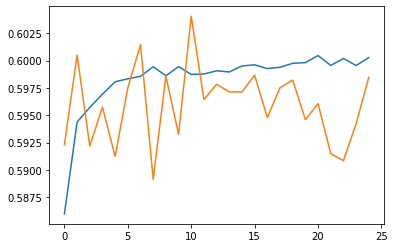

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

   1/4385 [..............................] - ETA: 1s - loss: 0.7358 - accuracy: 0.6562

  16/4385 [..............................] - ETA: 14s - loss: 0.7742 - accuracy: 0.7090

  31/4385 [..............................] - ETA: 15s - loss: 0.8105 - accuracy: 0.6794

  45/4385 [..............................] - ETA: 15s - loss: 0.8032 - accuracy: 0.6889

  60/4385 [..............................] - ETA: 15s - loss: 0.8152 - accuracy: 0.6870

  75/4385 [..............................] - ETA: 15s - loss: 0.8158 - accuracy: 0.6800

  90/4385 [..............................] - ETA: 15s - loss: 0.8120 - accuracy: 0.6781

 104/4385 [..............................] - ETA: 15s - loss: 0.8178 - accuracy: 0.6776

 118/4385 [..............................] - ETA: 15s - loss: 0.8306 - accuracy: 0.6764

 132/4385 [..............................] - ETA: 15s - loss: 0.8453 - accuracy: 0.6674

 147/4385 [>.............................] - ETA: 15s - loss: 0.8585 - accuracy: 0.6643

 162/4385 [>.............................] - ETA: 14s - loss: 0.8656 - accuracy: 0.6582

 176/4385 [>.............................] - ETA: 14s - loss: 0.8687 - accuracy: 0.6571

 191/4385 [>.............................] - ETA: 14s - loss: 0.8686 - accuracy: 0.6561

 205/4385 [>.............................] - ETA: 14s - loss: 0.8693 - accuracy: 0.6569

 220/4385 [>.............................] - ETA: 14s - loss: 0.8733 - accuracy: 0.6544

 234/4385 [>.............................] - ETA: 14s - loss: 0.8822 - accuracy: 0.6513

 249/4385 [>.............................] - ETA: 14s - loss: 0.8812 - accuracy: 0.6531

 264/4385 [>.............................] - ETA: 14s - loss: 0.8806 - accuracy: 0.6539

 278/4385 [>.............................] - ETA: 14s - loss: 0.8859 - accuracy: 0.6523

 293/4385 [=>............................] - ETA: 14s - loss: 0.8856 - accuracy: 0.6523

 307/4385 [=>............................] - ETA: 14s - loss: 0.8874 - accuracy: 0.6522

 322/4385 [=>............................] - ETA: 14s - loss: 0.8899 - accuracy: 0.6524

 337/4385 [=>............................] - ETA: 14s - loss: 0.8949 - accuracy: 0.6495

 352/4385 [=>............................] - ETA: 14s - loss: 0.8970 - accuracy: 0.6481

 366/4385 [=>............................] - ETA: 14s - loss: 0.8994 - accuracy: 0.6470

 381/4385 [=>............................] - ETA: 14s - loss: 0.8968 - accuracy: 0.6475

 395/4385 [=>............................] - ETA: 14s - loss: 0.8957 - accuracy: 0.6482

 409/4385 [=>............................] - ETA: 14s - loss: 0.8941 - accuracy: 0.6488

 424/4385 [=>............................] - ETA: 14s - loss: 0.8994 - accuracy: 0.6471

 438/4385 [=>............................] - ETA: 14s - loss: 0.8990 - accuracy: 0.6468

 453/4385 [==>...........................] - ETA: 13s - loss: 0.9015 - accuracy: 0.6459

 468/4385 [==>...........................] - ETA: 13s - loss: 0.9001 - accuracy: 0.6451

 482/4385 [==>...........................] - ETA: 13s - loss: 0.8985 - accuracy: 0.6460

 496/4385 [==>...........................] - ETA: 13s - loss: 0.8998 - accuracy: 0.6456

 510/4385 [==>...........................] - ETA: 13s - loss: 0.9024 - accuracy: 0.6447

 524/4385 [==>...........................] - ETA: 13s - loss: 0.9044 - accuracy: 0.6444

 539/4385 [==>...........................] - ETA: 13s - loss: 0.9040 - accuracy: 0.6443

 553/4385 [==>...........................] - ETA: 13s - loss: 0.9052 - accuracy: 0.6440

 568/4385 [==>...........................] - ETA: 13s - loss: 0.9091 - accuracy: 0.6422

 583/4385 [==>...........................] - ETA: 13s - loss: 0.9085 - accuracy: 0.6424

 598/4385 [===>..........................] - ETA: 13s - loss: 0.9084 - accuracy: 0.6422

 612/4385 [===>..........................] - ETA: 13s - loss: 0.9068 - accuracy: 0.6427

 626/4385 [===>..........................] - ETA: 13s - loss: 0.9081 - accuracy: 0.6420

 641/4385 [===>..........................] - ETA: 13s - loss: 0.9084 - accuracy: 0.6412

 656/4385 [===>..........................] - ETA: 13s - loss: 0.9118 - accuracy: 0.6403

 670/4385 [===>..........................] - ETA: 13s - loss: 0.9119 - accuracy: 0.6403

 685/4385 [===>..........................] - ETA: 13s - loss: 0.9138 - accuracy: 0.6402

 700/4385 [===>..........................] - ETA: 13s - loss: 0.9139 - accuracy: 0.6394

 715/4385 [===>..........................] - ETA: 13s - loss: 0.9152 - accuracy: 0.6388

 730/4385 [===>..........................] - ETA: 13s - loss: 0.9164 - accuracy: 0.6386

 745/4385 [====>.........................] - ETA: 12s - loss: 0.9168 - accuracy: 0.6382

 759/4385 [====>.........................] - ETA: 12s - loss: 0.9181 - accuracy: 0.6378

 774/4385 [====>.........................] - ETA: 12s - loss: 0.9185 - accuracy: 0.6365

 789/4385 [====>.........................] - ETA: 12s - loss: 0.9179 - accuracy: 0.6372

 804/4385 [====>.........................] - ETA: 12s - loss: 0.9182 - accuracy: 0.6370

 818/4385 [====>.........................] - ETA: 12s - loss: 0.9201 - accuracy: 0.6366

 833/4385 [====>.........................] - ETA: 12s - loss: 0.9211 - accuracy: 0.6357

 847/4385 [====>.........................] - ETA: 12s - loss: 0.9227 - accuracy: 0.6347

 862/4385 [====>.........................] - ETA: 12s - loss: 0.9248 - accuracy: 0.6340

 876/4385 [====>.........................] - ETA: 12s - loss: 0.9251 - accuracy: 0.6338

 891/4385 [=====>........................] - ETA: 12s - loss: 0.9276 - accuracy: 0.6329

 906/4385 [=====>........................] - ETA: 12s - loss: 0.9290 - accuracy: 0.6322

 920/4385 [=====>........................] - ETA: 12s - loss: 0.9305 - accuracy: 0.6310

 934/4385 [=====>........................] - ETA: 12s - loss: 0.9318 - accuracy: 0.6307

 948/4385 [=====>........................] - ETA: 12s - loss: 0.9330 - accuracy: 0.6300

 963/4385 [=====>........................] - ETA: 12s - loss: 0.9344 - accuracy: 0.6297

 978/4385 [=====>........................] - ETA: 12s - loss: 0.9349 - accuracy: 0.6293

 992/4385 [=====>........................] - ETA: 12s - loss: 0.9352 - accuracy: 0.6288

1006/4385 [=====>........................] - ETA: 12s - loss: 0.9355 - accuracy: 0.6284

1020/4385 [=====>........................] - ETA: 11s - loss: 0.9374 - accuracy: 0.6275

1035/4385 [======>.......................] - ETA: 11s - loss: 0.9387 - accuracy: 0.6276

1050/4385 [======>.......................] - ETA: 11s - loss: 0.9390 - accuracy: 0.6274

1065/4385 [======>.......................] - ETA: 11s - loss: 0.9394 - accuracy: 0.6268

1080/4385 [======>.......................] - ETA: 11s - loss: 0.9389 - accuracy: 0.6273

1095/4385 [======>.......................] - ETA: 11s - loss: 0.9388 - accuracy: 0.6275

1109/4385 [======>.......................] - ETA: 11s - loss: 0.9406 - accuracy: 0.6267

1124/4385 [======>.......................] - ETA: 11s - loss: 0.9409 - accuracy: 0.6266

1139/4385 [======>.......................] - ETA: 11s - loss: 0.9426 - accuracy: 0.6257

1154/4385 [======>.......................] - ETA: 11s - loss: 0.9428 - accuracy: 0.6256

1169/4385 [======>.......................] - ETA: 11s - loss: 0.9423 - accuracy: 0.6256

1184/4385 [=======>......................] - ETA: 11s - loss: 0.9430 - accuracy: 0.6253

1199/4385 [=======>......................] - ETA: 11s - loss: 0.9430 - accuracy: 0.6257

1214/4385 [=======>......................] - ETA: 11s - loss: 0.9433 - accuracy: 0.6257

1228/4385 [=======>......................] - ETA: 11s - loss: 0.9433 - accuracy: 0.6256

1243/4385 [=======>......................] - ETA: 11s - loss: 0.9434 - accuracy: 0.6254

1257/4385 [=======>......................] - ETA: 11s - loss: 0.9432 - accuracy: 0.6255

1271/4385 [=======>......................] - ETA: 11s - loss: 0.9427 - accuracy: 0.6258

1286/4385 [=======>......................] - ETA: 11s - loss: 0.9428 - accuracy: 0.6259

1300/4385 [=======>......................] - ETA: 10s - loss: 0.9450 - accuracy: 0.6250

1314/4385 [=======>......................] - ETA: 10s - loss: 0.9462 - accuracy: 0.6244

1329/4385 [========>.....................] - ETA: 10s - loss: 0.9468 - accuracy: 0.6238

1343/4385 [========>.....................] - ETA: 10s - loss: 0.9455 - accuracy: 0.6244

1357/4385 [========>.....................] - ETA: 10s - loss: 0.9462 - accuracy: 0.6239

1372/4385 [========>.....................] - ETA: 10s - loss: 0.9475 - accuracy: 0.6235

1387/4385 [========>.....................] - ETA: 10s - loss: 0.9468 - accuracy: 0.6236

1402/4385 [========>.....................] - ETA: 10s - loss: 0.9467 - accuracy: 0.6237

1417/4385 [========>.....................] - ETA: 10s - loss: 0.9470 - accuracy: 0.6233

1432/4385 [========>.....................] - ETA: 10s - loss: 0.9473 - accuracy: 0.6229

1447/4385 [========>.....................] - ETA: 10s - loss: 0.9477 - accuracy: 0.6227

1462/4385 [=========>....................] - ETA: 10s - loss: 0.9483 - accuracy: 0.6223

1476/4385 [=========>....................] - ETA: 10s - loss: 0.9486 - accuracy: 0.6221

1490/4385 [=========>....................] - ETA: 10s - loss: 0.9492 - accuracy: 0.6216

1504/4385 [=========>....................] - ETA: 10s - loss: 0.9496 - accuracy: 0.6216

1519/4385 [=========>....................] - ETA: 10s - loss: 0.9497 - accuracy: 0.6213

1534/4385 [=========>....................] - ETA: 10s - loss: 0.9504 - accuracy: 0.6207

1548/4385 [=========>....................] - ETA: 10s - loss: 0.9504 - accuracy: 0.6206

1563/4385 [=========>....................] - ETA: 10s - loss: 0.9506 - accuracy: 0.6202

1577/4385 [=========>....................] - ETA: 9s - loss: 0.9506 - accuracy: 0.6201 

1592/4385 [=========>....................] - ETA: 9s - loss: 0.9508 - accuracy: 0.6201

1607/4385 [=========>....................] - ETA: 9s - loss: 0.9510 - accuracy: 0.6199

1622/4385 [==========>...................] - ETA: 9s - loss: 0.9525 - accuracy: 0.6191

1637/4385 [==========>...................] - ETA: 9s - loss: 0.9528 - accuracy: 0.6190

1652/4385 [==========>...................] - ETA: 9s - loss: 0.9530 - accuracy: 0.6192

1666/4385 [==========>...................] - ETA: 9s - loss: 0.9535 - accuracy: 0.6189

1681/4385 [==========>...................] - ETA: 9s - loss: 0.9537 - accuracy: 0.6187

1696/4385 [==========>...................] - ETA: 9s - loss: 0.9547 - accuracy: 0.6181

1710/4385 [==========>...................] - ETA: 9s - loss: 0.9550 - accuracy: 0.6181

1724/4385 [==========>...................] - ETA: 9s - loss: 0.9559 - accuracy: 0.6178

1739/4385 [==========>...................] - ETA: 9s - loss: 0.9557 - accuracy: 0.6178

1753/4385 [==========>...................] - ETA: 9s - loss: 0.9558 - accuracy: 0.6176

1767/4385 [===========>..................] - ETA: 9s - loss: 0.9563 - accuracy: 0.6174

1781/4385 [===========>..................] - ETA: 9s - loss: 0.9574 - accuracy: 0.6170

1796/4385 [===========>..................] - ETA: 9s - loss: 0.9572 - accuracy: 0.6173

1811/4385 [===========>..................] - ETA: 9s - loss: 0.9578 - accuracy: 0.6170

1826/4385 [===========>..................] - ETA: 9s - loss: 0.9573 - accuracy: 0.6171

1841/4385 [===========>..................] - ETA: 9s - loss: 0.9577 - accuracy: 0.6166

1856/4385 [===========>..................] - ETA: 9s - loss: 0.9578 - accuracy: 0.6164

1871/4385 [===========>..................] - ETA: 8s - loss: 0.9575 - accuracy: 0.6166

1886/4385 [===========>..................] - ETA: 8s - loss: 0.9578 - accuracy: 0.6164

1901/4385 [============>.................] - ETA: 8s - loss: 0.9583 - accuracy: 0.6162

1916/4385 [============>.................] - ETA: 8s - loss: 0.9581 - accuracy: 0.6161

1930/4385 [============>.................] - ETA: 8s - loss: 0.9575 - accuracy: 0.6163

1945/4385 [============>.................] - ETA: 8s - loss: 0.9582 - accuracy: 0.6161

1960/4385 [============>.................] - ETA: 8s - loss: 0.9577 - accuracy: 0.6162

1975/4385 [============>.................] - ETA: 8s - loss: 0.9577 - accuracy: 0.6162

1990/4385 [============>.................] - ETA: 8s - loss: 0.9588 - accuracy: 0.6159

2005/4385 [============>.................] - ETA: 8s - loss: 0.9587 - accuracy: 0.6158

2020/4385 [============>.................] - ETA: 8s - loss: 0.9591 - accuracy: 0.6153

2035/4385 [============>.................] - ETA: 8s - loss: 0.9598 - accuracy: 0.6150

2050/4385 [=============>................] - ETA: 8s - loss: 0.9601 - accuracy: 0.6150

2065/4385 [=============>................] - ETA: 8s - loss: 0.9608 - accuracy: 0.6147

2080/4385 [=============>................] - ETA: 8s - loss: 0.9620 - accuracy: 0.6142

2095/4385 [=============>................] - ETA: 8s - loss: 0.9630 - accuracy: 0.6136

2109/4385 [=============>................] - ETA: 8s - loss: 0.9637 - accuracy: 0.6134

2123/4385 [=============>................] - ETA: 8s - loss: 0.9633 - accuracy: 0.6133

2137/4385 [=============>................] - ETA: 7s - loss: 0.9634 - accuracy: 0.6132

2151/4385 [=============>................] - ETA: 7s - loss: 0.9636 - accuracy: 0.6130

2166/4385 [=============>................] - ETA: 7s - loss: 0.9637 - accuracy: 0.6129

2181/4385 [=============>................] - ETA: 7s - loss: 0.9638 - accuracy: 0.6127

2196/4385 [==============>...............] - ETA: 7s - loss: 0.9643 - accuracy: 0.6126

2210/4385 [==============>...............] - ETA: 7s - loss: 0.9649 - accuracy: 0.6125

2224/4385 [==============>...............] - ETA: 7s - loss: 0.9651 - accuracy: 0.6123

2238/4385 [==============>...............] - ETA: 7s - loss: 0.9652 - accuracy: 0.6123

2253/4385 [==============>...............] - ETA: 7s - loss: 0.9649 - accuracy: 0.6124

2268/4385 [==============>...............] - ETA: 7s - loss: 0.9651 - accuracy: 0.6124

2283/4385 [==============>...............] - ETA: 7s - loss: 0.9658 - accuracy: 0.6123

2298/4385 [==============>...............] - ETA: 7s - loss: 0.9656 - accuracy: 0.6123

2313/4385 [==============>...............] - ETA: 7s - loss: 0.9656 - accuracy: 0.6124

2328/4385 [==============>...............] - ETA: 7s - loss: 0.9655 - accuracy: 0.6125

2343/4385 [===============>..............] - ETA: 7s - loss: 0.9654 - accuracy: 0.6123

2357/4385 [===============>..............] - ETA: 7s - loss: 0.9664 - accuracy: 0.6117

2371/4385 [===============>..............] - ETA: 7s - loss: 0.9664 - accuracy: 0.6118

2386/4385 [===============>..............] - ETA: 7s - loss: 0.9665 - accuracy: 0.6119

2401/4385 [===============>..............] - ETA: 7s - loss: 0.9662 - accuracy: 0.6119

2416/4385 [===============>..............] - ETA: 6s - loss: 0.9668 - accuracy: 0.6116

2431/4385 [===============>..............] - ETA: 6s - loss: 0.9665 - accuracy: 0.6117

2446/4385 [===============>..............] - ETA: 6s - loss: 0.9660 - accuracy: 0.6121

2461/4385 [===============>..............] - ETA: 6s - loss: 0.9663 - accuracy: 0.6120

2476/4385 [===============>..............] - ETA: 6s - loss: 0.9662 - accuracy: 0.6120

2491/4385 [================>.............] - ETA: 6s - loss: 0.9665 - accuracy: 0.6118

2506/4385 [================>.............] - ETA: 6s - loss: 0.9659 - accuracy: 0.6120

2521/4385 [================>.............] - ETA: 6s - loss: 0.9663 - accuracy: 0.6119

2536/4385 [================>.............] - ETA: 6s - loss: 0.9663 - accuracy: 0.6117

2551/4385 [================>.............] - ETA: 6s - loss: 0.9664 - accuracy: 0.6117

2566/4385 [================>.............] - ETA: 6s - loss: 0.9662 - accuracy: 0.6118

2581/4385 [================>.............] - ETA: 6s - loss: 0.9662 - accuracy: 0.6118

2596/4385 [================>.............] - ETA: 6s - loss: 0.9662 - accuracy: 0.6118

2611/4385 [================>.............] - ETA: 6s - loss: 0.9662 - accuracy: 0.6118

2626/4385 [================>.............] - ETA: 6s - loss: 0.9664 - accuracy: 0.6117

2640/4385 [=================>............] - ETA: 6s - loss: 0.9670 - accuracy: 0.6115

2655/4385 [=================>............] - ETA: 6s - loss: 0.9677 - accuracy: 0.6112

2670/4385 [=================>............] - ETA: 6s - loss: 0.9681 - accuracy: 0.6109

2685/4385 [=================>............] - ETA: 6s - loss: 0.9679 - accuracy: 0.6109

2700/4385 [=================>............] - ETA: 5s - loss: 0.9682 - accuracy: 0.6107

2715/4385 [=================>............] - ETA: 5s - loss: 0.9680 - accuracy: 0.6108

2730/4385 [=================>............] - ETA: 5s - loss: 0.9680 - accuracy: 0.6107

2745/4385 [=================>............] - ETA: 5s - loss: 0.9679 - accuracy: 0.6109

2760/4385 [=================>............] - ETA: 5s - loss: 0.9680 - accuracy: 0.6108

2775/4385 [=================>............] - ETA: 5s - loss: 0.9683 - accuracy: 0.6106

2790/4385 [==================>...........] - ETA: 5s - loss: 0.9684 - accuracy: 0.6106

2805/4385 [==================>...........] - ETA: 5s - loss: 0.9684 - accuracy: 0.6106

2820/4385 [==================>...........] - ETA: 5s - loss: 0.9687 - accuracy: 0.6105

2835/4385 [==================>...........] - ETA: 5s - loss: 0.9693 - accuracy: 0.6102

2850/4385 [==================>...........] - ETA: 5s - loss: 0.9693 - accuracy: 0.6103

2865/4385 [==================>...........] - ETA: 5s - loss: 0.9696 - accuracy: 0.6102

2880/4385 [==================>...........] - ETA: 5s - loss: 0.9694 - accuracy: 0.6103

2894/4385 [==================>...........] - ETA: 5s - loss: 0.9696 - accuracy: 0.6103

2909/4385 [==================>...........] - ETA: 5s - loss: 0.9700 - accuracy: 0.6102

2924/4385 [===================>..........] - ETA: 5s - loss: 0.9706 - accuracy: 0.6100

2938/4385 [===================>..........] - ETA: 5s - loss: 0.9704 - accuracy: 0.6101

2952/4385 [===================>..........] - ETA: 5s - loss: 0.9700 - accuracy: 0.6102

2967/4385 [===================>..........] - ETA: 5s - loss: 0.9692 - accuracy: 0.6105

2982/4385 [===================>..........] - ETA: 4s - loss: 0.9694 - accuracy: 0.6105

2997/4385 [===================>..........] - ETA: 4s - loss: 0.9695 - accuracy: 0.6106

3012/4385 [===================>..........] - ETA: 4s - loss: 0.9697 - accuracy: 0.6105

3027/4385 [===================>..........] - ETA: 4s - loss: 0.9697 - accuracy: 0.6104

3042/4385 [===================>..........] - ETA: 4s - loss: 0.9698 - accuracy: 0.6104

3057/4385 [===================>..........] - ETA: 4s - loss: 0.9704 - accuracy: 0.6102

3072/4385 [====================>.........] - ETA: 4s - loss: 0.9707 - accuracy: 0.6100

3086/4385 [====================>.........] - ETA: 4s - loss: 0.9706 - accuracy: 0.6099

3101/4385 [====================>.........] - ETA: 4s - loss: 0.9710 - accuracy: 0.6097

3116/4385 [====================>.........] - ETA: 4s - loss: 0.9714 - accuracy: 0.6095

3131/4385 [====================>.........] - ETA: 4s - loss: 0.9713 - accuracy: 0.6096

3146/4385 [====================>.........] - ETA: 4s - loss: 0.9716 - accuracy: 0.6094

3161/4385 [====================>.........] - ETA: 4s - loss: 0.9721 - accuracy: 0.6091

3176/4385 [====================>.........] - ETA: 4s - loss: 0.9724 - accuracy: 0.6089

3191/4385 [====================>.........] - ETA: 4s - loss: 0.9726 - accuracy: 0.6087

3206/4385 [====================>.........] - ETA: 4s - loss: 0.9727 - accuracy: 0.6086

3221/4385 [=====================>........] - ETA: 4s - loss: 0.9728 - accuracy: 0.6085

3235/4385 [=====================>........] - ETA: 4s - loss: 0.9731 - accuracy: 0.6082

3249/4385 [=====================>........] - ETA: 4s - loss: 0.9735 - accuracy: 0.6081

3263/4385 [=====================>........] - ETA: 3s - loss: 0.9740 - accuracy: 0.6079

3278/4385 [=====================>........] - ETA: 3s - loss: 0.9742 - accuracy: 0.6077

3293/4385 [=====================>........] - ETA: 3s - loss: 0.9742 - accuracy: 0.6078

3308/4385 [=====================>........] - ETA: 3s - loss: 0.9743 - accuracy: 0.6077

3323/4385 [=====================>........] - ETA: 3s - loss: 0.9746 - accuracy: 0.6076

3338/4385 [=====================>........] - ETA: 3s - loss: 0.9751 - accuracy: 0.6073

3353/4385 [=====================>........] - ETA: 3s - loss: 0.9751 - accuracy: 0.6073

3368/4385 [======================>.......] - ETA: 3s - loss: 0.9753 - accuracy: 0.6073

3383/4385 [======================>.......] - ETA: 3s - loss: 0.9756 - accuracy: 0.6071

3398/4385 [======================>.......] - ETA: 3s - loss: 0.9758 - accuracy: 0.6070

3413/4385 [======================>.......] - ETA: 3s - loss: 0.9758 - accuracy: 0.6070

3427/4385 [======================>.......] - ETA: 3s - loss: 0.9759 - accuracy: 0.6070

3441/4385 [======================>.......] - ETA: 3s - loss: 0.9759 - accuracy: 0.6070

3456/4385 [======================>.......] - ETA: 3s - loss: 0.9759 - accuracy: 0.6070

3471/4385 [======================>.......] - ETA: 3s - loss: 0.9764 - accuracy: 0.6068

3486/4385 [======================>.......] - ETA: 3s - loss: 0.9764 - accuracy: 0.6067

3500/4385 [======================>.......] - ETA: 3s - loss: 0.9766 - accuracy: 0.6066

3515/4385 [=======================>......] - ETA: 3s - loss: 0.9765 - accuracy: 0.6065

3530/4385 [=======================>......] - ETA: 3s - loss: 0.9768 - accuracy: 0.6062

3545/4385 [=======================>......] - ETA: 2s - loss: 0.9776 - accuracy: 0.6060

3560/4385 [=======================>......] - ETA: 2s - loss: 0.9779 - accuracy: 0.6058

3575/4385 [=======================>......] - ETA: 2s - loss: 0.9785 - accuracy: 0.6056

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9786 - accuracy: 0.6056

3605/4385 [=======================>......] - ETA: 2s - loss: 0.9788 - accuracy: 0.6055

3620/4385 [=======================>......] - ETA: 2s - loss: 0.9789 - accuracy: 0.6056

3635/4385 [=======================>......] - ETA: 2s - loss: 0.9792 - accuracy: 0.6054

3650/4385 [=======================>......] - ETA: 2s - loss: 0.9791 - accuracy: 0.6055

3664/4385 [========================>.....] - ETA: 2s - loss: 0.9792 - accuracy: 0.6055

3679/4385 [========================>.....] - ETA: 2s - loss: 0.9792 - accuracy: 0.6055

3693/4385 [========================>.....] - ETA: 2s - loss: 0.9793 - accuracy: 0.6055

3707/4385 [========================>.....] - ETA: 2s - loss: 0.9790 - accuracy: 0.6057

3722/4385 [========================>.....] - ETA: 2s - loss: 0.9794 - accuracy: 0.6055

3736/4385 [========================>.....] - ETA: 2s - loss: 0.9800 - accuracy: 0.6053

3750/4385 [========================>.....] - ETA: 2s - loss: 0.9801 - accuracy: 0.6052

3764/4385 [========================>.....] - ETA: 2s - loss: 0.9798 - accuracy: 0.6053

3779/4385 [========================>.....] - ETA: 2s - loss: 0.9796 - accuracy: 0.6054

3793/4385 [========================>.....] - ETA: 2s - loss: 0.9797 - accuracy: 0.6053

3807/4385 [=========================>....] - ETA: 2s - loss: 0.9797 - accuracy: 0.6052

3821/4385 [=========================>....] - ETA: 1s - loss: 0.9798 - accuracy: 0.6052

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9800 - accuracy: 0.6052

3850/4385 [=========================>....] - ETA: 1s - loss: 0.9801 - accuracy: 0.6050

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9804 - accuracy: 0.6050

3880/4385 [=========================>....] - ETA: 1s - loss: 0.9805 - accuracy: 0.6050

3894/4385 [=========================>....] - ETA: 1s - loss: 0.9809 - accuracy: 0.6050

3908/4385 [=========================>....] - ETA: 1s - loss: 0.9809 - accuracy: 0.6050

3923/4385 [=========================>....] - ETA: 1s - loss: 0.9808 - accuracy: 0.6049

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9808 - accuracy: 0.6051

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9810 - accuracy: 0.6050

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9815 - accuracy: 0.6048

3982/4385 [==========================>...] - ETA: 1s - loss: 0.9818 - accuracy: 0.6045

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9820 - accuracy: 0.6045

4011/4385 [==========================>...] - ETA: 1s - loss: 0.9825 - accuracy: 0.6042

4025/4385 [==========================>...] - ETA: 1s - loss: 0.9826 - accuracy: 0.6041

4040/4385 [==========================>...] - ETA: 1s - loss: 0.9825 - accuracy: 0.6042

4055/4385 [==========================>...] - ETA: 1s - loss: 0.9825 - accuracy: 0.6041

4070/4385 [==========================>...] - ETA: 1s - loss: 0.9824 - accuracy: 0.6041

4085/4385 [==========================>...] - ETA: 1s - loss: 0.9823 - accuracy: 0.6042

4100/4385 [===========================>..] - ETA: 1s - loss: 0.9822 - accuracy: 0.6042

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9822 - accuracy: 0.6042

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9824 - accuracy: 0.6041

4144/4385 [===========================>..] - ETA: 0s - loss: 0.9826 - accuracy: 0.6040

4159/4385 [===========================>..] - ETA: 0s - loss: 0.9833 - accuracy: 0.6037

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9834 - accuracy: 0.6036

4186/4385 [===========================>..] - ETA: 0s - loss: 0.9838 - accuracy: 0.6034

4200/4385 [===========================>..] - ETA: 0s - loss: 0.9839 - accuracy: 0.6033

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9838 - accuracy: 0.6033

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9841 - accuracy: 0.6033

4243/4385 [============================>.] - ETA: 0s - loss: 0.9843 - accuracy: 0.6032

4257/4385 [============================>.] - ETA: 0s - loss: 0.9844 - accuracy: 0.6032

4272/4385 [============================>.] - ETA: 0s - loss: 0.9845 - accuracy: 0.6031

4286/4385 [============================>.] - ETA: 0s - loss: 0.9846 - accuracy: 0.6031

4301/4385 [============================>.] - ETA: 0s - loss: 0.9848 - accuracy: 0.6030

4315/4385 [============================>.] - ETA: 0s - loss: 0.9844 - accuracy: 0.6030

4330/4385 [============================>.] - ETA: 0s - loss: 0.9845 - accuracy: 0.6030

4345/4385 [============================>.] - ETA: 0s - loss: 0.9849 - accuracy: 0.6028

4359/4385 [============================>.] - ETA: 0s - loss: 0.9852 - accuracy: 0.6027

4374/4385 [============================>.] - ETA: 0s - loss: 0.9848 - accuracy: 0.6029

4385/4385 [==============================] - 16s 4ms/step - loss: 0.9851 - accuracy: 0.6028


  1/493 [..............................] - ETA: 0s - loss: 0.9120 - accuracy: 0.6250

 23/493 [>.............................] - ETA: 1s - loss: 0.9403 - accuracy: 0.6209

 45/493 [=>............................] - ETA: 1s - loss: 0.9342 - accuracy: 0.6181

 67/493 [===>..........................] - ETA: 0s - loss: 0.9302 - accuracy: 0.6273

 90/493 [====>.........................] - ETA: 0s - loss: 0.9245 - accuracy: 0.6278

112/493 [=====>........................] - ETA: 0s - loss: 0.9191 - accuracy: 0.6286

134/493 [=======>......................] - ETA: 0s - loss: 0.9314 - accuracy: 0.6245

155/493 [========>.....................] - ETA: 0s - loss: 0.9314 - accuracy: 0.6226

178/493 [=========>....................] - ETA: 0s - loss: 0.9497 - accuracy: 0.6166

201/493 [===========>..................] - ETA: 0s - loss: 0.9579 - accuracy: 0.6112

223/493 [============>.................] - ETA: 0s - loss: 0.9600 - accuracy: 0.6104

245/493 [=============>................] - ETA: 0s - loss: 0.9640 - accuracy: 0.6060

267/493 [===============>..............] - ETA: 0s - loss: 0.9626 - accuracy: 0.6060

288/493 [================>.............] - ETA: 0s - loss: 0.9659 - accuracy: 0.6031

310/493 [=================>............] - ETA: 0s - loss: 0.9680 - accuracy: 0.6025

332/493 [===================>..........] - ETA: 0s - loss: 0.9678 - accuracy: 0.6021

354/493 [====================>.........] - ETA: 0s - loss: 0.9694 - accuracy: 0.6004

376/493 [=====================>........] - ETA: 0s - loss: 0.9708 - accuracy: 0.5993

398/493 [=======================>......] - ETA: 0s - loss: 0.9722 - accuracy: 0.6002

419/493 [========================>.....] - ETA: 0s - loss: 0.9764 - accuracy: 0.5989

441/493 [=========================>....] - ETA: 0s - loss: 0.9762 - accuracy: 0.5993

462/493 [===========================>..] - ETA: 0s - loss: 0.9773 - accuracy: 0.5981

484/493 [============================>.] - ETA: 0s - loss: 0.9777 - accuracy: 0.5980

493/493 [==============================] - 1s 2ms/step - loss: 0.9785 - accuracy: 0.5985


Training set accuracy: 0.6027723550796509
Validation set accuracy: 0.5984756946563721


## Confusion matrix

Another very interesting statistic, especially for multiclass problems, is the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix allows visualization of the proportion of correctly and incorrectly labelled examples. We can easily see how much our classifier is biased and whether the distribution of labels makes sense. Ideally the largest fraction of predictions should be distributed along the diagonal.

In [12]:
predictions = model.predict(dict(validation_df))
predictions = tf.argmax(predictions, axis=-1)
predictions

<tf.Tensor: shape=(15745,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 2])>

In [13]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(32.99999999999999, 0.5, 'True')

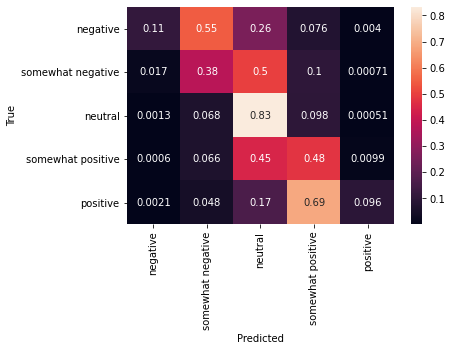

In [14]:
sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

We can easily submit the predictions back to Kaggle by pasting the following code to a code cell and executing it:

``` python
test_predictions = model.predict(dict(test_df))
test_predictions = np.argmax(test_predictions, axis=-1)

result_df = test_df.copy()

result_df["Predictions"] = test_predictions

result_df.to_csv(
    "predictions.csv",
    columns=["Predictions"],
    header=["Sentiment"])
kaggle.api.competition_submit("predictions.csv", "Submitted from Colab",
                              "sentiment-analysis-on-movie-reviews")
```


After submitting, [check the leaderboard](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/leaderboard) to see how you did.